<a href="https://colab.research.google.com/github/MasEvans83199/Bird-App/blob/main/main_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls /content/gdrive/My\ Drive

'Colab Notebooks'/   datasets/   train_extended.csv  'Untitled spreadsheet.gsheet'


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"masevans83199","key":"e731ad595424837600e91148bc1090f9"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kanchana1990/vehicle-dataset-2024                            Vehicle Dataset 2024                                308KB  2024-05-29 20:02:30            776         28  1.0              
rohit265/credit-card-eligibility-data-determining-factors    Credit Card Eligibility Data: Determining Factors   296KB  2024-05-18 11:31:28           1662         32  1.0              
piterfm/football-soccer-uefa-euro-1960-2024                  Football - Soccer - UEFA EURO, 1960 - 2024           87KB  2024-05-27 19:28:57            729         23  1.0              
hamjashaikh/mental-health-detection-dataset                  Mental Health 

In [ ]:
!kaggle datasets download -d rohanrao/xeno-canto-bird-recordings-extended-a-m

Dataset URL: https://www.kaggle.com/datasets/rohanrao/xeno-canto-bird-recordings-extended-a-m
License(s): other
100% 16.9G/16.9G [03:36<00:00, 102MB/s] 
100% 16.9G/16.9G [03:36<00:00, 84.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('xeno-canto-bird-recordings-extended-a-m.zip', 'r')
zip_ref.extractall('/content/gdrive/MyDrive/datasets')
zip_ref.close()

In [ ]:
!pip install librosa tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 43.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninst

In [ ]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')

In [ ]:
bird_mapping = dict(zip(df['ebird_code'], df['species']))

In [ ]:
import os
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from tqdm import tqdm

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'

# Define the number of classes (birds)
num_classes = len(bird_mapping)

# Define batch size
batch_size = 10  # Adjust this value as needed

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Check if there's a saved checkpoint
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Iterate through the folders in your dataset
start_processing = last_processed_file is None
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            # Check if we need to start processing this file
            if not start_processing:
                if audio_file == last_processed_file:
                    start_processing = True
                continue

            audio_file_path = os.path.join(folder_path, audio_file)
            if audio_file_path.endswith('.mp3'):
                try:
                    spectrogram = audio_to_spectrogram(audio_file_path)
                    audio_features.append(spectrogram)
                    labels.append(folder_name)

                    # Save checkpoint after processing each file
                    save_checkpoint(audio_file)

                except Exception as e:
                    print(f"Error processing {audio_file_path}: {e}")

# Convert lists to numpy arrays
X = np.array(audio_features)
y = np.array(labels)

# Normalize spectrograms
X = (X - X.min()) / (X.max() - X.min())

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape for the model (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('bird_sound_model.h5')


Resuming from XC132427.mp3


100%|██████████| 3/3 [00:00<00:00, 28086.86it/s]


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
import os
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'

# Define the number of classes (birds)
num_classes = len(bird_mapping)

# Define batch size
batch_size = 10  # Adjust this value as needed

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Check if there's a saved checkpoint
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        if len(y) == 0:
            raise ValueError("Empty audio file")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
start_processing = last_processed_file is None
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            # Check if we need to start processing this file
            if not start_processing:
                if audio_file == last_processed_file:
                    start_processing = True
                continue

            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                spectrogram = audio_to_spectrogram(audio_file_path)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")

                    # Save checkpoint after processing each file
                    save_checkpoint(audio_file)
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

# Check if audio_features and labels are not empty
if not audio_features or not labels:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")

# Convert lists to numpy arrays
X = np.array(audio_features)
y = np.array(labels)

# Normalize spectrograms
X = (X - X.min()) / (X.max() - X.min())

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape for the model (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('bird_sound_model.h5')


Resuming from XC132427.mp3


 40%|████      | 4/10 [00:31<00:47,  7.87s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3


 60%|██████    | 6/10 [00:31<00:17,  4.30s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3


 80%|████████  | 8/10 [00:32<00:04,  2.33s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3


 20%|██        | 2/10 [00:00<00:00,  8.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3


 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3


 70%|███████   | 7/10 [00:12<00:07,  2.47s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3


 80%|████████  | 8/10 [00:12<00:03,  1.88s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3


 90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3


 10%|█         | 1/10 [00:00<00:02,  4.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3


 20%|██        | 2/10 [00:01<00:05,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3


 40%|████      | 4/10 [00:01<00:02,  2.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145563.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151115.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3


 20%|██        | 2/10 [00:00<00:01,  5.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151150.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3


 20%|██        | 2/10 [00:00<00:01,  4.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3


 40%|████      | 4/10 [00:01<00:01,  4.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3


 10%|█         | 1/10 [00:00<00:03,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3


 30%|███       | 3/10 [00:00<00:01,  3.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3


 40%|████      | 4/10 [00:01<00:01,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3


 10%|█         | 1/10 [00:00<00:04,  1.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3


 20%|██        | 2/10 [00:01<00:04,  2.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3


 30%|███       | 3/10 [00:01<00:04,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3


 10%|█         | 1/10 [00:00<00:02,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3


 20%|██        | 2/10 [00:00<00:02,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3


 30%|███       | 3/10 [00:01<00:03,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3


 90%|█████████ | 9/10 [00:03<00:00,  4.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167639.mp3


 10%|█         | 1/10 [00:00<00:02,  4.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3


 30%|███       | 3/10 [00:00<00:01,  4.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3


 40%|████      | 4/10 [00:00<00:01,  5.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3


 50%|█████     | 5/10 [00:01<00:02,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3


 10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3


 20%|██        | 2/10 [00:01<00:05,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3


 10%|█         | 1/10 [00:00<00:07,  1.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3


 20%|██        | 2/10 [00:01<00:03,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3


 30%|███       | 3/10 [00:01<00:04,  1.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3


 40%|████      | 4/10 [00:02<00:03,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3


 10%|█         | 1/10 [00:00<00:02,  4.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3


 20%|██        | 2/10 [00:01<00:04,  1.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3


 40%|████      | 4/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3


 10%|█         | 1/10 [00:00<00:02,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3


 30%|███       | 3/10 [00:00<00:01,  5.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3


 40%|████      | 4/10 [00:00<00:01,  5.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3


 10%|█         | 1/10 [00:00<00:03,  2.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3


 30%|███       | 3/10 [00:00<00:02,  3.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3


 10%|█         | 1/10 [00:00<00:01,  6.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3


 20%|██        | 2/10 [00:00<00:01,  4.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3


 30%|███       | 3/10 [00:00<00:01,  4.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3


 40%|████      | 4/10 [00:01<00:01,  3.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3


 10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3


 20%|██        | 2/10 [00:00<00:02,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3


 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3


 10%|█         | 1/10 [00:00<00:02,  4.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3


 20%|██        | 2/10 [00:00<00:02,  2.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3


 30%|███       | 3/10 [00:01<00:03,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3


 40%|████      | 4/10 [00:01<00:02,  2.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3


 20%|██        | 2/10 [00:00<00:01,  6.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3


 40%|████      | 4/10 [00:00<00:01,  4.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3


 10%|█         | 1/10 [00:00<00:04,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3


 30%|███       | 3/10 [00:02<00:05,  1.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3


 10%|█         | 1/10 [00:00<00:02,  3.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3


 20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3


 30%|███       | 3/10 [00:01<00:03,  2.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3


 40%|████      | 4/10 [00:02<00:04,  1.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3


 20%|██        | 2/10 [00:00<00:01,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3


 30%|███       | 3/10 [00:00<00:01,  4.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3


 40%|████      | 4/10 [00:01<00:02,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC199496.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC202307.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC203378.mp3


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC203380.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC203417.mp3


 20%|██        | 2/10 [00:00<00:03,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC206484.mp3


 30%|███       | 3/10 [00:01<00:03,  2.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC208233.mp3


 40%|████      | 4/10 [00:01<00:02,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC208234.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC208395.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC208884.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC209059.mp3


 80%|████████  | 8/10 [00:05<00:02,  1.18s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC210466.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC211238.mp3


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC211673.mp3


 20%|██        | 2/10 [00:00<00:01,  5.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC213190.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC213467.mp3


 40%|████      | 4/10 [00:00<00:01,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC215043.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC215241.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC217078.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC217419.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC232921.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC232945.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC232946.mp3


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC232947.mp3


 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233181.mp3


 20%|██        | 2/10 [00:01<00:06,  1.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233317.mp3


 30%|███       | 3/10 [00:02<00:06,  1.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233318.mp3


 40%|████      | 4/10 [00:03<00:04,  1.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233320.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233321.mp3


 60%|██████    | 6/10 [00:04<00:02,  1.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233323.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233324.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233407.mp3


 90%|█████████ | 9/10 [00:04<00:00,  3.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233750.mp3


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233933.mp3


 20%|██        | 2/10 [00:00<00:01,  6.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233934.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC233935.mp3


 30%|███       | 3/10 [00:00<00:01,  5.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234318.mp3


 40%|████      | 4/10 [00:01<00:02,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234400.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234401.mp3


 60%|██████    | 6/10 [00:02<00:02,  1.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234402.mp3


 70%|███████   | 7/10 [00:05<00:04,  1.34s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234403.mp3


 80%|████████  | 8/10 [00:06<00:02,  1.16s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234404.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234405.mp3


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234406.mp3


 10%|█         | 1/10 [00:00<00:02,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234407.mp3


 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234408.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC234557.mp3


 40%|████      | 4/10 [00:01<00:01,  4.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC235170.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC236282.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC236354.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC237291.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC240783.mp3


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC242072.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243554.mp3


 10%|█         | 1/10 [00:00<00:01,  6.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243556.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243557.mp3


 30%|███       | 3/10 [00:00<00:01,  6.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243558.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243567.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC243568.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC245732.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC246667.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC246866.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC246867.mp3


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC246868.mp3


 10%|█         | 1/10 [00:00<00:03,  2.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC246976.mp3


 30%|███       | 3/10 [00:00<00:01,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC252316.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC253313.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC254277.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255789.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255796.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255965.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255969.mp3


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255974.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC255984.mp3


 10%|█         | 1/10 [00:00<00:05,  1.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256013.mp3


 20%|██        | 2/10 [00:00<00:03,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC25677.mp3


 30%|███       | 3/10 [00:01<00:02,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC25678.mp3


 40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256927.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256934.mp3


 60%|██████    | 6/10 [00:04<00:04,  1.01s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256935.mp3


 70%|███████   | 7/10 [00:06<00:03,  1.28s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256936.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256954.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256955.mp3


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256956.mp3


 20%|██        | 2/10 [00:00<00:01,  4.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256957.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256958.mp3


 30%|███       | 3/10 [00:00<00:01,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256959.mp3


 40%|████      | 4/10 [00:01<00:03,  1.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256960.mp3


 50%|█████     | 5/10 [00:02<00:03,  1.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256961.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC256962.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260079.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260080.mp3


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260081.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260082.mp3


 10%|█         | 1/10 [00:00<00:01,  7.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260083.mp3


 20%|██        | 2/10 [00:02<00:10,  1.32s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260100.mp3


 30%|███       | 3/10 [00:02<00:06,  1.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260107.mp3


 40%|████      | 4/10 [00:02<00:03,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260287.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260300.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC260309.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC261462.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC263054.mp3


 90%|█████████ | 9/10 [00:04<00:00,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC263216.mp3


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC263854.mp3


 10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC263857.mp3


 20%|██        | 2/10 [00:01<00:06,  1.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC263859.mp3


 40%|████      | 4/10 [00:02<00:03,  1.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC264023.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC264024.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC264025.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC264941.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC266452.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC266935.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268093.mp3


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268245.mp3


 20%|██        | 2/10 [00:00<00:01,  4.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268246.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268247.mp3


 30%|███       | 3/10 [00:00<00:01,  4.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268248.mp3


 40%|████      | 4/10 [00:00<00:01,  3.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268249.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268250.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC268690.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC269386.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC269446.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC269613.mp3


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC269825.mp3


 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC270027.mp3


 20%|██        | 2/10 [00:01<00:05,  1.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC271732.mp3


 30%|███       | 3/10 [00:01<00:03,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC271733.mp3


 40%|████      | 4/10 [00:02<00:02,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC271734.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC271735.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC276984.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC277258.mp3


 80%|████████  | 8/10 [00:03<00:00,  4.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC278423.mp3


 90%|█████████ | 9/10 [00:03<00:00,  4.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC278425.mp3


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC278560.mp3


 10%|█         | 1/10 [00:00<00:02,  4.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC279046.mp3


 20%|██        | 2/10 [00:00<00:02,  2.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC279163.mp3


 40%|████      | 4/10 [00:01<00:01,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC279680.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC279718.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC281889.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282141.mp3


 70%|███████   | 7/10 [00:04<00:02,  1.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282277.mp3


 80%|████████  | 8/10 [00:05<00:02,  1.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282278.mp3


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282280.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282669.mp3


 10%|█         | 1/10 [00:01<00:11,  1.27s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282806.mp3


 20%|██        | 2/10 [00:02<00:07,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282807.mp3


 30%|███       | 3/10 [00:02<00:04,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282808.mp3


 40%|████      | 4/10 [00:02<00:03,  1.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282809.mp3


 50%|█████     | 5/10 [00:03<00:02,  2.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC282810.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC283439.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC283464.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC283864.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC285097.mp3


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC285101.mp3


 10%|█         | 1/10 [00:01<00:13,  1.55s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC285105.mp3


 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC288403.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC288409.mp3


 40%|████      | 4/10 [00:03<00:03,  1.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC292029.mp3


 50%|█████     | 5/10 [00:03<00:02,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC292030.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC292441.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC292442.mp3


 80%|████████  | 8/10 [00:05<00:01,  1.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293413.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293414.mp3


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293415.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293476.mp3


 20%|██        | 2/10 [00:00<00:02,  3.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293932.mp3


 30%|███       | 3/10 [00:00<00:02,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293933.mp3


 40%|████      | 4/10 [00:01<00:01,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC293981.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC294491.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC295541.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC297280.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC298019.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC298221.mp3


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC298229.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC298759.mp3


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC299384.mp3


 40%|████      | 4/10 [00:02<00:03,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC299783.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC301047.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC302124.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC302483.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC302911.mp3


 80%|████████  | 8/10 [00:05<00:01,  1.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC303275.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC303329.mp3


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC304656.mp3


 10%|█         | 1/10 [00:00<00:05,  1.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC306063.mp3


 20%|██        | 2/10 [00:00<00:03,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC306064.mp3


 30%|███       | 3/10 [00:01<00:03,  2.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC306065.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC306629.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC306951.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC308049.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC309048.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC310533.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC310549.mp3


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC312107.mp3


 10%|█         | 1/10 [00:00<00:03,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC312273.mp3


 20%|██        | 2/10 [00:00<00:03,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC313075.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC313240.mp3


 40%|████      | 4/10 [00:01<00:01,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC314796.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC315289.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC315538.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC315539.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC315991.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC316242.mp3


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC316243.mp3


 10%|█         | 1/10 [00:00<00:00,  9.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC316244.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC316309.mp3


 30%|███       | 3/10 [00:01<00:03,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC317103.mp3


 40%|████      | 4/10 [00:02<00:04,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC317770.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC318065.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC318067.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC319601.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC320717.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC321068.mp3


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC321400.mp3


 10%|█         | 1/10 [00:00<00:01,  7.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC321575.mp3


 20%|██        | 2/10 [00:00<00:02,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC322518.mp3


 30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC322519.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC322720.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC322721.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC324458.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC324840.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC325709.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC325716.mp3


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326654.mp3


 10%|█         | 1/10 [00:04<00:41,  4.65s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326655.mp3


 20%|██        | 2/10 [00:11<00:46,  5.87s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326657.mp3


 30%|███       | 3/10 [00:17<00:40,  5.79s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326659.mp3


 40%|████      | 4/10 [00:21<00:31,  5.32s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326660.mp3


 50%|█████     | 5/10 [00:27<00:28,  5.64s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326662.mp3


 60%|██████    | 6/10 [00:33<00:22,  5.67s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326664.mp3


 70%|███████   | 7/10 [00:37<00:15,  5.25s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326665.mp3


 80%|████████  | 8/10 [00:46<00:12,  6.35s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326666.mp3


 90%|█████████ | 9/10 [00:51<00:05,  5.80s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326667.mp3


100%|██████████| 10/10 [00:55<00:00,  5.60s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326668.mp3


 10%|█         | 1/10 [00:07<01:08,  7.62s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326670.mp3


 20%|██        | 2/10 [00:12<00:47,  5.95s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326671.mp3


 30%|███       | 3/10 [00:17<00:38,  5.52s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326672.mp3


 40%|████      | 4/10 [00:23<00:33,  5.59s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326673.mp3


 50%|█████     | 5/10 [00:28<00:27,  5.44s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326674.mp3


 60%|██████    | 6/10 [00:34<00:22,  5.60s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326675.mp3


 70%|███████   | 7/10 [00:40<00:17,  5.99s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326676.mp3


 80%|████████  | 8/10 [00:45<00:11,  5.51s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326678.mp3


 90%|█████████ | 9/10 [00:51<00:05,  5.75s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326679.mp3


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326986.mp3


 10%|█         | 1/10 [00:04<00:42,  4.69s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326991.mp3


 20%|██        | 2/10 [00:11<00:45,  5.66s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326993.mp3


 30%|███       | 3/10 [00:16<00:37,  5.41s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326996.mp3


 40%|████      | 4/10 [00:29<00:51,  8.66s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC326999.mp3


 50%|█████     | 5/10 [00:34<00:36,  7.28s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327001.mp3


 60%|██████    | 6/10 [00:39<00:26,  6.50s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327002.mp3


 70%|███████   | 7/10 [00:46<00:19,  6.49s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327003.mp3


 80%|████████  | 8/10 [00:51<00:12,  6.13s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327004.mp3


 90%|█████████ | 9/10 [00:57<00:05,  5.98s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327005.mp3


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327006.mp3


 10%|█         | 1/10 [00:03<00:33,  3.71s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327393.mp3


 20%|██        | 2/10 [00:07<00:31,  3.89s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327394.mp3


 30%|███       | 3/10 [00:13<00:32,  4.69s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327396.mp3


 40%|████      | 4/10 [00:17<00:26,  4.41s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327397.mp3


 50%|█████     | 5/10 [00:20<00:20,  4.12s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC327398.mp3


 60%|██████    | 6/10 [00:21<00:11,  2.86s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328154.mp3


 70%|███████   | 7/10 [00:21<00:06,  2.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328156.mp3


 80%|████████  | 8/10 [00:22<00:03,  1.52s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328157.mp3


 90%|█████████ | 9/10 [00:22<00:01,  1.14s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328158.mp3


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328159.mp3


 10%|█         | 1/10 [00:00<00:03,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC328205.mp3


 30%|███       | 3/10 [00:00<00:01,  4.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC330918.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC334058.mp3


 40%|████      | 4/10 [00:01<00:01,  4.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC334059.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC335931.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC337609.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC340927.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC341090.mp3


 90%|█████████ | 9/10 [00:02<00:00,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC342565.mp3


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC343968.mp3


 10%|█         | 1/10 [00:00<00:08,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC344302.mp3


 20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC344306.mp3


 30%|███       | 3/10 [00:02<00:05,  1.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC344319.mp3


 50%|█████     | 5/10 [00:03<00:02,  1.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC344328.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC344330.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345803.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345804.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345805.mp3


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345806.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345807.mp3


 10%|█         | 1/10 [00:00<00:01,  7.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345810.mp3


 20%|██        | 2/10 [00:00<00:01,  5.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345811.mp3


 30%|███       | 3/10 [00:00<00:01,  4.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345813.mp3


 40%|████      | 4/10 [00:01<00:01,  3.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345815.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345817.mp3


 60%|██████    | 6/10 [00:03<00:04,  1.01s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345819.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345826.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345827.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345828.mp3


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345829.mp3


 20%|██        | 2/10 [00:00<00:01,  5.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345830.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345970.mp3


 30%|███       | 3/10 [00:01<00:04,  1.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345971.mp3


 40%|████      | 4/10 [00:04<00:09,  1.64s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC345973.mp3


 50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC347364.mp3


 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC347365.mp3


 70%|███████   | 7/10 [00:07<00:03,  1.28s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC347366.mp3


 80%|████████  | 8/10 [00:07<00:01,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC348725.mp3


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC348726.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC349816.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC349817.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC349818.mp3


 40%|████      | 4/10 [00:00<00:00,  6.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC351030.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC352024.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC353517.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC353518.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC355621.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC355698.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC355699.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC355975.mp3


 10%|█         | 1/10 [00:00<00:06,  1.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC355976.mp3


 20%|██        | 2/10 [00:00<00:03,  2.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC356114.mp3


 30%|███       | 3/10 [00:02<00:06,  1.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC356739.mp3


 40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC356740.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC357485.mp3


 70%|███████   | 7/10 [00:04<00:01,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC357671.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358005.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358006.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358007.mp3


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358008.mp3


 10%|█         | 1/10 [00:00<00:04,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358013.mp3


 20%|██        | 2/10 [00:01<00:04,  1.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358014.mp3


 30%|███       | 3/10 [00:01<00:02,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358134.mp3


 40%|████      | 4/10 [00:01<00:01,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358789.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC358802.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC359250.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360350.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360643.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360718.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360900.mp3


 10%|█         | 1/10 [00:00<00:07,  1.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360901.mp3


 20%|██        | 2/10 [00:01<00:05,  1.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC360902.mp3


 30%|███       | 3/10 [00:01<00:04,  1.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC361303.mp3


 40%|████      | 4/10 [00:03<00:05,  1.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC361377.mp3


 60%|██████    | 6/10 [00:04<00:02,  1.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC361642.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC362040.mp3


 70%|███████   | 7/10 [00:04<00:01,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC362041.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC362404.mp3


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC364440.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC364508.mp3


 10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC364541.mp3


 20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC365463.mp3


 30%|███       | 3/10 [00:01<00:02,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC365513.mp3


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC365515.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC366728.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC367473.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC367543.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC368025.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC368630.mp3


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC369746.mp3


 10%|█         | 1/10 [00:00<00:00,  9.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC369892.mp3


 20%|██        | 2/10 [00:00<00:01,  7.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC371292.mp3


 30%|███       | 3/10 [00:00<00:00,  8.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372735.mp3


 40%|████      | 4/10 [00:00<00:00,  7.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372737.mp3


 60%|██████    | 6/10 [00:00<00:00, 10.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372740.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372744.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372954.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC372955.mp3


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC373834.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC373987.mp3


 10%|█         | 1/10 [00:00<00:01,  5.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC374431.mp3


 20%|██        | 2/10 [00:00<00:04,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC374569.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC375135.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC376045.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC376632.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC376702.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC376730.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC376967.mp3


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC377232.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378153.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378161.mp3


 20%|██        | 2/10 [00:00<00:00, 13.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378162.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378173.mp3


 40%|████      | 4/10 [00:00<00:00,  8.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378175.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378317.mp3


 60%|██████    | 6/10 [00:00<00:00,  5.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378551.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC378641.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC379469.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC379552.mp3


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380358.mp3


 10%|█         | 1/10 [00:00<00:03,  2.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380687.mp3


 20%|██        | 2/10 [00:03<00:16,  2.07s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380893.mp3


 30%|███       | 3/10 [00:03<00:08,  1.27s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380894.mp3


 40%|████      | 4/10 [00:04<00:06,  1.03s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380895.mp3


 50%|█████     | 5/10 [00:05<00:04,  1.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380896.mp3


 70%|███████   | 7/10 [00:06<00:01,  1.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380898.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380899.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380900.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380901.mp3


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380905.mp3


 10%|█         | 1/10 [00:00<00:02,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380906.mp3


 20%|██        | 2/10 [00:00<00:02,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380907.mp3


 40%|████      | 4/10 [00:02<00:03,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380908.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380910.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380911.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380913.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380914.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC380915.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC381202.mp3


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC381732.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC381851.mp3


 20%|██        | 2/10 [00:00<00:01,  5.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC381852.mp3


 30%|███       | 3/10 [00:00<00:02,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC382330.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC382524.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC384661.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387366.mp3


 70%|███████   | 7/10 [00:05<00:03,  1.26s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387819.mp3


 80%|████████  | 8/10 [00:06<00:02,  1.20s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387820.mp3


 90%|█████████ | 9/10 [00:07<00:01,  1.21s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387937.mp3


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387938.mp3


 20%|██        | 2/10 [00:03<00:11,  1.39s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC387939.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC388295.mp3


 30%|███       | 3/10 [00:03<00:05,  1.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC388296.mp3


 50%|█████     | 5/10 [00:04<00:03,  1.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC388579.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC388700.mp3


 60%|██████    | 6/10 [00:05<00:03,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC389817.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC389818.mp3


 90%|█████████ | 9/10 [00:06<00:00,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC389959.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC391822.mp3


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC392156.mp3


 20%|██        | 2/10 [00:01<00:04,  1.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC392219.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC392771.mp3


 30%|███       | 3/10 [00:01<00:02,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC392773.mp3


 40%|████      | 4/10 [00:02<00:03,  1.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC39320.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC393436.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC393851.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC394785.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395223.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395224.mp3


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395225.mp3


 10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395226.mp3


 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395227.mp3


 30%|███       | 3/10 [00:02<00:05,  1.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC395228.mp3


 40%|████      | 4/10 [00:02<00:03,  1.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC396464.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC398610.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC398836.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC398844.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC398846.mp3


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC398847.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC400563.mp3


 10%|█         | 1/10 [00:00<00:01,  5.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC400877.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC401086.mp3


 30%|███       | 3/10 [00:00<00:01,  6.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC402128.mp3


 40%|████      | 4/10 [00:01<00:02,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC402159.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC402355.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC402356.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC402357.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC403458.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC404159.mp3


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC404693.mp3


 10%|█         | 1/10 [00:00<00:01,  8.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407091.mp3


 20%|██        | 2/10 [00:01<00:08,  1.06s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407093.mp3


 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407094.mp3


 40%|████      | 4/10 [00:03<00:05,  1.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407095.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407395.mp3


 60%|██████    | 6/10 [00:04<00:02,  1.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC407396.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC410548.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC410910.mp3


 90%|█████████ | 9/10 [00:05<00:00,  2.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC410911.mp3


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC414505.mp3


 20%|██        | 2/10 [00:00<00:01,  5.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC416145.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC418161.mp3


 30%|███       | 3/10 [00:00<00:01,  5.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC419691.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC419748.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC420852.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC421491.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC421492.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC421493.mp3


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC422118.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC422728.mp3


 10%|█         | 1/10 [00:00<00:00,  9.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC423854.mp3


 20%|██        | 2/10 [00:00<00:01,  4.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC424177.mp3


 40%|████      | 4/10 [00:00<00:01,  4.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC424179.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC425699.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC428233.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC431482.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC431483.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC431831.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC432106.mp3


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC432294.mp3


 10%|█         | 1/10 [00:00<00:03,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC432295.mp3


 30%|███       | 3/10 [00:00<00:01,  4.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC433157.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC433158.mp3


 40%|████      | 4/10 [00:01<00:01,  3.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC436302.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC436303.mp3


 60%|██████    | 6/10 [00:03<00:03,  1.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC436305.mp3


 70%|███████   | 7/10 [00:05<00:03,  1.05s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC436307.mp3


 80%|████████  | 8/10 [00:05<00:01,  1.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC436308.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC437798.mp3


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC439378.mp3


 10%|█         | 1/10 [00:00<00:08,  1.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC440680.mp3


 20%|██        | 2/10 [00:01<00:04,  1.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC440908.mp3


 40%|████      | 4/10 [00:01<00:02,  2.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC441542.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC441866.mp3


 50%|█████     | 5/10 [00:02<00:01,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443078.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443079.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443081.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443083.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443084.mp3


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443085.mp3


 20%|██        | 2/10 [00:00<00:00, 14.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443086.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443087.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443100.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443247.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443505.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443506.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443507.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC443751.mp3


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC444747.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC445796.mp3


 20%|██        | 2/10 [00:00<00:01,  6.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC445840.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC447034.mp3


 30%|███       | 3/10 [00:00<00:02,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC447435.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC447648.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC449127.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC449167.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC449170.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC449172.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC449554.mp3


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC451333.mp3


 10%|█         | 1/10 [00:00<00:01,  6.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC451366.mp3


 20%|██        | 2/10 [00:00<00:01,  4.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC451402.mp3


 30%|███       | 3/10 [00:00<00:01,  4.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC451905.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC453795.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC453903.mp3


 60%|██████    | 6/10 [00:06<00:08,  2.07s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454068.mp3


 70%|███████   | 7/10 [00:09<00:06,  2.28s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454088.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454381.mp3


 90%|█████████ | 9/10 [00:09<00:01,  1.25s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454440.mp3


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454441.mp3


 10%|█         | 1/10 [00:00<00:03,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454442.mp3


 20%|██        | 2/10 [00:00<00:03,  2.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454444.mp3


 30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454447.mp3


 40%|████      | 4/10 [00:01<00:02,  2.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC454448.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC456744.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC457157.mp3


 90%|█████████ | 9/10 [00:02<00:00,  6.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC459343.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC459451.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC459671.mp3


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC462188.mp3


 10%|█         | 1/10 [00:00<00:01,  7.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC462199.mp3


 30%|███       | 3/10 [00:01<00:02,  2.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC462545.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC463029.mp3


 40%|████      | 4/10 [00:01<00:01,  3.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC463030.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC463056.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC463060.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC463361.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC464267.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC464865.mp3


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC465493.mp3


 10%|█         | 1/10 [00:00<00:01,  6.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC465520.mp3


 20%|██        | 2/10 [00:00<00:01,  6.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC46602.mp3


 30%|███       | 3/10 [00:01<00:03,  2.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC466360.mp3


 40%|████      | 4/10 [00:02<00:03,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC466362.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC467231.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC467864.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC467866.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC467940.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC467941.mp3


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468177.mp3


 10%|█         | 1/10 [00:00<00:07,  1.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468305.mp3


 20%|██        | 2/10 [00:01<00:04,  1.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468309.mp3


 30%|███       | 3/10 [00:01<00:03,  1.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468457.mp3


 40%|████      | 4/10 [00:02<00:02,  2.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468459.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468464.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468467.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC468469.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC469033.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC469219.mp3


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC469432.mp3


 10%|█         | 1/10 [00:00<00:02,  3.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC469947.mp3


 20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC469998.mp3


 40%|████      | 4/10 [00:01<00:02,  2.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC470601.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC471450.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC471589.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC472367.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC473869.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474059.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474212.mp3


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474350.mp3


 10%|█         | 1/10 [00:00<00:02,  3.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474352.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474353.mp3


 40%|████      | 4/10 [00:00<00:01,  5.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474354.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474355.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474800.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474802.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474804.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474807.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474811.mp3


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474814.mp3


 10%|█         | 1/10 [00:00<00:01,  8.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474816.mp3


 20%|██        | 2/10 [00:00<00:01,  5.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC474956.mp3


 30%|███       | 3/10 [00:00<00:01,  3.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475348.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475444.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475447.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475649.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475687.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC475903.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC476994.mp3


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC479175.mp3


 10%|█         | 1/10 [00:00<00:05,  1.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC479935.mp3


 20%|██        | 2/10 [00:00<00:03,  2.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC479957.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC48066.mp3


 40%|████      | 4/10 [00:03<00:07,  1.30s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC480904.mp3


 50%|█████     | 5/10 [00:06<00:08,  1.62s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC480906.mp3


 70%|███████   | 7/10 [00:07<00:02,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC480907.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC480908.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC480909.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC481089.mp3


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC481090.mp3


 10%|█         | 1/10 [00:00<00:01,  5.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC481091.mp3


 30%|███       | 3/10 [00:00<00:00,  9.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC482482.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC484382.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC484775.mp3


 60%|██████    | 6/10 [00:00<00:00,  7.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC485338.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC486560.mp3


 70%|███████   | 7/10 [00:00<00:00,  6.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC489254.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC490378.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC491819.mp3


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC494270.mp3


 20%|██        | 2/10 [00:00<00:00, 15.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC494782.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC496085.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC496615.mp3


 40%|████      | 4/10 [00:00<00:00, 15.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC497540.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC498493.mp3


 60%|██████    | 6/10 [00:00<00:00, 10.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499090.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499094.mp3


 80%|████████  | 8/10 [00:00<00:00,  9.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499100.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499106.mp3


100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499109.mp3


 20%|██        | 2/10 [00:00<00:02,  3.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499651.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499666.mp3


 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499671.mp3


 40%|████      | 4/10 [00:01<00:01,  3.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC499672.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500409.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500500.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500501.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500502.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500503.mp3


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500504.mp3


 10%|█         | 1/10 [00:00<00:02,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500862.mp3


 20%|██        | 2/10 [00:00<00:03,  2.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC500875.mp3


 30%|███       | 3/10 [00:01<00:03,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC501187.mp3


 40%|████      | 4/10 [00:01<00:02,  2.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC501188.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC501189.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC502429.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC502826.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC503010.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC503224.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC503608.mp3


 10%|█         | 1/10 [00:00<00:01,  4.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC505685.mp3


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506636.mp3


 30%|███       | 3/10 [00:02<00:05,  1.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506723.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506724.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506729.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506733.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506886.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC506889.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC507977.mp3


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC508461.mp3


 10%|█         | 1/10 [00:00<00:02,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC508535.mp3


 30%|███       | 3/10 [00:00<00:01,  4.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509244.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509499.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509502.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509700.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509701.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509702.mp3


 80%|████████  | 8/10 [00:02<00:01,  1.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC509836.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511028.mp3


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511029.mp3


 10%|█         | 1/10 [00:00<00:01,  5.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511050.mp3


 20%|██        | 2/10 [00:00<00:01,  5.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511087.mp3


 40%|████      | 4/10 [00:01<00:01,  3.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511497.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511607.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511608.mp3


 60%|██████    | 6/10 [00:02<00:02,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511609.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC511938.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC512106.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC512602.mp3


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC512608.mp3


 10%|█         | 1/10 [00:00<00:01,  5.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC513298.mp3


 20%|██        | 2/10 [00:00<00:02,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC513500.mp3


 40%|████      | 4/10 [00:01<00:02,  2.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC513501.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC513738.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC514021.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC516421.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC517592.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC517593.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC519514.mp3


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC519515.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC519516.mp3


 20%|██        | 2/10 [00:00<00:01,  7.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC519517.mp3


 30%|███       | 3/10 [00:00<00:00,  7.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC519527.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC51998.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC51999.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC52000.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC520619.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC521288.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC521289.mp3


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC522224.mp3


 10%|█         | 1/10 [00:00<00:02,  3.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC522713.mp3


 20%|██        | 2/10 [00:00<00:02,  3.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC523278.mp3


 40%|████      | 4/10 [00:02<00:03,  1.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC523279.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC523280.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC523333.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC524219.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526245.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526246.mp3


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526344.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526396.mp3


 10%|█         | 1/10 [00:00<00:01,  5.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526397.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526398.mp3


 30%|███       | 3/10 [00:00<00:00,  8.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC526399.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527032.mp3


 60%|██████    | 6/10 [00:00<00:00,  6.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527132.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527133.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527134.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527399.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527801.mp3


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527803.mp3


 20%|██        | 2/10 [00:01<00:04,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527804.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC527833.mp3


 30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC528971.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC529133.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC529940.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530545.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530696.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530698.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530701.mp3


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530703.mp3


 10%|█         | 1/10 [00:00<00:06,  1.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530705.mp3


 20%|██        | 2/10 [00:04<00:18,  2.31s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530706.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530707.mp3


 40%|████      | 4/10 [00:04<00:06,  1.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC530808.mp3


 50%|█████     | 5/10 [00:05<00:04,  1.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC531007.mp3


 70%|███████   | 7/10 [00:05<00:01,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC531185.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC532032.mp3


 80%|████████  | 8/10 [00:06<00:00,  2.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC532236.mp3


 90%|█████████ | 9/10 [00:08<00:00,  1.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533263.mp3


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533266.mp3


 20%|██        | 2/10 [00:00<00:02,  3.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533271.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533281.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533284.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC533288.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC534603.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535380.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535531.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535725.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535726.mp3


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535944.mp3


 10%|█         | 1/10 [00:00<00:00,  9.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC535947.mp3


 20%|██        | 2/10 [00:00<00:00,  8.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC536082.mp3


 30%|███       | 3/10 [00:00<00:01,  5.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC536388.mp3


 40%|████      | 4/10 [00:00<00:01,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC536567.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC536570.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537055.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537216.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537217.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537233.mp3


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537244.mp3


 10%|█         | 1/10 [00:00<00:01,  6.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537246.mp3


 30%|███       | 3/10 [00:00<00:01,  5.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537248.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC537768.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC538288.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC538408.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC538635.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC538771.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC539116.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC539118.mp3

100%|██████████| 10/10 [00:01<00:00,  5.01it/s]



Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC539455.mp3


 10%|█         | 1/10 [00:00<00:01,  7.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3


 20%|██        | 2/10 [00:03<00:18,  2.30s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3


 40%|████      | 4/10 [00:07<00:10,  1.72s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3


 50%|█████     | 5/10 [00:08<00:07,  1.48s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3


 60%|██████    | 6/10 [00:09<00:04,  1.22s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3


 70%|███████   | 7/10 [00:10<00:03,  1.17s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3


 80%|████████  | 8/10 [00:10<00:01,  1.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3


 10%|█         | 1/10 [00:00<00:02,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3


 30%|███       | 3/10 [00:00<00:01,  5.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3


 40%|████      | 4/10 [00:00<00:01,  3.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3


 20%|██        | 2/10 [00:00<00:01,  7.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3


 30%|███       | 3/10 [00:00<00:01,  5.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3


 10%|█         | 1/10 [00:00<00:02,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3


 20%|██        | 2/10 [00:00<00:03,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545734.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3


 40%|████      | 4/10 [00:01<00:02,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3


 60%|██████    | 6/10 [00:03<00:03,  1.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3


 70%|███████   | 7/10 [00:05<00:03,  1.30s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3


 10%|█         | 1/10 [00:00<00:01,  8.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3


 20%|██        | 2/10 [00:00<00:02,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3


 70%|███████   | 7/10 [00:05<00:04,  1.39s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548522.mp3


 10%|█         | 1/10 [00:00<00:01,  8.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3


 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548543.mp3


 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3


 10%|█         | 1/10 [00:00<00:01,  8.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3


 20%|██        | 2/10 [00:00<00:01,  5.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551218.mp3


 30%|███       | 3/10 [00:00<00:02,  3.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3


 40%|████      | 4/10 [00:02<00:04,  1.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3


 20%|██        | 2/10 [00:00<00:01,  7.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3


 40%|████      | 4/10 [00:00<00:00,  6.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553546.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553553.mp3


 70%|███████   | 7/10 [00:02<00:01,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3


 10%|█         | 1/10 [00:00<00:01,  4.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3


 20%|██        | 2/10 [00:00<00:02,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3


 30%|███       | 3/10 [00:01<00:02,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3


 10%|█         | 1/10 [00:00<00:01,  6.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3


 20%|██        | 2/10 [00:00<00:01,  6.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3


 30%|███       | 3/10 [00:00<00:01,  5.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3


 70%|███████   | 7/10 [00:01<00:01,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3


 10%|█         | 1/10 [00:06<01:00,  6.68s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3


 40%|████      | 4/10 [00:10<00:12,  2.01s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3


 50%|█████     | 5/10 [00:13<00:13,  2.63s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3


 60%|██████    | 6/10 [00:14<00:07,  1.99s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3


 70%|███████   | 7/10 [00:14<00:04,  1.44s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3


 90%|█████████ | 9/10 [00:15<00:00,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3


 10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3


 20%|██        | 2/10 [00:01<00:07,  1.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3


 30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3


 40%|████      | 4/10 [00:03<00:05,  1.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3


 50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3


 60%|██████    | 6/10 [00:05<00:03,  1.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3


 90%|█████████ | 9/10 [00:06<00:00,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3


 10%|█         | 1/10 [00:00<00:02,  4.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3


 20%|██        | 2/10 [00:00<00:02,  3.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3


 40%|████      | 4/10 [00:00<00:01,  4.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3


 10%|█         | 1/10 [00:00<00:02,  3.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3


 20%|██        | 2/10 [00:00<00:02,  3.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3


 30%|███       | 3/10 [00:00<00:01,  3.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3



 30%|███       | 3/10 [00:00<00:00,  9.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3


 40%|████      | 4/10 [00:00<00:00,  8.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3


 60%|██████    | 6/10 [00:00<00:00,  5.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3


 10%|█         | 1/10 [00:00<00:02,  4.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3


 20%|██        | 2/10 [00:00<00:04,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3


 40%|████      | 4/10 [00:01<00:01,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3


 60%|██████    | 6/10 [00:02<00:02,  1.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3


 20%|██        | 2/10 [00:00<00:01,  6.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3


 30%|███       | 3/10 [00:00<00:01,  4.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3


 40%|████      | 4/10 [00:01<00:02,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3


 10%|█         | 1/10 [00:00<00:01,  6.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3


 30%|███       | 3/10 [00:00<00:00,  7.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571254.mp3


 40%|████      | 4/10 [00:00<00:01,  5.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575646.mp3


 10%|█         | 1/10 [00:00<00:02,  3.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3


 20%|██        | 2/10 [00:00<00:02,  3.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3


 40%|████      | 4/10 [00:00<00:01,  4.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3


 60%|██████    | 6/10 [00:02<00:02,  1.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3


 70%|███████   | 7/10 [00:02<00:01,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3


 20%|██        | 2/10 [00:00<00:01,  5.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC578210.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3


 40%|████      | 4/10 [00:01<00:02,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC581789.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3


 10%|█         | 1/10 [00:00<00:02,  4.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3


 20%|██        | 2/10 [00:00<00:01,  4.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3


 30%|███       | 3/10 [00:00<00:01,  4.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584356.mp3


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3


 40%|████      | 4/10 [00:03<00:04,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3


 50%|█████     | 5/10 [00:03<00:02,  1.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC586546.mp3


 60%|██████    | 6/10 [00:11<00:11,  2.80s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3


 70%|███████   | 7/10 [00:11<00:06,  2.09s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3


 80%|████████  | 8/10 [00:12<00:03,  1.55s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3


 33%|███▎      | 2/6 [00:00<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3


 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3


 67%|██████▋   | 4/6 [00:01<00:00,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3


 83%|████████▎ | 5/6 [00:01<00:00,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3


 10%|█         | 1/10 [00:00<00:06,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3


 30%|███       | 3/10 [00:01<00:02,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3


 40%|████      | 4/10 [00:01<00:02,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3


 10%|█         | 1/10 [00:00<00:08,  1.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3


 30%|███       | 3/10 [00:01<00:03,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC123555.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3


 90%|█████████ | 9/10 [00:04<00:00,  3.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3


 10%|█         | 1/10 [00:00<00:01,  4.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3


 20%|██        | 2/10 [00:00<00:01,  4.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3


 30%|███       | 3/10 [00:01<00:03,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3


 10%|█         | 1/10 [00:01<00:10,  1.12s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3


 20%|██        | 2/10 [00:01<00:05,  1.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3


 30%|███       | 3/10 [00:02<00:04,  1.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3


 10%|█         | 1/10 [00:00<00:00,  9.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3


 20%|██        | 2/10 [00:00<00:01,  7.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3


 40%|████      | 4/10 [00:00<00:01,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3


 10%|█         | 1/10 [00:00<00:01,  7.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3


 30%|███       | 3/10 [00:01<00:03,  2.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3


 10%|█         | 1/10 [00:01<00:09,  1.10s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3


 40%|████      | 4/10 [00:02<00:03,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3


 90%|█████████ | 9/10 [00:03<00:00,  4.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3


 10%|█         | 1/10 [00:00<00:03,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3


 20%|██        | 2/10 [00:01<00:05,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3


 30%|███       | 3/10 [00:01<00:04,  1.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3


 40%|████      | 4/10 [00:01<00:02,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3


 10%|█         | 1/10 [00:00<00:02,  3.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3


 30%|███       | 3/10 [00:00<00:01,  4.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3


 40%|████      | 4/10 [00:00<00:01,  4.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153705.mp3


 10%|█         | 1/10 [00:00<00:01,  5.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3


 20%|██        | 2/10 [00:00<00:01,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3


 30%|███       | 3/10 [00:01<00:03,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3


 40%|████      | 4/10 [00:02<00:04,  1.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3


 50%|█████     | 5/10 [00:03<00:04,  1.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3


 60%|██████    | 6/10 [00:04<00:04,  1.03s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3


 10%|█         | 1/10 [00:00<00:01,  6.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3


 20%|██        | 2/10 [00:00<00:01,  4.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3


 10%|█         | 1/10 [00:00<00:01,  6.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3


 40%|████      | 4/10 [00:01<00:02,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC162290.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3


 10%|█         | 1/10 [00:00<00:02,  3.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3


 20%|██        | 2/10 [00:00<00:02,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3


 20%|██        | 2/10 [00:00<00:02,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169192.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3


 30%|███       | 3/10 [00:01<00:02,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3


 40%|████      | 4/10 [00:01<00:02,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3


 10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3


 30%|███       | 3/10 [00:03<00:06,  1.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3


 40%|████      | 4/10 [00:03<00:03,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3


 60%|██████    | 6/10 [00:04<00:01,  2.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3


 90%|█████████ | 9/10 [00:04<00:00,  5.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178780.mp3


 10%|█         | 1/10 [00:00<00:04,  1.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3


 20%|██        | 2/10 [00:01<00:05,  1.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3


 30%|███       | 3/10 [00:01<00:03,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3


 10%|█         | 1/10 [00:00<00:01,  4.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3


 20%|██        | 2/10 [00:01<00:04,  1.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3


 10%|█         | 1/10 [00:00<00:06,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3


 20%|██        | 2/10 [00:01<00:06,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3


 30%|███       | 3/10 [00:02<00:04,  1.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3


 40%|████      | 4/10 [00:02<00:02,  2.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3


 10%|█         | 1/10 [00:00<00:02,  3.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3


 20%|██        | 2/10 [00:03<00:16,  2.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3


 30%|███       | 3/10 [00:03<00:08,  1.24s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3


 50%|█████     | 5/10 [00:04<00:03,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3


 60%|██████    | 6/10 [00:05<00:02,  1.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3


 70%|███████   | 7/10 [00:05<00:01,  1.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3


 80%|████████  | 8/10 [00:05<00:01,  1.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
 10%|█         | 1/10 [00:00<00:01,  8.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3


 20%|██        | 2/10 [00:00<00:01,  5.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3


 30%|███       | 3/10 [00:00<00:01,  4.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3


 20%|██        | 2/10 [00:00<00:01,  6.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3


 70%|███████   | 7/10 [00:00<00:00, 15.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199830.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199831.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199834.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199835.mp3


100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3


 20%|██        | 2/10 [00:00<00:00, 18.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199838.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199839.mp3


 50%|█████     | 5/10 [00:00<00:00, 23.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3


 80%|████████  | 8/10 [00:00<00:00, 25.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199842.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3


100%|██████████| 10/10 [00:00<00:00, 24.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3


 20%|██        | 2/10 [00:00<00:00, 19.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199849.mp3


 40%|████      | 4/10 [00:00<00:00, 11.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC201431.mp3


 60%|██████    | 6/10 [00:00<00:00,  7.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3


 70%|███████   | 7/10 [00:00<00:00,  7.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC2053.mp3


100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3


 10%|█         | 1/10 [00:00<00:03,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3


 30%|███       | 3/10 [00:00<00:01,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3


 10%|█         | 1/10 [00:00<00:02,  4.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3


 20%|██        | 2/10 [00:00<00:03,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3


 30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3


 40%|████      | 4/10 [00:01<00:02,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3


 20%|██        | 2/10 [00:00<00:02,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3


 30%|███       | 3/10 [00:00<00:01,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3


 40%|████      | 4/10 [00:01<00:02,  2.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3


 20%|██        | 2/10 [00:00<00:02,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3


 30%|███       | 3/10 [00:00<00:02,  3.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3


 20%|██        | 2/10 [00:00<00:02,  3.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3


 40%|████      | 4/10 [00:00<00:01,  5.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3


 10%|█         | 1/10 [00:00<00:01,  5.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3


 20%|██        | 2/10 [00:00<00:03,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3


 40%|████      | 4/10 [00:01<00:01,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3


 10%|█         | 1/10 [00:00<00:01,  5.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3


 40%|████      | 4/10 [00:01<00:01,  3.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3


 10%|█         | 1/10 [00:00<00:01,  6.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3


 20%|██        | 2/10 [00:00<00:03,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3


 30%|███       | 3/10 [00:01<00:03,  2.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3


 40%|████      | 4/10 [00:01<00:02,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3


 90%|█████████ | 9/10 [00:06<00:01,  1.20s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3


 20%|██        | 2/10 [00:00<00:01,  4.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3


 40%|████      | 4/10 [00:01<00:02,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3


 20%|██        | 2/10 [00:00<00:02,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3


 30%|███       | 3/10 [00:00<00:02,  3.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3


 20%|██        | 2/10 [00:00<00:00, 17.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290441.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290443.mp3


 60%|██████    | 6/10 [00:00<00:00, 13.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290445.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290446.mp3


 80%|████████  | 8/10 [00:00<00:00,  9.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3


100%|██████████| 10/10 [00:01<00:00,  9.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3


 10%|█         | 1/10 [00:00<00:01,  6.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3


 30%|███       | 3/10 [00:01<00:02,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293283.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3


 40%|████      | 4/10 [00:01<00:01,  3.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3


 10%|█         | 1/10 [00:00<00:05,  1.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3


 20%|██        | 2/10 [00:00<00:03,  2.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3


 30%|███       | 3/10 [00:01<00:04,  1.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3


 10%|█         | 1/10 [00:00<00:04,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3


 20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3


 40%|████      | 4/10 [00:01<00:01,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3


 10%|█         | 1/10 [00:00<00:01,  5.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3


 20%|██        | 2/10 [00:00<00:02,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3


 30%|███       | 3/10 [00:00<00:02,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3


 90%|█████████ | 9/10 [00:02<00:00,  5.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3


 20%|██        | 2/10 [00:01<00:05,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3


 30%|███       | 3/10 [00:01<00:03,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3


 60%|██████    | 6/10 [00:02<00:00,  4.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC321496.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC323268.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3


 10%|█         | 1/10 [00:00<00:05,  1.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3


 20%|██        | 2/10 [00:01<00:06,  1.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3


 30%|███       | 3/10 [00:02<00:05,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3


 40%|████      | 4/10 [00:02<00:03,  1.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3


 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3


 80%|████████  | 8/10 [00:05<00:01,  1.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3


 20%|██        | 2/10 [00:00<00:01,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3


 30%|███       | 3/10 [00:00<00:01,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3


 40%|████      | 4/10 [00:00<00:01,  4.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3


 30%|███       | 3/10 [00:00<00:01,  6.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3


 10%|█         | 1/10 [00:00<00:01,  7.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3


 20%|██        | 2/10 [00:00<00:01,  7.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3


 30%|███       | 3/10 [00:00<00:01,  6.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3


 50%|█████     | 5/10 [00:00<00:00,  9.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332392.mp3


 70%|███████   | 7/10 [00:00<00:00,  8.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3


 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3


 20%|██        | 2/10 [00:01<00:06,  1.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3


 40%|████      | 4/10 [00:03<00:05,  1.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3


 50%|█████     | 5/10 [00:04<00:03,  1.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3


 60%|██████    | 6/10 [00:04<00:02,  1.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3


 70%|███████   | 7/10 [00:05<00:01,  1.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3


 10%|█         | 1/10 [00:00<00:04,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3


 20%|██        | 2/10 [00:01<00:05,  1.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3


 40%|████      | 4/10 [00:01<00:02,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3


 20%|██        | 2/10 [00:00<00:01,  5.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3


 40%|████      | 4/10 [00:01<00:02,  2.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3


 10%|█         | 1/10 [00:00<00:01,  5.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3


 20%|██        | 2/10 [00:00<00:02,  3.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3


 30%|███       | 3/10 [00:00<00:02,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3


 40%|████      | 4/10 [00:01<00:01,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3


 10%|█         | 1/10 [00:00<00:06,  1.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3


 20%|██        | 2/10 [00:01<00:05,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3


 30%|███       | 3/10 [00:01<00:03,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3


 40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3


 70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3


 10%|█         | 1/10 [00:00<00:02,  3.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3


 20%|██        | 2/10 [00:00<00:03,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3


 30%|███       | 3/10 [00:01<00:02,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3


 40%|████      | 4/10 [00:01<00:02,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3


 50%|█████     | 5/10 [00:02<00:03,  1.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3


 10%|█         | 1/10 [00:00<00:01,  4.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3


 30%|███       | 3/10 [00:00<00:01,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3


 20%|██        | 2/10 [00:00<00:01,  4.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3


 30%|███       | 3/10 [00:00<00:02,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3


 50%|█████     | 5/10 [00:02<00:03,  1.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3


 60%|██████    | 6/10 [00:06<00:06,  1.67s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3


 20%|██        | 2/10 [00:00<00:01,  4.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3


 40%|████      | 4/10 [00:01<00:02,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3


 10%|█         | 1/10 [00:00<00:05,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3


 20%|██        | 2/10 [00:00<00:03,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3


 40%|████      | 4/10 [00:01<00:01,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3


 30%|███       | 3/10 [00:01<00:03,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3


 90%|█████████ | 9/10 [00:03<00:00,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3


 20%|██        | 2/10 [00:00<00:01,  5.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3


 30%|███       | 3/10 [00:00<00:02,  2.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3


 40%|████      | 4/10 [00:01<00:02,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3


 70%|███████   | 7/10 [00:02<00:01,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3


 10%|█         | 1/10 [00:00<00:01,  8.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3


 20%|██        | 2/10 [00:00<00:02,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3


 30%|███       | 3/10 [00:01<00:03,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3


 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3


 20%|██        | 2/10 [00:00<00:03,  2.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3


 40%|████      | 4/10 [00:02<00:02,  2.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3


 10%|█         | 1/10 [00:00<00:02,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3


 20%|██        | 2/10 [00:00<00:02,  2.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3


 20%|██        | 2/10 [00:00<00:02,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3


 30%|███       | 3/10 [00:00<00:01,  4.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3


 10%|█         | 1/10 [00:00<00:01,  4.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3


 30%|███       | 3/10 [00:00<00:01,  5.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3


 90%|█████████ | 9/10 [00:01<00:00,  3.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3


 10%|█         | 1/10 [00:00<00:01,  6.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3


 30%|███       | 3/10 [00:00<00:01,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3


 40%|████      | 4/10 [00:00<00:01,  5.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3


 20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3


 40%|████      | 4/10 [00:02<00:02,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3


 10%|█         | 1/10 [00:00<00:01,  8.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3


 30%|███       | 3/10 [00:00<00:01,  4.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3


 40%|████      | 4/10 [00:01<00:02,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3


 20%|██        | 2/10 [00:00<00:01,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3


 40%|████      | 4/10 [00:00<00:00,  8.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43443.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3


 90%|█████████ | 9/10 [00:01<00:00,  3.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3


 10%|█         | 1/10 [00:00<00:02,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3


 20%|██        | 2/10 [00:00<00:03,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3


 30%|███       | 3/10 [00:01<00:02,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3


 40%|████      | 4/10 [00:01<00:02,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3


 80%|████████  | 8/10 [00:02<00:00,  5.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3


 20%|██        | 2/10 [00:00<00:01,  5.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3


 40%|████      | 4/10 [00:00<00:01,  4.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3


 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3


 20%|██        | 2/10 [00:01<00:06,  1.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3


 50%|█████     | 5/10 [00:03<00:02,  1.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3


 60%|██████    | 6/10 [00:03<00:02,  2.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3


 70%|███████   | 7/10 [00:04<00:01,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3


 90%|█████████ | 9/10 [00:05<00:00,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3


 10%|█         | 1/10 [00:00<00:01,  8.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3


 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3


 10%|█         | 1/10 [00:00<00:03,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC455642.mp3


 20%|██        | 2/10 [00:00<00:02,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3


 10%|█         | 1/10 [00:00<00:03,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3


 30%|███       | 3/10 [00:00<00:01,  4.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3


 60%|██████    | 6/10 [00:01<00:00,  7.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC462119.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3


 20%|██        | 2/10 [00:00<00:01,  5.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3


 40%|████      | 4/10 [00:00<00:01,  4.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC468578.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC469226.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3


 10%|█         | 1/10 [00:00<00:05,  1.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3


 30%|███       | 3/10 [00:01<00:02,  2.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3


 40%|████      | 4/10 [00:01<00:02,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3


 10%|█         | 1/10 [00:00<00:02,  4.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3


 20%|██        | 2/10 [00:00<00:01,  4.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3


 40%|████      | 4/10 [00:01<00:01,  3.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3


 10%|█         | 1/10 [00:00<00:01,  6.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3


 30%|███       | 3/10 [00:00<00:01,  5.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3


 10%|█         | 1/10 [00:00<00:01,  5.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3


 30%|███       | 3/10 [00:00<00:01,  5.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3


 40%|████      | 4/10 [00:00<00:00,  6.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491663.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3


 10%|█         | 1/10 [00:00<00:01,  5.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3


 30%|███       | 3/10 [00:00<00:01,  4.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3


 40%|████      | 4/10 [00:01<00:01,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495472.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3


 10%|█         | 1/10 [00:00<00:03,  2.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3


 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3


 80%|████████  | 8/10 [00:06<00:02,  1.29s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3


 10%|█         | 1/10 [00:00<00:02,  4.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3


 20%|██        | 2/10 [00:00<00:01,  4.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3


 30%|███       | 3/10 [00:00<00:01,  4.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3


 20%|██        | 2/10 [00:00<00:01,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3


 40%|████      | 4/10 [00:00<00:01,  4.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC523003.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC523005.mp3


 10%|█         | 1/10 [00:00<00:01,  4.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3


 20%|██        | 2/10 [00:00<00:01,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3


 40%|████      | 4/10 [00:00<00:01,  5.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3


 10%|█         | 1/10 [00:00<00:03,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3


 20%|██        | 2/10 [00:00<00:03,  2.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3


 40%|████      | 4/10 [00:01<00:01,  3.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3


 30%|███       | 3/10 [00:00<00:00, 10.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3


 10%|█         | 1/10 [00:00<00:01,  5.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3


 20%|██        | 2/10 [00:00<00:01,  4.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3


 30%|███       | 3/10 [00:00<00:02,  2.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538859.mp3


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3


 10%|█         | 1/10 [00:00<00:01,  7.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3


 20%|██        | 2/10 [00:00<00:01,  5.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3


 30%|███       | 3/10 [00:00<00:02,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3


 10%|█         | 1/10 [00:00<00:03,  2.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3


 20%|██        | 2/10 [00:00<00:02,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3


 30%|███       | 3/10 [00:00<00:01,  3.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3


 40%|████      | 4/10 [00:01<00:01,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3


 10%|█         | 1/10 [00:00<00:00,  9.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3


 20%|██        | 2/10 [00:00<00:02,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3


 30%|███       | 3/10 [00:00<00:02,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3


 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3


 20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3


 40%|████      | 4/10 [00:01<00:01,  3.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3


 10%|█         | 1/10 [00:00<00:02,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3


 20%|██        | 2/10 [00:00<00:02,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3


 30%|███       | 3/10 [00:01<00:02,  2.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3


 40%|████      | 4/10 [00:01<00:02,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3


 10%|█         | 1/10 [00:00<00:02,  3.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3


 20%|██        | 2/10 [00:00<00:02,  2.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3


 30%|███       | 3/10 [00:01<00:03,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3


 20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3


 30%|███       | 3/10 [00:01<00:02,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3


 40%|████      | 4/10 [00:02<00:03,  1.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3


 10%|█         | 1/10 [00:00<00:02,  4.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3


 30%|███       | 3/10 [00:00<00:01,  5.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3


 40%|████      | 4/10 [00:00<00:00,  6.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3


 20%|██        | 2/10 [00:00<00:03,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3


 30%|███       | 3/10 [00:01<00:02,  2.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3


 40%|████      | 4/10 [00:01<00:02,  2.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3


 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3


 20%|██        | 2/10 [00:01<00:06,  1.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3


 30%|███       | 3/10 [00:02<00:04,  1.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3


 10%|█         | 1/10 [00:00<00:02,  3.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3


 20%|██        | 2/10 [00:00<00:03,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3


 40%|████      | 4/10 [00:01<00:01,  3.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3


 20%|██        | 2/10 [00:00<00:01,  5.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3


 40%|████      | 4/10 [00:00<00:01,  5.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3


 30%|███       | 3/10 [00:00<00:00,  7.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3


 50%|█████     | 5/10 [00:00<00:00,  9.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3


 30%|███       | 3/10 [00:00<00:01,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3


 10%|█         | 1/10 [00:00<00:01,  7.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3


 20%|██        | 2/10 [00:00<00:01,  7.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3


 30%|███       | 3/10 [00:00<00:01,  6.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3


 40%|████      | 4/10 [00:00<00:00,  7.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3


 60%|██████    | 6/10 [00:00<00:00,  7.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3


 70%|███████   | 7/10 [00:00<00:00,  7.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3


 90%|█████████ | 9/10 [00:01<00:00,  6.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3


 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3


 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3


 10%|█         | 1/10 [00:00<00:02,  4.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3


 20%|██        | 2/10 [00:00<00:03,  2.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3


 30%|███       | 3/10 [00:01<00:03,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3


 10%|█         | 1/10 [00:00<00:03,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3


 30%|███       | 3/10 [00:01<00:02,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3


 40%|████      | 4/10 [00:01<00:01,  3.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3


 20%|██        | 2/10 [00:00<00:01,  5.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3


 40%|████      | 4/10 [00:00<00:01,  4.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3


 10%|█         | 1/10 [00:01<00:09,  1.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3


 30%|███       | 3/10 [00:01<00:03,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3


 10%|█         | 1/10 [00:00<00:01,  4.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3


 30%|███       | 3/10 [00:00<00:01,  6.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3


 40%|████      | 4/10 [00:01<00:02,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3


 20%|██        | 2/10 [00:00<00:02,  3.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3


 30%|███       | 3/10 [00:00<00:02,  3.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3


 10%|█         | 1/10 [00:00<00:02,  3.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3


 30%|███       | 3/10 [00:00<00:01,  4.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3


 30%|███       | 3/10 [00:00<00:01,  6.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3


 40%|████      | 4/10 [00:00<00:01,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3


 10%|█         | 1/10 [00:00<00:08,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3


 40%|████      | 4/10 [00:02<00:03,  1.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3


 20%|██        | 2/10 [00:00<00:01,  4.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3


 30%|███       | 3/10 [00:00<00:01,  4.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3


 20%|██        | 1/5 [00:00<00:02,  1.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3


 40%|████      | 2/5 [00:00<00:01,  2.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3


 60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3


 12%|█▎        | 1/8 [00:00<00:00,  7.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3


 25%|██▌       | 2/8 [00:00<00:01,  4.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3


 50%|█████     | 4/8 [00:00<00:01,  3.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3


 75%|███████▌  | 6/8 [00:01<00:00,  4.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3


100%|██████████| 8/8 [00:02<00:00,  3.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3


 20%|██        | 2/10 [00:00<00:01,  4.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3


 30%|███       | 3/10 [00:00<00:01,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3


 10%|█         | 1/10 [00:00<00:01,  8.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3


 30%|███       | 3/10 [00:00<00:01,  6.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3


 40%|████      | 4/10 [00:00<00:00,  6.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3


 70%|███████   | 7/10 [00:00<00:00,  7.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3


 10%|█         | 1/10 [00:00<00:01,  5.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3


 20%|██        | 2/10 [00:00<00:01,  5.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3


 60%|██████    | 6/10 [00:00<00:00,  8.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3


 10%|█         | 1/10 [00:00<00:02,  4.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3


 30%|███       | 3/10 [00:00<00:01,  5.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3


 80%|████████  | 8/10 [00:01<00:00,  8.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3


100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3


 20%|██        | 2/10 [00:00<00:01,  5.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3


 30%|███       | 3/10 [00:00<00:01,  6.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3


 90%|█████████ | 9/10 [00:02<00:00,  5.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3


 11%|█         | 1/9 [00:00<00:01,  7.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3


 33%|███▎      | 3/9 [00:03<00:07,  1.23s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3


 44%|████▍     | 4/9 [00:03<00:04,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3


 78%|███████▊  | 7/9 [00:04<00:00,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3


 89%|████████▉ | 8/9 [00:04<00:00,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3


 10%|█         | 1/10 [00:00<00:02,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3


 20%|██        | 2/10 [00:00<00:02,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3


 90%|█████████ | 9/10 [00:01<00:00,  6.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3


 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3


 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3


 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3


 10%|█         | 1/10 [00:00<00:04,  1.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3


 20%|██        | 2/10 [00:00<00:03,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3


 30%|███       | 3/10 [00:01<00:02,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3


 10%|█         | 1/10 [00:00<00:02,  4.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3


 20%|██        | 2/10 [00:01<00:06,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3


 30%|███       | 3/10 [00:01<00:03,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3


 40%|████      | 4/10 [00:01<00:02,  2.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3


 20%|██        | 2/10 [00:00<00:02,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3


 30%|███       | 3/10 [00:01<00:02,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3


 40%|████      | 4/10 [00:02<00:03,  1.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3


 20%|██        | 2/10 [00:00<00:02,  3.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3


 30%|███       | 3/10 [00:00<00:02,  3.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3


 40%|████      | 4/10 [00:01<00:02,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3


 20%|██        | 2/10 [00:00<00:02,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3


 40%|████      | 4/10 [00:01<00:01,  4.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3


 20%|██        | 2/10 [00:00<00:01,  4.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3


 40%|████      | 4/10 [00:00<00:00,  6.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3


 10%|█         | 1/10 [00:00<00:02,  4.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3


 40%|████      | 4/10 [00:00<00:01,  4.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3


 10%|█         | 1/10 [00:00<00:03,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3


 20%|██        | 2/10 [00:00<00:02,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3


 30%|███       | 3/10 [00:01<00:02,  2.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3


 40%|████      | 4/10 [00:01<00:02,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3


 20%|██        | 2/10 [00:00<00:01,  4.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3


 40%|████      | 4/10 [00:00<00:01,  5.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3


 10%|█         | 1/10 [00:00<00:02,  3.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3


 30%|███       | 3/10 [00:01<00:02,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3


 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3


 20%|██        | 2/10 [00:00<00:01,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3


 30%|███       | 3/10 [00:01<00:02,  2.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3


 11%|█         | 1/9 [00:00<00:01,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3


 22%|██▏       | 2/9 [00:00<00:01,  3.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3


 33%|███▎      | 3/9 [00:02<00:05,  1.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3


 56%|█████▌    | 5/9 [00:02<00:01,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3


 78%|███████▊  | 7/9 [00:02<00:00,  3.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3


 38%|███▊      | 3/8 [00:00<00:00, 11.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3


 75%|███████▌  | 6/8 [00:00<00:00,  6.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3


100%|██████████| 8/8 [00:01<00:00,  7.03it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3


 67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3


 10%|█         | 1/10 [00:00<00:02,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3


 20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3


 30%|███       | 3/10 [00:01<00:03,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3


 40%|████      | 4/10 [00:01<00:02,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3


 10%|█         | 1/10 [00:00<00:02,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3


 20%|██        | 2/10 [00:00<00:02,  3.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3


 30%|███       | 3/10 [00:00<00:02,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3


 40%|████      | 4/10 [00:01<00:02,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3


 50%|█████     | 5/10 [00:03<00:05,  1.05s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3


 10%|█         | 1/10 [00:00<00:01,  7.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3


 30%|███       | 3/10 [00:00<00:01,  6.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3


 40%|████      | 4/10 [00:00<00:01,  4.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3


 70%|███████   | 7/10 [00:01<00:01,  3.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3


 10%|█         | 1/10 [00:00<00:01,  4.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3


 20%|██        | 2/10 [00:00<00:04,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3


 30%|███       | 3/10 [00:01<00:02,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3


 40%|████      | 4/10 [00:01<00:02,  2.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3


 10%|█         | 1/10 [00:00<00:03,  2.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3


 20%|██        | 2/10 [00:00<00:03,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3


 30%|███       | 3/10 [00:01<00:02,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3


 10%|█         | 1/10 [00:00<00:02,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3


 20%|██        | 2/10 [00:00<00:03,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3


 30%|███       | 3/10 [00:01<00:02,  2.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3


 40%|████      | 4/10 [00:01<00:02,  2.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3


 10%|█         | 1/10 [00:00<00:03,  2.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3


 20%|██        | 2/10 [00:00<00:03,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3


 30%|███       | 3/10 [00:01<00:03,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3


 10%|█         | 1/10 [00:00<00:01,  8.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3


 20%|██        | 2/10 [00:00<00:01,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3


 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3


 10%|█         | 1/10 [00:00<00:02,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3


 30%|███       | 3/10 [00:00<00:01,  4.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3


 10%|█         | 1/10 [00:00<00:02,  3.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3


 20%|██        | 2/10 [00:00<00:02,  3.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3


 30%|███       | 3/10 [00:00<00:02,  3.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3


 40%|████      | 4/10 [00:01<00:01,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3


 50%|█████     | 5/10 [00:02<00:03,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3


 10%|█         | 1/10 [00:00<00:01,  7.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3


 20%|██        | 2/10 [00:00<00:01,  4.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3


 40%|████      | 4/10 [00:00<00:01,  4.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3


 20%|██        | 2/10 [00:01<00:03,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3


 40%|████      | 4/10 [00:02<00:02,  2.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3


 90%|█████████ | 9/10 [00:02<00:00,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3


 33%|███▎      | 1/3 [00:00<00:00,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3


 10%|█         | 1/10 [00:00<00:03,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3


 20%|██        | 2/10 [00:00<00:02,  3.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3


 30%|███       | 3/10 [00:01<00:04,  1.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3


 90%|█████████ | 9/10 [00:04<00:00,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3


 12%|█▎        | 1/8 [00:00<00:01,  5.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3


 62%|██████▎   | 5/8 [00:02<00:01,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3


 75%|███████▌  | 6/8 [00:03<00:01,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3


 10%|█         | 1/10 [00:00<00:01,  5.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3


 20%|██        | 2/10 [00:00<00:01,  5.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3


 40%|████      | 4/10 [00:00<00:01,  5.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3


 10%|█         | 1/10 [00:00<00:04,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3


 30%|███       | 3/10 [00:00<00:01,  3.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3


 10%|█         | 1/10 [00:00<00:03,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3


 30%|███       | 3/10 [00:00<00:01,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3


 10%|█         | 1/10 [00:00<00:01,  4.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3


 20%|██        | 2/10 [00:00<00:02,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3


 20%|██        | 2/10 [00:00<00:01,  7.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3


 30%|███       | 3/10 [00:00<00:01,  4.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3


 40%|████      | 4/10 [00:01<00:01,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3


 60%|██████    | 6/10 [00:01<00:01,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3


  0%|          | 0/4 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3


 50%|█████     | 2/4 [00:00<00:00,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3


 10%|█         | 1/10 [00:00<00:02,  3.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3


 20%|██        | 2/10 [00:00<00:02,  3.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3


 30%|███       | 3/10 [00:00<00:02,  2.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3


 40%|████      | 4/10 [00:01<00:01,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3


 10%|█         | 1/10 [00:00<00:02,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3


 40%|████      | 4/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3


 20%|██        | 2/10 [00:00<00:01,  6.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3


 30%|███       | 3/10 [00:00<00:01,  5.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3

 50%|█████     | 5/10 [00:00<00:00,  5.50it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3


 20%|██        | 2/10 [00:00<00:02,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3


 40%|████      | 4/10 [00:01<00:01,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3


 10%|█         | 1/10 [00:01<00:17,  2.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3


 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3


 50%|█████     | 5/10 [00:03<00:02,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3


 70%|███████   | 7/10 [00:03<00:00,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3


 10%|█         | 1/10 [00:00<00:03,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3


 20%|██        | 2/10 [00:00<00:02,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3


 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3


 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3


 20%|██        | 2/10 [00:01<00:06,  1.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3


 30%|███       | 3/10 [00:02<00:06,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3


 40%|████      | 4/10 [00:03<00:04,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3


 50%|█████     | 5/10 [00:06<00:07,  1.54s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3


 70%|███████   | 7/10 [00:07<00:03,  1.07s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3


 90%|█████████ | 9/10 [00:08<00:00,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3


 10%|█         | 1/10 [00:00<00:03,  2.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3


 40%|████      | 4/10 [00:10<00:14,  2.38s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3


 50%|█████     | 5/10 [00:11<00:08,  1.78s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3


 60%|██████    | 6/10 [00:11<00:05,  1.30s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3


 70%|███████   | 7/10 [00:12<00:03,  1.26s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3


 80%|████████  | 8/10 [00:13<00:02,  1.11s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3


 90%|█████████ | 9/10 [00:13<00:00,  1.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3


 20%|██        | 2/10 [00:00<00:00, 14.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3


 40%|████      | 4/10 [00:01<00:01,  3.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3


 60%|██████    | 3/5 [00:00<00:00,  3.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3


 80%|████████  | 4/5 [00:00<00:00,  5.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3


 10%|█         | 1/10 [00:00<00:01,  8.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3


 20%|██        | 2/10 [00:00<00:01,  5.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3


 10%|█         | 1/10 [00:01<00:17,  1.90s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3


 20%|██        | 2/10 [00:02<00:10,  1.29s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3


 30%|███       | 3/10 [00:05<00:12,  1.77s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3


 40%|████      | 4/10 [00:05<00:07,  1.28s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3


 50%|█████     | 5/10 [00:06<00:04,  1.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3


 60%|██████    | 6/10 [00:06<00:02,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3


 70%|███████   | 7/10 [00:07<00:02,  1.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3


 80%|████████  | 8/10 [00:07<00:01,  1.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3


 90%|█████████ | 9/10 [00:08<00:00,  1.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3


 10%|█         | 1/10 [00:00<00:02,  3.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3


 20%|██        | 2/10 [00:01<00:04,  1.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3


 30%|███       | 3/10 [00:01<00:03,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3


 40%|████      | 4/10 [00:01<00:02,  2.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3


 10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3


 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3


 40%|████      | 4/10 [00:01<00:02,  2.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3


 70%|███████   | 7/10 [00:03<00:02,  1.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3


 90%|█████████ | 9/10 [00:06<00:01,  1.29s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3


 12%|█▎        | 1/8 [00:00<00:00,  7.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3


 25%|██▌       | 2/8 [00:00<00:01,  5.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3


 38%|███▊      | 3/8 [00:01<00:02,  2.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3


 62%|██████▎   | 5/8 [00:01<00:01,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3


 75%|███████▌  | 6/8 [00:02<00:00,  2.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3


 88%|████████▊ | 7/8 [00:02<00:00,  2.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3


 20%|██        | 2/10 [00:00<00:00, 12.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3


 40%|████      | 4/10 [00:00<00:00,  6.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3


 70%|███████   | 7/10 [00:00<00:00,  7.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3


 10%|█         | 1/10 [00:00<00:02,  4.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3


 20%|██        | 2/10 [00:00<00:02,  3.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3


 30%|███       | 3/10 [00:00<00:01,  3.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3


 14%|█▍        | 1/7 [00:00<00:04,  1.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3


 29%|██▊       | 2/7 [00:01<00:02,  2.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3


 57%|█████▋    | 4/7 [00:01<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3


 71%|███████▏  | 5/7 [00:01<00:00,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3


 20%|██        | 2/10 [00:00<00:01,  4.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3


 30%|███       | 3/10 [00:00<00:02,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3


 10%|█         | 1/10 [00:00<00:02,  3.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3


 20%|██        | 2/10 [00:00<00:04,  1.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3


 30%|███       | 3/10 [00:02<00:05,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3


 20%|██        | 2/10 [00:00<00:01,  4.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3


 40%|████      | 4/10 [00:01<00:01,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3


 20%|██        | 2/10 [00:00<00:01,  5.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3


 30%|███       | 3/10 [00:00<00:01,  5.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3


 40%|████      | 4/10 [00:00<00:01,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3


 10%|█         | 1/10 [00:00<00:01,  4.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3


 30%|███       | 3/10 [00:00<00:01,  4.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3


 40%|████      | 4/10 [00:00<00:01,  4.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3


 10%|█         | 1/10 [00:00<00:01,  8.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3


 20%|██        | 2/10 [00:00<00:01,  5.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3


 30%|███       | 3/10 [00:00<00:02,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3


 10%|█         | 1/10 [00:00<00:03,  2.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3


 20%|██        | 2/10 [00:00<00:03,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3


 30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3


 40%|████      | 4/10 [00:02<00:03,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3


 10%|█         | 1/10 [00:00<00:02,  3.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3


 20%|██        | 2/10 [00:00<00:03,  2.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3


 30%|███       | 3/10 [00:01<00:02,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3


 10%|█         | 1/10 [00:01<00:13,  1.50s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3


 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3


 30%|███       | 3/10 [00:03<00:07,  1.10s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3


 40%|████      | 4/10 [00:04<00:05,  1.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3


 50%|█████     | 5/10 [00:04<00:03,  1.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3


 60%|██████    | 6/10 [00:05<00:02,  1.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3


 90%|█████████ | 9/10 [00:06<00:00,  1.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3


 22%|██▏       | 2/9 [00:00<00:01,  3.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3


 33%|███▎      | 3/9 [00:01<00:02,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3


 44%|████▍     | 4/9 [00:01<00:01,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3


 67%|██████▋   | 6/9 [00:02<00:01,  2.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3


 78%|███████▊  | 7/9 [00:02<00:00,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3


100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3


 10%|█         | 1/10 [00:00<00:01,  5.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3


 30%|███       | 3/10 [00:00<00:02,  2.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3


 20%|██        | 2/10 [00:00<00:00,  8.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3


 30%|███       | 3/10 [00:00<00:01,  5.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3


 40%|████      | 4/10 [00:01<00:02,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3


 50%|█████     | 5/10 [00:01<00:02,  2.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3


 10%|█         | 1/10 [00:00<00:02,  4.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3


 30%|███       | 3/10 [00:00<00:01,  6.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3


 40%|████      | 4/10 [00:00<00:01,  5.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3


 10%|█         | 1/10 [00:00<00:02,  3.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3


 10%|█         | 1/10 [00:00<00:02,  3.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3


 20%|██        | 2/10 [00:00<00:02,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3


 30%|███       | 3/10 [00:01<00:03,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3


 40%|████      | 4/10 [00:01<00:02,  2.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3


 10%|█         | 1/10 [00:00<00:06,  1.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3


 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3


 30%|███       | 3/10 [00:01<00:02,  2.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3


 40%|████      | 4/10 [00:01<00:02,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3


 90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3


 10%|█         | 1/10 [00:00<00:02,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3


 20%|██        | 2/10 [00:01<00:04,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3


 30%|███       | 3/10 [00:01<00:02,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3


 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3


 10%|█         | 1/10 [00:00<00:02,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3


 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3


 40%|████      | 4/10 [00:01<00:01,  3.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3


 80%|████████  | 8/10 [00:03<00:01,  1.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3


 50%|█████     | 1/2 [00:00<00:00,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3


 20%|██        | 2/10 [00:00<00:01,  6.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3


 30%|███       | 3/10 [00:00<00:01,  6.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3


 40%|████      | 4/10 [00:00<00:00,  6.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.94it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3


 10%|█         | 1/10 [00:00<00:01,  6.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3


 20%|██        | 2/10 [00:00<00:01,  4.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3


 40%|████      | 4/10 [00:01<00:01,  3.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC149686.mp3


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3


 20%|██        | 2/10 [00:00<00:01,  5.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3


 30%|███       | 3/10 [00:00<00:01,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3


 30%|███       | 3/10 [00:00<00:00,  8.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3


 70%|███████   | 7/10 [00:00<00:00,  9.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC205628.mp3


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC213601.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3


 10%|█         | 1/10 [00:00<00:03,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3


 30%|███       | 3/10 [00:01<00:02,  3.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3


 40%|████      | 4/10 [00:01<00:01,  3.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3


 20%|██        | 2/10 [00:00<00:00, 17.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC253172.mp3


 40%|████      | 4/10 [00:01<00:03,  1.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC253204.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.15it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3


 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3


 40%|████      | 4/10 [00:02<00:02,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278273.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3


 20%|██        | 2/10 [00:00<00:01,  5.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3


 30%|███       | 3/10 [00:00<00:01,  6.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3


 30%|███       | 3/10 [00:02<00:03,  1.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC297789.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3


 20%|██        | 2/10 [00:00<00:01,  5.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3


 40%|████      | 4/10 [00:00<00:00,  6.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3


 60%|██████    | 6/10 [00:00<00:00,  6.59it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3


 80%|████████  | 8/10 [00:01<00:00,  8.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3


100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3


 10%|█         | 1/10 [00:00<00:02,  3.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3


 30%|███       | 3/10 [00:00<00:01,  5.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3


 20%|██        | 2/10 [00:00<00:01,  5.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3


 30%|███       | 3/10 [00:00<00:01,  5.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348262.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3


 70%|███████   | 7/10 [00:00<00:00,  6.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3


 10%|█         | 1/10 [00:00<00:01,  7.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3


 40%|████      | 4/10 [00:00<00:00,  7.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3


 80%|████████  | 8/10 [00:01<00:00,  3.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3


 30%|███       | 3/10 [00:00<00:01,  5.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC389109.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407099.mp3


 20%|██        | 2/10 [00:00<00:01,  4.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3


 40%|████      | 4/10 [00:00<00:01,  4.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3


 90%|█████████ | 9/10 [00:01<00:00,  6.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3


 20%|██        | 2/10 [00:00<00:01,  6.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437787.mp3


 50%|█████     | 5/10 [00:00<00:00,  9.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437788.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3


 70%|███████   | 7/10 [00:00<00:00,  6.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3


 90%|█████████ | 9/10 [00:01<00:00,  7.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3


 20%|██        | 2/10 [00:00<00:01,  4.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3


 40%|████      | 4/10 [00:00<00:00,  7.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450266.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3


 10%|█         | 1/10 [00:00<00:01,  8.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3


 30%|███       | 3/10 [00:00<00:01,  5.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3


 60%|██████    | 6/10 [00:00<00:00,  8.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3


 80%|████████  | 8/10 [00:01<00:00,  6.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3


 90%|█████████ | 9/10 [00:01<00:00,  5.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3


 30%|███       | 3/10 [00:00<00:01,  6.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3


 70%|███████   | 7/10 [00:00<00:00,  7.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3


 10%|█         | 1/10 [00:00<00:01,  5.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3


 20%|██        | 2/10 [00:00<00:01,  4.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3


 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3


 40%|████      | 4/10 [00:01<00:01,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466043.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3


 20%|██        | 2/10 [00:00<00:00,  8.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3


 40%|████      | 4/10 [00:00<00:00,  7.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3


 60%|██████    | 6/10 [00:00<00:00,  7.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3


 70%|███████   | 7/10 [00:00<00:00,  6.97it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3


 10%|█         | 1/10 [00:00<00:01,  6.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3


 30%|███       | 3/10 [00:00<00:01,  5.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC494211.mp3


 60%|██████    | 6/10 [00:00<00:00,  6.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3


 20%|██        | 2/10 [00:00<00:01,  7.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3


 30%|███       | 3/10 [00:00<00:01,  6.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3


 40%|████      | 4/10 [00:00<00:01,  5.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3


 60%|██████    | 6/10 [00:00<00:00,  6.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499243.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501147.mp3


 10%|█         | 1/10 [00:00<00:01,  7.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3


 20%|██        | 2/10 [00:00<00:01,  4.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3


 40%|████      | 4/10 [00:01<00:02,  2.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3



 10%|█         | 1/10 [00:00<00:01,  6.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3


 20%|██        | 2/10 [00:00<00:01,  5.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3


 40%|████      | 4/10 [00:00<00:01,  5.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3


 60%|██████    | 6/10 [00:01<00:00,  6.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3


 10%|█         | 1/10 [00:00<00:01,  5.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3


 30%|███       | 3/10 [00:00<00:01,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3


 60%|██████    | 6/10 [00:00<00:00,  8.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3


 70%|███████   | 7/10 [00:01<00:00,  7.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3


 90%|█████████ | 9/10 [00:01<00:00,  6.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3


100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3


 10%|█         | 1/10 [00:00<00:02,  4.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3


 40%|████      | 4/10 [00:00<00:00,  6.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3


 60%|██████    | 6/10 [00:00<00:00,  8.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3


 20%|██        | 2/10 [00:00<00:01,  7.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3


 40%|████      | 4/10 [00:00<00:00,  7.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3


 60%|██████    | 6/10 [00:00<00:00,  7.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3


 70%|███████   | 7/10 [00:00<00:00,  6.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.46it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3


100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3


 20%|██        | 2/10 [00:00<00:01,  6.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3


 40%|████      | 4/10 [00:00<00:01,  5.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.77it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3


 90%|█████████ | 9/10 [00:02<00:00,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3


 20%|██        | 2/10 [00:00<00:01,  5.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3


 60%|██████    | 6/10 [00:00<00:00,  9.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3


 70%|███████   | 7/10 [00:00<00:00,  8.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3


100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3


 10%|█         | 1/10 [00:00<00:01,  8.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3


 30%|███       | 3/10 [00:00<00:00,  8.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536048.mp3


 60%|██████    | 6/10 [00:00<00:00,  8.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536894.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.12it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3


 10%|█         | 1/10 [00:00<00:01,  6.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3


 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3


 40%|████      | 4/10 [00:00<00:01,  5.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3


 30%|███       | 3/10 [00:00<00:01,  5.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3


 40%|████      | 4/10 [00:00<00:01,  4.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542122.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542843.mp3


 10%|█         | 1/10 [00:00<00:01,  6.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3


 20%|██        | 2/10 [00:00<00:01,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3


 70%|███████   | 7/10 [00:01<00:00,  6.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545014.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3


 20%|██        | 2/10 [00:00<00:01,  5.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3


 40%|████      | 4/10 [00:00<00:01,  4.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548878.mp3


 90%|█████████ | 9/10 [00:01<00:00,  4.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3


 10%|█         | 1/10 [00:00<00:01,  5.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3


 30%|███       | 3/10 [00:00<00:01,  6.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3


 60%|██████    | 6/10 [00:00<00:00,  6.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.50it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3


 10%|█         | 1/10 [00:00<00:02,  4.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3


 30%|███       | 3/10 [00:00<00:01,  4.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3


 40%|████      | 4/10 [00:00<00:01,  4.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC560160.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC563019.mp3


 10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3


 40%|████      | 4/10 [00:01<00:01,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3


 70%|███████   | 7/10 [00:07<00:04,  1.38s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3


 10%|█         | 1/10 [00:00<00:01,  7.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3


 30%|███       | 3/10 [00:00<00:01,  5.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3


 50%|█████     | 5/10 [00:00<00:00,  6.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3


 90%|█████████ | 9/10 [00:01<00:00,  6.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3


 14%|█▍        | 1/7 [00:00<00:01,  5.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3


 43%|████▎     | 3/7 [00:00<00:00,  5.13it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3


 57%|█████▋    | 4/7 [00:00<00:00,  5.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3


100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3


 10%|█         | 1/10 [00:01<00:17,  1.96s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3


 20%|██        | 2/10 [00:02<00:08,  1.03s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3


 40%|████      | 4/10 [00:03<00:04,  1.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3


 60%|██████    | 6/10 [00:04<00:01,  2.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3


 70%|███████   | 7/10 [00:04<00:01,  2.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3


 90%|█████████ | 9/10 [00:04<00:00,  3.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3


 20%|██        | 2/10 [00:00<00:01,  6.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3


 30%|███       | 3/10 [00:00<00:02,  3.49it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3


 90%|█████████ | 9/10 [00:03<00:00,  1.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3


 10%|█         | 1/10 [00:00<00:02,  4.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3


 20%|██        | 2/10 [00:00<00:03,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3


 30%|███       | 3/10 [00:01<00:02,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3


 40%|████      | 4/10 [00:01<00:02,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3


 70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3


 10%|█         | 1/10 [00:00<00:06,  1.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3


 20%|██        | 2/10 [00:01<00:04,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3


 60%|██████    | 6/10 [00:01<00:00,  5.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC152397.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3


 10%|█         | 1/10 [00:00<00:03,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3


 20%|██        | 2/10 [00:00<00:03,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3


 40%|████      | 4/10 [00:01<00:01,  3.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3


 20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3


 30%|███       | 3/10 [00:01<00:03,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3


 40%|████      | 4/10 [00:01<00:02,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3


 10%|█         | 1/10 [00:00<00:01,  6.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3


 20%|██        | 2/10 [00:00<00:02,  3.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3


 30%|███       | 3/10 [00:00<00:02,  3.27it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3


 40%|████      | 4/10 [00:01<00:02,  2.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3


 10%|█         | 1/10 [00:00<00:02,  3.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3


 30%|███       | 3/10 [00:00<00:01,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.05it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3


 20%|██        | 2/10 [00:00<00:01,  4.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3


 30%|███       | 3/10 [00:00<00:02,  3.10it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279591.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3


 10%|█         | 1/10 [00:00<00:03,  2.35it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3


 20%|██        | 2/10 [00:00<00:02,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3


 30%|███       | 3/10 [00:00<00:02,  3.24it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3


 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.17it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3


 20%|██        | 2/10 [00:00<00:01,  5.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3


 30%|███       | 3/10 [00:00<00:02,  3.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3


 70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3


 10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3


 20%|██        | 2/10 [00:01<00:04,  1.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3


 30%|███       | 3/10 [00:01<00:03,  2.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3


 40%|████      | 4/10 [00:01<00:02,  2.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3


 50%|█████     | 5/10 [00:02<00:01,  2.81it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3


 10%|█         | 1/10 [00:00<00:06,  1.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3


 20%|██        | 2/10 [00:01<00:05,  1.52it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3


 30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3


 40%|████      | 4/10 [00:02<00:03,  1.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3


 10%|█         | 1/10 [00:00<00:06,  1.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3


 30%|███       | 3/10 [00:01<00:02,  2.39it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3


 40%|████      | 4/10 [00:01<00:02,  2.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3


 60%|██████    | 6/10 [00:02<00:01,  3.02it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3


 90%|█████████ | 9/10 [00:03<00:00,  3.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3


 10%|█         | 1/10 [00:00<00:02,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3


 20%|██        | 2/10 [00:00<00:03,  2.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3


 30%|███       | 3/10 [00:01<00:02,  2.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3


 40%|████      | 4/10 [00:01<00:02,  2.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.80it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.48it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3


 10%|█         | 1/10 [00:00<00:04,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3


 40%|████      | 4/10 [00:01<00:01,  4.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3


 50%|█████     | 5/10 [00:01<00:00,  5.36it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC450998.mp3


 80%|████████  | 8/10 [00:01<00:00,  5.22it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3


 10%|█         | 1/10 [00:00<00:03,  2.56it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3


 20%|██        | 2/10 [00:00<00:03,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3


 30%|███       | 3/10 [00:01<00:02,  2.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3


 80%|████████  | 8/10 [00:01<00:00,  7.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452563.mp3


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3


 10%|█         | 1/10 [00:00<00:01,  7.61it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3


 20%|██        | 2/10 [00:00<00:02,  3.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3


 30%|███       | 3/10 [00:00<00:02,  2.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3


 40%|████      | 4/10 [00:01<00:02,  2.43it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3


 50%|█████     | 5/10 [00:02<00:03,  1.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3


 80%|████████  | 8/10 [00:04<00:01,  1.45it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3


 90%|█████████ | 9/10 [00:05<00:01,  1.02s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3


 10%|█         | 1/10 [00:00<00:04,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3


 20%|██        | 2/10 [00:01<00:04,  1.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3


 40%|████      | 4/10 [00:01<00:01,  3.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3


 70%|███████   | 7/10 [00:02<00:00,  4.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3


 10%|█         | 1/10 [00:00<00:01,  7.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3


 20%|██        | 2/10 [00:00<00:01,  5.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3


 30%|███       | 3/10 [00:01<00:03,  2.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3


 40%|████      | 4/10 [00:01<00:03,  1.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3



 20%|██        | 2/10 [00:00<00:03,  2.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3


 30%|███       | 3/10 [00:01<00:02,  3.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3


 40%|████      | 4/10 [00:01<00:02,  2.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.92it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3


 60%|██████    | 6/10 [00:08<00:09,  2.49s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3


 70%|███████   | 7/10 [00:09<00:05,  1.88s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3


 90%|█████████ | 9/10 [00:09<00:01,  1.00s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3


 10%|█         | 1/10 [00:00<00:03,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3


 20%|██        | 2/10 [00:01<00:04,  1.72it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3


 30%|███       | 3/10 [00:01<00:05,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3


 40%|████      | 4/10 [00:03<00:05,  1.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.57it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3


 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3


 70%|███████   | 7/10 [00:04<00:01,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.07it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.38it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3


 10%|█         | 1/10 [00:00<00:01,  7.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3


 20%|██        | 2/10 [00:00<00:03,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3


 30%|███       | 3/10 [00:01<00:03,  2.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3


 40%|████      | 4/10 [00:01<00:03,  1.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3


 50%|█████     | 5/10 [00:03<00:03,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3


 60%|██████    | 6/10 [00:04<00:03,  1.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3


 90%|█████████ | 9/10 [00:05<00:00,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3


 10%|█         | 1/10 [00:00<00:02,  4.42it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3


 20%|██        | 2/10 [00:00<00:02,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3


 30%|███       | 3/10 [00:00<00:01,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3


 50%|█████     | 5/10 [00:01<00:01,  4.28it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.41it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.34it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3


 14%|█▍        | 1/7 [00:00<00:02,  2.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3


 29%|██▊       | 2/7 [00:00<00:01,  3.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3


 43%|████▎     | 3/7 [00:01<00:02,  1.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3


 71%|███████▏  | 5/7 [00:02<00:00,  2.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3


 86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3


 25%|██▌       | 1/4 [00:00<00:00,  8.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3


 75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3


 10%|█         | 1/10 [00:00<00:01,  5.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3


 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3


 30%|███       | 3/10 [00:02<00:05,  1.40it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3


 40%|████      | 4/10 [00:02<00:03,  1.75it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3


 50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3


 60%|██████    | 6/10 [00:03<00:01,  2.31it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3


 80%|████████  | 8/10 [00:03<00:00,  3.25it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3


 10%|█         | 1/10 [00:00<00:01,  5.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3


 30%|███       | 3/10 [00:00<00:01,  4.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3


 50%|█████     | 5/10 [00:00<00:00,  5.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3


 80%|████████  | 8/10 [00:01<00:00, 10.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240242.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC253945.mp3


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3


 20%|██        | 2/10 [00:00<00:02,  2.68it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3


 40%|████      | 4/10 [00:01<00:01,  3.88it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3


 60%|██████    | 6/10 [00:01<00:00,  4.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3


 80%|████████  | 8/10 [00:02<00:00,  3.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3


 20%|██        | 2/10 [00:00<00:01,  4.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3


 30%|███       | 3/10 [00:00<00:01,  3.62it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3


 40%|████      | 4/10 [00:01<00:01,  3.18it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3


 90%|█████████ | 9/10 [00:02<00:00,  4.23it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3


 10%|█         | 1/10 [00:00<00:06,  1.37it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3


 20%|██        | 2/10 [00:02<00:09,  1.17s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3


 30%|███       | 3/10 [00:02<00:05,  1.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3


 50%|█████     | 5/10 [00:03<00:02,  2.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3


 80%|████████  | 8/10 [00:04<00:00,  2.76it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3


 90%|█████████ | 9/10 [00:04<00:00,  2.90it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3


 10%|█         | 1/10 [00:00<00:03,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3


 20%|██        | 2/10 [00:00<00:02,  3.51it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3


 30%|███       | 3/10 [00:01<00:03,  2.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3


 40%|████      | 4/10 [00:02<00:03,  1.67it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3


 50%|█████     | 5/10 [00:02<00:02,  2.08it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3


 60%|██████    | 6/10 [00:02<00:01,  2.33it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3


 70%|███████   | 7/10 [00:03<00:01,  2.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3


 80%|████████  | 8/10 [00:03<00:00,  2.79it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3


 10%|█         | 1/10 [00:00<00:01,  5.30it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3


 30%|███       | 3/10 [00:00<00:01,  4.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3


 40%|████      | 4/10 [00:00<00:01,  3.84it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.66it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3


 70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3


 80%|████████  | 8/10 [00:02<00:00,  4.00it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3


 20%|██        | 2/10 [00:00<00:01,  5.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3


 30%|███       | 3/10 [00:00<00:01,  5.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3


 50%|█████     | 5/10 [00:01<00:01,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3


 70%|███████   | 7/10 [00:02<00:00,  3.93it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.70it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3


  0%|          | 0/10 [00:00<?, ?it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3


 20%|██        | 2/10 [00:00<00:01,  6.19it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3


 40%|████      | 4/10 [00:00<00:00,  7.14it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.47it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3


 90%|█████████ | 9/10 [00:06<00:01,  1.31s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3


 10%|█         | 1/10 [00:00<00:01,  4.71it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3


 20%|██        | 2/10 [00:00<00:02,  3.54it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3


 30%|███       | 3/10 [00:00<00:01,  3.78it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3


 40%|████      | 4/10 [00:01<00:01,  3.99it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3


 60%|██████    | 6/10 [00:01<00:01,  3.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.64it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3


 80%|████████  | 8/10 [00:02<00:00,  2.26it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3


 90%|█████████ | 9/10 [00:03<00:00,  2.29it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3


 10%|█         | 1/10 [00:00<00:02,  3.55it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3


 30%|███       | 3/10 [00:00<00:01,  3.82it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3


 40%|████      | 4/10 [00:01<00:01,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3


 50%|█████     | 5/10 [00:01<00:01,  3.21it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3


 70%|███████   | 7/10 [00:02<00:01,  2.86it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3


 90%|█████████ | 9/10 [00:02<00:00,  3.89it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3


 50%|█████     | 5/10 [00:00<00:00,  7.04it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3


 70%|███████   | 7/10 [00:01<00:00,  5.11it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3


 80%|████████  | 8/10 [00:01<00:00,  4.44it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3


 11%|█         | 1/9 [00:00<00:03,  2.58it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3


 22%|██▏       | 2/9 [00:01<00:04,  1.73it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3


 33%|███▎      | 3/9 [00:01<00:03,  1.85it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3


 44%|████▍     | 4/9 [00:02<00:03,  1.65it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3


 56%|█████▌    | 5/9 [00:02<00:01,  2.01it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3


 67%|██████▋   | 6/9 [00:02<00:01,  2.32it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3


 89%|████████▉ | 8/9 [00:08<00:01,  1.46s/it]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3


100%|██████████| 9/9 [00:08<00:00,  1.03it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3843, 128) + inhomogeneous part.

In [ ]:
import os
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define the number of classes (birds)
num_classes = len(bird_mapping)
print(f"Number of classes: {num_classes}")

# Define batch size
batch_size = 10  # Adjust this value as needed

# Fixed size for spectrograms (time steps)
fixed_size = 500  # Adjust based on your data

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Check if there's a saved checkpoint
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        print(f"Loading audio file: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio file loaded: {audio_path}, Sample rate: {sr}, Length: {len(y)}")
        if len(y) == 0:
            raise ValueError("Empty audio file")
        print(f"Generating spectrogram for: {audio_path}")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
start_processing = last_processed_file is None
print("Starting processing of dataset")
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    print(f"Processing folder: {folder_name}")
    if not os.path.isdir(folder_path):
        print(f"Skipping non-directory: {folder_path}")
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            # Check if we need to start processing this file
            if not start_processing:
                if audio_file == last_processed_file:
                    start_processing = True
                continue

            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                print(f"Processing file: {audio_file_path}")
                spectrogram = audio_to_spectrogram(audio_file_path, fixed_size=fixed_size)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")

                    # Save checkpoint after processing each file
                    save_checkpoint(audio_file)
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

# Check if audio_features and labels are not empty
print(f"Total processed files: {len(audio_features)}")
if not audio_features or not labels:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")

# Convert lists to numpy arrays
X = np.array(audio_features)
y = np.array(labels)
print("Converted features and labels to numpy arrays")

# Normalize spectrograms
X = (X - X.min()) / (X.max() - X.min())
print("Normalized spectrograms")

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Encoded labels")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Reshape for the model (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('bird_sound_model.h5')


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Number of classes: 259
Resuming from XC586168.mp3
Starting processing of dataset
Processing folder: aldfly


100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Processing folder: ameavo


100%|██████████| 9/9 [00:00<00:00, 93437.47it/s]


Processing folder: amebit


100%|██████████| 6/6 [00:00<00:00, 69711.42it/s]


Processing folder: amecro


100%|██████████| 7/7 [00:00<00:00, 75670.43it/s]


Processing folder: amegfi


100%|██████████| 8/8 [00:00<00:00, 97826.33it/s]

Processing folder: amekes



100%|██████████| 2/2 [00:00<00:00, 21345.06it/s]


Processing folder: amepip


100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


Processing folder: amered


100%|██████████| 8/8 [00:00<00:00, 72005.22it/s]


Processing folder: amerob


100%|██████████| 7/7 [00:00<00:00, 63412.80it/s]


Processing folder: amewig


100%|██████████| 5/5 [00:00<00:00, 45197.24it/s]


Processing folder: amewoo


100%|██████████| 2/2 [00:00<00:00, 24966.10it/s]


Processing folder: amtspa


100%|██████████| 3/3 [00:00<00:00, 36157.79it/s]


Processing folder: annhum


100%|██████████| 9/9 [00:00<00:00, 111025.69it/s]


Processing folder: astfly


100%|██████████| 10/10 [00:00<00:00, 115545.56it/s]


Processing folder: baisan


100%|██████████| 3/3 [00:00<00:00, 34100.03it/s]


Processing folder: baleag


100%|██████████| 8/8 [00:00<00:00, 63072.24it/s]


Processing folder: balori


100%|██████████| 9/9 [00:00<00:00, 106334.47it/s]


Processing folder: banswa


100%|██████████| 4/4 [00:00<00:00, 33961.98it/s]


Processing folder: barswa


100%|██████████| 8/8 [00:00<00:00, 95596.67it/s]


Processing folder: bawwar


100%|██████████| 2/2 [00:00<00:00, 27235.74it/s]


Processing folder: belkin1


100%|██████████| 8/8 [00:00<00:00, 83886.08it/s]


Processing folder: belspa2


100%|██████████| 8/8 [00:00<00:00, 50457.79it/s]


Processing folder: bewwre


100%|██████████| 3/3 [00:00<00:00, 35147.80it/s]


Processing folder: bkbcuc


100%|██████████| 4/4 [00:00<00:00, 42799.02it/s]


Processing folder: bkbmag1


100%|██████████| 10/10 [00:00<00:00, 108942.96it/s]


Processing folder: bkbwar


100%|██████████| 9/9 [00:00<00:00, 101475.10it/s]


Processing folder: bkcchi


100%|██████████| 8/8 [00:00<00:00, 85816.96it/s]


Processing folder: bkchum


100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]


Processing folder: bkhgro


100%|██████████| 10/10 [00:00<00:00, 77243.17it/s]


Processing folder: bkpwar


100%|██████████| 5/5 [00:00<00:00, 63358.07it/s]


Processing folder: bktspa


100%|██████████| 10/10 [00:00<00:00, 110086.72it/s]


Processing folder: blkpho


100%|██████████| 3/3 [00:00<00:00, 35848.75it/s]


Processing folder: blugrb1


100%|██████████| 8/8 [00:00<00:00, 88069.38it/s]


Processing folder: blujay


100%|██████████| 9/9 [00:00<00:00, 103991.01it/s]


Processing folder: bnhcow


100%|██████████| 5/5 [00:00<00:00, 64527.75it/s]


Processing folder: boboli


100%|██████████| 3/3 [00:00<00:00, 31300.78it/s]


Processing folder: bongul


100%|██████████| 6/6 [00:00<00:00, 62291.64it/s]


Processing folder: brdowl


100%|██████████| 8/8 [00:00<00:00, 91678.78it/s]


Processing folder: brebla


100%|██████████| 3/3 [00:00<00:00, 37673.39it/s]


Processing folder: brespa


100%|██████████| 8/8 [00:00<00:00, 77492.91it/s]


Processing folder: brncre


100%|██████████| 8/8 [00:00<00:00, 94254.02it/s]


Processing folder: brnthr


100%|██████████| 9/9 [00:00<00:00, 92070.09it/s]


Processing folder: brthum


100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]


Processing folder: brwhaw


100%|██████████| 8/8 [00:00<00:00, 89478.49it/s]


Processing folder: btbwar


100%|██████████| 8/8 [00:00<00:00, 89003.80it/s]


Processing folder: btnwar


100%|██████████| 5/5 [00:00<00:00, 51653.99it/s]


Processing folder: btywar


100%|██████████| 7/7 [00:00<00:00, 77060.70it/s]


Processing folder: buffle


100%|██████████| 1/1 [00:00<00:00, 9058.97it/s]


Processing folder: buggna


100%|██████████| 8/8 [00:00<00:00, 99864.38it/s]


Processing folder: buhvir


100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Processing folder: bulori


100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]


Processing folder: bushti


100%|██████████| 3/3 [00:00<00:00, 39199.10it/s]


Processing folder: buwwar


100%|██████████| 6/6 [00:00<00:00, 65879.12it/s]


Processing folder: cacwre


100%|██████████| 3/3 [00:00<00:00, 36054.19it/s]


Processing folder: calgul


100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]


Processing folder: calqua


100%|██████████| 10/10 [00:00<00:00, 117159.33it/s]


Processing folder: camwar


100%|██████████| 2/2 [00:00<00:00, 23763.76it/s]


Processing folder: cangoo


100%|██████████| 4/4 [00:00<00:00, 52758.54it/s]


Processing folder: canwar


100%|██████████| 4/4 [00:00<00:00, 50081.24it/s]


Processing folder: canwre


100%|██████████| 9/9 [00:00<00:00, 104278.28it/s]


Processing folder: carwre


100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


Processing folder: casfin


100%|██████████| 9/9 [00:00<00:00, 55188.21it/s]


Processing folder: caster1


100%|██████████| 3/3 [00:00<00:00, 35246.25it/s]


Processing folder: casvir


100%|██████████| 10/10 [00:00<00:00, 98689.51it/s]


Processing folder: cedwax


100%|██████████| 7/7 [00:00<00:00, 68598.43it/s]


Processing folder: chispa


100%|██████████| 5/5 [00:00<00:00, 42538.58it/s]


Processing folder: chiswi


100%|██████████| 3/3 [00:00<00:00, 34100.03it/s]


Processing folder: chswar


100%|██████████| 4/4 [00:00<00:00, 43018.50it/s]


Processing folder: chukar


100%|██████████| 9/9 [00:00<00:00, 69010.49it/s]


Processing folder: clanut


100%|██████████| 3/3 [00:00<00:00, 32430.19it/s]


Processing folder: cliswa


100%|██████████| 4/4 [00:00<00:00, 47934.90it/s]


Processing folder: comgol


100%|██████████| 5/5 [00:00<00:00, 24188.60it/s]


Processing folder: comgra


100%|██████████| 1/1 [00:00<00:00, 13273.11it/s]


Processing folder: comloo


100%|██████████| 6/6 [00:00<00:00, 77912.77it/s]


Processing folder: commer


100%|██████████| 10/10 [00:00<00:00, 111848.11it/s]


Processing folder: comnig


100%|██████████| 2/2 [00:00<00:00, 24456.58it/s]


Processing folder: comrav


100%|██████████| 9/9 [00:00<00:00, 109100.39it/s]


Processing folder: comred


100%|██████████| 9/9 [00:00<00:00, 103421.19it/s]


Processing folder: comter


100%|██████████| 4/4 [00:00<00:00, 50081.24it/s]


Processing folder: comyel


100%|██████████| 7/7 [00:00<00:00, 77263.49it/s]


Processing folder: coohaw


100%|██████████| 7/7 [00:00<00:00, 80218.93it/s]


Processing folder: coshum


100%|██████████| 3/3 [00:00<00:00, 33376.42it/s]


Processing folder: cowscj1


100%|██████████| 7/7 [00:00<00:00, 74141.74it/s]


Processing folder: daejun


100%|██████████| 7/7 [00:00<00:00, 84126.44it/s]


Processing folder: dowwoo


100%|██████████| 2/2 [00:00<00:00, 22310.13it/s]


Processing folder: dusfly


100%|██████████| 7/7 [00:00<00:00, 85101.82it/s]


Processing folder: eargre


100%|██████████| 6/6 [00:00<00:00, 70889.65it/s]


Processing folder: easblu


100%|██████████| 6/6 [00:00<00:00, 76029.68it/s]


Processing folder: easkin


100%|██████████| 10/10 [00:00<00:00, 109798.53it/s]


Processing folder: easmea


100%|██████████| 4/4 [00:00<00:00, 47127.01it/s]


Processing folder: easpho


100%|██████████| 9/9 [00:00<00:00, 113020.17it/s]


Processing folder: eastow


100%|██████████| 3/3 [00:00<00:00, 34855.71it/s]


Processing folder: eawpew


100%|██████████| 9/9 [00:00<00:00, 99864.38it/s]


Processing folder: eucdov


100%|██████████| 8/8 [00:00<00:00, 89003.80it/s]


Processing folder: eursta


100%|██████████| 4/4 [00:00<00:00, 43129.09it/s]


Processing folder: evegro


100%|██████████| 2/2 [00:00<00:00, 26132.74it/s]


Processing folder: fiespa


100%|██████████| 7/7 [00:00<00:00, 96579.37it/s]


Processing folder: fiscro


100%|██████████| 8/8 [00:00<00:00, 80466.26it/s]


Processing folder: foxspa


100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]


Processing folder: gadwal


100%|██████████| 10/10 [00:00<00:00, 124830.48it/s]


Processing folder: gnttow


100%|██████████| 4/4 [00:00<00:00, 47259.76it/s]


Processing folder: gnwtea


100%|██████████| 5/5 [00:00<00:00, 59578.18it/s]


Processing folder: gockin


100%|██████████| 9/9 [00:00<00:00, 106936.93it/s]


Processing folder: gocspa


100%|██████████| 5/5 [00:00<00:00, 50655.85it/s]


Processing folder: goleag


100%|██████████| 6/6 [00:00<00:00, 67288.30it/s]


Processing folder: grbher3


100%|██████████| 2/2 [00:00<00:00, 24672.38it/s]


Processing folder: grcfly


100%|██████████| 9/9 [00:00<00:00, 103421.19it/s]


Processing folder: greegr


100%|██████████| 7/7 [00:00<00:00, 80659.69it/s]


Processing folder: greroa


100%|██████████| 10/10 [00:00<00:00, 85598.04it/s]


Processing folder: greyel


100%|██████████| 7/7 [00:00<00:00, 79566.74it/s]


Processing folder: grhowl


100%|██████████| 4/4 [00:00<00:00, 47527.52it/s]


Processing folder: grnher


100%|██████████| 5/5 [00:00<00:00, 63358.07it/s]


Processing folder: grtgra


100%|██████████| 6/6 [00:00<00:00, 53773.13it/s]


Processing folder: grycat


100%|██████████| 5/5 [00:00<00:00, 59747.92it/s]


Processing folder: gryfly


100%|██████████| 3/3 [00:00<00:00, 35444.82it/s]


Processing folder: haiwoo


100%|██████████| 8/8 [00:00<00:00, 95596.67it/s]


Processing folder: hamfly


100%|██████████| 5/5 [00:00<00:00, 60436.66it/s]


Processing folder: hergul


100%|██████████| 3/3 [00:00<00:00, 32430.19it/s]


Processing folder: herthr


100%|██████████| 7/7 [00:00<00:00, 83173.17it/s]


Processing folder: hoomer


100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Processing folder: hoowar


100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]


Processing folder: horlar


100%|██████████| 5/5 [00:00<00:00, 53635.60it/s]


Processing folder: houfin


100%|██████████| 7/7 [00:00<00:00, 84611.32it/s]


Processing folder: houspa


100%|██████████| 6/6 [00:00<00:00, 83330.54it/s]


Processing folder: houwre


100%|██████████| 4/4 [00:00<00:00, 56679.78it/s]


Processing folder: indbun


100%|██████████| 5/5 [00:00<00:00, 50901.75it/s]


Processing folder: juntit1


100%|██████████| 8/8 [00:00<00:00, 37957.50it/s]


Processing folder: killde


100%|██████████| 9/9 [00:00<00:00, 38245.93it/s]


Processing folder: labwoo


100%|██████████| 6/6 [00:00<00:00, 77433.30it/s]


Processing folder: larspa


100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]


Processing folder: lazbun


100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Processing folder: leabit


100%|██████████| 10/10 [00:00<00:00, 131896.35it/s]


Processing folder: leafly


100%|██████████| 9/9 [00:00<00:00, 112682.79it/s]


Processing folder: leasan


100%|██████████| 8/8 [00:00<00:00, 82443.32it/s]


Processing folder: lecthr


100%|██████████| 3/3 [00:00<00:00, 35746.91it/s]


Processing folder: lesgol


100%|██████████| 3/3 [00:00<00:00, 39819.34it/s]


Processing folder: lesnig


100%|██████████| 8/8 [00:00<00:00, 101067.57it/s]


Processing folder: lesyel


100%|██████████| 4/4 [00:00<00:00, 48489.06it/s]


Processing folder: lewwoo


100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Processing folder: linspa


100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Processing folder: lobcur


100%|██████████| 10/10 [00:00<00:00, 131896.35it/s]


Processing folder: lobdow


100%|██████████| 5/5 [00:00<00:00, 58416.49it/s]


Processing folder: logshr


100%|██████████| 8/8 [00:00<00:00, 119837.26it/s]


Processing folder: lotduc


100%|██████████| 1/1 [00:00<00:00, 12945.38it/s]


Processing folder: louwat


100%|██████████| 7/7 [00:00<00:00, 78085.45it/s]


Processing folder: macwar


100%|██████████| 9/9 [00:00<00:00, 7561.85it/s]


Processing folder: magwar


100%|██████████| 2/2 [00:00<00:00, 26214.40it/s]


Processing folder: mallar3


100%|██████████| 7/7 [00:00<00:00, 58370.04it/s]


Processing folder: marwre


100%|██████████| 10/10 [00:00<00:00, 140277.73it/s]


Processing folder: merlin


100%|██████████| 7/7 [00:00<00:00, 82472.27it/s]


Processing folder: moublu


100%|██████████| 4/4 [00:00<00:00, 38216.89it/s]


Processing folder: mouchi


100%|██████████| 10/10 [00:00<00:00, 105649.97it/s]


Processing folder: moudov


100%|██████████| 9/9 [00:00<00:00, 113701.01it/s]


Total processed files: 0


ValueError: No valid audio files processed. Check the dataset and preprocessing steps.

In [ ]:
import os
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define the number of classes (birds)
num_classes = len(bird_mapping)
print(f"Number of classes: {num_classes}")

# Define batch size
batch_size = 10  # Adjust this value as needed

# Fixed size for spectrograms (time steps)
fixed_size = 500  # Adjust based on your data

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Check if there's a saved checkpoint
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        print(f"Loading audio file: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio file loaded: {audio_path}, Sample rate: {sr}, Length: {len(y)}")
        if len(y) == 0:
            raise ValueError("Empty audio file")
        print(f"Generating spectrogram for: {audio_path}")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        print(f"Spectrogram shape: {S_dB.shape}")
        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
start_processing = last_processed_file is None
print("Starting processing of dataset")
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    print(f"Processing folder: {folder_name}")
    if not os.path.isdir(folder_path):
        print(f"Skipping non-directory: {folder_path}")
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            # Check if we need to start processing this file
            if not start_processing:
                if audio_file == last_processed_file:
                    start_processing = True
                continue

            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                print(f"Processing file: {audio_file_path}")
                spectrogram = audio_to_spectrogram(audio_file_path, fixed_size=fixed_size)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")

                    # Save checkpoint after processing each file
                    save_checkpoint(audio_file)
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

    # Check if valid files have been processed in this folder
    if len(audio_features) > 0:
        print(f"Finished processing folder: {folder_name}")
    else:
        print(f"No valid files processed in folder: {folder_name}")

# Final check before moving to the next steps
total_processed_files = len(audio_features)
print(f"Total processed files: {total_processed_files}")
if total_processed_files == 0:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")

# Convert lists to numpy arrays
X = np.array(audio_features)
y = np.array(labels)
print("Converted features and labels to numpy arrays")

# Normalize spectrograms
X = (X - X.min()) / (X.max() - X.min())
print("Normalized spectrograms")

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Encoded labels")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Reshape for the model (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('bird_sound_model.h5')


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Number of classes: 259
Resuming from XC586168.mp3
Starting processing of dataset
Processing folder: aldfly


100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


No valid files processed in folder: aldfly
Processing folder: ameavo


100%|██████████| 9/9 [00:00<00:00, 101748.61it/s]


No valid files processed in folder: ameavo
Processing folder: amebit


100%|██████████| 6/6 [00:00<00:00, 70099.79it/s]


No valid files processed in folder: amebit
Processing folder: amecro


100%|██████████| 7/7 [00:00<00:00, 82704.59it/s]


No valid files processed in folder: amecro
Processing folder: amegfi


100%|██████████| 8/8 [00:00<00:00, 90443.21it/s]


No valid files processed in folder: amegfi
Processing folder: amekes


100%|██████████| 2/2 [00:00<00:00, 18157.16it/s]


No valid files processed in folder: amekes
Processing folder: amepip


100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


No valid files processed in folder: amepip
Processing folder: amered


100%|██████████| 8/8 [00:00<00:00, 65281.00it/s]


No valid files processed in folder: amered
Processing folder: amerob


100%|██████████| 7/7 [00:00<00:00, 70747.30it/s]


No valid files processed in folder: amerob
Processing folder: amewig


100%|██████████| 5/5 [00:00<00:00, 54755.93it/s]


No valid files processed in folder: amewig
Processing folder: amewoo


100%|██████████| 2/2 [00:00<00:00, 16070.13it/s]


No valid files processed in folder: amewoo
Processing folder: amtspa


100%|██████████| 3/3 [00:00<00:00, 29817.33it/s]


No valid files processed in folder: amtspa
Processing folder: annhum


100%|██████████| 9/9 [00:00<00:00, 103991.01it/s]


No valid files processed in folder: annhum
Processing folder: astfly


100%|██████████| 10/10 [00:00<00:00, 112750.11it/s]


No valid files processed in folder: astfly
Processing folder: baisan


100%|██████████| 3/3 [00:00<00:00, 36472.21it/s]


No valid files processed in folder: baisan
Processing folder: baleag


100%|██████████| 8/8 [00:00<00:00, 100462.37it/s]


No valid files processed in folder: baleag
Processing folder: balori


100%|██████████| 9/9 [00:00<00:00, 96791.63it/s]


No valid files processed in folder: balori
Processing folder: banswa


100%|██████████| 4/4 [00:00<00:00, 47798.34it/s]


No valid files processed in folder: banswa
Processing folder: barswa


100%|██████████| 8/8 [00:00<00:00, 87838.83it/s]


No valid files processed in folder: barswa
Processing folder: bawwar


100%|██████████| 2/2 [00:00<00:00, 19508.39it/s]


No valid files processed in folder: bawwar
Processing folder: belkin1


100%|██████████| 8/8 [00:00<00:00, 87838.83it/s]


No valid files processed in folder: belkin1
Processing folder: belspa2


100%|██████████| 8/8 [00:00<00:00, 79137.81it/s]


No valid files processed in folder: belspa2
Processing folder: bewwre


100%|██████████| 3/3 [00:00<00:00, 36472.21it/s]


No valid files processed in folder: bewwre
Processing folder: bkbcuc


100%|██████████| 4/4 [00:00<00:00, 13464.86it/s]


No valid files processed in folder: bkbcuc
Processing folder: bkbmag1


100%|██████████| 10/10 [00:00<00:00, 105916.77it/s]


No valid files processed in folder: bkbmag1
Processing folder: bkbwar


100%|██████████| 9/9 [00:00<00:00, 100129.27it/s]


No valid files processed in folder: bkbwar
Processing folder: bkcchi


100%|██████████| 8/8 [00:00<00:00, 90933.42it/s]


No valid files processed in folder: bkcchi
Processing folder: bkchum


100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]


No valid files processed in folder: bkchum
Processing folder: bkhgro


100%|██████████| 10/10 [00:00<00:00, 105384.52it/s]


No valid files processed in folder: bkhgro
Processing folder: bkpwar


100%|██████████| 5/5 [00:00<00:00, 57299.23it/s]


No valid files processed in folder: bkpwar
Processing folder: bktspa


100%|██████████| 10/10 [00:00<00:00, 108100.62it/s]


No valid files processed in folder: bktspa
Processing folder: blkpho


100%|██████████| 3/3 [00:00<00:00, 18504.28it/s]


No valid files processed in folder: blkpho
Processing folder: blugrb1


100%|██████████| 8/8 [00:00<00:00, 83468.74it/s]


No valid files processed in folder: blugrb1
Processing folder: blujay


100%|██████████| 9/9 [00:00<00:00, 77195.78it/s]


No valid files processed in folder: blujay
Processing folder: bnhcow


100%|██████████| 5/5 [00:00<00:00, 3164.08it/s]


No valid files processed in folder: bnhcow
Processing folder: boboli


100%|██████████| 3/3 [00:00<00:00, 32853.56it/s]


No valid files processed in folder: boboli
Processing folder: bongul


100%|██████████| 6/6 [00:00<00:00, 64362.72it/s]


No valid files processed in folder: bongul
Processing folder: brdowl


100%|██████████| 8/8 [00:00<00:00, 86480.49it/s]


No valid files processed in folder: brdowl
Processing folder: brebla


100%|██████████| 3/3 [00:00<00:00, 34379.54it/s]


No valid files processed in folder: brebla
Processing folder: brespa


100%|██████████| 8/8 [00:00<00:00, 80854.05it/s]


No valid files processed in folder: brespa
Processing folder: brncre


100%|██████████| 8/8 [00:00<00:00, 104530.94it/s]


No valid files processed in folder: brncre
Processing folder: brnthr


100%|██████████| 9/9 [00:00<00:00, 71089.90it/s]


No valid files processed in folder: brnthr
Processing folder: brthum


100%|██████████| 4/4 [00:00<00:00, 25003.30it/s]


No valid files processed in folder: brthum
Processing folder: brwhaw


100%|██████████| 8/8 [00:00<00:00, 70939.60it/s]


No valid files processed in folder: brwhaw
Processing folder: btbwar


100%|██████████| 8/8 [00:00<00:00, 75915.00it/s]


No valid files processed in folder: btbwar
Processing folder: btnwar


100%|██████████| 5/5 [00:00<00:00, 55043.36it/s]


No valid files processed in folder: btnwar
Processing folder: btywar


100%|██████████| 7/7 [00:00<00:00, 26935.90it/s]


No valid files processed in folder: btywar
Processing folder: buffle


100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


No valid files processed in folder: buffle
Processing folder: buggna


100%|██████████| 8/8 [00:00<00:00, 74731.47it/s]


No valid files processed in folder: buggna
Processing folder: buhvir


100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]


No valid files processed in folder: buhvir
Processing folder: bulori


100%|██████████| 4/4 [00:00<00:00, 17678.84it/s]


No valid files processed in folder: bulori
Processing folder: bushti


100%|██████████| 3/3 [00:00<00:00, 20493.34it/s]


No valid files processed in folder: bushti
Processing folder: buwwar


100%|██████████| 6/6 [00:00<00:00, 50635.46it/s]


No valid files processed in folder: buwwar
Processing folder: cacwre


100%|██████████| 3/3 [00:00<00:00, 23696.63it/s]


No valid files processed in folder: cacwre
Processing folder: calgul


100%|██████████| 4/4 [00:00<00:00, 33487.46it/s]


No valid files processed in folder: calgul
Processing folder: calqua


100%|██████████| 10/10 [00:00<00:00, 97541.95it/s]


No valid files processed in folder: calqua
Processing folder: camwar


100%|██████████| 2/2 [00:00<00:00, 17848.10it/s]


No valid files processed in folder: camwar
Processing folder: cangoo


100%|██████████| 4/4 [00:00<00:00, 45590.26it/s]


No valid files processed in folder: cangoo
Processing folder: canwar


100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]


No valid files processed in folder: canwar
Processing folder: canwre


100%|██████████| 9/9 [00:00<00:00, 71358.67it/s]


No valid files processed in folder: canwre
Processing folder: carwre


100%|██████████| 1/1 [00:00<00:00, 7989.15it/s]


No valid files processed in folder: carwre
Processing folder: casfin


100%|██████████| 9/9 [00:00<00:00, 62809.88it/s]


No valid files processed in folder: casfin
Processing folder: caster1


100%|██████████| 3/3 [00:00<00:00, 35147.80it/s]


No valid files processed in folder: caster1
Processing folder: casvir


100%|██████████| 10/10 [00:00<00:00, 108379.95it/s]


No valid files processed in folder: casvir
Processing folder: cedwax


100%|██████████| 7/7 [00:00<00:00, 74898.29it/s]


No valid files processed in folder: cedwax
Processing folder: chispa


100%|██████████| 5/5 [00:00<00:00, 61141.46it/s]


No valid files processed in folder: chispa
Processing folder: chiswi


100%|██████████| 3/3 [00:00<00:00, 36366.80it/s]


No valid files processed in folder: chiswi
Processing folder: chswar


100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]


No valid files processed in folder: chswar
Processing folder: chukar


100%|██████████| 9/9 [00:00<00:00, 102023.61it/s]


No valid files processed in folder: chukar
Processing folder: clanut


100%|██████████| 3/3 [00:00<00:00, 36578.23it/s]


No valid files processed in folder: clanut
Processing folder: cliswa


100%|██████████| 4/4 [00:00<00:00, 40233.13it/s]


No valid files processed in folder: cliswa
Processing folder: comgol


100%|██████████| 5/5 [00:00<00:00, 68759.08it/s]


No valid files processed in folder: comgol
Processing folder: comgra


100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


No valid files processed in folder: comgra
Processing folder: comloo


100%|██████████| 6/6 [00:00<00:00, 56173.71it/s]


No valid files processed in folder: comloo
Processing folder: commer


100%|██████████| 10/10 [00:00<00:00, 108100.62it/s]


No valid files processed in folder: commer
Processing folder: comnig


100%|██████████| 2/2 [00:00<00:00, 23899.17it/s]


No valid files processed in folder: comnig
Processing folder: comrav


100%|██████████| 9/9 [00:00<00:00, 116149.96it/s]


No valid files processed in folder: comrav
Processing folder: comred


100%|██████████| 9/9 [00:00<00:00, 122164.19it/s]


No valid files processed in folder: comred
Processing folder: comter


100%|██████████| 4/4 [00:00<00:00, 58457.20it/s]


No valid files processed in folder: comter
Processing folder: comyel


100%|██████████| 7/7 [00:00<00:00, 82011.53it/s]


No valid files processed in folder: comyel
Processing folder: coohaw


100%|██████████| 7/7 [00:00<00:00, 76658.30it/s]


No valid files processed in folder: coohaw
Processing folder: coshum


100%|██████████| 3/3 [00:00<00:00, 36157.79it/s]


No valid files processed in folder: coshum
Processing folder: cowscj1


100%|██████████| 7/7 [00:00<00:00, 83173.17it/s]


No valid files processed in folder: cowscj1
Processing folder: daejun


100%|██████████| 7/7 [00:00<00:00, 84126.44it/s]


No valid files processed in folder: daejun
Processing folder: dowwoo


100%|██████████| 2/2 [00:00<00:00, 29127.11it/s]


No valid files processed in folder: dowwoo
Processing folder: dusfly


100%|██████████| 7/7 [00:00<00:00, 87904.57it/s]


No valid files processed in folder: dusfly
Processing folder: eargre


100%|██████████| 6/6 [00:00<00:00, 74017.13it/s]


No valid files processed in folder: eargre
Processing folder: easblu


100%|██████████| 6/6 [00:00<00:00, 76725.07it/s]


No valid files processed in folder: easblu
Processing folder: easkin


100%|██████████| 10/10 [00:00<00:00, 120525.98it/s]


No valid files processed in folder: easkin
Processing folder: easmea


100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]


No valid files processed in folder: easmea
Processing folder: easpho


100%|██████████| 9/9 [00:00<00:00, 103991.01it/s]


No valid files processed in folder: easpho
Processing folder: eastow


100%|██████████| 3/3 [00:00<00:00, 32430.19it/s]


No valid files processed in folder: eastow
Processing folder: eawpew


100%|██████████| 9/9 [00:00<00:00, 114737.80it/s]


No valid files processed in folder: eawpew
Processing folder: eucdov


100%|██████████| 8/8 [00:00<00:00, 101067.57it/s]


No valid files processed in folder: eucdov
Processing folder: eursta


100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]


No valid files processed in folder: eursta
Processing folder: evegro


100%|██████████| 2/2 [00:00<00:00, 25811.10it/s]


No valid files processed in folder: evegro
Processing folder: fiespa


100%|██████████| 7/7 [00:00<00:00, 99864.38it/s]


No valid files processed in folder: fiespa
Processing folder: fiscro


100%|██████████| 8/8 [00:00<00:00, 83468.74it/s]


No valid files processed in folder: fiscro
Processing folder: foxspa


100%|██████████| 3/3 [00:00<00:00, 43389.35it/s]


No valid files processed in folder: foxspa
Processing folder: gadwal


100%|██████████| 10/10 [00:00<00:00, 140748.46it/s]


No valid files processed in folder: gadwal
Processing folder: gnttow


100%|██████████| 4/4 [00:00<00:00, 60567.57it/s]


No valid files processed in folder: gnttow
Processing folder: gnwtea


100%|██████████| 5/5 [00:00<00:00, 65128.94it/s]


No valid files processed in folder: gnwtea
Processing folder: gockin


100%|██████████| 9/9 [00:00<00:00, 106035.78it/s]


No valid files processed in folder: gockin
Processing folder: gocspa


100%|██████████| 5/5 [00:00<00:00, 68759.08it/s]


No valid files processed in folder: gocspa
Processing folder: goleag


100%|██████████| 6/6 [00:00<00:00, 63389.98it/s]


No valid files processed in folder: goleag
Processing folder: grbher3


100%|██████████| 2/2 [00:00<00:00, 23899.17it/s]


No valid files processed in folder: grbher3
Processing folder: grcfly


100%|██████████| 9/9 [00:00<00:00, 123361.88it/s]


No valid files processed in folder: grcfly
Processing folder: greegr


100%|██████████| 7/7 [00:00<00:00, 85848.33it/s]


No valid files processed in folder: greegr
Processing folder: greroa


100%|██████████| 10/10 [00:00<00:00, 130257.89it/s]


No valid files processed in folder: greroa
Processing folder: greyel


100%|██████████| 7/7 [00:00<00:00, 82472.27it/s]


No valid files processed in folder: greyel
Processing folder: grhowl


100%|██████████| 4/4 [00:00<00:00, 19086.71it/s]


No valid files processed in folder: grhowl
Processing folder: grnher


100%|██████████| 5/5 [00:00<00:00, 41527.76it/s]


No valid files processed in folder: grnher
Processing folder: grtgra


100%|██████████| 6/6 [00:00<00:00, 56679.78it/s]


No valid files processed in folder: grtgra
Processing folder: grycat


100%|██████████| 5/5 [00:00<00:00, 59074.70it/s]


No valid files processed in folder: grycat
Processing folder: gryfly


100%|██████████| 3/3 [00:00<00:00, 38716.65it/s]


No valid files processed in folder: gryfly
Processing folder: haiwoo


100%|██████████| 8/8 [00:00<00:00, 93727.46it/s]


No valid files processed in folder: haiwoo
Processing folder: hamfly


100%|██████████| 5/5 [00:00<00:00, 55627.37it/s]


No valid files processed in folder: hamfly
Processing folder: hergul


100%|██████████| 3/3 [00:00<00:00, 37786.52it/s]


No valid files processed in folder: hergul
Processing folder: herthr


100%|██████████| 7/7 [00:00<00:00, 87381.33it/s]


No valid files processed in folder: herthr
Processing folder: hoomer


100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


No valid files processed in folder: hoomer
Processing folder: hoowar


100%|██████████| 4/4 [00:00<00:00, 42690.12it/s]


No valid files processed in folder: hoowar
Processing folder: horlar


100%|██████████| 5/5 [00:00<00:00, 62230.03it/s]


No valid files processed in folder: horlar
Processing folder: houfin


100%|██████████| 7/7 [00:00<00:00, 85349.21it/s]


No valid files processed in folder: houfin
Processing folder: houspa


100%|██████████| 6/6 [00:00<00:00, 71697.50it/s]


No valid files processed in folder: houspa
Processing folder: houwre


100%|██████████| 4/4 [00:00<00:00, 55370.35it/s]


No valid files processed in folder: houwre
Processing folder: indbun


100%|██████████| 5/5 [00:00<00:00, 64726.91it/s]


No valid files processed in folder: indbun
Processing folder: juntit1


100%|██████████| 8/8 [00:00<00:00, 88069.38it/s]


No valid files processed in folder: juntit1
Processing folder: killde


100%|██████████| 9/9 [00:00<00:00, 106035.78it/s]


No valid files processed in folder: killde
Processing folder: labwoo


100%|██████████| 6/6 [00:00<00:00, 64035.18it/s]


No valid files processed in folder: labwoo
Processing folder: larspa


100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


No valid files processed in folder: larspa
Processing folder: lazbun


100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


No valid files processed in folder: lazbun
Processing folder: leabit


100%|██████████| 10/10 [00:00<00:00, 116832.98it/s]


No valid files processed in folder: leabit
Processing folder: leafly


100%|██████████| 9/9 [00:00<00:00, 103705.32it/s]


No valid files processed in folder: leafly
Processing folder: leasan


100%|██████████| 8/8 [00:00<00:00, 75573.05it/s]


No valid files processed in folder: leasan
Processing folder: lecthr


100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]


No valid files processed in folder: lecthr
Processing folder: lesgol


100%|██████████| 3/3 [00:00<00:00, 41527.76it/s]


No valid files processed in folder: lesgol
Processing folder: lesnig


100%|██████████| 8/8 [00:00<00:00, 95596.67it/s]


No valid files processed in folder: lesnig
Processing folder: lesyel


100%|██████████| 4/4 [00:00<00:00, 16039.40it/s]


No valid files processed in folder: lesyel
Processing folder: lewwoo


100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


No valid files processed in folder: lewwoo
Processing folder: linspa


100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


No valid files processed in folder: linspa
Processing folder: lobcur


100%|██████████| 10/10 [00:00<00:00, 133576.56it/s]


No valid files processed in folder: lobcur
Processing folder: lobdow


100%|██████████| 5/5 [00:00<00:00, 70138.86it/s]


No valid files processed in folder: lobdow
Processing folder: logshr


100%|██████████| 8/8 [00:00<00:00, 114130.72it/s]


No valid files processed in folder: logshr
Processing folder: lotduc


100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]


No valid files processed in folder: lotduc
Processing folder: louwat


100%|██████████| 7/7 [00:00<00:00, 85349.21it/s]


No valid files processed in folder: louwat
Processing folder: macwar


100%|██████████| 9/9 [00:00<00:00, 113701.01it/s]


No valid files processed in folder: macwar
Processing folder: magwar


100%|██████████| 2/2 [00:00<00:00, 28244.47it/s]


No valid files processed in folder: magwar
Processing folder: mallar3


100%|██████████| 7/7 [00:00<00:00, 72853.92it/s]


No valid files processed in folder: mallar3
Processing folder: marwre


100%|██████████| 10/10 [00:00<00:00, 116832.98it/s]


No valid files processed in folder: marwre
Processing folder: merlin


100%|██████████| 7/7 [00:00<00:00, 62735.32it/s]


No valid files processed in folder: merlin
Processing folder: moublu


100%|██████████| 4/4 [00:00<00:00, 40233.13it/s]


No valid files processed in folder: moublu
Processing folder: mouchi


100%|██████████| 10/10 [00:00<00:00, 129854.61it/s]


No valid files processed in folder: mouchi
Processing folder: moudov


100%|██████████| 9/9 [00:00<00:00, 126673.61it/s]


No valid files processed in folder: moudov
Total processed files: 0


ValueError: No valid audio files processed. Check the dataset and preprocessing steps.

In [ ]:
import librosa

# Function to load audio and print its properties
def load_and_check_audio(file_path):
    try:
        print(f"Loading audio file: {file_path}")
        y, sr = librosa.load(file_path, sr=None)
        print(f"Loaded {file_path}, Sample rate: {sr}, Length: {len(y)}")
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Check a few audio files
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        for audio_file in os.listdir(folder_path):
            audio_file_path = os.path.join(folder_path, audio_file)
            if audio_file_path.endswith('.mp3'):
                y, sr = load_and_check_audio(audio_file_path)
                if y is not None:
                    break  # Stop after loading the first successful file


Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3
Loaded /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3, Sample rate: 44100, Length: 749700
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3
Loaded /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3, Sample rate: 48000, Length: 543744
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3
Loaded /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3, Sample rate: 44100, Length: 865199
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3
Loaded /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3, Sample rate: 44100, Length: 1143936
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3
Loaded /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3, Sample rate: 44100, Length: 3112574
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amekes/XC517945.mp3
Loaded /content/gdrive/MyDrive/datas

In [ ]:
import librosa
import numpy as np

# Function to convert audio to spectrogram and print its properties
def audio_to_spectrogram(file_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) == 0:
            raise ValueError("Empty audio file")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        print(f"Spectrogram shape: {S_dB.shape}")
        return S_dB
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Check spectrogram generation for a few audio files
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        for audio_file in os.listdir(folder_path):
            audio_file_path = os.path.join(folder_path, audio_file)
            if audio_file_path.endswith('.mp3'):
                S_dB = audio_to_spectrogram(audio_file_path)
                if S_dB is not None:
                    break  # Stop after generating the first successful spectrogram


Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogram shape: (128, 500)
Spectrogra

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define the number of classes (birds)
num_classes = len(bird_mapping)
print(f"Number of classes: {num_classes}")

# Define batch size
batch_size = 10  # Adjust this value as needed

# Fixed size for spectrograms (time steps)
fixed_size = 500  # Adjust based on your data

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Check if there's a saved checkpoint
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
data_file = '/content/gdrive/MyDrive/datasets/processed_data.pkl'
last_processed_file = None

if os.path.exists(data_file):
    with open(data_file, 'rb') as f:
        audio_features, labels = pickle.load(f)
    print(f"Loaded previously processed data with {len(audio_features)} entries.")

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to save processed data
def save_data(features, labels):
    with open(data_file, 'wb') as f:
        pickle.dump((features, labels), f)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        print(f"Loading audio file: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio file loaded: {audio_path}, Sample rate: {sr}, Length: {len(y)}")
        if len(y) == 0:
            raise ValueError("Empty audio file")
        print(f"Generating spectrogram for: {audio_path}")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        print(f"Spectrogram shape: {S_dB.shape}")
        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
start_processing = last_processed_file is None
print("Starting processing of dataset")
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    print(f"Processing folder: {folder_name}")
    if not os.path.isdir(folder_path):
        print(f"Skipping non-directory: {folder_path}")
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            # Check if we need to start processing this file
            if not start_processing:
                if audio_file == last_processed_file:
                    start_processing = True
                continue

            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                print(f"Processing file: {audio_file_path}")
                spectrogram = audio_to_spectrogram(audio_file_path, fixed_size=fixed_size)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")

                    # Save checkpoint after processing each file
                    save_checkpoint(audio_file)
                    save_data(audio_features, labels)  # Save intermediate results
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

    # Check if valid files have been processed in this folder
    if len(audio_features) > 0:
        print(f"Finished processing folder: {folder_name}")
    else:
        print(f"No valid files processed in folder: {folder_name}")

# Final check before moving to the next steps
total_processed_files = len(audio_features)
print(f"Total processed files: {total_processed_files}")
if total_processed_files == 0:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")

# Convert lists to numpy arrays
X = np.array(audio_features)
y = np.array(labels)
print("Converted features and labels to numpy arrays")

# Normalize spectrograms
X = (X - X.min()) / (X.max() - X.min())
print("Normalized spectrograms")

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Encoded labels")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Reshape for the model (add channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('bird_sound_model.h5')


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Number of classes: 259
Resuming from XC586168.mp3
Starting processing of dataset
Processing folder: aldfly


100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


No valid files processed in folder: aldfly
Processing folder: ameavo


100%|██████████| 9/9 [00:00<00:00, 97040.45it/s]


No valid files processed in folder: ameavo
Processing folder: amebit


100%|██████████| 6/6 [00:00<00:00, 53773.13it/s]


No valid files processed in folder: amebit
Processing folder: amecro


100%|██████████| 7/7 [00:00<00:00, 87904.57it/s]


No valid files processed in folder: amecro
Processing folder: amegfi


100%|██████████| 8/8 [00:00<00:00, 106184.91it/s]


No valid files processed in folder: amegfi
Processing folder: amekes


100%|██████████| 2/2 [00:00<00:00, 24892.01it/s]


No valid files processed in folder: amekes
Processing folder: amepip


100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]


No valid files processed in folder: amepip
Processing folder: amered


100%|██████████| 8/8 [00:00<00:00, 106861.25it/s]


No valid files processed in folder: amered
Processing folder: amerob


100%|██████████| 7/7 [00:00<00:00, 79566.74it/s]


No valid files processed in folder: amerob
Processing folder: amewig


100%|██████████| 5/5 [00:00<00:00, 51653.99it/s]


No valid files processed in folder: amewig
Processing folder: amewoo


100%|██████████| 2/2 [00:00<00:00, 22550.02it/s]


No valid files processed in folder: amewoo
Processing folder: amtspa


100%|██████████| 3/3 [00:00<00:00, 33465.19it/s]


No valid files processed in folder: amtspa
Processing folder: annhum


100%|██████████| 9/9 [00:00<00:00, 103421.19it/s]


No valid files processed in folder: annhum
Processing folder: astfly


100%|██████████| 10/10 [00:00<00:00, 87199.67it/s]


No valid files processed in folder: astfly
Processing folder: baisan


100%|██████████| 3/3 [00:00<00:00, 34855.71it/s]


No valid files processed in folder: baisan
Processing folder: baleag


100%|██████████| 8/8 [00:00<00:00, 86037.01it/s]


No valid files processed in folder: baleag
Processing folder: balori


100%|██████████| 9/9 [00:00<00:00, 112014.05it/s]


No valid files processed in folder: balori
Processing folder: banswa


100%|██████████| 4/4 [00:00<00:00, 57653.66it/s]


No valid files processed in folder: banswa
Processing folder: barswa


100%|██████████| 8/8 [00:00<00:00, 99568.05it/s]


No valid files processed in folder: barswa
Processing folder: bawwar


100%|██████████| 2/2 [00:00<00:00, 26132.74it/s]


No valid files processed in folder: bawwar
Processing folder: belkin1


100%|██████████| 8/8 [00:00<00:00, 86258.18it/s]


No valid files processed in folder: belkin1
Processing folder: belspa2


100%|██████████| 8/8 [00:00<00:00, 73908.44it/s]


No valid files processed in folder: belspa2
Processing folder: bewwre


100%|██████████| 3/3 [00:00<00:00, 32017.59it/s]


No valid files processed in folder: bewwre
Processing folder: bkbcuc


100%|██████████| 4/4 [00:00<00:00, 40524.68it/s]


No valid files processed in folder: bkbcuc
Processing folder: bkbmag1


100%|██████████| 10/10 [00:00<00:00, 103563.06it/s]


No valid files processed in folder: bkbmag1
Processing folder: bkbwar


100%|██████████| 9/9 [00:00<00:00, 97541.95it/s]


No valid files processed in folder: bkbwar
Processing folder: bkcchi


100%|██████████| 8/8 [00:00<00:00, 90200.09it/s]


No valid files processed in folder: bkcchi
Processing folder: bkchum


100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


No valid files processed in folder: bkchum
Processing folder: bkhgro


100%|██████████| 10/10 [00:00<00:00, 112147.17it/s]


No valid files processed in folder: bkhgro
Processing folder: bkpwar


100%|██████████| 5/5 [00:00<00:00, 60787.01it/s]


No valid files processed in folder: bkpwar
Processing folder: bktspa


100%|██████████| 10/10 [00:00<00:00, 96420.78it/s]


No valid files processed in folder: bktspa
Processing folder: blkpho


100%|██████████| 3/3 [00:00<00:00, 35444.82it/s]


No valid files processed in folder: blkpho
Processing folder: blugrb1


100%|██████████| 8/8 [00:00<00:00, 78951.60it/s]


No valid files processed in folder: blugrb1
Processing folder: blujay


100%|██████████| 9/9 [00:00<00:00, 81355.03it/s]


No valid files processed in folder: blujay
Processing folder: bnhcow


100%|██████████| 5/5 [00:00<00:00, 52298.05it/s]


No valid files processed in folder: bnhcow
Processing folder: boboli


100%|██████████| 3/3 [00:00<00:00, 40459.52it/s]


No valid files processed in folder: boboli
Processing folder: bongul


100%|██████████| 6/6 [00:00<00:00, 68759.08it/s]


No valid files processed in folder: bongul
Processing folder: brdowl


100%|██████████| 8/8 [00:00<00:00, 67650.06it/s]


No valid files processed in folder: brdowl
Processing folder: brebla


100%|██████████| 3/3 [00:00<00:00, 34379.54it/s]


No valid files processed in folder: brebla
Processing folder: brespa


100%|██████████| 8/8 [00:00<00:00, 98689.51it/s]


No valid files processed in folder: brespa
Processing folder: brncre


100%|██████████| 8/8 [00:00<00:00, 83261.62it/s]


No valid files processed in folder: brncre
Processing folder: brnthr


100%|██████████| 9/9 [00:00<00:00, 103705.32it/s]


No valid files processed in folder: brnthr
Processing folder: brthum


100%|██████████| 4/4 [00:00<00:00, 48770.98it/s]


No valid files processed in folder: brthum
Processing folder: brwhaw


100%|██████████| 8/8 [00:00<00:00, 95869.81it/s]


No valid files processed in folder: brwhaw
Processing folder: btbwar


100%|██████████| 8/8 [00:00<00:00, 89717.73it/s]


No valid files processed in folder: btbwar
Processing folder: btnwar


100%|██████████| 5/5 [00:00<00:00, 62045.92it/s]


No valid files processed in folder: btnwar
Processing folder: btywar


100%|██████████| 7/7 [00:00<00:00, 84855.86it/s]


No valid files processed in folder: btywar
Processing folder: buffle


100%|██████████| 1/1 [00:00<00:00, 10922.67it/s]


No valid files processed in folder: buffle
Processing folder: buggna


100%|██████████| 8/8 [00:00<00:00, 113359.57it/s]


No valid files processed in folder: buggna
Processing folder: buhvir


100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


No valid files processed in folder: buhvir
Processing folder: bulori


100%|██████████| 4/4 [00:00<00:00, 55553.70it/s]


No valid files processed in folder: bulori
Processing folder: bushti


100%|██████████| 3/3 [00:00<00:00, 30840.47it/s]


No valid files processed in folder: bushti
Processing folder: buwwar


100%|██████████| 6/6 [00:00<00:00, 67468.70it/s]


No valid files processed in folder: buwwar
Processing folder: cacwre


100%|██████████| 3/3 [00:00<00:00, 42945.09it/s]


No valid files processed in folder: cacwre
Processing folder: calgul


100%|██████████| 4/4 [00:00<00:00, 47934.90it/s]


No valid files processed in folder: calgul
Processing folder: calqua


100%|██████████| 10/10 [00:00<00:00, 78106.22it/s]


No valid files processed in folder: calqua
Processing folder: camwar


100%|██████████| 2/2 [00:00<00:00, 25420.02it/s]


No valid files processed in folder: camwar
Processing folder: cangoo


100%|██████████| 4/4 [00:00<00:00, 50994.58it/s]


No valid files processed in folder: cangoo
Processing folder: canwar


100%|██████████| 4/4 [00:00<00:00, 52428.80it/s]


No valid files processed in folder: canwar
Processing folder: canwre


100%|██████████| 9/9 [00:00<00:00, 101203.05it/s]


No valid files processed in folder: canwre
Processing folder: carwre


100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


No valid files processed in folder: carwre
Processing folder: casfin


100%|██████████| 9/9 [00:00<00:00, 106334.47it/s]


No valid files processed in folder: casfin
Processing folder: caster1


100%|██████████| 3/3 [00:00<00:00, 35951.18it/s]


No valid files processed in folder: caster1
Processing folder: casvir


100%|██████████| 10/10 [00:00<00:00, 99864.38it/s]


No valid files processed in folder: casvir
Processing folder: cedwax


100%|██████████| 7/7 [00:00<00:00, 75475.91it/s]


No valid files processed in folder: cedwax
Processing folder: chispa


100%|██████████| 5/5 [00:00<00:00, 54330.36it/s]


No valid files processed in folder: chispa
Processing folder: chiswi


100%|██████████| 3/3 [00:00<00:00, 40590.04it/s]


No valid files processed in folder: chiswi
Processing folder: chswar


100%|██████████| 4/4 [00:00<00:00, 50686.45it/s]


No valid files processed in folder: chswar
Processing folder: chukar


100%|██████████| 9/9 [00:00<00:00, 104567.14it/s]


No valid files processed in folder: chukar
Processing folder: clanut


100%|██████████| 3/3 [00:00<00:00, 35645.64it/s]


No valid files processed in folder: clanut
Processing folder: cliswa


100%|██████████| 4/4 [00:00<00:00, 54120.05it/s]


No valid files processed in folder: cliswa
Processing folder: comgol


100%|██████████| 5/5 [00:00<00:00, 63937.56it/s]


No valid files processed in folder: comgol
Processing folder: comgra


100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


No valid files processed in folder: comgra
Processing folder: comloo


100%|██████████| 6/6 [00:00<00:00, 68759.08it/s]


No valid files processed in folder: comloo
Processing folder: commer


100%|██████████| 10/10 [00:00<00:00, 83055.52it/s]


No valid files processed in folder: commer
Processing folder: comnig


100%|██████████| 2/2 [00:00<00:00, 22075.28it/s]


No valid files processed in folder: comnig
Processing folder: comrav


100%|██████████| 9/9 [00:00<00:00, 100932.45it/s]


No valid files processed in folder: comrav
Processing folder: comred


100%|██████████| 9/9 [00:00<00:00, 105738.76it/s]


No valid files processed in folder: comred
Processing folder: comter


100%|██████████| 4/4 [00:00<00:00, 39199.10it/s]


No valid files processed in folder: comter
Processing folder: comyel


100%|██████████| 7/7 [00:00<00:00, 100893.91it/s]


No valid files processed in folder: comyel
Processing folder: coohaw


100%|██████████| 7/7 [00:00<00:00, 97541.95it/s]


No valid files processed in folder: coohaw
Processing folder: coshum


100%|██████████| 3/3 [00:00<00:00, 31223.11it/s]


No valid files processed in folder: coshum
Processing folder: cowscj1


100%|██████████| 7/7 [00:00<00:00, 82704.59it/s]


No valid files processed in folder: cowscj1
Processing folder: daejun


100%|██████████| 7/7 [00:00<00:00, 60661.42it/s]


No valid files processed in folder: daejun
Processing folder: dowwoo


100%|██████████| 2/2 [00:00<00:00, 27060.03it/s]


No valid files processed in folder: dowwoo
Processing folder: dusfly


100%|██████████| 7/7 [00:00<00:00, 68598.43it/s]


No valid files processed in folder: dusfly
Processing folder: eargre


100%|██████████| 6/6 [00:00<00:00, 71089.90it/s]


No valid files processed in folder: eargre
Processing folder: easblu


100%|██████████| 6/6 [00:00<00:00, 71089.90it/s]


No valid files processed in folder: easblu
Processing folder: easkin


100%|██████████| 10/10 [00:00<00:00, 130257.89it/s]


No valid files processed in folder: easkin
Processing folder: easmea


100%|██████████| 4/4 [00:00<00:00, 60349.70it/s]


No valid files processed in folder: easmea
Processing folder: easpho


100%|██████████| 9/9 [00:00<00:00, 120989.54it/s]


No valid files processed in folder: easpho
Processing folder: eastow


100%|██████████| 3/3 [00:00<00:00, 39077.37it/s]


No valid files processed in folder: eastow
Processing folder: eawpew


100%|██████████| 9/9 [00:00<00:00, 98048.66it/s]


No valid files processed in folder: eawpew
Processing folder: eucdov


100%|██████████| 8/8 [00:00<00:00, 87381.33it/s]


No valid files processed in folder: eucdov
Processing folder: eursta


100%|██████████| 4/4 [00:00<00:00, 56679.78it/s]


No valid files processed in folder: eursta
Processing folder: evegro


100%|██████████| 2/2 [00:00<00:00, 23696.63it/s]


No valid files processed in folder: evegro
Processing folder: fiespa


100%|██████████| 7/7 [00:00<00:00, 80218.93it/s]


No valid files processed in folder: fiespa
Processing folder: fiscro


100%|██████████| 8/8 [00:00<00:00, 80082.18it/s]


No valid files processed in folder: fiscro
Processing folder: foxspa


100%|██████████| 3/3 [00:00<00:00, 29888.15it/s]


No valid files processed in folder: foxspa
Processing folder: gadwal


100%|██████████| 10/10 [00:00<00:00, 101557.00it/s]


No valid files processed in folder: gadwal
Processing folder: gnttow


100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]


No valid files processed in folder: gnttow
Processing folder: gnwtea


100%|██████████| 5/5 [00:00<00:00, 57456.22it/s]


No valid files processed in folder: gnwtea
Processing folder: gockin


100%|██████████| 9/9 [00:00<00:00, 97290.56it/s]


No valid files processed in folder: gockin
Processing folder: gocspa


100%|██████████| 5/5 [00:00<00:00, 52824.99it/s]


No valid files processed in folder: gocspa
Processing folder: goleag


100%|██████████| 6/6 [00:00<00:00, 59776.30it/s]


No valid files processed in folder: goleag
Processing folder: grbher3


100%|██████████| 2/2 [00:00<00:00, 22192.08it/s]


No valid files processed in folder: grbher3
Processing folder: grcfly


100%|██████████| 9/9 [00:00<00:00, 51639.86it/s]


No valid files processed in folder: grcfly
Processing folder: greegr


100%|██████████| 7/7 [00:00<00:00, 44417.74it/s]


No valid files processed in folder: greegr
Processing folder: greroa


100%|██████████| 10/10 [00:00<00:00, 169.42it/s]


No valid files processed in folder: greroa
Processing folder: greyel


100%|██████████| 7/7 [00:00<00:00, 47662.55it/s]


No valid files processed in folder: greyel
Processing folder: grhowl


100%|██████████| 4/4 [00:00<00:00, 143.74it/s]


No valid files processed in folder: grhowl
Processing folder: grnher


100%|██████████| 5/5 [00:00<00:00, 27887.66it/s]


No valid files processed in folder: grnher
Processing folder: grtgra


100%|██████████| 6/6 [00:00<00:00, 4760.84it/s]


No valid files processed in folder: grtgra
Processing folder: grycat


100%|██████████| 5/5 [00:00<00:00, 40252.44it/s]


No valid files processed in folder: grycat
Processing folder: gryfly


100%|██████████| 3/3 [00:00<00:00, 20493.34it/s]


No valid files processed in folder: gryfly
Processing folder: haiwoo


100%|██████████| 8/8 [00:00<00:00, 48770.98it/s]


No valid files processed in folder: haiwoo
Processing folder: hamfly


100%|██████████| 5/5 [00:00<00:00, 31823.25it/s]


No valid files processed in folder: hamfly
Processing folder: hergul


100%|██████████| 3/3 [00:00<00:00, 34952.53it/s]


No valid files processed in folder: hergul
Processing folder: herthr


100%|██████████| 7/7 [00:00<00:00, 47895.80it/s]


No valid files processed in folder: herthr
Processing folder: hoomer


100%|██████████| 1/1 [00:00<00:00, 8004.40it/s]


No valid files processed in folder: hoomer
Processing folder: hoowar


100%|██████████| 4/4 [00:00<00:00, 37282.70it/s]


No valid files processed in folder: hoowar
Processing folder: horlar


100%|██████████| 5/5 [00:00<00:00, 46397.17it/s]


No valid files processed in folder: horlar
Processing folder: houfin


100%|██████████| 7/7 [00:00<00:00, 59074.70it/s]


No valid files processed in folder: houfin
Processing folder: houspa


100%|██████████| 6/6 [00:00<00:00, 53773.13it/s]


No valid files processed in folder: houspa
Processing folder: houwre


100%|██████████| 4/4 [00:00<00:00, 3096.00it/s]


No valid files processed in folder: houwre
Processing folder: indbun


100%|██████████| 5/5 [00:00<00:00, 34044.68it/s]


No valid files processed in folder: indbun
Processing folder: juntit1


100%|██████████| 8/8 [00:00<00:00, 64035.18it/s]


No valid files processed in folder: juntit1
Processing folder: killde


100%|██████████| 9/9 [00:00<00:00, 58164.46it/s]


No valid files processed in folder: killde
Processing folder: labwoo


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]


No valid files processed in folder: labwoo
Processing folder: larspa


100%|██████████| 1/1 [00:00<00:00, 5691.05it/s]


No valid files processed in folder: larspa
Processing folder: lazbun


100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]


No valid files processed in folder: lazbun
Processing folder: leabit


100%|██████████| 10/10 [00:00<00:00, 55627.37it/s]


No valid files processed in folder: leabit
Processing folder: leafly


100%|██████████| 9/9 [00:00<00:00, 102023.61it/s]


No valid files processed in folder: leafly
Processing folder: leasan


100%|██████████| 8/8 [00:00<00:00, 75743.64it/s]


No valid files processed in folder: leasan
Processing folder: lecthr


100%|██████████| 3/3 [00:00<00:00, 33026.02it/s]


No valid files processed in folder: lecthr
Processing folder: lesgol


100%|██████████| 3/3 [00:00<00:00, 38597.89it/s]


No valid files processed in folder: lesgol
Processing folder: lesnig


100%|██████████| 8/8 [00:00<00:00, 96144.50it/s]


No valid files processed in folder: lesnig
Processing folder: lesyel


100%|██████████| 4/4 [00:00<00:00, 38926.26it/s]


No valid files processed in folder: lesyel
Processing folder: lewwoo


100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


No valid files processed in folder: lewwoo
Processing folder: linspa


100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


No valid files processed in folder: linspa
Processing folder: lobcur


100%|██████████| 10/10 [00:00<00:00, 115545.56it/s]


No valid files processed in folder: lobcur
Processing folder: lobdow


100%|██████████| 5/5 [00:00<00:00, 53498.78it/s]


No valid files processed in folder: lobdow
Processing folder: logshr


100%|██████████| 8/8 [00:00<00:00, 102300.10it/s]


No valid files processed in folder: logshr
Processing folder: lotduc


100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


No valid files processed in folder: lotduc
Processing folder: louwat


100%|██████████| 7/7 [00:00<00:00, 95325.09it/s]


No valid files processed in folder: louwat
Processing folder: macwar


100%|██████████| 9/9 [00:00<00:00, 98048.66it/s]


No valid files processed in folder: macwar
Processing folder: magwar


100%|██████████| 2/2 [00:00<00:00, 26296.58it/s]


No valid files processed in folder: magwar
Processing folder: mallar3


100%|██████████| 7/7 [00:00<00:00, 90338.86it/s]


No valid files processed in folder: mallar3
Processing folder: marwre


100%|██████████| 10/10 [00:00<00:00, 42886.54it/s]


No valid files processed in folder: marwre
Processing folder: merlin


100%|██████████| 7/7 [00:00<00:00, 60536.35it/s]


No valid files processed in folder: merlin
Processing folder: moublu


100%|██████████| 4/4 [00:00<00:00, 34879.87it/s]


No valid files processed in folder: moublu
Processing folder: mouchi


100%|██████████| 10/10 [00:00<00:00, 121574.03it/s]


No valid files processed in folder: mouchi
Processing folder: moudov


100%|██████████| 9/9 [00:00<00:00, 105443.40it/s]


No valid files processed in folder: moudov
Total processed files: 0


ValueError: No valid audio files processed. Check the dataset and preprocessing steps.

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define batch size
batch_size = 50  # Adjust this value as needed

# Fixed size for spectrograms (time steps)
fixed_size = 500  # Adjust based on your data

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Checkpoint file to save progress
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(file_name)

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        print(f"Loading audio file: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio file loaded: {audio_path}, Sample rate: {sr}, Length: {len(y)}")
        if len(y) == 0:
            raise ValueError("Empty audio file")
        print(f"Generating spectrogram for: {audio_path}")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        print(f"Spectrogram shape: {S_dB.shape}")
        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
print("Starting processing of dataset")
start_processing = last_processed_file is None
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    print(f"Processing folder: {folder_name}")
    if not os.path.isdir(folder_path):
        print(f"Skipping non-directory: {folder_path}")
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                print(f"Processing file: {audio_file_path}")
                spectrogram = audio_to_spectrogram(audio_file_path, fixed_size=fixed_size)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

    # Check if valid files have been processed in this folder
    if len(audio_features) > 0:
        print(f"Finished processing folder: {folder_name}")
    else:
        print(f"No valid files processed in folder: {folder_name}")

# Final check before moving to the next steps
total_processed_files = len(audio_features)
print(f"Total processed files: {total_processed_files}")
if total_processed_files == 0:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Resuming from XC586168.mp3
Starting processing of dataset
Processing folder: aldfly


  2%|▏         | 1/50 [00:00<00:07,  6.85it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3, Sample rate: 44100, Length: 749700
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC133197.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134024.mp3, Sample rate: 44100, Length: 4033152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134024.mp3


  4%|▍         | 2/50 [00:00<00:20,  2.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134024.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134932.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134932.mp3, Sample rate: 44100, Length: 1837440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134932.mp3


  6%|▌         | 3/50 [00:01<00:18,  2.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC134932.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC135458.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC135458.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC135458.mp3, Sample rate: 44100, Length: 100224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC135458.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC135458.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144099.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144099.mp3, Sample rate: 44100, Length: 584064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144099.mp3
Spectrogram shape: (128, 500)

 10%|█         | 5/50 [00:01<00:10,  4.41it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144685.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144685.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144685.mp3, Sample rate: 48000, Length: 1817856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144685.mp3


 14%|█▍        | 7/50 [00:01<00:09,  4.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC144685.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC152767.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC152767.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC152767.mp3, Sample rate: 44100, Length: 566784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC152767.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC152767.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC153635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC153635.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC153635.mp3, Sample rate: 44100, Length: 423936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC153635.mp3


 16%|█▌        | 8/50 [00:01<00:08,  5.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC153635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC167790.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC167790.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC167790.mp3, Sample rate: 48000, Length: 1506816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC167790.mp3


 22%|██▏       | 11/50 [00:02<00:05,  7.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC167790.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16964.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16964.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16964.mp3, Sample rate: 44100, Length: 728064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16964.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16964.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16965.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16965.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16965.mp3, Sample rate: 44100, Length: 246448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16965.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16965.mp3
Processing file: /conte

 24%|██▍       | 12/50 [00:02<00:05,  6.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC16966.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC179599.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC179599.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC179599.mp3, Sample rate: 44100, Length: 1968768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC179599.mp3


 30%|███       | 15/50 [00:02<00:04,  7.77it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC179599.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC181556.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC181556.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC181556.mp3, Sample rate: 16000, Length: 420612
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC181556.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC181556.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC184515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC184515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC184515.mp3, Sample rate: 22050, Length: 184880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC184515.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC184515.mp3
Processing fi

 34%|███▍      | 17/50 [00:03<00:04,  7.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC189066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC196772.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC196772.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC196772.mp3, Sample rate: 44100, Length: 941184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC196772.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC196772.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC197402.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC197402.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC197402.mp3, Sample rate: 44100, Length: 875517
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC197402.mp3


 38%|███▊      | 19/50 [00:03<00:04,  7.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC197402.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215893.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215893.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215893.mp3, Sample rate: 44100, Length: 735078
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215893.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215893.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215898.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215898.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215898.mp3, Sample rate: 44100, Length: 4599808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215898.mp3


 40%|████      | 20/50 [00:03<00:08,  3.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215898.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215899.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215899.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215899.mp3, Sample rate: 44100, Length: 64076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215899.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215899.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215900.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215900.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215900.mp3, Sample rate: 44100, Length: 1787661
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215900.mp3


 46%|████▌     | 23/50 [00:04<00:05,  5.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215900.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215901.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215901.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215901.mp3, Sample rate: 44100, Length: 542417
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215901.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215901.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215902.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215902.mp3


 48%|████▊     | 24/50 [00:04<00:04,  5.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215902.mp3, Sample rate: 44100, Length: 1103872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215902.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215902.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215903.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215903.mp3


 50%|█████     | 25/50 [00:04<00:05,  4.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215903.mp3, Sample rate: 44100, Length: 1896779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215903.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215903.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215904.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215904.mp3


 52%|█████▏    | 26/50 [00:05<00:04,  4.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215904.mp3, Sample rate: 44100, Length: 1070900
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215904.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215904.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215905.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215905.mp3, Sample rate: 44100, Length: 967268
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215905.mp3


 56%|█████▌    | 28/50 [00:05<00:03,  5.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215906.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215906.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215906.mp3, Sample rate: 44100, Length: 605075
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215906.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215906.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215907.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215907.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215907.mp3, Sample rate: 44100, Length: 223257
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215907.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215907.mp3
Processing fi

 62%|██████▏   | 31/50 [00:05<00:02,  7.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215908.mp3, Sample rate: 44100, Length: 447749
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215908.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215908.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215909.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215909.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215909.mp3, Sample rate: 44100, Length: 628915
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215909.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215909.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215910.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215910.mp3


 66%|██████▌   | 33/50 [00:05<00:01,  8.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215910.mp3, Sample rate: 44100, Length: 48841
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215910.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215910.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215911.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215911.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215911.mp3, Sample rate: 44100, Length: 821725
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215911.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215911.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215912.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215912.mp3


 68%|██████▊   | 34/50 [00:06<00:02,  6.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215912.mp3, Sample rate: 44100, Length: 2057232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215912.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215912.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215913.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215913.mp3


 70%|███████   | 35/50 [00:06<00:02,  5.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215913.mp3, Sample rate: 44100, Length: 1684760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215913.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215913.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215915.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215915.mp3


 72%|███████▏  | 36/50 [00:06<00:02,  5.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215915.mp3, Sample rate: 44100, Length: 1583104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215915.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215915.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215919.mp3


 74%|███████▍  | 37/50 [00:06<00:02,  5.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215919.mp3, Sample rate: 44100, Length: 1233388
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215919.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215932.mp3


 76%|███████▌  | 38/50 [00:07<00:02,  4.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215932.mp3, Sample rate: 44100, Length: 2218422
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215932.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215932.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215934.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215934.mp3


 78%|███████▊  | 39/50 [00:07<00:03,  3.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215934.mp3, Sample rate: 44100, Length: 3181239
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215934.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215934.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215935.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215935.mp3


 82%|████████▏ | 41/50 [00:07<00:01,  4.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215935.mp3, Sample rate: 44100, Length: 1105598
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215935.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC215935.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216047.mp3, Sample rate: 44100, Length: 631531
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216047.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216048.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216048.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216048.mp3, Sample rate: 44100, Length: 3815

 84%|████████▍ | 42/50 [00:08<00:02,  3.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216048.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216052.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216052.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216052.mp3, Sample rate: 44100, Length: 1883972
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216052.mp3


 86%|████████▌ | 43/50 [00:08<00:02,  3.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216052.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216064.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216064.mp3


 88%|████████▊ | 44/50 [00:08<00:01,  3.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216064.mp3, Sample rate: 44100, Length: 2236416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216064.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216064.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216068.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216068.mp3


 90%|█████████ | 45/50 [00:09<00:01,  3.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216068.mp3, Sample rate: 44100, Length: 2636529
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216068.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216068.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216078.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216078.mp3


 92%|█████████▏| 46/50 [00:09<00:01,  3.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216078.mp3, Sample rate: 44100, Length: 2445415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216078.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216078.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216083.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216083.mp3


 94%|█████████▍| 47/50 [00:09<00:00,  3.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216083.mp3, Sample rate: 44100, Length: 1448529
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216083.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216083.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216088.mp3


 96%|█████████▌| 48/50 [00:10<00:00,  3.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216088.mp3, Sample rate: 44100, Length: 1432632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216088.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216188.mp3


 98%|█████████▊| 49/50 [00:10<00:00,  3.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216188.mp3, Sample rate: 44100, Length: 1627005
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216188.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216191.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216191.mp3


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216191.mp3, Sample rate: 44100, Length: 1539063
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216191.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216191.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216196.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216196.mp3


  2%|▏         | 1/50 [00:00<00:07,  6.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216196.mp3, Sample rate: 44100, Length: 794590
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216196.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216196.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216207.mp3


  4%|▍         | 2/50 [00:00<00:06,  7.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216207.mp3, Sample rate: 44100, Length: 540420
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216207.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216207.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216208.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216208.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216208.mp3, Sample rate: 44100, Length: 79427
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216208.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216208.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216210.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216210.mp3, Sample rate: 44100, Length: 107352

  8%|▊         | 4/50 [00:00<00:05,  8.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216212.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216212.mp3


 10%|█         | 5/50 [00:00<00:05,  9.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216212.mp3, Sample rate: 44100, Length: 491940
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216212.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216212.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216213.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216213.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216213.mp3, Sample rate: 44100, Length: 948303
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216213.mp3


 12%|█▏        | 6/50 [00:00<00:05,  7.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216213.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216214.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216214.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216214.mp3, Sample rate: 44100, Length: 1274496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216214.mp3


 14%|█▍        | 7/50 [00:00<00:06,  6.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216214.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216215.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216215.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216215.mp3, Sample rate: 44100, Length: 1341310
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216215.mp3


 20%|██        | 10/50 [00:01<00:04,  8.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216215.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216216.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216216.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216216.mp3, Sample rate: 44100, Length: 323123
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216216.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216216.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216219.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216219.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216219.mp3, Sample rate: 44100, Length: 145826
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216219.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216219.mp3
Processing fi

 24%|██▍       | 12/50 [00:01<00:04,  8.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216222.mp3, Sample rate: 44100, Length: 481877
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216222.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216222.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216223.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216223.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216223.mp3, Sample rate: 44100, Length: 485852
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216223.mp3


 28%|██▊       | 14/50 [00:01<00:05,  7.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216223.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216242.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216242.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216242.mp3, Sample rate: 44100, Length: 803459
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216242.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216242.mp3


 30%|███       | 15/50 [00:02<00:05,  6.61it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216253.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216253.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216253.mp3, Sample rate: 44100, Length: 654723
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216253.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216253.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216277.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216277.mp3


 32%|███▏      | 16/50 [00:02<00:05,  5.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216277.mp3, Sample rate: 44100, Length: 738876
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216277.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216277.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216284.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216284.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216284.mp3, Sample rate: 44100, Length: 730614
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216284.mp3


 36%|███▌      | 18/50 [00:02<00:05,  5.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216284.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216290.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216290.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216290.mp3, Sample rate: 44100, Length: 569384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216290.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216290.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216404.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216404.mp3


 38%|███▊      | 19/50 [00:03<00:07,  4.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216404.mp3, Sample rate: 44100, Length: 2011728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216404.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216404.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216406.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216406.mp3


 40%|████      | 20/50 [00:03<00:06,  4.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216406.mp3, Sample rate: 44100, Length: 632393
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216406.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC216406.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217068.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217068.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217068.mp3, Sample rate: 44100, Length: 141576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217068.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217068.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217069.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217069.mp3


 44%|████▍     | 22/50 [00:03<00:05,  5.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217069.mp3, Sample rate: 44100, Length: 816004
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217069.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217069.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217093.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217093.mp3


 46%|████▌     | 23/50 [00:03<00:05,  4.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217093.mp3, Sample rate: 44100, Length: 1115775
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217093.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217093.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217098.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217098.mp3


 48%|████▊     | 24/50 [00:04<00:05,  4.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217098.mp3, Sample rate: 44100, Length: 1154111
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217098.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217098.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217108.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217108.mp3


 50%|█████     | 25/50 [00:04<00:05,  4.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217108.mp3, Sample rate: 44100, Length: 569410
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217108.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217108.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217115.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217115.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217115.mp3, Sample rate: 44100, Length: 876032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217115.mp3


 52%|█████▏    | 26/50 [00:04<00:05,  4.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217115.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217117.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217117.mp3


 54%|█████▍    | 27/50 [00:04<00:06,  3.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217117.mp3, Sample rate: 44100, Length: 2230090
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217117.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217117.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217118.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217118.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217118.mp3, Sample rate: 44100, Length: 2190054
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217118.mp3


 56%|█████▌    | 28/50 [00:05<00:07,  2.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217118.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217120.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217120.mp3


 58%|█████▊    | 29/50 [00:05<00:07,  2.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217120.mp3, Sample rate: 44100, Length: 2015424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217120.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC217120.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC232634.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC232634.mp3


 60%|██████    | 30/50 [00:06<00:06,  3.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC232634.mp3, Sample rate: 44100, Length: 687106
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC232634.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC232634.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC241644.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC241644.mp3


 62%|██████▏   | 31/50 [00:06<00:06,  3.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC241644.mp3, Sample rate: 48000, Length: 1684224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC241644.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC241644.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244457.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244457.mp3


 64%|██████▍   | 32/50 [00:06<00:05,  3.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244457.mp3, Sample rate: 44100, Length: 837504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244457.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244457.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244589.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244589.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244589.mp3, Sample rate: 44100, Length: 107130
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244589.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC244589.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC247989.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC247989.mp3


 68%|██████▊   | 34/50 [00:06<00:03,  5.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC247989.mp3, Sample rate: 44100, Length: 298810
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC247989.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC247989.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252876.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252876.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252876.mp3, Sample rate: 44100, Length: 396370
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252876.mp3
Spectrogram shape: (128, 500)

 72%|███████▏  | 36/50 [00:07<00:02,  5.42it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252876.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252894.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252894.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252894.mp3, Sample rate: 44100, Length: 648576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252894.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC252894.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC253936.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC253936.mp3


 74%|███████▍  | 37/50 [00:07<00:02,  5.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC253936.mp3, Sample rate: 44100, Length: 718963
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC253936.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC253936.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC265348.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC265348.mp3


 76%|███████▌  | 38/50 [00:07<00:02,  4.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC265348.mp3, Sample rate: 44100, Length: 1309961
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC265348.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC265348.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC276781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC276781.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC276781.mp3, Sample rate: 44100, Length: 8201989
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC276781.mp3


 80%|████████  | 40/50 [00:08<00:03,  2.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC276781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31209.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31209.mp3, Sample rate: 48000, Length: 1487463
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31209.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31210.mp3


 82%|████████▏ | 41/50 [00:09<00:03,  2.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31210.mp3, Sample rate: 48000, Length: 3109248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31210.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC31210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC313135.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC313135.mp3


 84%|████████▍ | 42/50 [00:09<00:02,  3.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC313135.mp3, Sample rate: 44100, Length: 824233
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC313135.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC313135.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC321024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC321024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC321024.mp3, Sample rate: 48000, Length: 1823016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC321024.mp3


 88%|████████▊ | 44/50 [00:09<00:01,  4.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC321024.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC330229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC330229.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC330229.mp3, Sample rate: 44100, Length: 942001
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC330229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC330229.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC331482.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC331482.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC331482.mp3, Sample rate: 44100, Length: 391939
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC331482.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC331482.mp3
Processing fi

 96%|█████████▌| 48/50 [00:10<00:00,  5.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC336362.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC356892.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC356892.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC356892.mp3, Sample rate: 44100, Length: 344448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC356892.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC356892.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371063.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371063.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371063.mp3, Sample rate: 48000, Length: 653184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371063.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371063.mp3
Processing fi

 98%|█████████▊| 49/50 [00:10<00:00,  5.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371632.mp3, Sample rate: 48000, Length: 1403136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371632.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC371632.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC381873.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC381873.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC381873.mp3, Sample rate: 48000, Length: 3918621
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC381873.mp3


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC381873.mp3


  3%|▎         | 1/31 [00:00<00:04,  6.53it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC387530.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC387530.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC387530.mp3, Sample rate: 44100, Length: 958464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC387530.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC387530.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC415380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC415380.mp3


  6%|▋         | 2/31 [00:00<00:05,  5.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC415380.mp3, Sample rate: 44100, Length: 1277568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC415380.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC415380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC420125.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC420125.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC420125.mp3, Sample rate: 44100, Length: 950400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC420125.mp3


 10%|▉         | 3/31 [00:00<00:04,  5.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC420125.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428334.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428334.mp3


 13%|█▎        | 4/31 [00:00<00:06,  3.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428334.mp3, Sample rate: 48000, Length: 3072836
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428334.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428334.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428335.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428335.mp3


 16%|█▌        | 5/31 [00:01<00:05,  4.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428335.mp3, Sample rate: 48000, Length: 1161369
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428335.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC428335.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433096.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433096.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433096.mp3, Sample rate: 48000, Length: 1301760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433096.mp3


 19%|█▉        | 6/31 [00:01<00:05,  4.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433096.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433319.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433319.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433319.mp3, Sample rate: 24000, Length: 111215
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433319.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC433319.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC466987.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC466987.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC466987.mp3, Sample rate: 44100, Length: 5990400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC466987.mp3


 29%|██▉       | 9/31 [00:01<00:04,  4.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC466987.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC476536.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC476536.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC476536.mp3, Sample rate: 48000, Length: 1171694
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC476536.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC476536.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477186.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477186.mp3


 32%|███▏      | 10/31 [00:02<00:04,  4.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477186.mp3, Sample rate: 48000, Length: 1882376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477186.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477186.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477348.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477348.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477348.mp3, Sample rate: 44100, Length: 2353906
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477348.mp3


 39%|███▊      | 12/31 [00:02<00:04,  4.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477348.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477364.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477364.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477364.mp3, Sample rate: 44100, Length: 1625315
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477364.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC477364.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC483142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC483142.mp3


 42%|████▏     | 13/31 [00:02<00:03,  4.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC483142.mp3, Sample rate: 48000, Length: 1372032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC483142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC483142.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC509611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC509611.mp3


 45%|████▌     | 14/31 [00:03<00:04,  3.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC509611.mp3, Sample rate: 44100, Length: 3141684
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC509611.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC509611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524513.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524513.mp3


 52%|█████▏    | 16/31 [00:03<00:02,  5.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524513.mp3, Sample rate: 44100, Length: 742776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524513.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524513.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524514.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524514.mp3, Sample rate: 44100, Length: 711554
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524514.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524515.mp3, Sample rate: 44100, Length: 84473

 58%|█████▊    | 18/31 [00:03<00:02,  6.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524851.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524851.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524851.mp3, Sample rate: 44100, Length: 1168474
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524851.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524851.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524886.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524886.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524886.mp3, Sample rate: 44100, Length: 416613
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524886.mp3


 65%|██████▍   | 20/31 [00:03<00:01,  8.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524886.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524887.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524887.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524887.mp3, Sample rate: 44100, Length: 185749
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524887.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC524887.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC535041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC535041.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC535041.mp3, Sample rate: 44100, Length: 4895100
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC535041.mp3


 71%|███████   | 22/31 [00:04<00:01,  5.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC535041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541879.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541879.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541879.mp3, Sample rate: 44100, Length: 809270
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541879.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541879.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541883.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541883.mp3


 74%|███████▍  | 23/31 [00:04<00:01,  4.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541883.mp3, Sample rate: 44100, Length: 1639697
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541883.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC541883.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544550.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544550.mp3


 77%|███████▋  | 24/31 [00:04<00:01,  4.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544550.mp3, Sample rate: 44100, Length: 1692934
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544550.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544550.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544551.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544551.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544551.mp3, Sample rate: 44100, Length: 531618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544551.mp3


 81%|████████  | 25/31 [00:05<00:01,  5.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544551.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544552.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544552.mp3, Sample rate: 44100, Length: 1542454
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544552.mp3


 84%|████████▍ | 26/31 [00:05<00:01,  4.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC544552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC550421.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC550421.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC550421.mp3, Sample rate: 44100, Length: 517248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC550421.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC550421.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC552408.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC552408.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC552408.mp3, Sample rate: 44100, Length: 943945
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC552408.mp3


 90%|█████████ | 28/31 [00:05<00:00,  5.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC552408.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC554809.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC554809.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC554809.mp3, Sample rate: 44100, Length: 2175777
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC554809.mp3


 94%|█████████▎| 29/31 [00:05<00:00,  5.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC554809.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC558287.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC558287.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC558287.mp3, Sample rate: 44100, Length: 325944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC558287.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC558287.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC567932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC567932.mp3


100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC567932.mp3, Sample rate: 48000, Length: 2608439
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/aldfly/XC567932.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/aldfly/XC567932.mp3
Finished processing folder: aldfly
Processing folder: ameavo


  0%|          | 0/9 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3, Sample rate: 48000, Length: 543744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC544029.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554599.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554599.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554599.mp3, Sample rate: 48000, Length: 5355343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554599.mp3


 22%|██▏       | 2/9 [00:00<00:02,  3.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554599.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554601.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554601.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554601.mp3, Sample rate: 48000, Length: 2837315
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554601.mp3


 33%|███▎      | 3/9 [00:00<00:01,  3.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554601.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554604.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554604.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554604.mp3, Sample rate: 48000, Length: 4350328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554604.mp3


 56%|█████▌    | 5/9 [00:01<00:01,  3.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554604.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554605.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554605.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554605.mp3, Sample rate: 48000, Length: 753039
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554605.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554605.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554607.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554607.mp3


 67%|██████▋   | 6/9 [00:01<00:00,  3.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554607.mp3, Sample rate: 48000, Length: 735848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554607.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC554607.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC570253.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC570253.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC570253.mp3, Sample rate: 48000, Length: 490752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC570253.mp3


 89%|████████▉ | 8/9 [00:02<00:00,  4.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC570253.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC583593.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC583593.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC583593.mp3, Sample rate: 48000, Length: 534688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC583593.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC583593.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC587206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC587206.mp3


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC587206.mp3, Sample rate: 44100, Length: 480384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/ameavo/XC587206.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/ameavo/XC587206.mp3
Finished processing folder: ameavo
Processing folder: amebit


  0%|          | 0/6 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3, Sample rate: 44100, Length: 865199
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3


 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC505844.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC528037.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC528037.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC528037.mp3, Sample rate: 48000, Length: 17945209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC528037.mp3


 50%|█████     | 3/6 [00:03<00:03,  1.10s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC528037.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559292.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559292.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559292.mp3, Sample rate: 44100, Length: 521920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559292.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC559292.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559294.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559294.mp3


 67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559294.mp3, Sample rate: 44100, Length: 823498
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC559294.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC559294.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565191.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565191.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565191.mp3, Sample rate: 48000, Length: 482688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565191.mp3


100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC565191.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565252.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565252.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565252.mp3, Sample rate: 44100, Length: 680610
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amebit/XC565252.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amebit/XC565252.mp3
Finished processing folder: amebit
Processing folder: amecro



  2%|▏         | 1/50 [00:00<00:09,  5.41it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3, Sample rate: 44100, Length: 1143936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC110263.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC11504.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC11504.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC11504.mp3, Sample rate: 44100, Length: 3194460
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC11504.mp3


  4%|▍         | 2/50 [00:00<00:16,  2.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC11504.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC115429.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC115429.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC115429.mp3, Sample rate: 48000, Length: 1640448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC115429.mp3


  6%|▌         | 3/50 [00:00<00:13,  3.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC115429.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122378.mp3, Sample rate: 44100, Length: 2827008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122378.mp3


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC122378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122380.mp3, Sample rate: 44100, Length: 3458304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122380.mp3


 10%|█         | 5/50 [00:01<00:16,  2.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC122380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122636.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122636.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122636.mp3, Sample rate: 48000, Length: 3632200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC122636.mp3


 14%|█▍        | 7/50 [00:02<00:12,  3.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC122636.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC124432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC124432.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC124432.mp3, Sample rate: 48000, Length: 1418112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC124432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC124432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130896.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130896.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130896.mp3, Sample rate: 44100, Length: 3889152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130896.mp3


 16%|█▌        | 8/50 [00:02<00:14,  2.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC130896.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130897.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130897.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130897.mp3, Sample rate: 44100, Length: 6349824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC130897.mp3


 18%|█▊        | 9/50 [00:03<00:19,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC130897.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144670.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144670.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144670.mp3, Sample rate: 44100, Length: 457344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144670.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC144670.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144701.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144701.mp3


 22%|██▏       | 11/50 [00:03<00:13,  2.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144701.mp3, Sample rate: 44100, Length: 2494080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC144701.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC144701.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC149940.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC149940.mp3


 24%|██▍       | 12/50 [00:03<00:10,  3.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC149940.mp3, Sample rate: 44100, Length: 634752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC149940.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC149940.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC152674.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC152674.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC152674.mp3, Sample rate: 44100, Length: 484992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC152674.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC152674.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC156835.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC156835.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC156835.mp3, Sample rate: 44100, Length: 52711

 28%|██▊       | 14/50 [00:04<00:10,  3.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC156835.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC157464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC157464.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC157464.mp3, Sample rate: 44100, Length: 8576640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC157464.mp3


 30%|███       | 15/50 [00:05<00:13,  2.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC157464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163414.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163414.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163414.mp3, Sample rate: 44100, Length: 5335403
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163414.mp3


 32%|███▏      | 16/50 [00:05<00:14,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC163414.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163415.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163415.mp3, Sample rate: 44100, Length: 2115072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC163415.mp3


 34%|███▍      | 17/50 [00:05<00:12,  2.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC163415.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164831.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164831.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164831.mp3, Sample rate: 48000, Length: 10749312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164831.mp3


 36%|███▌      | 18/50 [00:06<00:16,  1.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC164831.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164832.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164832.mp3, Sample rate: 48000, Length: 25946496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC164832.mp3


 40%|████      | 20/50 [00:08<00:20,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC164832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC16896.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC16896.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC16896.mp3, Sample rate: 44100, Length: 1125173
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC16896.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC16896.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172825.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172825.mp3


 42%|████▏     | 21/50 [00:09<00:17,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172825.mp3, Sample rate: 48000, Length: 3234406
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172825.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC172825.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172876.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172876.mp3


 44%|████▍     | 22/50 [00:09<00:13,  2.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172876.mp3, Sample rate: 48000, Length: 1732608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172876.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC172876.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172877.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172877.mp3


 46%|████▌     | 23/50 [00:09<00:11,  2.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172877.mp3, Sample rate: 48000, Length: 3045888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172877.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC172877.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172879.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172879.mp3


 48%|████▊     | 24/50 [00:09<00:09,  2.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172879.mp3, Sample rate: 48000, Length: 1557504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172879.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC172879.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172883.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172883.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172883.mp3, Sample rate: 48000, Length: 3673728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC172883.mp3


 52%|█████▏    | 26/50 [00:10<00:06,  3.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC172883.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC175267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC175267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC175267.mp3, Sample rate: 44100, Length: 878700
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC175267.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC175267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC177595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC177595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC177595.mp3, Sample rate: 22050, Length: 666504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC177595.mp3


 54%|█████▍    | 27/50 [00:10<00:05,  4.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC177595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC182074.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC182074.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC182074.mp3, Sample rate: 48000, Length: 10437120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC182074.mp3


 56%|█████▌    | 28/50 [00:11<00:11,  1.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC182074.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193113.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193113.mp3, Sample rate: 44100, Length: 3295872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193113.mp3


 60%|██████    | 30/50 [00:12<00:07,  2.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC193113.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193114.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193114.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193114.mp3, Sample rate: 44100, Length: 707328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC193114.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC193114.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196022.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196022.mp3


 62%|██████▏   | 31/50 [00:12<00:06,  2.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196022.mp3, Sample rate: 48000, Length: 1441152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196022.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC196022.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196757.mp3, Sample rate: 44100, Length: 5423616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC196757.mp3


 64%|██████▍   | 32/50 [00:13<00:09,  1.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC196757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC197262.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC197262.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC197262.mp3, Sample rate: 44100, Length: 5709312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC197262.mp3


 68%|██████▊   | 34/50 [00:14<00:06,  2.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC197262.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205240.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205240.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205240.mp3, Sample rate: 22050, Length: 220182
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205240.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC205240.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205241.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205241.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205241.mp3, Sample rate: 22050, Length: 186821
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC205241.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC205241.mp3
Processing fi

 72%|███████▏  | 36/50 [00:14<00:03,  3.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC216629.mp3, Sample rate: 44100, Length: 318018
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC216629.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC216629.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC217989.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC217989.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC217989.mp3, Sample rate: 44100, Length: 132578
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC217989.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC217989.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC233806.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC233806.mp3


 76%|███████▌  | 38/50 [00:14<00:02,  4.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC233806.mp3, Sample rate: 44100, Length: 678242
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC233806.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC233806.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC236283.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC236283.mp3


 78%|███████▊  | 39/50 [00:14<00:02,  4.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC236283.mp3, Sample rate: 44100, Length: 1184233
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC236283.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC236283.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC243424.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC243424.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC243424.mp3, Sample rate: 44100, Length: 1973198
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC243424.mp3
Spectrogram shape: (128, 500)

 82%|████████▏ | 41/50 [00:15<00:02,  4.16it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC243424.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244483.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244483.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244483.mp3, Sample rate: 44100, Length: 972288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244483.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC244483.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244670.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244670.mp3


 84%|████████▍ | 42/50 [00:15<00:01,  4.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244670.mp3, Sample rate: 44100, Length: 975288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC244670.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC244670.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253628.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253628.mp3, Sample rate: 44100, Length: 373248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253628.mp3


 86%|████████▌ | 43/50 [00:15<00:01,  4.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC253628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253973.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253973.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253973.mp3, Sample rate: 44100, Length: 1725743
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC253973.mp3


 90%|█████████ | 45/50 [00:16<00:01,  4.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC253973.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC264942.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC264942.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC264942.mp3, Sample rate: 48000, Length: 736752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC264942.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC264942.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC266710.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC266710.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC266710.mp3, Sample rate: 44100, Length: 3454848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC266710.mp3


 92%|█████████▏| 46/50 [00:16<00:01,  3.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC266710.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC267536.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC267536.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC267536.mp3, Sample rate: 44100, Length: 10645433
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC267536.mp3


 94%|█████████▍| 47/50 [00:17<00:01,  2.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC267536.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC279748.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC279748.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC279748.mp3, Sample rate: 44100, Length: 2283209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC279748.mp3


 96%|█████████▌| 48/50 [00:18<00:00,  2.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC279748.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287325.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287325.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287325.mp3, Sample rate: 44100, Length: 303483
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287325.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC287325.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287517.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287517.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287517.mp3, Sample rate: 48000, Length: 1087488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287517.mp3


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC287517.mp3


  4%|▍         | 2/50 [00:00<00:03, 12.94it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287852.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287852.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287852.mp3, Sample rate: 44100, Length: 727032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC287852.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC287852.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC291508.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC291508.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC291508.mp3, Sample rate: 44100, Length: 135385
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC291508.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC291508.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC291509.mp3
Loading audio file: /content/gdrive/

  8%|▊         | 4/50 [00:00<00:02, 16.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC291509.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC294697.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC294697.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC294697.mp3, Sample rate: 44100, Length: 188924
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC294697.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC294697.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC297898.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC297898.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC297898.mp3, Sample rate: 44100, Length: 4407483
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC297898.mp3


 12%|█▏        | 6/50 [00:00<00:05,  7.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC297898.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC304860.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC304860.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC304860.mp3, Sample rate: 44100, Length: 156672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC304860.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC304860.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC306320.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC306320.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC306320.mp3, Sample rate: 44100, Length: 267383
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC306320.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC306320.mp3
Processing fi

 16%|█▌        | 8/50 [00:00<00:05,  7.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC322267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC322281.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC322281.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC322281.mp3, Sample rate: 48000, Length: 1625472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC322281.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC322281.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC327683.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC327683.mp3


 22%|██▏       | 11/50 [00:01<00:05,  7.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC327683.mp3, Sample rate: 44100, Length: 680960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC327683.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC327683.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC328541.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC328541.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC328541.mp3, Sample rate: 44100, Length: 1095552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC328541.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC328541.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC344949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC344949.mp3


 26%|██▌       | 13/50 [00:01<00:04,  9.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC344949.mp3, Sample rate: 48000, Length: 406656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC344949.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC344949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC356492.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC356492.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC356492.mp3, Sample rate: 48000, Length: 193583
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC356492.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC356492.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357301.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357301.mp3, Sample rate: 44100, Length: 69585

 30%|███       | 15/50 [00:01<00:04,  8.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC357301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357303.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357303.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357303.mp3, Sample rate: 48000, Length: 884783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC357303.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC357303.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC371031.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC371031.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC371031.mp3, Sample rate: 48000, Length: 126056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC371031.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC371031.mp3
Processing fi

 34%|███▍      | 17/50 [00:01<00:03,  9.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37647.mp3, Sample rate: 44100, Length: 880128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37647.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC37647.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37649.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37649.mp3, Sample rate: 44100, Length: 1526400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37649.mp3


 38%|███▊      | 19/50 [00:02<00:04,  7.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC37649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37651.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37651.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37651.mp3, Sample rate: 44100, Length: 1729152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC37651.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC37651.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC379659.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC379659.mp3


 40%|████      | 20/50 [00:02<00:05,  5.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC379659.mp3, Sample rate: 44100, Length: 2709505
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC379659.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC379659.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC388254.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC388254.mp3


 42%|████▏     | 21/50 [00:02<00:04,  5.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC388254.mp3, Sample rate: 48000, Length: 963119
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC388254.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC388254.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394319.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394319.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394319.mp3, Sample rate: 22050, Length: 1006918
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394319.mp3


 46%|████▌     | 23/50 [00:03<00:04,  6.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC394319.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394321.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394321.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394321.mp3, Sample rate: 22050, Length: 613901
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394321.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC394321.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394324.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394324.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394324.mp3, Sample rate: 22050, Length: 294675
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394324.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC394324.mp3
Processing fi

 50%|█████     | 25/50 [00:03<00:03,  7.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394333.mp3, Sample rate: 44100, Length: 1392128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC394333.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC394333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC403166.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC403166.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC403166.mp3, Sample rate: 44100, Length: 776495
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC403166.mp3


 52%|█████▏    | 26/50 [00:03<00:03,  7.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC403166.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC404830.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC404830.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC404830.mp3, Sample rate: 44100, Length: 2936448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC404830.mp3


 54%|█████▍    | 27/50 [00:03<00:04,  5.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC404830.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC407053.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC407053.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC407053.mp3, Sample rate: 44100, Length: 1782973
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC407053.mp3


 58%|█████▊    | 29/50 [00:04<00:03,  5.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC407053.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420508.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420508.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420508.mp3, Sample rate: 48000, Length: 1021824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420508.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC420508.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420981.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420981.mp3


 60%|██████    | 30/50 [00:04<00:03,  5.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420981.mp3, Sample rate: 48000, Length: 1889280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC420981.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC420981.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC422794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC422794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC422794.mp3, Sample rate: 44100, Length: 4590720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC422794.mp3


 64%|██████▍   | 32/50 [00:05<00:04,  3.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC422794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425502.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425502.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425502.mp3, Sample rate: 48000, Length: 772992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425502.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC425502.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425503.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425503.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425503.mp3, Sample rate: 48000, Length: 203904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425503.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC425503.mp3
Processing fi

 68%|██████▊   | 34/50 [00:05<00:02,  5.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425504.mp3, Sample rate: 44100, Length: 1018368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC425504.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC425504.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451028.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451028.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451028.mp3, Sample rate: 48000, Length: 4454784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451028.mp3


 72%|███████▏  | 36/50 [00:05<00:02,  4.88it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC451028.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451491.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451491.mp3, Sample rate: 48000, Length: 828288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC451491.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC451491.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452143.mp3, Sample rate: 44100, Length: 1325686
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452143.mp3


 76%|███████▌  | 38/50 [00:06<00:02,  5.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC452143.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452517.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452517.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452517.mp3, Sample rate: 48000, Length: 1556352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC452517.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC452517.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC453754.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC453754.mp3


 78%|███████▊  | 39/50 [00:06<00:01,  6.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC453754.mp3, Sample rate: 48000, Length: 695808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC453754.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC453754.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC454607.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC454607.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC454607.mp3, Sample rate: 48000, Length: 137216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC454607.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC454607.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC460872.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC460872.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC460872.mp3, Sample rate: 48000, Length: 27655

 84%|████████▍ | 42/50 [00:06<00:00,  9.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC462765.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462766.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462766.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462766.mp3, Sample rate: 44100, Length: 619776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462766.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC462766.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462767.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462767.mp3


 88%|████████▊ | 44/50 [00:06<00:00,  8.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462767.mp3, Sample rate: 44100, Length: 1376640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC462767.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC462767.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC464018.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC464018.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC464018.mp3, Sample rate: 44100, Length: 657879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC464018.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC464018.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475163.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475163.mp3


 92%|█████████▏| 46/50 [00:06<00:00,  8.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475163.mp3, Sample rate: 44100, Length: 482688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475163.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC475163.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475164.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475164.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475164.mp3, Sample rate: 44100, Length: 1813248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475164.mp3


 94%|█████████▍| 47/50 [00:07<00:00,  7.15it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC475164.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475165.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475165.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475165.mp3, Sample rate: 44100, Length: 1574784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475165.mp3


 98%|█████████▊| 49/50 [00:07<00:00,  6.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC475165.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475166.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475166.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475166.mp3, Sample rate: 44100, Length: 1186560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC475166.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC475166.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC479493.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC479493.mp3


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC479493.mp3, Sample rate: 44100, Length: 988416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC479493.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC479493.mp3


  0%|          | 0/47 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC488886.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC488886.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC488886.mp3, Sample rate: 44100, Length: 1078432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC488886.mp3


  2%|▏         | 1/47 [00:00<00:05,  7.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC488886.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496356.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496356.mp3


  4%|▍         | 2/47 [00:00<00:14,  3.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496356.mp3, Sample rate: 48000, Length: 3328766
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496356.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC496356.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496358.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496358.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496358.mp3, Sample rate: 48000, Length: 10347882
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC496358.mp3


  6%|▋         | 3/47 [00:02<00:44,  1.01s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC496358.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC506622.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC506622.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC506622.mp3, Sample rate: 48000, Length: 1553596
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC506622.mp3


  9%|▊         | 4/47 [00:02<00:30,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC506622.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC513351.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC513351.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC513351.mp3, Sample rate: 48000, Length: 5208053
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC513351.mp3


 13%|█▎        | 6/47 [00:03<00:23,  1.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC513351.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC516376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC516376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC516376.mp3, Sample rate: 48000, Length: 695901
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC516376.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC516376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524203.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524203.mp3


 15%|█▍        | 7/47 [00:03<00:18,  2.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524203.mp3, Sample rate: 44100, Length: 831744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524203.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524203.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524204.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524204.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524204.mp3, Sample rate: 44100, Length: 2619648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524204.mp3


 17%|█▋        | 8/47 [00:04<00:18,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524204.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524205.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524205.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524205.mp3, Sample rate: 44100, Length: 1134720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524205.mp3


 19%|█▉        | 9/47 [00:04<00:15,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524205.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524247.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524247.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524247.mp3, Sample rate: 44100, Length: 2556288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524247.mp3


 23%|██▎       | 11/47 [00:05<00:13,  2.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524247.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524248.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524248.mp3, Sample rate: 44100, Length: 678528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524248.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524249.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524249.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524249.mp3, Sample rate: 44100, Length: 2073600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524249.mp3
Spectrogram shape: (128, 500)

 26%|██▌       | 12/47 [00:05<00:13,  2.59it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524249.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524250.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524250.mp3, Sample rate: 44100, Length: 1373184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524250.mp3


 28%|██▊       | 13/47 [00:06<00:12,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524250.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524251.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524251.mp3, Sample rate: 44100, Length: 1010304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC524251.mp3


 30%|██▉       | 14/47 [00:06<00:10,  3.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC524251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC527671.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC527671.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC527671.mp3, Sample rate: 48000, Length: 6226240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC527671.mp3


 32%|███▏      | 15/47 [00:07<00:14,  2.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC527671.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC531008.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC531008.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC531008.mp3, Sample rate: 48000, Length: 358466
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC531008.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC531008.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC533366.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC533366.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC533366.mp3, Sample rate: 44100, Length: 854409
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC533366.mp3


 36%|███▌      | 17/47 [00:07<00:08,  3.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC533366.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC534339.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC534339.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC534339.mp3, Sample rate: 48000, Length: 2202939
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC534339.mp3


 38%|███▊      | 18/47 [00:07<00:08,  3.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC534339.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543335.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543335.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543335.mp3, Sample rate: 44100, Length: 376704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543335.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543335.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543336.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543336.mp3


 43%|████▎     | 20/47 [00:08<00:06,  4.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543336.mp3, Sample rate: 44100, Length: 1736064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543336.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543336.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543337.mp3


 45%|████▍     | 21/47 [00:08<00:07,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543337.mp3, Sample rate: 44100, Length: 2932992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543337.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543338.mp3


 47%|████▋     | 22/47 [00:08<00:06,  4.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543338.mp3, Sample rate: 44100, Length: 869760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543338.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543339.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543339.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543339.mp3, Sample rate: 44100, Length: 524160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543339.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543339.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543347.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543347.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC543347.mp3, Sample rate: 44100, Length: 41356

 53%|█████▎    | 25/47 [00:08<00:03,  5.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC543347.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550085.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550085.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550085.mp3, Sample rate: 48000, Length: 840515
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550085.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC550085.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550974.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550974.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550974.mp3, Sample rate: 44100, Length: 843264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC550974.mp3


 55%|█████▌    | 26/47 [00:09<00:03,  6.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC550974.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556240.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556240.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556240.mp3, Sample rate: 48000, Length: 663552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556240.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC556240.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556241.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556241.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556241.mp3, Sample rate: 48000, Length: 1827072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC556241.mp3


 62%|██████▏   | 29/47 [00:09<00:02,  6.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC556241.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC55757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC55757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC55757.mp3, Sample rate: 44100, Length: 634752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC55757.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC55757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC561291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC561291.mp3


 64%|██████▍   | 30/47 [00:09<00:03,  5.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC561291.mp3, Sample rate: 44100, Length: 2318976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC561291.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC561291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC563629.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC563629.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC563629.mp3, Sample rate: 48000, Length: 217782
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC563629.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC563629.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC567995.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC567995.mp3


 68%|██████▊   | 32/47 [00:09<00:02,  6.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC567995.mp3, Sample rate: 44100, Length: 722814
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC567995.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC567995.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568327.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568327.mp3


 70%|███████   | 33/47 [00:10<00:02,  4.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568327.mp3, Sample rate: 44100, Length: 3302784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568327.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC568327.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568365.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568365.mp3, Sample rate: 48000, Length: 3744000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC568365.mp3


 72%|███████▏  | 34/47 [00:10<00:03,  4.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC568365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569624.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569624.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569624.mp3, Sample rate: 48000, Length: 1554310
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569624.mp3


 74%|███████▍  | 35/47 [00:10<00:02,  4.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC569624.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569711.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569711.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569711.mp3, Sample rate: 48000, Length: 2004606
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC569711.mp3


 77%|███████▋  | 36/47 [00:11<00:02,  4.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC569711.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC572379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC572379.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC572379.mp3, Sample rate: 24000, Length: 131469
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC572379.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC572379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC574517.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC574517.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC574517.mp3, Sample rate: 48000, Length: 3761220
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC574517.mp3


 81%|████████  | 38/47 [00:11<00:02,  4.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC574517.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC575220.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC575220.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC575220.mp3, Sample rate: 44100, Length: 1978258
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC575220.mp3


 85%|████████▌ | 40/47 [00:12<00:01,  4.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC575220.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC577359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC577359.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC577359.mp3, Sample rate: 48000, Length: 528336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC577359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC577359.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC578154.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC578154.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC578154.mp3, Sample rate: 48000, Length: 516096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC578154.mp3


 87%|████████▋ | 41/47 [00:12<00:01,  5.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC578154.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58460.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58460.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58460.mp3, Sample rate: 44100, Length: 7931520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58460.mp3


 91%|█████████▏| 43/47 [00:13<00:01,  3.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC58460.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58475.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58475.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58475.mp3, Sample rate: 44100, Length: 760320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC58475.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC58475.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC69128.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC69128.mp3


 94%|█████████▎| 44/47 [00:13<00:00,  3.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC69128.mp3, Sample rate: 44100, Length: 2050932
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC69128.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC69128.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC71555.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC71555.mp3


 96%|█████████▌| 45/47 [00:13<00:00,  3.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC71555.mp3, Sample rate: 44100, Length: 2756736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC71555.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC71555.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC80525.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC80525.mp3


100%|██████████| 47/47 [00:14<00:00,  3.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC80525.mp3, Sample rate: 44100, Length: 1274919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC80525.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC80525.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC91560.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amecro/XC91560.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amecro/XC91560.mp3, Sample rate: 22050, Length: 775296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amecro/XC91560.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amecro/XC91560.mp3


Finished processing folder: amecro
Processing folder: amegfi


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3, Sample rate: 44100, Length: 3112574
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3


  4%|▍         | 2/50 [00:00<00:12,  3.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163044.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163047.mp3, Sample rate: 44100, Length: 1232057
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163047.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163048.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163048.mp3


  6%|▌         | 3/50 [00:00<00:09,  5.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163048.mp3, Sample rate: 44100, Length: 649680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163048.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163048.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163049.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163049.mp3


  8%|▊         | 4/50 [00:00<00:10,  4.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163049.mp3, Sample rate: 44100, Length: 2123393
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163049.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC163049.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16918.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16918.mp3, Sample rate: 44100, Length: 189630
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16918.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16918.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16919.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16919.mp3, Sample rate: 44100, Length: 3320730
Gene

 14%|█▍        | 7/50 [00:01<00:07,  5.51it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC16919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC17119.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC17119.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC17119.mp3, Sample rate: 44100, Length: 958568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC17119.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC17119.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC176397.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC176397.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC176397.mp3, Sample rate: 48000, Length: 8328192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC176397.mp3


 16%|█▌        | 8/50 [00:02<00:16,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC176397.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC177148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC177148.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC177148.mp3, Sample rate: 48000, Length: 18406530
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC177148.mp3


 18%|█▊        | 9/50 [00:04<00:41,  1.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC177148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC186456.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC186456.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC186456.mp3, Sample rate: 44100, Length: 1740672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC186456.mp3


 20%|██        | 10/50 [00:05<00:32,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC186456.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC188672.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC188672.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC188672.mp3, Sample rate: 44100, Length: 131328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC188672.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC188672.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC197251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC197251.mp3


 24%|██▍       | 12/50 [00:05<00:20,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC197251.mp3, Sample rate: 44100, Length: 1987200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC197251.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC197251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC205494.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC205494.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC205494.mp3, Sample rate: 24000, Length: 241344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC205494.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC205494.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC210757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC210757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC210757.mp3, Sample rate: 48000, Length: 3179

 28%|██▊       | 14/50 [00:06<00:15,  2.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC210757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC215339.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC215339.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC215339.mp3, Sample rate: 44100, Length: 2652620
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC215339.mp3


 34%|███▍      | 17/50 [00:06<00:10,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC215339.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232916.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232916.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232916.mp3, Sample rate: 44100, Length: 238493
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232916.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232916.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232918.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232918.mp3, Sample rate: 44100, Length: 228914
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232918.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC232918.mp3
Processing fi

 36%|███▌      | 18/50 [00:07<00:09,  3.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC237029.mp3, Sample rate: 44100, Length: 932499
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC237029.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC237029.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC239646.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC239646.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC239646.mp3, Sample rate: 48000, Length: 556319
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC239646.mp3


 40%|████      | 20/50 [00:07<00:06,  4.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC239646.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243428.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243428.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243428.mp3, Sample rate: 44100, Length: 276158
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243428.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243428.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243792.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243792.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243792.mp3, Sample rate: 44100, Length: 2052864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243792.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC243792.mp3


 44%|████▍     | 22/50 [00:07<00:06,  4.33it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC254689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC254689.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC254689.mp3, Sample rate: 44100, Length: 242986
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC254689.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC254689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC255448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC255448.mp3


 46%|████▌     | 23/50 [00:08<00:07,  3.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC255448.mp3, Sample rate: 44100, Length: 1922688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC255448.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC255448.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC256920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC256920.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC256920.mp3, Sample rate: 48000, Length: 2575067
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC256920.mp3


 48%|████▊     | 24/50 [00:08<00:08,  3.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC256920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC263223.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC263223.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC263223.mp3, Sample rate: 44100, Length: 1042776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC263223.mp3


 50%|█████     | 25/50 [00:08<00:07,  3.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC263223.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268737.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268737.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268737.mp3, Sample rate: 44100, Length: 1141632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268737.mp3


 52%|█████▏    | 26/50 [00:09<00:06,  3.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268737.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268738.mp3, Sample rate: 44100, Length: 1342620
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268738.mp3


 54%|█████▍    | 27/50 [00:09<00:06,  3.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC268738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC277214.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC277214.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC277214.mp3, Sample rate: 44100, Length: 8138880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC277214.mp3


 56%|█████▌    | 28/50 [00:10<00:08,  2.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC277214.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278814.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278814.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278814.mp3, Sample rate: 44100, Length: 2502144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278814.mp3


 58%|█████▊    | 29/50 [00:10<00:07,  2.73it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278814.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278851.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278851.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278851.mp3, Sample rate: 44100, Length: 1844428
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278851.mp3


 62%|██████▏   | 31/50 [00:10<00:05,  3.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC278851.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC297642.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC297642.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC297642.mp3, Sample rate: 48000, Length: 1336268
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC297642.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC297642.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC31166.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC31166.mp3


 64%|██████▍   | 32/50 [00:11<00:04,  4.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC31166.mp3, Sample rate: 48000, Length: 659216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC31166.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC31166.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC312645.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC312645.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC312645.mp3, Sample rate: 44100, Length: 1318912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC312645.mp3


 66%|██████▌   | 33/50 [00:11<00:03,  4.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC312645.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC313060.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC313060.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC313060.mp3, Sample rate: 44100, Length: 2050837
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC313060.mp3


 68%|██████▊   | 34/50 [00:11<00:03,  4.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC313060.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC314115.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC314115.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC314115.mp3, Sample rate: 44100, Length: 134506
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC314115.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC314115.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC315515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC315515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC315515.mp3, Sample rate: 44100, Length: 16584295
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC315515.mp3


 74%|███████▍  | 37/50 [00:13<00:05,  2.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC315515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334887.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334887.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334887.mp3, Sample rate: 44100, Length: 730415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334887.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334887.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334888.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334888.mp3


 76%|███████▌  | 38/50 [00:13<00:04,  2.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334888.mp3, Sample rate: 48000, Length: 1162415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334888.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334888.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334889.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334889.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334889.mp3, Sample rate: 48000, Length: 961967
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334889.mp3


 80%|████████  | 40/50 [00:14<00:03,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334889.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334890.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334890.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334890.mp3, Sample rate: 48000, Length: 756911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334890.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334890.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334891.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/amegfi/XC334891.mp3


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Check the contents and shapes of audio_features and labels
print(f"Total processed files: {len(audio_features)}")
print(f"Sample data from audio_features: {audio_features[:2]}")
print(f"Sample data from labels: {labels[:2]}")

# Convert lists to numpy arrays
try:
    if len(audio_features) == 0 or len(labels) == 0:
        raise ValueError("No valid audio features or labels available for processing.")

    X = np.array(audio_features)
    y = np.array(labels)
    print("Converted features and labels to numpy arrays")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    # Normalize spectrograms
    if X.size == 0:
        raise ValueError("Empty feature array detected.")

    X = (X - X.min()) / (X.max() - X.min())
    print("Normalized spectrograms")

    # Encode labels
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print("Encoded labels")
    print(f"Unique encoded labels: {np.unique(y_encoded)}")

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")

    # Reshape for the model (add channel dimension)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {accuracy}")

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the model
    model.save('bird_sound_model.h5')
except Exception as e:
    print(f"Error during conversion and model training: {e}")


Total processed files: 3082
Sample data from audio_features: [array([[-80.      , -45.694855, -27.0052  , ..., -46.98056 , -45.94296 ,
        -40.475986],
       [-80.      , -47.07545 , -28.286314, ..., -51.922806, -51.196873,
        -57.290733],
       [-80.      , -49.492424, -31.239956, ..., -55.968628, -59.16565 ,
        -55.46309 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32), array([[-80.      , -80.      , -80.      , ..., -57.61468 , -62.18297 ,
        -66.677536],
       [-80.      , -80.      , -80.      , ..., -50.759136, -49.824497,
        -56.848816],
       [-80.      , -80.      , -80.      , ..., -43.452915, -46.69568 ,
        -54.37091 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -3

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define batch size
batch_size = 50  # Adjust this value as needed

# Fixed size for spectrograms (time steps)
fixed_size = 500  # Adjust based on your data

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Checkpoint file to save progress
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(folder_name, file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(f"{folder_name}/{file_name}")

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    try:
        print(f"Loading audio file: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio file loaded: {audio_path}, Sample rate: {sr}, Length: {len(y)}")
        if len(y) == 0:
            raise ValueError("Empty audio file")
        print(f"Generating spectrogram for: {audio_path}")
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Pad or truncate to fixed size
        if S_dB.shape[1] > fixed_size:
            S_dB = S_dB[:, :fixed_size]
        else:
            pad_width = fixed_size - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')

        print(f"Spectrogram shape: {S_dB.shape}")
        return S_dB
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through the folders in your dataset
print("Starting processing of dataset")
start_processing = last_processed_file is None
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    print(f"Processing folder: {folder_name}")
    if not os.path.isdir(folder_path):
        print(f"Skipping non-directory: {folder_path}")
        continue

    # Get the bird species name from the mapping
    bird_name = bird_mapping.get(folder_name, None)
    if bird_name is None:
        print(f"Warning: No bird name found for folder {folder_name}")
        continue

    # Load audio files from the folder
    audio_files = os.listdir(folder_path)
    if not audio_files:
        print(f"Warning: No audio files found in folder {folder_path}")
        continue

    for i in range(0, len(audio_files), batch_size):
        batch_files = audio_files[i:i + batch_size]
        for audio_file in tqdm(batch_files):  # Use tqdm here
            audio_file_path = os.path.join(folder_path, audio_file)
            if not os.path.exists(audio_file_path):
                print(f"Warning: Audio file does not exist: {audio_file_path}")
                continue

            if audio_file_path.endswith('.mp3'):
                # Check if we need to start processing this file
                if last_processed_file and f"{folder_name}/{audio_file}" != last_processed_file and not start_processing:
                    continue
                start_processing = True

                print(f"Processing file: {audio_file_path}")
                spectrogram = audio_to_spectrogram(audio_file_path, fixed_size=fixed_size)
                if spectrogram is not None and spectrogram.size > 0:  # Ensure the spectrogram is not empty
                    audio_features.append(spectrogram)
                    labels.append(folder_name)
                    print(f"Processed {audio_file_path}")

                    # Save checkpoint after processing each file
                    save_checkpoint(folder_name, audio_file)
                else:
                    print(f"Invalid spectrogram for {audio_file_path}")

    # Check if valid files have been processed in this folder
    if len(audio_features) > 0:
        print(f"Finished processing folder: {folder_name}")
    else:
        print(f"No valid files processed in folder: {folder_name}")

# Final check before moving to the next steps
total_processed_files = len(audio_features)
print(f"Total processed files: {total_processed_files}")
if total_processed_files == 0:
    raise ValueError("No valid audio files processed. Check the dataset and preprocessing steps.")


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Resuming from houspa/XC541041.mp3
Starting processing of dataset
Processing folder: aldfly


100%|██████████| 31/31 [00:00<00:00, 2126.48it/s]


No valid files processed in folder: aldfly
Processing folder: ameavo


100%|██████████| 9/9 [00:00<00:00, 4875.21it/s]


No valid files processed in folder: ameavo
Processing folder: amebit


100%|██████████| 6/6 [00:00<00:00, 4454.13it/s]


No valid files processed in folder: amebit
Processing folder: amecro


100%|██████████| 47/47 [00:00<00:00, 3496.06it/s]


No valid files processed in folder: amecro
Processing folder: amegfi


100%|██████████| 38/38 [00:00<00:00, 2922.43it/s]


No valid files processed in folder: amegfi
Processing folder: amekes


100%|██████████| 12/12 [00:00<00:00, 2766.69it/s]


No valid files processed in folder: amekes
Processing folder: amepip


100%|██████████| 21/21 [00:00<00:00, 5104.63it/s]


No valid files processed in folder: amepip
Processing folder: amered


100%|██████████| 48/48 [00:00<00:00, 4599.02it/s]


No valid files processed in folder: amered
Processing folder: amerob


100%|██████████| 7/7 [00:00<00:00, 5020.54it/s]


No valid files processed in folder: amerob
Processing folder: amewig


100%|██████████| 15/15 [00:00<00:00, 6082.82it/s]


No valid files processed in folder: amewig
Processing folder: amewoo


100%|██████████| 12/12 [00:00<00:00, 5574.44it/s]


No valid files processed in folder: amewoo
Processing folder: amtspa


100%|██████████| 13/13 [00:00<00:00, 6076.67it/s]


No valid files processed in folder: amtspa
Processing folder: annhum


100%|██████████| 29/29 [00:00<00:00, 5606.07it/s]


No valid files processed in folder: annhum
Processing folder: astfly


100%|██████████| 10/10 [00:00<00:00, 5711.98it/s]


No valid files processed in folder: astfly
Processing folder: baisan


100%|██████████| 13/13 [00:00<00:00, 4575.48it/s]


No valid files processed in folder: baisan
Processing folder: baleag


100%|██████████| 28/28 [00:00<00:00, 5909.85it/s]


No valid files processed in folder: baleag
Processing folder: balori


100%|██████████| 19/19 [00:00<00:00, 5236.68it/s]


No valid files processed in folder: balori
Processing folder: banswa


100%|██████████| 14/14 [00:00<00:00, 4625.46it/s]


No valid files processed in folder: banswa
Processing folder: barswa


100%|██████████| 8/8 [00:00<00:00, 5529.74it/s]


No valid files processed in folder: barswa
Processing folder: bawwar


100%|██████████| 42/42 [00:00<00:00, 2407.55it/s]


No valid files processed in folder: bawwar
Processing folder: belkin1


100%|██████████| 8/8 [00:00<00:00, 1484.71it/s]


No valid files processed in folder: belkin1
Processing folder: belspa2


100%|██████████| 8/8 [00:00<00:00, 1849.44it/s]


No valid files processed in folder: belspa2
Processing folder: bewwre


100%|██████████| 13/13 [00:00<00:00, 2787.34it/s]


No valid files processed in folder: bewwre
Processing folder: bkbcuc


100%|██████████| 4/4 [00:00<00:00, 3951.30it/s]


No valid files processed in folder: bkbcuc
Processing folder: bkbmag1


100%|██████████| 10/10 [00:00<00:00, 5832.71it/s]


No valid files processed in folder: bkbmag1
Processing folder: bkbwar


100%|██████████| 19/19 [00:00<00:00, 5814.37it/s]


No valid files processed in folder: bkbwar
Processing folder: bkcchi


100%|██████████| 38/38 [00:00<00:00, 3705.99it/s]


No valid files processed in folder: bkcchi
Processing folder: bkchum


100%|██████████| 1/1 [00:00<00:00, 2365.65it/s]


No valid files processed in folder: bkchum
Processing folder: bkhgro


100%|██████████| 10/10 [00:00<00:00, 5571.60it/s]


No valid files processed in folder: bkhgro
Processing folder: bkpwar


100%|██████████| 5/5 [00:00<00:00, 5138.82it/s]


No valid files processed in folder: bkpwar
Processing folder: bktspa


100%|██████████| 10/10 [00:00<00:00, 5494.96it/s]


No valid files processed in folder: bktspa
Processing folder: blkpho


100%|██████████| 33/33 [00:00<00:00, 5600.32it/s]


No valid files processed in folder: blkpho
Processing folder: blugrb1


100%|██████████| 8/8 [00:00<00:00, 6012.26it/s]


No valid files processed in folder: blugrb1
Processing folder: blujay


100%|██████████| 39/39 [00:00<00:00, 6932.73it/s]


No valid files processed in folder: blujay
Processing folder: bnhcow


100%|██████████| 5/5 [00:00<00:00, 5132.53it/s]


No valid files processed in folder: bnhcow
Processing folder: boboli


100%|██████████| 43/43 [00:00<00:00, 6101.32it/s]


No valid files processed in folder: boboli
Processing folder: bongul


100%|██████████| 16/16 [00:00<00:00, 3935.54it/s]


No valid files processed in folder: bongul
Processing folder: brdowl


100%|██████████| 28/28 [00:00<00:00, 5626.43it/s]


No valid files processed in folder: brdowl
Processing folder: brebla


100%|██████████| 3/3 [00:00<00:00, 2058.72it/s]


No valid files processed in folder: brebla
Processing folder: brespa


100%|██████████| 28/28 [00:00<00:00, 5322.96it/s]


No valid files processed in folder: brespa
Processing folder: brncre


100%|██████████| 28/28 [00:00<00:00, 6021.36it/s]


No valid files processed in folder: brncre
Processing folder: brnthr


100%|██████████| 49/49 [00:00<00:00, 3251.60it/s]


No valid files processed in folder: brnthr
Processing folder: brthum


100%|██████████| 4/4 [00:00<00:00, 4554.08it/s]


No valid files processed in folder: brthum
Processing folder: brwhaw


100%|██████████| 8/8 [00:00<00:00, 4693.58it/s]


No valid files processed in folder: brwhaw
Processing folder: btbwar


100%|██████████| 8/8 [00:00<00:00, 5877.46it/s]


No valid files processed in folder: btbwar
Processing folder: btnwar


100%|██████████| 15/15 [00:00<00:00, 5801.25it/s]


No valid files processed in folder: btnwar
Processing folder: btywar


100%|██████████| 17/17 [00:00<00:00, 5984.82it/s]


No valid files processed in folder: btywar
Processing folder: buffle


100%|██████████| 1/1 [00:00<00:00, 3300.00it/s]


No valid files processed in folder: buffle
Processing folder: buggna


100%|██████████| 28/28 [00:00<00:00, 6053.01it/s]


No valid files processed in folder: buggna
Processing folder: buhvir


100%|██████████| 1/1 [00:00<00:00, 2872.81it/s]


No valid files processed in folder: buhvir
Processing folder: bulori


100%|██████████| 14/14 [00:00<00:00, 6410.51it/s]


No valid files processed in folder: bulori
Processing folder: bushti


100%|██████████| 13/13 [00:00<00:00, 6335.07it/s]


No valid files processed in folder: bushti
Processing folder: buwwar


100%|██████████| 6/6 [00:00<00:00, 4638.86it/s]


No valid files processed in folder: buwwar
Processing folder: cacwre


100%|██████████| 43/43 [00:00<00:00, 6385.61it/s]


No valid files processed in folder: cacwre
Processing folder: calgul


100%|██████████| 4/4 [00:00<00:00, 4735.31it/s]


No valid files processed in folder: calgul
Processing folder: calqua


100%|██████████| 30/30 [00:00<00:00, 5780.99it/s]


No valid files processed in folder: calqua
Processing folder: camwar


100%|██████████| 2/2 [00:00<00:00, 3432.33it/s]


No valid files processed in folder: camwar
Processing folder: cangoo


100%|██████████| 4/4 [00:00<00:00, 4562.75it/s]


No valid files processed in folder: cangoo
Processing folder: canwar


100%|██████████| 24/24 [00:00<00:00, 5651.43it/s]


No valid files processed in folder: canwar
Processing folder: canwre


100%|██████████| 29/29 [00:00<00:00, 5951.70it/s]


No valid files processed in folder: canwre
Processing folder: carwre


100%|██████████| 21/21 [00:00<00:00, 3753.21it/s]


No valid files processed in folder: carwre
Processing folder: casfin


100%|██████████| 49/49 [00:00<00:00, 6447.11it/s]


No valid files processed in folder: casfin
Processing folder: caster1


100%|██████████| 3/3 [00:00<00:00, 4575.60it/s]


No valid files processed in folder: caster1
Processing folder: casvir


100%|██████████| 20/20 [00:00<00:00, 6656.04it/s]


No valid files processed in folder: casvir
Processing folder: cedwax


100%|██████████| 7/7 [00:00<00:00, 4799.76it/s]


No valid files processed in folder: cedwax
Processing folder: chispa


100%|██████████| 15/15 [00:00<00:00, 5519.79it/s]


No valid files processed in folder: chispa
Processing folder: chiswi


100%|██████████| 3/3 [00:00<00:00, 4382.76it/s]


No valid files processed in folder: chiswi
Processing folder: chswar


100%|██████████| 4/4 [00:00<00:00, 4485.89it/s]


No valid files processed in folder: chswar
Processing folder: chukar


100%|██████████| 9/9 [00:00<00:00, 4605.19it/s]


No valid files processed in folder: chukar
Processing folder: clanut


100%|██████████| 23/23 [00:00<00:00, 5575.60it/s]


No valid files processed in folder: clanut
Processing folder: cliswa


100%|██████████| 34/34 [00:00<00:00, 4127.89it/s]


No valid files processed in folder: cliswa
Processing folder: comgol


100%|██████████| 25/25 [00:00<00:00, 3854.07it/s]


No valid files processed in folder: comgol
Processing folder: comgra


100%|██████████| 31/31 [00:00<00:00, 3836.29it/s]


No valid files processed in folder: comgra
Processing folder: comloo


100%|██████████| 46/46 [00:00<00:00, 4560.64it/s]


No valid files processed in folder: comloo
Processing folder: commer


100%|██████████| 20/20 [00:00<00:00, 6626.60it/s]


No valid files processed in folder: commer
Processing folder: comnig


100%|██████████| 12/12 [00:00<00:00, 5814.65it/s]


No valid files processed in folder: comnig
Processing folder: comrav


100%|██████████| 39/39 [00:00<00:00, 3892.86it/s]


No valid files processed in folder: comrav
Processing folder: comred


100%|██████████| 29/29 [00:00<00:00, 4993.63it/s]


No valid files processed in folder: comred
Processing folder: comter


100%|██████████| 24/24 [00:00<00:00, 4551.40it/s]


No valid files processed in folder: comter
Processing folder: comyel


100%|██████████| 7/7 [00:00<00:00, 1662.99it/s]


No valid files processed in folder: comyel
Processing folder: coohaw


100%|██████████| 27/27 [00:00<00:00, 5859.48it/s]


No valid files processed in folder: coohaw
Processing folder: coshum


100%|██████████| 3/3 [00:00<00:00, 4424.37it/s]


No valid files processed in folder: coshum
Processing folder: cowscj1


100%|██████████| 17/17 [00:00<00:00, 5398.07it/s]


No valid files processed in folder: cowscj1
Processing folder: daejun


100%|██████████| 7/7 [00:00<00:00, 5618.09it/s]


No valid files processed in folder: daejun
Processing folder: dowwoo


100%|██████████| 32/32 [00:00<00:00, 3121.92it/s]


No valid files processed in folder: dowwoo
Processing folder: dusfly


100%|██████████| 17/17 [00:00<00:00, 5450.06it/s]


No valid files processed in folder: dusfly
Processing folder: eargre


100%|██████████| 16/16 [00:00<00:00, 5486.34it/s]


No valid files processed in folder: eargre
Processing folder: easblu


100%|██████████| 16/16 [00:00<00:00, 6098.03it/s]


No valid files processed in folder: easblu
Processing folder: easkin


100%|██████████| 10/10 [00:00<00:00, 5180.07it/s]


No valid files processed in folder: easkin
Processing folder: easmea


100%|██████████| 4/4 [00:00<00:00, 4188.02it/s]


No valid files processed in folder: easmea
Processing folder: easpho


100%|██████████| 19/19 [00:00<00:00, 5586.52it/s]


No valid files processed in folder: easpho
Processing folder: eastow


100%|██████████| 13/13 [00:00<00:00, 4195.92it/s]


No valid files processed in folder: eastow
Processing folder: eawpew


100%|██████████| 19/19 [00:00<00:00, 5858.83it/s]


No valid files processed in folder: eawpew
Processing folder: eucdov


100%|██████████| 18/18 [00:00<00:00, 6197.46it/s]


No valid files processed in folder: eucdov
Processing folder: eursta


100%|██████████| 44/44 [00:00<00:00, 4282.78it/s]


No valid files processed in folder: eursta
Processing folder: evegro


100%|██████████| 42/42 [00:00<00:00, 4081.29it/s]


No valid files processed in folder: evegro
Processing folder: fiespa


100%|██████████| 47/47 [00:00<00:00, 4216.46it/s]


No valid files processed in folder: fiespa
Processing folder: fiscro


100%|██████████| 8/8 [00:00<00:00, 4843.31it/s]


No valid files processed in folder: fiscro
Processing folder: foxspa


100%|██████████| 23/23 [00:00<00:00, 3224.45it/s]


No valid files processed in folder: foxspa
Processing folder: gadwal


100%|██████████| 10/10 [00:00<00:00, 3553.59it/s]


No valid files processed in folder: gadwal
Processing folder: gnttow


100%|██████████| 24/24 [00:00<00:00, 4636.72it/s]


No valid files processed in folder: gnttow
Processing folder: gnwtea


100%|██████████| 35/35 [00:00<00:00, 5335.49it/s]


No valid files processed in folder: gnwtea
Processing folder: gockin


100%|██████████| 49/49 [00:00<00:00, 4256.94it/s]


No valid files processed in folder: gockin
Processing folder: gocspa


100%|██████████| 15/15 [00:00<00:00, 5665.43it/s]


No valid files processed in folder: gocspa
Processing folder: goleag


100%|██████████| 6/6 [00:00<00:00, 4353.20it/s]


No valid files processed in folder: goleag
Processing folder: grbher3


100%|██████████| 22/22 [00:00<00:00, 4716.07it/s]


No valid files processed in folder: grbher3
Processing folder: grcfly


100%|██████████| 49/49 [00:00<00:00, 3552.90it/s]


No valid files processed in folder: grcfly
Processing folder: greegr


100%|██████████| 37/37 [00:00<00:00, 5331.86it/s]


No valid files processed in folder: greegr
Processing folder: greroa


100%|██████████| 10/10 [00:00<00:00, 3416.11it/s]


No valid files processed in folder: greroa
Processing folder: greyel


100%|██████████| 37/37 [00:00<00:00, 2583.17it/s]


No valid files processed in folder: greyel
Processing folder: grhowl


100%|██████████| 44/44 [00:00<00:00, 4784.42it/s]


No valid files processed in folder: grhowl
Processing folder: grnher


100%|██████████| 5/5 [00:00<00:00, 1347.09it/s]


No valid files processed in folder: grnher
Processing folder: grtgra


100%|██████████| 26/26 [00:00<00:00, 4794.75it/s]


No valid files processed in folder: grtgra
Processing folder: grycat


100%|██████████| 35/35 [00:00<00:00, 5338.40it/s]


No valid files processed in folder: grycat
Processing folder: gryfly


100%|██████████| 13/13 [00:00<00:00, 3633.13it/s]


No valid files processed in folder: gryfly
Processing folder: haiwoo


100%|██████████| 48/48 [00:00<00:00, 4050.10it/s]


No valid files processed in folder: haiwoo
Processing folder: hamfly


100%|██████████| 15/15 [00:00<00:00, 4044.13it/s]


No valid files processed in folder: hamfly
Processing folder: hergul


100%|██████████| 23/23 [00:00<00:00, 1399.18it/s]


No valid files processed in folder: hergul
Processing folder: herthr


100%|██████████| 27/27 [00:00<00:00, 2341.93it/s]


No valid files processed in folder: herthr
Processing folder: hoomer


100%|██████████| 1/1 [00:00<00:00, 236.89it/s]


No valid files processed in folder: hoomer
Processing folder: hoowar


100%|██████████| 34/34 [00:00<00:00, 3444.26it/s]


No valid files processed in folder: hoowar
Processing folder: horlar


100%|██████████| 45/45 [00:00<00:00, 3324.65it/s]


No valid files processed in folder: horlar
Processing folder: houfin


100%|██████████| 37/37 [00:00<00:00, 5667.36it/s]


No valid files processed in folder: houfin
Processing folder: houspa


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3


 50%|█████     | 25/50 [00:04<00:04,  5.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3, Sample rate: 44100, Length: 473472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3, Sample rate: 48000, Length: 15234538
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3


 52%|█████▏    | 26/50 [00:07<00:07,  3.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541416.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3, Sample rate: 48000, Length: 15706880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3


 56%|█████▌    | 28/50 [00:09<00:09,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541431.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3, Sample rate: 48000, Length: 702377
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3, Sample rate: 48000, Length: 7158730
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3


 58%|█████▊    | 29/50 [00:11<00:11,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3, Sample rate: 48000, Length: 4757151
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3


 60%|██████    | 30/50 [00:12<00:12,  1.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541445.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3, Sample rate: 48000, Length: 6905398
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3


 62%|██████▏   | 31/50 [00:13<00:14,  1.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541527.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3, Sample rate: 48000, Length: 3283605
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3


 64%|██████▍   | 32/50 [00:14<00:13,  1.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541539.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3, Sample rate: 48000, Length: 11245678
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3


 68%|██████▊   | 34/50 [00:16<00:12,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541545.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3, Sample rate: 48000, Length: 864000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541827.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3


 70%|███████   | 35/50 [00:16<00:10,  1.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3, Sample rate: 44100, Length: 2386387
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC541858.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3


 72%|███████▏  | 36/50 [00:16<00:07,  1.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3, Sample rate: 48000, Length: 432960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542022.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3, Sample rate: 48000, Length: 1579200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542024.mp3


 74%|███████▍  | 37/50 [00:30<00:54,  4.16s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3, Sample rate: 48000, Length: 3192000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3


 76%|███████▌  | 38/50 [00:30<00:37,  3.08s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542029.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3, Sample rate: 48000, Length: 1705512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3


 80%|████████  | 40/50 [00:31<00:16,  1.64s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542030.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3, Sample rate: 44100, Length: 750958
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC542231.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3


 82%|████████▏ | 41/50 [00:31<00:10,  1.21s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3, Sample rate: 48000, Length: 1697533
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543237.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3, Sample rate: 48000, Length: 2880496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543376.mp3


 84%|████████▍ | 42/50 [00:31<00:07,  1.03it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3, Sample rate: 48000, Length: 4207986
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3


 88%|████████▊ | 44/50 [00:32<00:03,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC543378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3, Sample rate: 48000, Length: 1052223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544142.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3


 92%|█████████▏| 46/50 [00:33<00:02,  1.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3, Sample rate: 48000, Length: 1132236
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544145.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3, Sample rate: 48000, Length: 496605
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544146.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3


 94%|█████████▍| 47/50 [00:33<00:01,  2.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3, Sample rate: 44100, Length: 1331028
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544166.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3


 96%|█████████▌| 48/50 [00:34<00:00,  2.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3, Sample rate: 44100, Length: 1855065
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544167.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3


 98%|█████████▊| 49/50 [00:35<00:00,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3, Sample rate: 44100, Length: 898183
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544200.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3, Sample rate: 44100, Length: 1724544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544305.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3, Sample rate: 44100, Length: 1890432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3


  2%|▏         | 1/50 [00:00<00:13,  3.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544308.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3


  4%|▍         | 2/50 [00:00<00:10,  4.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3, Sample rate: 44100, Length: 1127808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544643.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3, Sample rate: 44100, Length: 2161152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3


  6%|▌         | 3/50 [00:00<00:12,  3.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC544652.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3


  8%|▊         | 4/50 [00:00<00:10,  4.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3, Sample rate: 44100, Length: 955349
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545036.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3, Sample rate: 44100, Length: 360726
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545734.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545734.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545734.mp3, Sample rate: 44100, Length: 17879

 12%|█▏        | 6/50 [00:01<00:08,  4.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545734.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3, Sample rate: 44100, Length: 663552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3


 14%|█▍        | 7/50 [00:01<00:07,  5.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC545735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3, Sample rate: 48000, Length: 1770520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3


 16%|█▌        | 8/50 [00:01<00:08,  4.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546206.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3, Sample rate: 44100, Length: 1526400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3


 18%|█▊        | 9/50 [00:01<00:08,  4.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546263.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3, Sample rate: 44100, Length: 8695296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3


 20%|██        | 10/50 [00:03<00:28,  1.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3, Sample rate: 44100, Length: 8695296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3


 22%|██▏       | 11/50 [00:05<00:35,  1.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3, Sample rate: 44100, Length: 956883
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546275.mp3


 24%|██▍       | 12/50 [00:05<00:26,  1.44it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3, Sample rate: 48000, Length: 3887865
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3


 26%|██▌       | 13/50 [00:06<00:25,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3, Sample rate: 48000, Length: 2708753
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3


 30%|███       | 15/50 [00:06<00:16,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3, Sample rate: 44100, Length: 391360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC546880.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3, Sample rate: 44100, Length: 3307546
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3


 32%|███▏      | 16/50 [00:07<00:19,  1.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC547014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3


 34%|███▍      | 17/50 [00:08<00:22,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3, Sample rate: 44100, Length: 432768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548061.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3


 36%|███▌      | 18/50 [00:09<00:23,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3, Sample rate: 44100, Length: 1417116
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548249.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3, Sample rate: 44100, Length: 465652
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548334.mp3


 38%|███▊      | 19/50 [00:09<00:16,  1.83it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3, Sample rate: 48000, Length: 6136421
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3


 40%|████      | 20/50 [00:10<00:24,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3, Sample rate: 48000, Length: 22011619
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3


 42%|████▏     | 21/50 [00:13<00:42,  1.47s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548490.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3


 44%|████▍     | 22/50 [00:15<00:39,  1.42s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3, Sample rate: 48000, Length: 2695258
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548491.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3, Sample rate: 48000, Length: 369108
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548521.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548522.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548522.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548522.mp3, Sample rate: 48000, Length: 1254

 50%|█████     | 25/50 [00:15<00:16,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548522.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3, Sample rate: 48000, Length: 461385
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548526.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3, Sample rate: 48000, Length: 202496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548539.mp3
Processing fi

 54%|█████▍    | 27/50 [00:15<00:10,  2.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548543.mp3, Sample rate: 48000, Length: 2114682
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC548543.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC548543.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3


 56%|█████▌    | 28/50 [00:16<00:12,  1.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3, Sample rate: 48000, Length: 1611648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC549156.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3, Sample rate: 44100, Length: 7653888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3


 58%|█████▊    | 29/50 [00:17<00:13,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC549665.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3, Sample rate: 48000, Length: 1489792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550004.mp3


 60%|██████    | 30/50 [00:18<00:10,  1.84it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3, Sample rate: 48000, Length: 1489792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550006.mp3


 64%|██████▍   | 32/50 [00:18<00:06,  2.80it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3, Sample rate: 48000, Length: 349963
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550536.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3, Sample rate: 48000, Length: 727720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3


 68%|██████▊   | 34/50 [00:18<00:04,  3.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550544.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3, Sample rate: 44100, Length: 699261
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC550742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3, Sample rate: 48000, Length: 240121
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551214.mp3
Processing fi

 72%|███████▏  | 36/50 [00:19<00:04,  3.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551218.mp3, Sample rate: 48000, Length: 928931
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551218.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551218.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3, Sample rate: 48000, Length: 2198818
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3


 74%|███████▍  | 37/50 [00:19<00:04,  2.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551233.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3, Sample rate: 48000, Length: 6014377
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3


 76%|███████▌  | 38/50 [00:21<00:07,  1.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC551245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3


 78%|███████▊  | 39/50 [00:21<00:06,  1.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3, Sample rate: 44100, Length: 818700
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC552454.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3


 80%|████████  | 40/50 [00:22<00:05,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3, Sample rate: 44100, Length: 1047168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC552835.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3, Sample rate: 44100, Length: 1678028
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553005.mp3


 82%|████████▏ | 41/50 [00:22<00:04,  2.02it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3, Sample rate: 48000, Length: 235776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553201.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3, Sample rate: 44100, Length: 938880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3


 88%|████████▊ | 44/50 [00:23<00:01,  3.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553287.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3, Sample rate: 44100, Length: 353413
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553526.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3


 90%|█████████ | 45/50 [00:23<00:01,  2.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3, Sample rate: 48000, Length: 299381
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553544.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3, Sample rate: 48000, Length: 194470
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553545.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553546.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553546.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553546.mp3, Sample rate: 48000, Length: 67424

 98%|█████████▊| 49/50 [00:24<00:00,  5.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553546.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3, Sample rate: 48000, Length: 277631
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553550.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3, Sample rate: 48000, Length: 171440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553552.mp3
Processing fi

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553553.mp3, Sample rate: 48000, Length: 1505859
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553553.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553553.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3, Sample rate: 48000, Length: 6224303
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3


  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553556.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3, Sample rate: 48000, Length: 4063389
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3


  4%|▍         | 2/50 [00:01<00:43,  1.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553561.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3, Sample rate: 48000, Length: 2593152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3


  6%|▌         | 3/50 [00:02<00:31,  1.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553623.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3, Sample rate: 44100, Length: 445849
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3, Sample rate: 44100, Length: 1165606
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3


 10%|█         | 5/50 [00:02<00:16,  2.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553800.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3, Sample rate: 44100, Length: 2717568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3


 12%|█▏        | 6/50 [00:02<00:15,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553807.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3, Sample rate: 44100, Length: 2329344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3


 16%|█▌        | 8/50 [00:03<00:12,  3.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC553939.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3, Sample rate: 44100, Length: 716084
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554003.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3


 18%|█▊        | 9/50 [00:03<00:10,  3.81it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3, Sample rate: 44100, Length: 1595060
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554150.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3


 20%|██        | 10/50 [00:03<00:10,  3.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3, Sample rate: 44100, Length: 2227109
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554476.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3, Sample rate: 44100, Length: 4871808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3


 22%|██▏       | 11/50 [00:04<00:14,  2.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554478.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3, Sample rate: 44100, Length: 5318019
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3


 24%|██▍       | 12/50 [00:05<00:18,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554654.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3, Sample rate: 44100, Length: 555863
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3, Sample rate: 44100, Length: 1467584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3


 30%|███       | 15/50 [00:05<00:09,  3.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC554802.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3, Sample rate: 44100, Length: 833116
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555184.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3


 32%|███▏      | 16/50 [00:05<00:08,  4.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3, Sample rate: 44100, Length: 700416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555463.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3, Sample rate: 44100, Length: 1940726
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3


 34%|███▍      | 17/50 [00:06<00:07,  4.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555548.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3, Sample rate: 44100, Length: 1942630
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3


 38%|███▊      | 19/50 [00:06<00:06,  4.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3, Sample rate: 44100, Length: 811008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555604.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3


 40%|████      | 20/50 [00:06<00:06,  4.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3, Sample rate: 44100, Length: 1102523
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555715.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3, Sample rate: 44100, Length: 6365952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3


 42%|████▏     | 21/50 [00:07<00:10,  2.70it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC555767.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3, Sample rate: 44100, Length: 248465
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556790.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3, Sample rate: 48000, Length: 13626227
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3


 46%|████▌     | 23/50 [00:09<00:17,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556816.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3, Sample rate: 48000, Length: 19829030
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3


 48%|████▊     | 24/50 [00:13<00:38,  1.46s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556824.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3, Sample rate: 48000, Length: 37606648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3


 50%|█████     | 25/50 [00:19<01:05,  2.64s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556829.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3, Sample rate: 48000, Length: 4307848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3


 52%|█████▏    | 26/50 [00:19<00:50,  2.09s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556836.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3, Sample rate: 48000, Length: 5497495
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3


 54%|█████▍    | 27/50 [00:20<00:39,  1.72s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556841.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3, Sample rate: 44100, Length: 5232384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3


 56%|█████▌    | 28/50 [00:21<00:31,  1.42s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556914.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3, Sample rate: 44100, Length: 11127134
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3


 58%|█████▊    | 29/50 [00:22<00:29,  1.41s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC556947.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3


 60%|██████    | 30/50 [00:24<00:28,  1.41s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3, Sample rate: 44100, Length: 2325963
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557009.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3


 62%|██████▏   | 31/50 [00:25<00:24,  1.26s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3, Sample rate: 44100, Length: 1028342
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3


 64%|██████▍   | 32/50 [00:25<00:17,  1.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3, Sample rate: 44100, Length: 947885
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3, Sample rate: 44100, Length: 346432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3


 68%|██████▊   | 34/50 [00:25<00:08,  1.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3, Sample rate: 44100, Length: 587520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557048.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3, Sample rate: 48000, Length: 7410816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3


 70%|███████   | 35/50 [00:27<00:12,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557255.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3, Sample rate: 44100, Length: 1074816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3


 72%|███████▏  | 36/50 [00:27<00:08,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557351.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3, Sample rate: 44100, Length: 2157448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3


 74%|███████▍  | 37/50 [00:27<00:07,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557383.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3, Sample rate: 48000, Length: 6420561
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3


 76%|███████▌  | 38/50 [00:29<00:09,  1.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557778.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3, Sample rate: 48000, Length: 2888236
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3


 78%|███████▊  | 39/50 [00:29<00:08,  1.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557782.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3, Sample rate: 48000, Length: 7864967
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3


 80%|████████  | 40/50 [00:30<00:08,  1.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557783.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3


 82%|████████▏ | 41/50 [00:31<00:07,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3, Sample rate: 44100, Length: 2932685
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557924.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3


 84%|████████▍ | 42/50 [00:31<00:05,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3, Sample rate: 44100, Length: 1847502
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC557928.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3


 86%|████████▌ | 43/50 [00:32<00:03,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3, Sample rate: 44100, Length: 1382400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC558281.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3


 88%|████████▊ | 44/50 [00:32<00:03,  1.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3, Sample rate: 44100, Length: 608271
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC558449.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3, Sample rate: 44100, Length: 1315085
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3


 90%|█████████ | 45/50 [00:33<00:02,  2.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559091.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3, Sample rate: 48000, Length: 1728000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3


 92%|█████████▏| 46/50 [00:33<00:01,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559171.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3, Sample rate: 44100, Length: 195428
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3


 96%|█████████▌| 48/50 [00:33<00:00,  3.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3, Sample rate: 48000, Length: 2081662
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559548.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3


 98%|█████████▊| 49/50 [00:33<00:00,  3.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3, Sample rate: 48000, Length: 1346688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559610.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3, Sample rate: 48000, Length: 2267759
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559692.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3, Sample rate: 48000, Length: 4813679
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3


  2%|▏         | 1/50 [00:00<00:31,  1.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559708.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3, Sample rate: 48000, Length: 1953263
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3


  4%|▍         | 2/50 [00:00<00:20,  2.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559720.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3


  6%|▌         | 3/50 [00:01<00:19,  2.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3, Sample rate: 48000, Length: 2803439
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559721.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3, Sample rate: 48000, Length: 2887535
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559757.mp3


  8%|▊         | 4/50 [00:01<00:19,  2.32it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3, Sample rate: 48000, Length: 1540621
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3


 10%|█         | 5/50 [00:02<00:16,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559872.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3, Sample rate: 48000, Length: 2164950
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3


 12%|█▏        | 6/50 [00:02<00:15,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC559874.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3, Sample rate: 44100, Length: 1699200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3


 14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC560583.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3, Sample rate: 44100, Length: 1468800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC560584.mp3


 18%|█▊        | 9/50 [00:02<00:09,  4.43it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3, Sample rate: 44100, Length: 689486
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561184.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3


 20%|██        | 10/50 [00:03<00:10,  3.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3, Sample rate: 44100, Length: 2289924
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561567.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3


 22%|██▏       | 11/50 [00:04<00:21,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3, Sample rate: 44100, Length: 2063232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561782.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3, Sample rate: 44100, Length: 3104930
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561786.mp3


 24%|██▍       | 12/50 [00:04<00:19,  1.96it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3, Sample rate: 44100, Length: 3770496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3


 26%|██▌       | 13/50 [00:05<00:18,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC561787.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3, Sample rate: 48000, Length: 1015771
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC562066.mp3


 30%|███       | 15/50 [00:05<00:11,  2.97it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3, Sample rate: 48000, Length: 999595
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC563091.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3


 32%|███▏      | 16/50 [00:05<00:09,  3.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3, Sample rate: 44100, Length: 498687
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3, Sample rate: 44100, Length: 801488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3


 36%|███▌      | 18/50 [00:06<00:06,  4.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564092.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3, Sample rate: 44100, Length: 507613
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3


 38%|███▊      | 19/50 [00:06<00:07,  4.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3, Sample rate: 32000, Length: 1729152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC564822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3, Sample rate: 48000, Length: 1818005
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565123.mp3


 40%|████      | 20/50 [00:06<00:07,  3.92it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3, Sample rate: 48000, Length: 3095424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3


 42%|████▏     | 21/50 [00:08<00:19,  1.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3, Sample rate: 48000, Length: 3095424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3


 44%|████▍     | 22/50 [00:09<00:22,  1.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565196.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3, Sample rate: 48000, Length: 2350892
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3


 46%|████▌     | 23/50 [00:09<00:17,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3, Sample rate: 48000, Length: 3923658
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3


 50%|█████     | 25/50 [00:10<00:11,  2.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3, Sample rate: 48000, Length: 1561323
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC565683.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3, Sample rate: 44100, Length: 3770496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3


 52%|█████▏    | 26/50 [00:11<00:15,  1.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC566791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3, Sample rate: 44100, Length: 246803
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC567483.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3, Sample rate: 44100, Length: 1767168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3


 56%|█████▌    | 28/50 [00:11<00:09,  2.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC567628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3, Sample rate: 48000, Length: 4450176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3


 60%|██████    | 30/50 [00:12<00:07,  2.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3, Sample rate: 48000, Length: 1326543
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568480.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3


 62%|██████▏   | 31/50 [00:12<00:06,  3.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3, Sample rate: 48000, Length: 2050971
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC568488.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3


 64%|██████▍   | 32/50 [00:12<00:05,  3.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3, Sample rate: 44100, Length: 2048501
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569675.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3, Sample rate: 44100, Length: 6570788
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3


 68%|██████▊   | 34/50 [00:13<00:05,  3.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3, Sample rate: 32000, Length: 1172736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC569867.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3, Sample rate: 44100, Length: 527616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3


 72%|███████▏  | 36/50 [00:13<00:03,  4.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570011.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3, Sample rate: 48000, Length: 549088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570222.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3, Sample rate: 44100, Length: 1228197
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3


 74%|███████▍  | 37/50 [00:14<00:02,  4.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570549.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3, Sample rate: 44100, Length: 9024150
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3


 76%|███████▌  | 38/50 [00:14<00:04,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570550.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3, Sample rate: 48000, Length: 4766323
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3


 80%|████████  | 40/50 [00:16<00:04,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570604.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3, Sample rate: 44100, Length: 1148300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC570608.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3


 82%|████████▏ | 41/50 [00:16<00:03,  2.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3, Sample rate: 48000, Length: 1760646
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571243.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3


 84%|████████▍ | 42/50 [00:17<00:03,  2.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3, Sample rate: 48000, Length: 1066209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3, Sample rate: 48000, Length: 1054627
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3


 86%|████████▌ | 43/50 [00:17<00:02,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3, Sample rate: 48000, Length: 1580431
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571250.mp3


 90%|█████████ | 45/50 [00:17<00:01,  3.64it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3, Sample rate: 48000, Length: 1217060
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3, Sample rate: 48000, Length: 339643
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571253.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571254.mp3
Loading audio file: /content/gdrive

 94%|█████████▍| 47/50 [00:17<00:00,  5.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571254.mp3, Sample rate: 48000, Length: 1039965
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571254.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571254.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3, Sample rate: 44100, Length: 1089976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3


 96%|█████████▌| 48/50 [00:17<00:00,  5.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC571776.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3, Sample rate: 44100, Length: 237352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC572199.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3, Sample rate: 48000, Length: 3411072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC572653.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3


  2%|▏         | 1/50 [00:00<00:19,  2.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3, Sample rate: 44100, Length: 2727936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC573911.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3


  6%|▌         | 3/50 [00:00<00:08,  5.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3, Sample rate: 44100, Length: 284431
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3, Sample rate: 44100, Length: 430804
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575359.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575646.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575646.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC575646.mp3, Sample rate: 44100, Length: 39099

 10%|█         | 5/50 [00:00<00:06,  6.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC575646.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3, Sample rate: 44100, Length: 1144876
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC576357.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3, Sample rate: 44100, Length: 1711384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3


 12%|█▏        | 6/50 [00:01<00:08,  5.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC576358.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3


 16%|█▌        | 8/50 [00:02<00:12,  3.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3, Sample rate: 48000, Length: 694420
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577017.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3, Sample rate: 48000, Length: 245374
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577120.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3


 18%|█▊        | 9/50 [00:02<00:11,  3.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3, Sample rate: 44100, Length: 1423126
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3, Sample rate: 48000, Length: 7244928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3


 20%|██        | 10/50 [00:04<00:32,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577264.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3, Sample rate: 44100, Length: 3750347
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3


 22%|██▏       | 11/50 [00:04<00:28,  1.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577680.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3, Sample rate: 44100, Length: 6677342
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3


 26%|██▌       | 13/50 [00:05<00:21,  1.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577858.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3, Sample rate: 44100, Length: 1386831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577876.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3, Sample rate: 44100, Length: 230016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC577878.mp3
Processing f

 32%|███▏      | 16/50 [00:06<00:10,  3.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC578210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3, Sample rate: 44100, Length: 884757
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC578609.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3, Sample rate: 44100, Length: 4376347
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3


 34%|███▍      | 17/50 [00:07<00:13,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC579350.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3, Sample rate: 44100, Length: 629617
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC580074.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3


 38%|███▊      | 19/50 [00:07<00:12,  2.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3, Sample rate: 44100, Length: 627489
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC580908.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3, Sample rate: 48000, Length: 217783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC581298.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581789.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581789.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC581789.mp3, Sample rate: 44100, Length: 83501

 42%|████▏     | 21/50 [00:07<00:08,  3.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC581789.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3


 44%|████▍     | 22/50 [00:08<00:11,  2.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3, Sample rate: 48000, Length: 1526944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582070.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3, Sample rate: 44100, Length: 4426171
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3


 46%|████▌     | 23/50 [00:10<00:17,  1.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582298.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3


 48%|████▊     | 24/50 [00:10<00:14,  1.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3, Sample rate: 44100, Length: 1987587
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582336.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3


 50%|█████     | 25/50 [00:10<00:11,  2.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3, Sample rate: 44100, Length: 856383
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582600.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3, Sample rate: 48000, Length: 942336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3


 54%|█████▍    | 27/50 [00:11<00:07,  3.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC582614.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3, Sample rate: 44100, Length: 958248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3


 56%|█████▌    | 28/50 [00:11<00:05,  3.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3, Sample rate: 44100, Length: 701411
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583072.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3, Sample rate: 44100, Length: 1277789
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3


 58%|█████▊    | 29/50 [00:11<00:05,  4.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583867.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3, Sample rate: 44100, Length: 362928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583868.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3


 62%|██████▏   | 31/50 [00:12<00:05,  3.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3, Sample rate: 44100, Length: 1274112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583869.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3, Sample rate: 44100, Length: 411206
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC583870.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584356.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584356.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584356.mp3, Sample rate: 48000, Length: 2527

 66%|██████▌   | 33/50 [00:12<00:03,  4.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584356.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3, Sample rate: 44100, Length: 6876223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3


 68%|██████▊   | 34/50 [00:13<00:08,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584512.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3, Sample rate: 44100, Length: 7073696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3


 70%|███████   | 35/50 [00:14<00:09,  1.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC584991.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3, Sample rate: 44100, Length: 13614848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3


 76%|███████▌  | 38/50 [00:17<00:07,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC585934.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3, Sample rate: 44100, Length: 67047
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC585935.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3, Sample rate: 44100, Length: 445498
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC586545.mp3
Processing fil

 78%|███████▊  | 39/50 [00:17<00:06,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586546.mp3, Sample rate: 44100, Length: 943960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC586546.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC586546.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3, Sample rate: 48000, Length: 40606122
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3


 80%|████████  | 40/50 [00:23<00:19,  2.00s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587149.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3, Sample rate: 48000, Length: 1695744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3


 84%|████████▍ | 42/50 [00:24<00:09,  1.17s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587187.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3, Sample rate: 44100, Length: 1231801
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587344.mp3


 86%|████████▌ | 43/50 [00:24<00:06,  1.14it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3, Sample rate: 44100, Length: 553209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587766.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3


 88%|████████▊ | 44/50 [00:25<00:04,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3, Sample rate: 22050, Length: 942352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC587794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3, Sample rate: 44100, Length: 3399424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3


 90%|█████████ | 45/50 [00:26<00:04,  1.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC588097.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3, Sample rate: 44100, Length: 329472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC66997.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3


 94%|█████████▍| 47/50 [00:26<00:01,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3, Sample rate: 44100, Length: 1952640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC73379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3, Sample rate: 44100, Length: 785664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3


 98%|█████████▊| 49/50 [00:26<00:00,  2.77it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC73380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3, Sample rate: 44100, Length: 724608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC84611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3, Sample rate: 44100, Length: 497664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC86749.mp3


  2%|▏         | 1/50 [00:00<00:08,  5.54it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC108385.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC108385.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC108385.mp3, Sample rate: 48000, Length: 1257736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC108385.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC108385.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC112647.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC112647.mp3


  4%|▍         | 2/50 [00:00<00:08,  5.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC112647.mp3, Sample rate: 44100, Length: 588992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC112647.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC112647.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC114522.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC114522.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC114522.mp3, Sample rate: 44100, Length: 1082880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC114522.mp3


  8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC114522.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC11507.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC11507.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC11507.mp3, Sample rate: 44100, Length: 1026074
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC11507.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC11507.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC120390.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC120390.mp3


 10%|█         | 5/50 [00:00<00:08,  5.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC120390.mp3, Sample rate: 44100, Length: 1780992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC120390.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC120390.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC121738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC121738.mp3


 12%|█▏        | 6/50 [00:01<00:11,  3.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC121738.mp3, Sample rate: 44100, Length: 2816893
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC121738.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC121738.mp3


 14%|█▍        | 7/50 [00:01<00:10,  4.21it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127477.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127477.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127477.mp3, Sample rate: 44100, Length: 952119
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127477.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC127477.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127484.mp3


 16%|█▌        | 8/50 [00:01<00:08,  4.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127484.mp3, Sample rate: 44100, Length: 677376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127484.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC127484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127677.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127677.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127677.mp3, Sample rate: 44100, Length: 2221056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC127677.mp3


 20%|██        | 10/50 [00:02<00:08,  4.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC127677.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC130663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC130663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC130663.mp3, Sample rate: 44100, Length: 1103616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC130663.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC130663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131227.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131227.mp3


 22%|██▏       | 11/50 [00:02<00:08,  4.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131227.mp3, Sample rate: 44100, Length: 2630016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131227.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC131227.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131300.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131300.mp3


 24%|██▍       | 12/50 [00:02<00:08,  4.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131300.mp3, Sample rate: 44100, Length: 1267200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC131300.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC131300.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC132427.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC132427.mp3


 26%|██▌       | 13/50 [00:02<00:07,  4.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC132427.mp3, Sample rate: 48000, Length: 1284480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC132427.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC132427.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3, Sample rate: 44100, Length: 7868160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3


 28%|██▊       | 14/50 [00:03<00:16,  2.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC133262.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3, Sample rate: 44100, Length: 1505518
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3


 30%|███       | 15/50 [00:03<00:13,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC134291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3


 32%|███▏      | 16/50 [00:04<00:16,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3, Sample rate: 44100, Length: 1514880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136207.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3, Sample rate: 44100, Length: 4278528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3


 34%|███▍      | 17/50 [00:05<00:17,  1.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136208.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3, Sample rate: 44100, Length: 1261440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3


 36%|███▌      | 18/50 [00:05<00:13,  2.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC136209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3, Sample rate: 44100, Length: 1159203
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3


 38%|███▊      | 19/50 [00:05<00:11,  2.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC137666.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3, Sample rate: 44100, Length: 933112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3


 42%|████▏     | 21/50 [00:06<00:07,  3.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC138577.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3, Sample rate: 44100, Length: 657522
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC139597.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3


 44%|████▍     | 22/50 [00:06<00:07,  3.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3, Sample rate: 48000, Length: 1130112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC139917.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3


 46%|████▌     | 23/50 [00:06<00:07,  3.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3, Sample rate: 44100, Length: 1166848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140586.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3, Sample rate: 44100, Length: 687815
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3


 48%|████▊     | 24/50 [00:06<00:05,  4.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3, Sample rate: 44100, Length: 1894194
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3


 50%|█████     | 25/50 [00:07<00:06,  3.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3, Sample rate: 44100, Length: 1579609
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3


 52%|█████▏    | 26/50 [00:07<00:06,  3.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC140824.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3, Sample rate: 44100, Length: 899712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3


 54%|█████▍    | 27/50 [00:07<00:05,  3.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC141631.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3, Sample rate: 44100, Length: 1445760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3


 56%|█████▌    | 28/50 [00:07<00:05,  3.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC141693.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3, Sample rate: 44100, Length: 1713024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3


 58%|█████▊    | 29/50 [00:08<00:06,  3.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC142635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3, Sample rate: 44100, Length: 954054
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC142643.mp3


 60%|██████    | 30/50 [00:08<00:05,  3.77it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3, Sample rate: 44100, Length: 1072512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3


 62%|██████▏   | 31/50 [00:08<00:05,  3.77it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC143113.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3, Sample rate: 44100, Length: 5971968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3


 64%|██████▍   | 32/50 [00:09<00:08,  2.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC143171.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3


 66%|██████▌   | 33/50 [00:10<00:07,  2.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3, Sample rate: 48000, Length: 2845467
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC144441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3


 70%|███████   | 35/50 [00:10<00:04,  3.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3, Sample rate: 44100, Length: 1212416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145321.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3, Sample rate: 44100, Length: 754560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145522.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145563.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145563.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC145563.mp3, Sample rate: 44100, Length: 2099

 74%|███████▍  | 37/50 [00:10<00:03,  3.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC145563.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3, Sample rate: 44100, Length: 591023
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC150123.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3


 76%|███████▌  | 38/50 [00:11<00:03,  3.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3, Sample rate: 44100, Length: 2313216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC150410.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3, Sample rate: 44100, Length: 354816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151101.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151115.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151115.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151115.mp3, Sample rate: 48000, Length: 3795

 80%|████████  | 40/50 [00:11<00:02,  3.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151115.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3, Sample rate: 32000, Length: 262656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151123.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3, Sample rate: 32000, Length: 2026368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3


 84%|████████▍ | 42/50 [00:11<00:01,  4.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151126.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3, Sample rate: 32000, Length: 1806336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3


 90%|█████████ | 45/50 [00:12<00:00,  6.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151132.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3, Sample rate: 44100, Length: 293760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151138.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3, Sample rate: 48000, Length: 340992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151143.mp3
Processing fi

 92%|█████████▏| 46/50 [00:12<00:00,  4.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151150.mp3, Sample rate: 48000, Length: 2362752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151150.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151150.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3


 94%|█████████▍| 47/50 [00:12<00:00,  5.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3, Sample rate: 32000, Length: 1133568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3, Sample rate: 44100, Length: 4726656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3


 98%|█████████▊| 49/50 [00:13<00:00,  4.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151157.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3, Sample rate: 44100, Length: 540288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151160.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3, Sample rate: 44100, Length: 937728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC151164.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3, Sample rate: 48000, Length: 3982464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3


  4%|▍         | 2/50 [00:01<00:37,  1.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC152772.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3, Sample rate: 44100, Length: 881280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155922.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3


  6%|▌         | 3/50 [00:02<00:42,  1.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3, Sample rate: 44100, Length: 1510954
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155924.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3, Sample rate: 44100, Length: 1275063
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3


  8%|▊         | 4/50 [00:03<00:28,  1.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC155925.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3, Sample rate: 32000, Length: 2170368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3


 12%|█▏        | 6/50 [00:03<00:16,  2.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC156389.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3, Sample rate: 44100, Length: 665120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163026.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3, Sample rate: 44100, Length: 3239880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163028.mp3


 14%|█▍        | 7/50 [00:03<00:15,  2.72it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3, Sample rate: 44100, Length: 4232448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3


 16%|█▌        | 8/50 [00:04<00:25,  1.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163030.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3, Sample rate: 44100, Length: 3299328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3


 18%|█▊        | 9/50 [00:05<00:22,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163033.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3, Sample rate: 44100, Length: 6397056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3


 20%|██        | 10/50 [00:06<00:30,  1.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163294.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3, Sample rate: 44100, Length: 3310848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3


 22%|██▏       | 11/50 [00:07<00:27,  1.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163350.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3, Sample rate: 44100, Length: 3563136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3


 24%|██▍       | 12/50 [00:07<00:25,  1.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163614.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3, Sample rate: 44100, Length: 758016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163636.mp3


 28%|██▊       | 14/50 [00:08<00:15,  2.37it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3, Sample rate: 44100, Length: 925056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC163646.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3, Sample rate: 44100, Length: 2174976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3


 30%|███       | 15/50 [00:08<00:15,  2.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165197.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3, Sample rate: 44100, Length: 1515503
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3


 32%|███▏      | 16/50 [00:08<00:13,  2.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3, Sample rate: 44100, Length: 3363311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3


 34%|███▍      | 17/50 [00:09<00:15,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165691.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3, Sample rate: 44100, Length: 1953263
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165732.mp3


 38%|███▊      | 19/50 [00:10<00:11,  2.82it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3, Sample rate: 44100, Length: 234479
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165733.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3, Sample rate: 44100, Length: 4026863
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3


 40%|████      | 20/50 [00:10<00:14,  2.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3


 42%|████▏     | 21/50 [00:11<00:13,  2.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3, Sample rate: 44100, Length: 2321903
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165736.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3


 44%|████▍     | 22/50 [00:11<00:11,  2.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3, Sample rate: 44100, Length: 2077679
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3, Sample rate: 44100, Length: 3659776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3


 46%|████▌     | 23/50 [00:12<00:12,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC165739.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3, Sample rate: 44100, Length: 1423343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3


 50%|█████     | 25/50 [00:12<00:07,  3.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC166486.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3, Sample rate: 44100, Length: 437231
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167383.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3


 52%|█████▏    | 26/50 [00:12<00:06,  3.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3, Sample rate: 44100, Length: 1644527
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167395.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3, Sample rate: 44100, Length: 5335535
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3


 54%|█████▍    | 27/50 [00:13<00:09,  2.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167396.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3, Sample rate: 44100, Length: 3662831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3


 56%|█████▌    | 28/50 [00:14<00:09,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167397.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3, Sample rate: 48000, Length: 1579392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3


 58%|█████▊    | 29/50 [00:14<00:08,  2.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167433.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3, Sample rate: 44100, Length: 1902575
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3


 60%|██████    | 30/50 [00:14<00:07,  2.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167594.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3


 62%|██████▏   | 31/50 [00:15<00:10,  1.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3, Sample rate: 44100, Length: 1759727
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3, Sample rate: 44100, Length: 3303407
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3


 64%|██████▍   | 32/50 [00:16<00:09,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167596.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3, Sample rate: 44100, Length: 5146607
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3


 66%|██████▌   | 33/50 [00:17<00:14,  1.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167597.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3, Sample rate: 44100, Length: 2962415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3


 68%|██████▊   | 34/50 [00:18<00:11,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167598.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3


 70%|███████   | 35/50 [00:18<00:10,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3, Sample rate: 44100, Length: 641135
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167599.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3, Sample rate: 44100, Length: 3377135
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3


 72%|███████▏  | 36/50 [00:19<00:09,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3, Sample rate: 44100, Length: 3188207
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3


 78%|███████▊  | 39/50 [00:19<00:03,  2.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167636.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3, Sample rate: 44100, Length: 174575
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167637.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3, Sample rate: 44100, Length: 561647
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167638.mp3
Processing fi

 80%|████████  | 40/50 [00:20<00:03,  3.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167639.mp3, Sample rate: 44100, Length: 939503
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167639.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3


 82%|████████▏ | 41/50 [00:20<00:04,  2.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3, Sample rate: 48000, Length: 1655424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167743.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3, Sample rate: 44100, Length: 2215919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3


 84%|████████▍ | 42/50 [00:22<00:04,  1.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167780.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3


 86%|████████▌ | 43/50 [00:22<00:04,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3, Sample rate: 44100, Length: 736751
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3


 88%|████████▊ | 44/50 [00:23<00:03,  1.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3, Sample rate: 44100, Length: 911855
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167782.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3, Sample rate: 44100, Length: 8114159
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3


 90%|█████████ | 45/50 [00:24<00:04,  1.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167783.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3, Sample rate: 44100, Length: 2059247
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3


 92%|█████████▏| 46/50 [00:25<00:02,  1.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3, Sample rate: 44100, Length: 2685935
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3


 94%|█████████▍| 47/50 [00:25<00:02,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC167785.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3, Sample rate: 44100, Length: 57600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3


 98%|█████████▊| 49/50 [00:26<00:00,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3, Sample rate: 44100, Length: 2897903
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168465.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3, Sample rate: 44100, Length: 2146799
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168466.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3, Sample rate: 44100, Length: 3943919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3


  2%|▏         | 1/50 [00:00<00:27,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168468.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3, Sample rate: 44100, Length: 6169583
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3


  4%|▍         | 2/50 [00:01<00:34,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3, Sample rate: 44100, Length: 377327
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168472.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3, Sample rate: 44100, Length: 3971567
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3


 10%|█         | 5/50 [00:02<00:16,  2.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168474.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3, Sample rate: 44100, Length: 603119
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168475.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3


 12%|█▏        | 6/50 [00:02<00:15,  2.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3, Sample rate: 44100, Length: 1921007
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168476.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3


 14%|█▍        | 7/50 [00:02<00:14,  2.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3, Sample rate: 44100, Length: 2285039
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168478.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3, Sample rate: 44100, Length: 7280111
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3


 16%|█▌        | 8/50 [00:03<00:22,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168479.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3, Sample rate: 44100, Length: 5543936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3


 18%|█▊        | 9/50 [00:04<00:28,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168480.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3


 20%|██        | 10/50 [00:05<00:28,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3, Sample rate: 44100, Length: 967151
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168481.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3, Sample rate: 44100, Length: 2752512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168484.mp3


 22%|██▏       | 11/50 [00:06<00:24,  1.60it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3


 24%|██▍       | 12/50 [00:06<00:26,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3, Sample rate: 44100, Length: 1178496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC168649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3, Sample rate: 48000, Length: 3668015
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3


 26%|██▌       | 13/50 [00:07<00:24,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169126.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3, Sample rate: 48000, Length: 2156591
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3


 28%|██▊       | 14/50 [00:07<00:20,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169127.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3, Sample rate: 48000, Length: 4030076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3


 30%|███       | 15/50 [00:08<00:19,  1.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169197.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3, Sample rate: 44100, Length: 164864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169199.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3, Sample rate: 44100, Length: 10215424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3


 34%|███▍      | 17/50 [00:10<00:23,  1.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169354.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3


 36%|███▌      | 18/50 [00:11<00:25,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3, Sample rate: 44100, Length: 1423343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169355.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3


 38%|███▊      | 19/50 [00:12<00:26,  1.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3, Sample rate: 44100, Length: 1930223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169357.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3, Sample rate: 44100, Length: 3754991
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3


 40%|████      | 20/50 [00:12<00:24,  1.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169662.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3, Sample rate: 44100, Length: 1345007
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3


 42%|████▏     | 21/50 [00:13<00:19,  1.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3, Sample rate: 44100, Length: 6386159
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3


 44%|████▍     | 22/50 [00:15<00:28,  1.00s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC169664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3, Sample rate: 48000, Length: 1559720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3


 48%|████▊     | 24/50 [00:15<00:15,  1.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC171041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3, Sample rate: 44100, Length: 527319
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC172822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3


 50%|█████     | 25/50 [00:15<00:12,  1.98it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3, Sample rate: 48000, Length: 2122080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC173552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3


 52%|█████▏    | 26/50 [00:15<00:09,  2.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3, Sample rate: 48000, Length: 1105577
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC173553.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3, Sample rate: 48000, Length: 831744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3


 54%|█████▍    | 27/50 [00:16<00:07,  2.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC174920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3, Sample rate: 44100, Length: 1777536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3


 58%|█████▊    | 29/50 [00:16<00:05,  3.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175218.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3, Sample rate: 44100, Length: 888815
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175613.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3


 60%|██████    | 30/50 [00:17<00:11,  1.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3, Sample rate: 44100, Length: 2527232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175614.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3, Sample rate: 44100, Length: 1863680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3


 62%|██████▏   | 31/50 [00:18<00:09,  2.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175615.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3, Sample rate: 44100, Length: 1560576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3


 66%|██████▌   | 33/50 [00:18<00:05,  2.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175617.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3, Sample rate: 44100, Length: 911855
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175618.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3


 68%|██████▊   | 34/50 [00:18<00:04,  3.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3, Sample rate: 44100, Length: 898031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175620.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3, Sample rate: 44100, Length: 5265408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3


 70%|███████   | 35/50 [00:19<00:06,  2.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175621.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3


 74%|███████▍  | 37/50 [00:20<00:05,  2.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3, Sample rate: 44100, Length: 794624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175623.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3, Sample rate: 44100, Length: 567296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175647.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3


 76%|███████▌  | 38/50 [00:20<00:03,  3.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3, Sample rate: 44100, Length: 552431
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3, Sample rate: 44100, Length: 1359872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3


 80%|████████  | 40/50 [00:20<00:02,  4.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175651.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3, Sample rate: 44100, Length: 676847
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175654.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3


 82%|████████▏ | 41/50 [00:21<00:02,  3.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3, Sample rate: 44100, Length: 2621423
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175656.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3


 84%|████████▍ | 42/50 [00:21<00:02,  3.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3, Sample rate: 44100, Length: 1114607
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC175658.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3


 86%|████████▌ | 43/50 [00:21<00:02,  3.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3, Sample rate: 44100, Length: 2782703
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176133.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3


 88%|████████▊ | 44/50 [00:21<00:01,  4.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3, Sample rate: 44100, Length: 639920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176243.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3, Sample rate: 48000, Length: 3110400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3


 92%|█████████▏| 46/50 [00:22<00:00,  4.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176545.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3, Sample rate: 32000, Length: 704000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC176911.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3, Sample rate: 44100, Length: 513839
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3


 94%|█████████▍| 47/50 [00:22<00:00,  4.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178335.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3, Sample rate: 44100, Length: 4392960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3


 96%|█████████▌| 48/50 [00:22<00:00,  3.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178336.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3


 98%|█████████▊| 49/50 [00:23<00:00,  2.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3, Sample rate: 44100, Length: 704495
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3, Sample rate: 44100, Length: 1980911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178338.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3, Sample rate: 44100, Length: 838127
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178373.mp3


  2%|▏         | 1/50 [00:00<00:08,  5.52it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3, Sample rate: 44100, Length: 1040879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178375.mp3


  4%|▍         | 2/50 [00:00<00:09,  4.88it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3, Sample rate: 44100, Length: 1532783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3


  6%|▌         | 3/50 [00:00<00:11,  4.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3, Sample rate: 44100, Length: 2450927
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3


  8%|▊         | 4/50 [00:01<00:13,  3.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3, Sample rate: 44100, Length: 2976239
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3


 10%|█         | 5/50 [00:01<00:16,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3, Sample rate: 44100, Length: 3959808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3


 12%|█▏        | 6/50 [00:02<00:19,  2.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3, Sample rate: 44100, Length: 1285103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3


 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178383.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3, Sample rate: 44100, Length: 4605952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3


 16%|█▌        | 8/50 [00:03<00:20,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178386.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3


 18%|█▊        | 9/50 [00:03<00:23,  1.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3, Sample rate: 44100, Length: 1704431
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178387.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3, Sample rate: 44100, Length: 6879215
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3


 20%|██        | 10/50 [00:04<00:25,  1.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178388.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3, Sample rate: 44100, Length: 3829760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3


 24%|██▍       | 12/50 [00:05<00:16,  2.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178389.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3, Sample rate: 44100, Length: 1239040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC178488.mp3


 26%|██▌       | 13/50 [00:05<00:12,  2.89it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3, Sample rate: 44100, Length: 428015
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179164.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3


 28%|██▊       | 14/50 [00:05<00:13,  2.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3, Sample rate: 44100, Length: 2809856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179165.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3, Sample rate: 44100, Length: 3438592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3


 30%|███       | 15/50 [00:06<00:13,  2.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3, Sample rate: 44100, Length: 1278191
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3


 32%|███▏      | 16/50 [00:06<00:11,  2.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179339.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3, Sample rate: 44100, Length: 6595823
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3


 34%|███▍      | 17/50 [00:08<00:26,  1.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179340.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3, Sample rate: 44100, Length: 2772335
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3


 36%|███▌      | 18/50 [00:08<00:21,  1.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179341.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3, Sample rate: 44100, Length: 356352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179342.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3, Sample rate: 44100, Length: 6678528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3


 40%|████      | 20/50 [00:09<00:17,  1.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179343.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3, Sample rate: 44100, Length: 1558528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3


 42%|████▏     | 21/50 [00:09<00:14,  1.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC179347.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3, Sample rate: 44100, Length: 3206016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3


 44%|████▍     | 22/50 [00:10<00:13,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC180085.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3, Sample rate: 44100, Length: 4255744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3


 46%|████▌     | 23/50 [00:10<00:13,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182594.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3, Sample rate: 44100, Length: 1599488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3


 48%|████▊     | 24/50 [00:11<00:10,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3, Sample rate: 48000, Length: 1241856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3


 50%|█████     | 25/50 [00:11<00:09,  2.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182702.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3


 52%|█████▏    | 26/50 [00:12<00:11,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3, Sample rate: 48000, Length: 853679
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182704.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3


 54%|█████▍    | 27/50 [00:12<00:10,  2.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3, Sample rate: 48000, Length: 2717568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC182716.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3


 58%|█████▊    | 29/50 [00:13<00:08,  2.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3, Sample rate: 44100, Length: 456192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183307.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3, Sample rate: 44100, Length: 758016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3


 60%|██████    | 30/50 [00:13<00:09,  2.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3, Sample rate: 44100, Length: 494208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183866.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3, Sample rate: 44100, Length: 1201583
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3


 64%|██████▍   | 32/50 [00:14<00:06,  2.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC183867.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3, Sample rate: 44100, Length: 528768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184442.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3


 66%|██████▌   | 33/50 [00:14<00:05,  2.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3, Sample rate: 44100, Length: 1718831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184801.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3


 68%|██████▊   | 34/50 [00:14<00:05,  3.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3, Sample rate: 44100, Length: 897455
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3, Sample rate: 44100, Length: 2077103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3
Spectrogram shape: (128, 500)


 70%|███████   | 35/50 [00:15<00:05,  2.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC184833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3, Sample rate: 44100, Length: 5121792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3


 72%|███████▏  | 36/50 [00:16<00:07,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185030.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3, Sample rate: 44100, Length: 6409728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3


 74%|███████▍  | 37/50 [00:17<00:10,  1.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185031.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3, Sample rate: 44100, Length: 5207040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3


 78%|███████▊  | 39/50 [00:18<00:07,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3, Sample rate: 44100, Length: 561024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185321.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3, Sample rate: 44100, Length: 7229952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3


 80%|████████  | 40/50 [00:20<00:08,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185404.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3, Sample rate: 44100, Length: 2650752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3


 82%|████████▏ | 41/50 [00:20<00:06,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185405.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3, Sample rate: 44100, Length: 4819968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3


 84%|████████▍ | 42/50 [00:21<00:05,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185406.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3, Sample rate: 44100, Length: 3250944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3


 88%|████████▊ | 44/50 [00:22<00:03,  1.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC185407.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3, Sample rate: 44100, Length: 449280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC186305.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3, Sample rate: 44100, Length: 3029807
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC186307.mp3


 92%|█████████▏| 46/50 [00:23<00:01,  2.32it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3, Sample rate: 44100, Length: 576000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC187498.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3


 94%|█████████▍| 47/50 [00:24<00:01,  1.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3, Sample rate: 44100, Length: 1552769
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC187964.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3


 96%|█████████▌| 48/50 [00:24<00:01,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3, Sample rate: 44100, Length: 2460672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC190201.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3, Sample rate: 48000, Length: 4034304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3


 98%|█████████▊| 49/50 [00:25<00:00,  1.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192303.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3, Sample rate: 48000, Length: 4178304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192304.mp3


  0%|          | 0/16 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3, Sample rate: 48000, Length: 3089664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3


  6%|▋         | 1/16 [00:00<00:04,  3.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192305.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3, Sample rate: 48000, Length: 6374016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3


 12%|█▎        | 2/16 [00:00<00:06,  2.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC192307.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3, Sample rate: 44100, Length: 1891631
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3


 19%|█▉        | 3/16 [00:01<00:05,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC193521.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3, Sample rate: 44100, Length: 7451136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3


 25%|██▌       | 4/16 [00:02<00:07,  1.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC194222.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3, Sample rate: 44100, Length: 2409712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3


 31%|███▏      | 5/16 [00:02<00:05,  1.93it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197273.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3, Sample rate: 48000, Length: 2820096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3


 38%|███▊      | 6/16 [00:02<00:04,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197467.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3, Sample rate: 44100, Length: 1054784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3


 44%|████▍     | 7/16 [00:03<00:03,  2.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197551.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3, Sample rate: 44100, Length: 694425
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197826.mp3


 50%|█████     | 8/16 [00:03<00:02,  2.94it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3, Sample rate: 44100, Length: 6410927
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3


 56%|█████▋    | 9/16 [00:04<00:04,  1.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197830.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3


 62%|██████▎   | 10/16 [00:05<00:04,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3, Sample rate: 44100, Length: 1597871
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197831.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3


 69%|██████▉   | 11/16 [00:05<00:02,  1.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3, Sample rate: 44100, Length: 1002287
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3


 75%|███████▌  | 12/16 [00:05<00:01,  2.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3, Sample rate: 44100, Length: 860591
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC197833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3


 81%|████████▏ | 13/16 [00:06<00:01,  2.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3, Sample rate: 44100, Length: 1471104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198135.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3, Sample rate: 44100, Length: 5008896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3


 88%|████████▊ | 14/16 [00:07<00:01,  1.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198213.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3, Sample rate: 44100, Length: 2171520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC198627.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3, Sample rate: 44100, Length: 178560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houspa/XC199140.mp3
Finished processing folder: houspa
Processing folder: houwre


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3


  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3, Sample rate: 48000, Length: 2922920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC112519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3


  4%|▍         | 2/50 [00:01<00:43,  1.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3, Sample rate: 44100, Length: 781056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC112885.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3


  6%|▌         | 3/50 [00:02<00:41,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3, Sample rate: 44100, Length: 1022976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC113010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3, Sample rate: 48000, Length: 3848832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3


  8%|▊         | 4/50 [00:03<00:42,  1.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114025.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3


 10%|█         | 5/50 [00:04<00:43,  1.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3, Sample rate: 48000, Length: 3188239
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114270.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3, Sample rate: 48000, Length: 3495338
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3


 12%|█▏        | 6/50 [00:05<00:43,  1.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC114346.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3


 14%|█▍        | 7/50 [00:06<00:35,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3, Sample rate: 44100, Length: 315648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC115190.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3


 16%|█▌        | 8/50 [00:07<00:35,  1.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3, Sample rate: 48000, Length: 2680704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC116490.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3


 18%|█▊        | 9/50 [00:08<00:35,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3, Sample rate: 44100, Length: 2542464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC116986.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3, Sample rate: 44100, Length: 537984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC119311.mp3


 22%|██▏       | 11/50 [00:33<03:52,  5.96s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3, Sample rate: 44100, Length: 1934208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC119987.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3


 24%|██▍       | 12/50 [00:34<02:39,  4.20s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3, Sample rate: 44100, Length: 1456071
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC120823.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3


 26%|██▌       | 13/50 [00:34<01:50,  2.98s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3, Sample rate: 48000, Length: 919296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC121249.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3, Sample rate: 44100, Length: 446976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC121299.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC123555.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC123555.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC123555.mp3, Sample rate: 48000, Length: 10495

 30%|███       | 15/50 [00:35<01:07,  1.93s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC123555.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3, Sample rate: 44100, Length: 2711808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3


 32%|███▏      | 16/50 [00:36<00:51,  1.52s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125086.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3, Sample rate: 44100, Length: 1782144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3


 36%|███▌      | 18/50 [00:36<00:29,  1.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125918.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3, Sample rate: 44100, Length: 965376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3


 38%|███▊      | 19/50 [00:36<00:21,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3, Sample rate: 44100, Length: 801792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC125920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3


 40%|████      | 20/50 [00:36<00:17,  1.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3, Sample rate: 48000, Length: 2236234
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127063.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3, Sample rate: 48000, Length: 327528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3


 42%|████▏     | 21/50 [00:37<00:13,  2.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127064.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3, Sample rate: 48000, Length: 1576000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3


 44%|████▍     | 22/50 [00:37<00:11,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3, Sample rate: 48000, Length: 5587582
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3


 46%|████▌     | 23/50 [00:38<00:13,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127067.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3, Sample rate: 44100, Length: 2142720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3


 50%|█████     | 25/50 [00:38<00:08,  2.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127510.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3, Sample rate: 44100, Length: 473472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127512.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3


 52%|█████▏    | 26/50 [00:38<00:08,  2.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3, Sample rate: 44100, Length: 2335104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC127736.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3


 54%|█████▍    | 27/50 [00:39<00:07,  2.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3, Sample rate: 48000, Length: 2193408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128167.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3, Sample rate: 44100, Length: 4989902
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3


 56%|█████▌    | 28/50 [00:39<00:09,  2.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128372.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3, Sample rate: 48000, Length: 3518051
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3


 60%|██████    | 30/50 [00:40<00:06,  2.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128902.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3, Sample rate: 48000, Length: 1518358
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128908.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3, Sample rate: 48000, Length: 8304974
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3


 62%|██████▏   | 31/50 [01:03<02:13,  7.03s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128910.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3, Sample rate: 44100, Length: 3107103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3


 64%|██████▍   | 32/50 [01:03<01:30,  5.05s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC128988.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3, Sample rate: 48000, Length: 3803754
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3


 66%|██████▌   | 33/50 [01:04<01:07,  3.96s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129071.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3, Sample rate: 48000, Length: 2973725
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3


 68%|██████▊   | 34/50 [01:05<00:45,  2.87s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129081.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3


 70%|███████   | 35/50 [01:05<00:32,  2.19s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3, Sample rate: 44100, Length: 753691
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129741.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3, Sample rate: 44100, Length: 7262845
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3


 74%|███████▍  | 37/50 [01:06<00:16,  1.26s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC129742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3, Sample rate: 44100, Length: 296064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130737.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3, Sample rate: 44100, Length: 554112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3


 76%|███████▌  | 38/50 [01:06<00:11,  1.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3, Sample rate: 44100, Length: 146304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130739.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3


 80%|████████  | 40/50 [01:07<00:06,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3, Sample rate: 44100, Length: 1285632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130740.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3, Sample rate: 44100, Length: 335232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130741.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3


 84%|████████▍ | 42/50 [01:07<00:03,  2.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3, Sample rate: 44100, Length: 511488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3, Sample rate: 44100, Length: 736128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130743.mp3


 88%|████████▊ | 44/50 [01:08<00:01,  3.11it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3, Sample rate: 48000, Length: 1050624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC130860.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3, Sample rate: 44100, Length: 3542400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3


 90%|█████████ | 45/50 [01:08<00:01,  3.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC131168.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3, Sample rate: 44100, Length: 2094336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3


 92%|█████████▏| 46/50 [01:08<00:01,  3.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC131172.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3, Sample rate: 44100, Length: 2802714
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3


 94%|█████████▍| 47/50 [01:09<00:00,  3.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132446.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3, Sample rate: 48000, Length: 2643965
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3


 96%|█████████▌| 48/50 [01:09<00:00,  3.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132928.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3, Sample rate: 48000, Length: 1299336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC132933.mp3


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3, Sample rate: 48000, Length: 795780
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC133177.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3


  2%|▏         | 1/50 [00:00<00:06,  8.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3, Sample rate: 44100, Length: 399744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC133535.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3, Sample rate: 48000, Length: 777600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3


  4%|▍         | 2/50 [00:00<00:07,  6.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC134137.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3, Sample rate: 48000, Length: 5167872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3


  6%|▌         | 3/50 [00:01<00:21,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC134864.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3


  8%|▊         | 4/50 [00:01<00:24,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3, Sample rate: 44100, Length: 983808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC135619.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3, Sample rate: 44100, Length: 488448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3


 12%|█▏        | 6/50 [00:02<00:14,  3.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC137462.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3, Sample rate: 22050, Length: 657216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC137912.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3, Sample rate: 44100, Length: 3869568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3


 14%|█▍        | 7/50 [00:02<00:19,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC138072.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3, Sample rate: 44100, Length: 2134656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3


 16%|█▌        | 8/50 [00:03<00:17,  2.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC138088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3, Sample rate: 48000, Length: 1536768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3


 18%|█▊        | 9/50 [00:03<00:15,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC139925.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3, Sample rate: 44100, Length: 1176993
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3


 20%|██        | 10/50 [00:03<00:13,  2.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142328.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3, Sample rate: 48000, Length: 8835840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3


 22%|██▏       | 11/50 [00:05<00:25,  1.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142580.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3, Sample rate: 48000, Length: 3480192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3


 24%|██▍       | 12/50 [00:06<00:29,  1.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142860.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3, Sample rate: 48000, Length: 3602304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3


 28%|██▊       | 14/50 [00:06<00:18,  1.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC142862.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3, Sample rate: 48000, Length: 1296047
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC144432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3, Sample rate: 44100, Length: 3398489
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3


 30%|███       | 15/50 [00:07<00:16,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC144737.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3, Sample rate: 44100, Length: 1449936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3


 34%|███▍      | 17/50 [00:07<00:10,  3.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC145471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3, Sample rate: 44100, Length: 762624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC146312.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3


 38%|███▊      | 19/50 [00:07<00:06,  4.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3, Sample rate: 48000, Length: 479482
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC146405.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3, Sample rate: 44100, Length: 882432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC147046.mp3


 40%|████      | 20/50 [00:07<00:05,  5.02it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3, Sample rate: 44100, Length: 738432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC147047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3


 42%|████▏     | 21/50 [00:08<00:06,  4.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3, Sample rate: 44100, Length: 1785756
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148175.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3, Sample rate: 44100, Length: 6572076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3


 44%|████▍     | 22/50 [00:08<00:11,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3, Sample rate: 44100, Length: 3045252
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3


 46%|████▌     | 23/50 [00:09<00:11,  2.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3


 48%|████▊     | 24/50 [00:10<00:13,  1.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3, Sample rate: 44100, Length: 1425900
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148208.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3


 50%|█████     | 25/50 [00:10<00:14,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3, Sample rate: 44100, Length: 1755180
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148237.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3, Sample rate: 44100, Length: 4814544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3


 54%|█████▍    | 27/50 [00:11<00:11,  2.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC148366.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3, Sample rate: 48000, Length: 1322611
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC149229.mp3


 56%|█████▌    | 28/50 [00:11<00:08,  2.50it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3, Sample rate: 44100, Length: 1271808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC149743.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3, Sample rate: 44100, Length: 3626496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3


 60%|██████    | 30/50 [00:12<00:06,  3.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC150310.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3, Sample rate: 44100, Length: 679680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC150495.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3


 62%|██████▏   | 31/50 [00:12<00:05,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3, Sample rate: 44100, Length: 2110464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC151256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3


 64%|██████▍   | 32/50 [00:12<00:04,  3.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3, Sample rate: 48000, Length: 1994752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152179.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3


 66%|██████▌   | 33/50 [00:13<00:04,  4.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3, Sample rate: 48000, Length: 1459200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152181.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3


 68%|██████▊   | 34/50 [00:13<00:03,  4.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3, Sample rate: 44100, Length: 925056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3


 70%|███████   | 35/50 [00:13<00:04,  3.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3, Sample rate: 44100, Length: 2967552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152273.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3


 74%|███████▍  | 37/50 [00:13<00:02,  4.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3, Sample rate: 48000, Length: 338572
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152603.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3, Sample rate: 44100, Length: 830165
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152656.mp3


 78%|███████▊  | 39/50 [00:14<00:01,  6.31it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3, Sample rate: 44100, Length: 282240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC152898.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3, Sample rate: 16000, Length: 771264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153083.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153705.mp3
Loading audio file: /content/gdrive/

 80%|████████  | 40/50 [00:14<00:01,  6.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153705.mp3, Sample rate: 44100, Length: 748240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153705.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153705.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3, Sample rate: 48000, Length: 673741
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153763.mp3


 84%|████████▍ | 42/50 [00:14<00:01,  6.36it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3, Sample rate: 44100, Length: 1298304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153991.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3, Sample rate: 44100, Length: 5613696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3


 86%|████████▌ | 43/50 [00:15<00:01,  3.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC153992.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3, Sample rate: 44100, Length: 8373888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3


 88%|████████▊ | 44/50 [00:15<00:02,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154029.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3, Sample rate: 44100, Length: 8112384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3


 90%|█████████ | 45/50 [00:17<00:03,  1.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154049.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3, Sample rate: 44100, Length: 6979968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3


 92%|█████████▏| 46/50 [00:18<00:02,  1.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154187.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3, Sample rate: 44100, Length: 4093056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3


 94%|█████████▍| 47/50 [00:18<00:02,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154685.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3, Sample rate: 48000, Length: 6464436
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3


 96%|█████████▌| 48/50 [00:20<00:01,  1.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC154719.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3, Sample rate: 44100, Length: 3582720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3


 98%|█████████▊| 49/50 [00:20<00:00,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155017.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3, Sample rate: 48000, Length: 4601088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155033.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3


  2%|▏         | 1/50 [00:00<00:31,  1.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3, Sample rate: 44100, Length: 795793
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155529.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3, Sample rate: 44100, Length: 1324800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3


  4%|▍         | 2/50 [00:00<00:19,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC155546.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3, Sample rate: 44100, Length: 139392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156028.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3


  8%|▊         | 4/50 [00:01<00:11,  4.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3, Sample rate: 44100, Length: 1633536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156205.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3, Sample rate: 44100, Length: 1130112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3


 12%|█▏        | 6/50 [00:01<00:09,  4.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC156770.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3, Sample rate: 48000, Length: 1163520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3


 14%|█▍        | 7/50 [00:01<00:10,  4.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3, Sample rate: 48000, Length: 2376576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157214.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3, Sample rate: 44100, Length: 4516992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3


 18%|█▊        | 9/50 [00:02<00:10,  3.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC157432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3, Sample rate: 48000, Length: 684288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC158405.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3, Sample rate: 44100, Length: 6747648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3


 22%|██▏       | 11/50 [00:03<00:14,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161183.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3, Sample rate: 44100, Length: 921600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161184.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3, Sample rate: 48000, Length: 12276864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3


 28%|██▊       | 14/50 [00:04<00:13,  2.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC161297.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3, Sample rate: 44100, Length: 291456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC16177.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3, Sample rate: 44100, Length: 474624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC16178.mp3
Processing file: /conte

 30%|███       | 15/50 [00:05<00:17,  2.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC162290.mp3, Sample rate: 48000, Length: 1944576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC162290.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC162290.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3, Sample rate: 44100, Length: 291456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3


 34%|███▍      | 17/50 [00:05<00:10,  3.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163747.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3, Sample rate: 44100, Length: 762097
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163748.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3


 36%|███▌      | 18/50 [00:06<00:08,  3.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3, Sample rate: 44100, Length: 404352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163771.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3, Sample rate: 44100, Length: 785664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC163774.mp3


 38%|███▊      | 19/50 [00:06<00:07,  4.27it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3, Sample rate: 44100, Length: 167097
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164076.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3, Sample rate: 44100, Length: 1578240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3


 42%|████▏     | 21/50 [00:06<00:05,  4.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164084.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3, Sample rate: 44100, Length: 2527488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3


 44%|████▍     | 22/50 [00:06<00:06,  4.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164211.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3, Sample rate: 44100, Length: 3626496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3


 48%|████▊     | 24/50 [00:07<00:06,  3.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC164782.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3, Sample rate: 44100, Length: 758016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC1649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3, Sample rate: 44100, Length: 4716409
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3


 52%|█████▏    | 26/50 [00:08<00:06,  3.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC165107.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3, Sample rate: 44100, Length: 964021
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC166475.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3


 54%|█████▍    | 27/50 [00:08<00:06,  3.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3, Sample rate: 48000, Length: 1631232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC166911.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3, Sample rate: 44100, Length: 4226688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3


 58%|█████▊    | 29/50 [00:09<00:06,  3.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC167895.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3, Sample rate: 44100, Length: 1773026
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC168095.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3, Sample rate: 44100, Length: 225792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC168207.mp3
Processing f

 62%|██████▏   | 31/50 [00:09<00:05,  3.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169192.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3, Sample rate: 48000, Length: 408960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169193.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3, Sample rate: 48000, Length: 2343168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3


 66%|██████▌   | 33/50 [00:10<00:04,  4.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC169195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3, Sample rate: 44100, Length: 1251072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3


 68%|██████▊   | 34/50 [00:10<00:03,  4.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170036.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3, Sample rate: 44100, Length: 913557
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3


 72%|███████▏  | 36/50 [00:10<00:03,  4.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170096.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3, Sample rate: 44100, Length: 611501
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC17052.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3, Sample rate: 44100, Length: 2362311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3


 74%|███████▍  | 37/50 [00:11<00:03,  3.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC17053.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3, Sample rate: 48000, Length: 2564287
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3


 76%|███████▌  | 38/50 [00:11<00:03,  3.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC170989.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3, Sample rate: 44100, Length: 2045952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC171491.mp3


 78%|███████▊  | 39/50 [00:12<00:05,  1.90it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3


 80%|████████  | 40/50 [00:13<00:06,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3, Sample rate: 44100, Length: 1032192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC171493.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3, Sample rate: 48000, Length: 17309952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3


 82%|████████▏ | 41/50 [00:15<00:10,  1.17s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC173655.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3, Sample rate: 48000, Length: 6379776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3


 86%|████████▌ | 43/50 [00:17<00:06,  1.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC173656.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3, Sample rate: 44100, Length: 786816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC174677.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3, Sample rate: 44100, Length: 868608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3


 88%|████████▊ | 44/50 [00:17<00:03,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC174713.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3, Sample rate: 44100, Length: 3176064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3


 92%|█████████▏| 46/50 [00:18<00:01,  2.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC175540.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3, Sample rate: 44100, Length: 862440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC176254.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3, Sample rate: 32000, Length: 584118
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3


 98%|█████████▊| 49/50 [00:18<00:00,  4.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC176881.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3, Sample rate: 44100, Length: 214272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC177957.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3, Sample rate: 48000, Length: 399744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178158.mp3
Processing fi

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178780.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3, Sample rate: 44100, Length: 3485696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3


  2%|▏         | 1/50 [00:01<01:01,  1.26s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178783.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3, Sample rate: 44100, Length: 5681152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3


  4%|▍         | 2/50 [00:02<00:49,  1.04s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC178784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3, Sample rate: 44100, Length: 2454912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3


  6%|▌         | 3/50 [00:02<00:33,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179062.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3, Sample rate: 44100, Length: 4242816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3


  8%|▊         | 4/50 [00:03<00:39,  1.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3


 10%|█         | 5/50 [00:04<00:36,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3, Sample rate: 44100, Length: 837504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179068.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3, Sample rate: 44100, Length: 1248768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3


 12%|█▏        | 6/50 [00:04<00:26,  1.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179080.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3


 14%|█▍        | 7/50 [00:05<00:27,  1.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3, Sample rate: 44100, Length: 1507968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179082.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3


 16%|█▌        | 8/50 [00:05<00:22,  1.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3, Sample rate: 44100, Length: 2256768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179083.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3


 18%|█▊        | 9/50 [00:05<00:18,  2.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3, Sample rate: 44100, Length: 2401920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179087.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3, Sample rate: 44100, Length: 4179456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3


 20%|██        | 10/50 [00:06<00:21,  1.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3, Sample rate: 44100, Length: 1097856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3


 22%|██▏       | 11/50 [00:06<00:17,  2.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179729.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3, Sample rate: 44100, Length: 6047951
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3


 24%|██▍       | 12/50 [00:08<00:27,  1.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC179732.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3, Sample rate: 44100, Length: 222965
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180429.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3


 28%|██▊       | 14/50 [00:08<00:16,  2.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3, Sample rate: 44100, Length: 639488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180564.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3


 30%|███       | 15/50 [00:09<00:18,  1.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3, Sample rate: 44100, Length: 666618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC180665.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3, Sample rate: 44100, Length: 227747
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181021.mp3


 34%|███▍      | 17/50 [00:09<00:11,  2.79it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3, Sample rate: 44100, Length: 622441
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3, Sample rate: 44100, Length: 2116224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3


 36%|███▌      | 18/50 [00:09<00:12,  2.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181327.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3, Sample rate: 44100, Length: 6298018
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3


 38%|███▊      | 19/50 [00:11<00:20,  1.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC181592.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3, Sample rate: 48000, Length: 1228752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3


 40%|████      | 20/50 [00:11<00:16,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC182093.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3, Sample rate: 44100, Length: 2534147
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC182946.mp3


 42%|████▏     | 21/50 [00:12<00:19,  1.48it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3, Sample rate: 44100, Length: 3979008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3


 44%|████▍     | 22/50 [00:13<00:21,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC183277.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3, Sample rate: 44100, Length: 2427264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC183279.mp3


 48%|████▊     | 24/50 [00:14<00:16,  1.56it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3, Sample rate: 48000, Length: 1369203
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC184230.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3


 50%|█████     | 25/50 [00:14<00:12,  1.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3, Sample rate: 44100, Length: 1354752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC184983.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3


 52%|█████▏    | 26/50 [00:15<00:10,  2.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3, Sample rate: 48000, Length: 1185455
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC185925.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3, Sample rate: 48000, Length: 547200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3
Spectrogram shape: (128, 500)


 56%|█████▌    | 28/50 [00:15<00:05,  3.74it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC186968.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3, Sample rate: 44100, Length: 521262
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3


 58%|█████▊    | 29/50 [00:15<00:05,  3.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3, Sample rate: 44100, Length: 1842559
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187294.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3


 60%|██████    | 30/50 [00:15<00:04,  4.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3, Sample rate: 44100, Length: 1002496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187317.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3, Sample rate: 44100, Length: 1621504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3


 62%|██████▏   | 31/50 [00:15<00:04,  4.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC187318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3, Sample rate: 48000, Length: 19661515
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3


 64%|██████▍   | 32/50 [00:18<00:14,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC188839.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3, Sample rate: 44100, Length: 2457216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3


 66%|██████▌   | 33/50 [00:18<00:11,  1.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3, Sample rate: 44100, Length: 2852352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189273.mp3


 70%|███████   | 35/50 [00:19<00:08,  1.70it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3, Sample rate: 44100, Length: 698112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC189275.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3, Sample rate: 44100, Length: 6512256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3


 72%|███████▏  | 36/50 [00:20<00:08,  1.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190094.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3, Sample rate: 44100, Length: 4968576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3


 74%|███████▍  | 37/50 [00:21<00:10,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190096.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3, Sample rate: 48000, Length: 1881216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3


 76%|███████▌  | 38/50 [00:22<00:08,  1.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3, Sample rate: 44100, Length: 5596416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3


 78%|███████▊  | 39/50 [00:23<00:10,  1.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC190577.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3, Sample rate: 44100, Length: 1094400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3


 80%|████████  | 40/50 [00:23<00:07,  1.31it/s]/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
 82%|████████▏ | 41/50 [00:24<00:05,  1.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC191752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3, Sample rate: 11025, Length: 358275
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC192961.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3


 84%|████████▍ | 42/50 [00:24<00:03,  2.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3, Sample rate: 44100, Length: 1343232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC194464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3, Sample rate: 44100, Length: 2788992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3


 88%|████████▊ | 44/50 [00:25<00:02,  2.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC195502.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3, Sample rate: 44100, Length: 443520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3


 90%|█████████ | 45/50 [00:25<00:02,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3, Sample rate: 44100, Length: 1253376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196490.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3, Sample rate: 44100, Length: 1760256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196491.mp3


 94%|█████████▍| 47/50 [00:26<00:01,  2.70it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3, Sample rate: 44100, Length: 812160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC196914.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3, Sample rate: 44100, Length: 2883456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3
Spectrogram shape: (128, 500)

 96%|█████████▌| 48/50 [00:27<00:01,  1.96it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC1975.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3


 98%|█████████▊| 49/50 [00:27<00:00,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3, Sample rate: 44100, Length: 1493615
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC198003.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3, Sample rate: 44100, Length: 472320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC198797.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3, Sample rate: 44100, Length: 882432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3


  2%|▏         | 1/50 [00:00<00:09,  5.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3


  6%|▌         | 3/50 [00:00<00:04, 11.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3, Sample rate: 22050, Length: 44928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3, Sample rate: 22050, Length: 52992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199829.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199830.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199830.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199830.mp3, Sample rate: 22050, Length: 67392
G

 10%|█         | 5/50 [00:00<00:03, 13.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199831.mp3, Sample rate: 22050, Length: 74880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199831.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199831.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3


 14%|█▍        | 7/50 [00:00<00:02, 15.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3, Sample rate: 22050, Length: 71424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3, Sample rate: 22050, Length: 73152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199834.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199834.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199834.mp3, Sample rate: 22050, Length: 57600
G

 22%|██▏       | 11/50 [00:00<00:02, 16.57it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3, Sample rate: 22050, Length: 53568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199836.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3, Sample rate: 22050, Length: 80640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199837.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199838.mp3
Loading audio file: /content/gdrive/My

 26%|██▌       | 13/50 [00:00<00:02, 15.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199839.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3, Sample rate: 22050, Length: 76608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199840.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3, Sample rate: 22050, Length: 69696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199841.mp3
Processing file

 32%|███▏      | 16/50 [00:01<00:01, 17.71it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199842.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3, Sample rate: 22050, Length: 59328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199843.mp3


 36%|███▌      | 18/50 [00:01<00:01, 18.23it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3, Sample rate: 22050, Length: 47232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199844.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3, Sample rate: 22050, Length: 87552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199845.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3

 40%|████      | 20/50 [00:01<00:01, 16.87it/s]


Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3, Sample rate: 22050, Length: 77760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199846.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3


 44%|████▍     | 22/50 [00:01<00:01, 16.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3, Sample rate: 22050, Length: 60480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199847.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3, Sample rate: 22050, Length: 74880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC199848.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199849.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199849.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC199849.mp3, Sample rate: 22050, Length: 69696
G

 48%|████▊     | 24/50 [00:01<00:01, 13.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC201431.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3, Sample rate: 44100, Length: 2047104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203031.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3


 52%|█████▏    | 26/50 [00:01<00:02,  9.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3, Sample rate: 44100, Length: 495360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203531.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3, Sample rate: 44100, Length: 1040256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC203735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2053.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2053.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2053.mp3, Sample rate: 44100, Length: 1716480
Ge

 56%|█████▌    | 28/50 [00:02<00:03,  7.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC2053.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3, Sample rate: 44100, Length: 1403136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3


 60%|██████    | 30/50 [00:02<00:03,  6.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC208565.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3, Sample rate: 44100, Length: 773835
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC210088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3, Sample rate: 44100, Length: 3157632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3


 62%|██████▏   | 31/50 [00:03<00:03,  4.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3, Sample rate: 44100, Length: 3272832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3


 64%|██████▍   | 32/50 [00:04<00:07,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211223.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3, Sample rate: 44100, Length: 1101312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211473.mp3


 68%|██████▊   | 34/50 [00:04<00:04,  3.29it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3, Sample rate: 44100, Length: 1187712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211475.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3, Sample rate: 44100, Length: 472320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3


 70%|███████   | 35/50 [00:04<00:03,  3.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211480.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3


 74%|███████▍  | 37/50 [00:05<00:04,  2.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3, Sample rate: 16000, Length: 608832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC211721.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3, Sample rate: 44100, Length: 706176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212264.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3


 76%|███████▌  | 38/50 [00:06<00:04,  2.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3, Sample rate: 44100, Length: 2663424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212370.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3, Sample rate: 44100, Length: 5909760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3


 78%|███████▊  | 39/50 [00:07<00:06,  1.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3


 80%|████████  | 40/50 [00:07<00:05,  1.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3, Sample rate: 44100, Length: 2494080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212442.mp3


 82%|████████▏ | 41/50 [00:07<00:04,  2.25it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3, Sample rate: 44100, Length: 1215360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC212444.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3


 84%|████████▍ | 42/50 [00:08<00:03,  2.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3, Sample rate: 44100, Length: 2427264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC213470.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3, Sample rate: 44100, Length: 2412016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3


 86%|████████▌ | 43/50 [00:08<00:03,  2.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3, Sample rate: 44100, Length: 801525
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3


 88%|████████▊ | 44/50 [00:09<00:02,  2.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3, Sample rate: 44100, Length: 1586498
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC216614.mp3


 90%|█████████ | 45/50 [00:09<00:02,  2.50it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3, Sample rate: 44100, Length: 2519595
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3


 92%|█████████▏| 46/50 [00:10<00:01,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217217.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3


 94%|█████████▍| 47/50 [00:10<00:01,  2.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3, Sample rate: 44100, Length: 1688242
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217219.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3


 96%|█████████▌| 48/50 [00:10<00:00,  2.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3, Sample rate: 44100, Length: 1688242
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3


 98%|█████████▊| 49/50 [00:11<00:00,  2.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3, Sample rate: 44100, Length: 782155
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217223.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3, Sample rate: 44100, Length: 940076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217229.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3, Sample rate: 48000, Length: 2355840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3


  2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217528.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3, Sample rate: 44100, Length: 1224161
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3


  4%|▍         | 2/50 [00:00<00:18,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC217680.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3


  6%|▌         | 3/50 [00:01<00:25,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3, Sample rate: 48000, Length: 1451520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC233124.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3, Sample rate: 44100, Length: 5705856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3


  8%|▊         | 4/50 [00:02<00:38,  1.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC233464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3, Sample rate: 44100, Length: 3041954
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3


 10%|█         | 5/50 [00:03<00:33,  1.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC234127.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3, Sample rate: 44100, Length: 938880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3


 12%|█▏        | 6/50 [00:03<00:24,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236219.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3, Sample rate: 44100, Length: 2643840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3


 14%|█▍        | 7/50 [00:03<00:21,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3, Sample rate: 44100, Length: 1823616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3


 16%|█▌        | 8/50 [00:04<00:17,  2.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC236222.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3, Sample rate: 44100, Length: 6116779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3


 20%|██        | 10/50 [00:05<00:22,  1.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC237883.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3, Sample rate: 44100, Length: 1079024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC240067.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3, Sample rate: 44100, Length: 3567803
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3


 22%|██▏       | 11/50 [00:06<00:21,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC241143.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3, Sample rate: 44100, Length: 1463040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3


 24%|██▍       | 12/50 [00:06<00:17,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC241144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3, Sample rate: 44100, Length: 1851264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3


 26%|██▌       | 13/50 [00:06<00:14,  2.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243192.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3


 28%|██▊       | 14/50 [00:07<00:18,  1.99it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3, Sample rate: 44100, Length: 1702656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243194.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3


 30%|███       | 15/50 [00:08<00:19,  1.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3, Sample rate: 44100, Length: 706176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3, Sample rate: 44100, Length: 1286784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3


 34%|███▍      | 17/50 [00:08<00:11,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC243196.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3, Sample rate: 44100, Length: 1457280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3


 36%|███▌      | 18/50 [00:08<00:11,  2.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3, Sample rate: 48000, Length: 1845500
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245259.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3, Sample rate: 48000, Length: 4120097
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3


 38%|███▊      | 19/50 [00:09<00:13,  2.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245323.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3, Sample rate: 48000, Length: 1872771
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3


 40%|████      | 20/50 [00:09<00:12,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245326.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3, Sample rate: 48000, Length: 3883726
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3


 44%|████▍     | 22/50 [00:10<00:10,  2.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245422.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3, Sample rate: 48000, Length: 1380338
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245547.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3, Sample rate: 44100, Length: 1521792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245662.mp3


 48%|████▊     | 24/50 [00:10<00:06,  3.75it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3, Sample rate: 44100, Length: 806400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC2458.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3


 50%|█████     | 25/50 [00:11<00:06,  4.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3, Sample rate: 44100, Length: 864000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC245873.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3, Sample rate: 44100, Length: 3186432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3


 52%|█████▏    | 26/50 [00:11<00:07,  3.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC247381.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3, Sample rate: 44100, Length: 4120704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3


 56%|█████▌    | 28/50 [00:12<00:06,  3.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC251659.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3, Sample rate: 44100, Length: 1505664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC251662.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3


 58%|█████▊    | 29/50 [00:12<00:05,  3.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3, Sample rate: 44100, Length: 660040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC252261.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3, Sample rate: 44100, Length: 903791
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3


 62%|██████▏   | 31/50 [00:12<00:04,  4.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC253151.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3, Sample rate: 44100, Length: 942410
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254056.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3, Sample rate: 44100, Length: 3739648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3


 64%|██████▍   | 32/50 [00:13<00:06,  2.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254082.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3, Sample rate: 44100, Length: 3139240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3


 66%|██████▌   | 33/50 [00:14<00:07,  2.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254085.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3, Sample rate: 44100, Length: 884831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254212.mp3


 68%|██████▊   | 34/50 [00:14<00:05,  2.71it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3, Sample rate: 44100, Length: 1999785
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3


 72%|███████▏  | 36/50 [00:14<00:04,  3.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254213.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3, Sample rate: 44100, Length: 334659
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC254688.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3, Sample rate: 44100, Length: 2982528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3


 74%|███████▍  | 37/50 [00:15<00:05,  2.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC255910.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3, Sample rate: 48000, Length: 1223778
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3


 76%|███████▌  | 38/50 [00:15<00:04,  2.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC256397.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3, Sample rate: 22050, Length: 1173192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3


 78%|███████▊  | 39/50 [00:16<00:03,  2.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC256649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3, Sample rate: 44100, Length: 989568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3


 80%|████████  | 40/50 [00:16<00:03,  3.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259361.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3, Sample rate: 44100, Length: 884736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3


 82%|████████▏ | 41/50 [00:16<00:02,  3.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259367.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3, Sample rate: 44100, Length: 906624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC259368.mp3


 84%|████████▍ | 42/50 [00:16<00:02,  3.93it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3, Sample rate: 48000, Length: 3655557
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3


 86%|████████▌ | 43/50 [00:17<00:02,  2.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC261422.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3, Sample rate: 44100, Length: 652032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262414.mp3


 88%|████████▊ | 44/50 [00:17<00:02,  2.84it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3, Sample rate: 44100, Length: 823680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262415.mp3


 92%|█████████▏| 46/50 [00:18<00:01,  3.81it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3, Sample rate: 44100, Length: 468864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC262416.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3, Sample rate: 44100, Length: 1637242
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC263257.mp3


 94%|█████████▍| 47/50 [00:18<00:00,  3.24it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3, Sample rate: 48000, Length: 10914048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3


 96%|█████████▌| 48/50 [00:20<00:01,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC263717.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3, Sample rate: 44100, Length: 799744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264026.mp3


 98%|█████████▊| 49/50 [00:20<00:00,  1.77it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3, Sample rate: 44100, Length: 1160704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264127.mp3


  2%|▏         | 1/50 [00:00<00:07,  6.60it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3, Sample rate: 44100, Length: 504576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC264334.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3


  4%|▍         | 2/50 [00:00<00:13,  3.59it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3, Sample rate: 48000, Length: 2574567
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC265296.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3, Sample rate: 44100, Length: 3645440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3


  6%|▌         | 3/50 [00:01<00:20,  2.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC265802.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3, Sample rate: 44100, Length: 2734848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3


  8%|▊         | 4/50 [00:01<00:17,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC269757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3, Sample rate: 44100, Length: 3067776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3


 12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC276593.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3, Sample rate: 44100, Length: 746496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC277519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3


 14%|█▍        | 7/50 [00:02<00:12,  3.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3, Sample rate: 44100, Length: 1484451
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC279648.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3, Sample rate: 44100, Length: 10175616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3


 16%|█▌        | 8/50 [00:04<00:37,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282275.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3, Sample rate: 44100, Length: 15890688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3


 18%|█▊        | 9/50 [00:07<01:06,  1.62s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282276.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3, Sample rate: 44100, Length: 1912320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3


 22%|██▏       | 11/50 [00:08<00:34,  1.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282391.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3, Sample rate: 44100, Length: 1082880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC282561.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3


 24%|██▍       | 12/50 [00:08<00:26,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3, Sample rate: 44100, Length: 1558656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC283365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3, Sample rate: 44100, Length: 7060608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3


 26%|██▌       | 13/50 [00:10<00:41,  1.13s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC284221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3, Sample rate: 44100, Length: 1171584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3


 28%|██▊       | 14/50 [00:10<00:32,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC284591.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3, Sample rate: 48000, Length: 578304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC285518.mp3


 32%|███▏      | 16/50 [00:11<00:17,  1.92it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3, Sample rate: 44100, Length: 590976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC286573.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3


 34%|███▍      | 17/50 [00:11<00:15,  2.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3, Sample rate: 44100, Length: 1235459
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC286686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3, Sample rate: 44100, Length: 2518854
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3


 36%|███▌      | 18/50 [00:12<00:15,  2.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC287306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3, Sample rate: 48000, Length: 1366992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3


 38%|███▊      | 19/50 [00:12<00:13,  2.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC287641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3, Sample rate: 44100, Length: 922366
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3


 40%|████      | 20/50 [00:12<00:11,  2.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288193.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3, Sample rate: 44100, Length: 3167276
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3


 42%|████▏     | 21/50 [00:13<00:18,  1.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288489.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3


 44%|████▍     | 22/50 [00:14<00:18,  1.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3, Sample rate: 44100, Length: 733467
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC288628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3, Sample rate: 44100, Length: 2121619
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3


 46%|████▌     | 23/50 [00:15<00:16,  1.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289046.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3


 48%|████▊     | 24/50 [00:15<00:13,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3, Sample rate: 22050, Length: 1541725
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289214.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3


 50%|█████     | 25/50 [00:15<00:11,  2.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3, Sample rate: 22050, Length: 942694
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289215.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3


 54%|█████▍    | 27/50 [00:15<00:06,  3.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3, Sample rate: 22050, Length: 757863
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289216.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3, Sample rate: 22050, Length: 422297
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289217.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3


 56%|█████▌    | 28/50 [00:16<00:05,  4.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3, Sample rate: 48000, Length: 328414
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3, Sample rate: 44100, Length: 6836449
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3


 60%|██████    | 30/50 [00:16<00:06,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289423.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3, Sample rate: 44100, Length: 495841
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC289681.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3, Sample rate: 48000, Length: 102440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290436.mp3
Processing fi

 70%|███████   | 35/50 [00:17<00:01,  8.31it/s]

Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290441.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3, Sample rate: 48000, Length: 89614
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290442.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290443.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290443.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290443.mp3, Sample rate: 48000, Length: 93389
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC290443.mp3
Spectrogram shape: (128, 50

 74%|███████▍  | 37/50 [00:17<00:01,  9.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC290446.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3, Sample rate: 44100, Length: 433658
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC291147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3


 78%|███████▊  | 39/50 [00:17<00:01,  8.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3, Sample rate: 44100, Length: 434503
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC291148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3, Sample rate: 44100, Length: 584820
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3


 82%|████████▏ | 41/50 [00:17<00:01,  8.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3, Sample rate: 44100, Length: 608693
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3, Sample rate: 44100, Length: 572544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC292273.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293283.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293283.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293283.mp3, Sample rate: 44100, Length: 37221

 86%|████████▌ | 43/50 [00:18<00:01,  5.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293283.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3, Sample rate: 44100, Length: 692352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293460.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3


 88%|████████▊ | 44/50 [00:18<00:01,  5.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3, Sample rate: 48000, Length: 764975
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC293821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3, Sample rate: 44100, Length: 2778300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3


 90%|█████████ | 45/50 [00:19<00:01,  4.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC295146.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3


 92%|█████████▏| 46/50 [00:19<00:01,  3.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3, Sample rate: 44100, Length: 2513700
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC295148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3, Sample rate: 48000, Length: 1483076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3


 96%|█████████▌| 48/50 [00:20<00:00,  3.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3, Sample rate: 44100, Length: 1161216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296777.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3


 98%|█████████▊| 49/50 [00:20<00:00,  4.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3, Sample rate: 44100, Length: 1101312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC296870.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3, Sample rate: 44100, Length: 3058560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3


100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC298077.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3


  2%|▏         | 1/50 [00:00<00:20,  2.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3, Sample rate: 44100, Length: 2615663
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC299538.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3, Sample rate: 44100, Length: 2499840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3


  4%|▍         | 2/50 [00:00<00:20,  2.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC302552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3, Sample rate: 48000, Length: 5604229
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3


  8%|▊         | 4/50 [00:01<00:18,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC302620.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3, Sample rate: 48000, Length: 496559
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303106.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3


 10%|█         | 5/50 [00:01<00:15,  2.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3, Sample rate: 44100, Length: 1289088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303926.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3, Sample rate: 44100, Length: 6224256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3


 12%|█▏        | 6/50 [00:02<00:19,  2.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC303942.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3, Sample rate: 44100, Length: 1478016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3


 16%|█▌        | 8/50 [00:03<00:12,  3.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3, Sample rate: 44100, Length: 483748
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305615.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3


 18%|█▊        | 9/50 [00:03<00:10,  3.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3, Sample rate: 44100, Length: 967867
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC305618.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3


 20%|██        | 10/50 [00:04<00:19,  2.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3, Sample rate: 44100, Length: 2207232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC308801.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3, Sample rate: 44100, Length: 3878784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3


 22%|██▏       | 11/50 [00:05<00:32,  1.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC310056.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3, Sample rate: 44100, Length: 3545237
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3


 24%|██▍       | 12/50 [00:06<00:30,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC312891.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3, Sample rate: 44100, Length: 1752192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3


 26%|██▌       | 13/50 [00:06<00:24,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC313767.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3, Sample rate: 44100, Length: 733824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315297.mp3


 28%|██▊       | 14/50 [00:07<00:18,  1.90it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3, Sample rate: 44100, Length: 1309824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3


 30%|███       | 15/50 [00:07<00:15,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315775.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3, Sample rate: 48000, Length: 2995649
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3


 32%|███▏      | 16/50 [00:08<00:17,  1.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC315893.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3, Sample rate: 48000, Length: 1872000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316024.mp3

 34%|███▍      | 17/50 [00:08<00:16,  2.03it/s]


Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3, Sample rate: 44100, Length: 2778480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3


 36%|███▌      | 18/50 [00:09<00:22,  1.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316676.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3, Sample rate: 48000, Length: 5590621
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3


 40%|████      | 20/50 [00:10<00:17,  1.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC316777.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3, Sample rate: 44100, Length: 842900
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317186.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3


 42%|████▏     | 21/50 [00:10<00:12,  2.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3, Sample rate: 44100, Length: 406656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317293.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3, Sample rate: 48000, Length: 3053999
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3


 44%|████▍     | 22/50 [00:11<00:12,  2.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC317962.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3


 46%|████▌     | 23/50 [00:12<00:15,  1.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3, Sample rate: 48000, Length: 2296660
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318666.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3


 48%|████▊     | 24/50 [00:12<00:12,  2.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3, Sample rate: 44100, Length: 1884685
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318701.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3


 50%|█████     | 25/50 [00:12<00:09,  2.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3, Sample rate: 44100, Length: 686592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318702.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3, Sample rate: 44100, Length: 948259
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3


 54%|█████▍    | 27/50 [00:13<00:06,  3.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC318773.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3, Sample rate: 48000, Length: 971183
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319141.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3


 56%|█████▌    | 28/50 [00:13<00:06,  3.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3, Sample rate: 48000, Length: 1684271
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319142.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3, Sample rate: 44100, Length: 531072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3


 60%|██████    | 30/50 [00:13<00:04,  4.70it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC319382.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3, Sample rate: 44100, Length: 773497
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320030.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3, Sample rate: 48000, Length: 10048248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3


 62%|██████▏   | 31/50 [00:14<00:10,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320180.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3, Sample rate: 44100, Length: 1313540
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3
Spectrogram shape: (128, 500)

 64%|██████▍   | 32/50 [00:15<00:08,  2.24it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320265.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3, Sample rate: 44100, Length: 1544879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320529.mp3


 68%|██████▊   | 34/50 [00:15<00:04,  3.27it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3, Sample rate: 44100, Length: 1048367
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC320905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3, Sample rate: 44100, Length: 191279
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC321087.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321496.mp3
Loading audio file: /content/gdrive

 74%|███████▍  | 37/50 [00:15<00:02,  5.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321496.mp3, Sample rate: 44100, Length: 862848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC321496.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC321496.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3, Sample rate: 44100, Length: 738479
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC322620.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC323268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC323268.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC323268.mp3, Sample rate: 44100, Length: 20736

 76%|███████▌  | 38/50 [00:16<00:02,  4.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC323268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3, Sample rate: 44100, Length: 5029632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3


 80%|████████  | 40/50 [00:16<00:02,  3.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324064.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3, Sample rate: 44100, Length: 1302912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324068.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3, Sample rate: 44100, Length: 3598848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3


 82%|████████▏ | 41/50 [00:17<00:02,  3.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324077.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3, Sample rate: 44100, Length: 6422400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3


 84%|████████▍ | 42/50 [00:17<00:03,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324081.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3, Sample rate: 44100, Length: 5118336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3


 86%|████████▌ | 43/50 [00:18<00:03,  2.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324085.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3


 88%|████████▊ | 44/50 [00:19<00:03,  1.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3, Sample rate: 44100, Length: 1633536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324088.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3, Sample rate: 44100, Length: 7410816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3


 90%|█████████ | 45/50 [00:20<00:03,  1.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324097.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3, Sample rate: 44100, Length: 3996288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3


 92%|█████████▏| 46/50 [00:21<00:03,  1.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324098.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3, Sample rate: 44100, Length: 4703616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3


 94%|█████████▍| 47/50 [00:22<00:02,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3, Sample rate: 44100, Length: 4478976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3


 96%|█████████▌| 48/50 [00:23<00:01,  1.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3, Sample rate: 44100, Length: 16784640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3


 98%|█████████▊| 49/50 [00:25<00:01,  1.32s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324101.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3, Sample rate: 44100, Length: 1056493
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324444.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3, Sample rate: 44100, Length: 2418426
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3


  4%|▍         | 2/50 [00:00<00:14,  3.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324456.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3, Sample rate: 44100, Length: 859392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32468.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3


  6%|▌         | 3/50 [00:00<00:13,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3, Sample rate: 44100, Length: 1776384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32469.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3


  8%|▊         | 4/50 [00:01<00:13,  3.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3, Sample rate: 44100, Length: 1662830
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC324924.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3


 10%|█         | 5/50 [00:01<00:12,  3.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3, Sample rate: 44100, Length: 2198016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3, Sample rate: 44100, Length: 494208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3


 12%|█▏        | 6/50 [00:01<00:09,  4.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC32515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3


 14%|█▍        | 7/50 [00:02<00:20,  2.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3, Sample rate: 44100, Length: 2215296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3


 16%|█▌        | 8/50 [00:02<00:15,  2.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3, Sample rate: 48000, Length: 1269673
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC325568.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3


 18%|█▊        | 9/50 [00:03<00:21,  1.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3, Sample rate: 44100, Length: 2536704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326381.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3, Sample rate: 44100, Length: 4711680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3


 20%|██        | 10/50 [00:04<00:21,  1.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3, Sample rate: 48000, Length: 148203
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC326992.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3


 24%|██▍       | 12/50 [00:04<00:13,  2.74it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3, Sample rate: 48000, Length: 1655424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC327735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3, Sample rate: 44100, Length: 467197
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3


 26%|██▌       | 13/50 [00:04<00:11,  3.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC328922.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3, Sample rate: 44100, Length: 1458441
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3


 30%|███       | 15/50 [00:05<00:08,  3.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC330234.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3, Sample rate: 44100, Length: 524160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331284.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3


 32%|███▏      | 16/50 [00:05<00:08,  3.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3, Sample rate: 44100, Length: 1639296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331308.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3


 34%|███▍      | 17/50 [00:05<00:09,  3.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3, Sample rate: 44100, Length: 2841984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331326.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3


 36%|███▌      | 18/50 [00:05<00:08,  3.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3, Sample rate: 44100, Length: 1543680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3


 38%|███▊      | 19/50 [00:06<00:07,  4.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3, Sample rate: 44100, Length: 1270055
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331895.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3, Sample rate: 48000, Length: 7525054
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3


 42%|████▏     | 21/50 [00:07<00:11,  2.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC331989.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3, Sample rate: 48000, Length: 1131264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3, Sample rate: 44100, Length: 602496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3


 46%|████▌     | 23/50 [00:07<00:07,  3.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332329.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3, Sample rate: 44100, Length: 1292544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332330.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3


 50%|█████     | 25/50 [00:07<00:04,  5.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3, Sample rate: 44100, Length: 102060
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332390.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3, Sample rate: 44100, Length: 272473
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332391.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332392.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332392.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332392.mp3, Sample rate: 44100, Length: 37592

 52%|█████▏    | 26/50 [00:07<00:04,  5.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332392.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3, Sample rate: 44100, Length: 876544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC332393.mp3


 54%|█████▍    | 27/50 [00:08<00:04,  5.65it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3, Sample rate: 44100, Length: 2010130
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3


 56%|█████▌    | 28/50 [00:08<00:04,  4.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC333067.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3, Sample rate: 44100, Length: 6089472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3


 58%|█████▊    | 29/50 [00:09<00:08,  2.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC333617.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3, Sample rate: 48000, Length: 2263680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3


 60%|██████    | 30/50 [00:09<00:07,  2.70it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335013.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3, Sample rate: 48000, Length: 7523712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3


 62%|██████▏   | 31/50 [00:11<00:15,  1.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335020.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3, Sample rate: 44100, Length: 1130208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3


 64%|██████▍   | 32/50 [00:11<00:12,  1.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC335604.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3, Sample rate: 44100, Length: 4723200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3


 66%|██████▌   | 33/50 [00:12<00:12,  1.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3, Sample rate: 48000, Length: 2582784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3


 68%|██████▊   | 34/50 [00:13<00:10,  1.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336062.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3, Sample rate: 48000, Length: 2943360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3


 70%|███████   | 35/50 [00:13<00:09,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336409.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3, Sample rate: 48000, Length: 2265984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3


 72%|███████▏  | 36/50 [00:14<00:08,  1.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336415.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3, Sample rate: 44100, Length: 3069171
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3


 74%|███████▍  | 37/50 [00:15<00:08,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC336524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3


 76%|███████▌  | 38/50 [00:16<00:08,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3, Sample rate: 44100, Length: 1582848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338019.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3


 78%|███████▊  | 39/50 [00:16<00:06,  1.74it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3, Sample rate: 44100, Length: 2020608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338020.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3


 80%|████████  | 40/50 [00:16<00:04,  2.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3, Sample rate: 44100, Length: 1266048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338021.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3, Sample rate: 44100, Length: 4238208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3


 82%|████████▏ | 41/50 [00:16<00:04,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338022.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3, Sample rate: 44100, Length: 9263232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3


 84%|████████▍ | 42/50 [00:18<00:07,  1.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3, Sample rate: 44100, Length: 465988
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338152.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3, Sample rate: 44100, Length: 1119449
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3


 88%|████████▊ | 44/50 [00:19<00:03,  1.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338185.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3, Sample rate: 48000, Length: 5281967
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3


 90%|█████████ | 45/50 [00:20<00:03,  1.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338523.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3, Sample rate: 44100, Length: 6349824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3


 92%|█████████▏| 46/50 [00:21<00:02,  1.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338681.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3, Sample rate: 44100, Length: 1446959
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3


 96%|█████████▌| 48/50 [00:21<00:00,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC338950.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3, Sample rate: 44100, Length: 970031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3


100%|██████████| 50/50 [00:21<00:00,  3.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3, Sample rate: 44100, Length: 971136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339691.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3, Sample rate: 44100, Length: 433732
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC339900.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3, Sample rate: 48000, Length: 2173190
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3


  4%|▍         | 2/50 [00:00<00:09,  5.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC340066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3, Sample rate: 48000, Length: 647547
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC340250.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3, Sample rate: 44100, Length: 6164031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3


  8%|▊         | 4/50 [00:01<00:18,  2.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC342077.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3, Sample rate: 44100, Length: 778066
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC342583.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3


 10%|█         | 5/50 [00:01<00:16,  2.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3, Sample rate: 44100, Length: 2019433
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343091.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3, Sample rate: 44100, Length: 473088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3


 12%|█▏        | 6/50 [00:02<00:12,  3.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343225.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3, Sample rate: 48000, Length: 2589696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC343320.mp3


 16%|█▌        | 8/50 [00:02<00:11,  3.59it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3, Sample rate: 32000, Length: 997109
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC344337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3


 18%|█▊        | 9/50 [00:02<00:09,  4.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3, Sample rate: 44100, Length: 1117440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC344476.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3


 20%|██        | 10/50 [00:03<00:09,  4.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3, Sample rate: 44100, Length: 1512576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC345099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3


 22%|██▏       | 11/50 [00:03<00:09,  4.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3, Sample rate: 44100, Length: 1058688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC345833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3


 24%|██▍       | 12/50 [00:03<00:10,  3.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3, Sample rate: 44100, Length: 2223561
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC346207.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3, Sample rate: 44100, Length: 2796455
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3
Spectrogram shape: (128, 500)

 26%|██▌       | 13/50 [00:04<00:12,  3.02it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC346342.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3


 28%|██▊       | 14/50 [00:04<00:18,  1.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3, Sample rate: 44100, Length: 1382447
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347367.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3


 30%|███       | 15/50 [00:05<00:16,  2.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3, Sample rate: 48000, Length: 1495343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347368.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3, Sample rate: 44100, Length: 3080495
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3


 32%|███▏      | 16/50 [00:06<00:18,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347369.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3, Sample rate: 44100, Length: 1260335
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3


 34%|███▍      | 17/50 [00:06<00:15,  2.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347371.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3, Sample rate: 44100, Length: 1114031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3


 36%|███▌      | 18/50 [00:06<00:13,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347372.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3, Sample rate: 44100, Length: 2217647
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3


 40%|████      | 20/50 [00:07<00:10,  2.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347373.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3, Sample rate: 44100, Length: 577152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347633.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3, Sample rate: 44100, Length: 3320064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3


 42%|████▏     | 21/50 [00:08<00:13,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347748.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3, Sample rate: 44100, Length: 2746368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3


 44%|████▍     | 22/50 [00:08<00:14,  1.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347870.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3, Sample rate: 44100, Length: 1982592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3


 46%|████▌     | 23/50 [00:09<00:13,  2.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC347960.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3, Sample rate: 44100, Length: 5262336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3


 48%|████▊     | 24/50 [00:10<00:15,  1.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC349362.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3, Sample rate: 44100, Length: 2505600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3


 50%|█████     | 25/50 [00:10<00:14,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351127.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3, Sample rate: 44100, Length: 4523904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3


 52%|█████▏    | 26/50 [00:11<00:13,  1.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351128.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3, Sample rate: 44100, Length: 5030784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3


 54%|█████▍    | 27/50 [00:11<00:12,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351129.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3, Sample rate: 44100, Length: 3252096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3


 56%|█████▌    | 28/50 [00:13<00:19,  1.15it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351130.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3, Sample rate: 44100, Length: 1335168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351133.mp3


 58%|█████▊    | 29/50 [00:13<00:13,  1.51it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3, Sample rate: 44100, Length: 2659968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3


 60%|██████    | 30/50 [00:13<00:11,  1.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351135.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3, Sample rate: 44100, Length: 1898496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3


 62%|██████▏   | 31/50 [00:13<00:09,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351138.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3, Sample rate: 44100, Length: 3632256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3


 66%|██████▌   | 33/50 [00:14<00:06,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351141.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3, Sample rate: 44100, Length: 1696896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351143.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3, Sample rate: 44100, Length: 6673536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3


 68%|██████▊   | 34/50 [00:15<00:07,  2.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3, Sample rate: 44100, Length: 9739008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3


 70%|███████   | 35/50 [00:16<00:09,  1.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351150.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3, Sample rate: 44100, Length: 2666880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3


 72%|███████▏  | 36/50 [00:16<00:07,  1.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351152.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3, Sample rate: 44100, Length: 2207232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3


 74%|███████▍  | 37/50 [00:16<00:06,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351153.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3, Sample rate: 44100, Length: 4015872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3


 78%|███████▊  | 39/50 [00:18<00:05,  1.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3, Sample rate: 48000, Length: 1111680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3


 80%|████████  | 40/50 [00:18<00:04,  2.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3, Sample rate: 44100, Length: 2325888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351592.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3


 82%|████████▏ | 41/50 [00:18<00:03,  2.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3, Sample rate: 48000, Length: 1052928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351594.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3


 84%|████████▍ | 42/50 [00:19<00:02,  2.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3, Sample rate: 44100, Length: 1575936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC351652.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3


 86%|████████▌ | 43/50 [00:19<00:03,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3, Sample rate: 44100, Length: 1281024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3, Sample rate: 44100, Length: 1828224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3


 90%|█████████ | 45/50 [00:20<00:01,  2.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3, Sample rate: 44100, Length: 1013760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC353664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3, Sample rate: 44100, Length: 3375360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3


 94%|█████████▍| 47/50 [00:21<00:01,  2.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC354514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3, Sample rate: 44100, Length: 443520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC356162.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3, Sample rate: 44100, Length: 2865288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3


 96%|█████████▌| 48/50 [00:21<00:00,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC356238.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3, Sample rate: 44100, Length: 471168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357440.mp3


 98%|█████████▊| 49/50 [00:21<00:00,  3.00it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3, Sample rate: 44100, Length: 4780800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357641.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3, Sample rate: 44100, Length: 2159674
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3


  2%|▏         | 1/50 [00:00<00:26,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357866.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3, Sample rate: 48000, Length: 962311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3


  4%|▍         | 2/50 [00:00<00:17,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC357984.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3, Sample rate: 48000, Length: 4141283
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3


  6%|▌         | 3/50 [00:01<00:24,  1.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC358905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3, Sample rate: 44100, Length: 1141674
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3


  8%|▊         | 4/50 [00:01<00:19,  2.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC360376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3, Sample rate: 44100, Length: 3629952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3


 10%|█         | 5/50 [00:02<00:22,  2.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC361019.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3, Sample rate: 44100, Length: 5687200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3


 14%|█▍        | 7/50 [00:04<00:30,  1.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC361403.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3, Sample rate: 44100, Length: 1205799
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362340.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3


 16%|█▌        | 8/50 [00:04<00:23,  1.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3, Sample rate: 48000, Length: 1823616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362359.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3


 18%|█▊        | 9/50 [00:05<00:19,  2.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3, Sample rate: 48000, Length: 2244096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362360.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3, Sample rate: 48000, Length: 2761344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362495.mp3


 22%|██▏       | 11/50 [00:05<00:13,  2.91it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3, Sample rate: 48000, Length: 723456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC362796.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3, Sample rate: 48000, Length: 905321
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3


 24%|██▍       | 12/50 [00:05<00:10,  3.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC363468.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3, Sample rate: 44100, Length: 4175017
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3


 28%|██▊       | 14/50 [00:06<00:11,  3.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC364389.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3, Sample rate: 44100, Length: 373248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC366143.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3


 30%|███       | 15/50 [00:06<00:09,  3.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3, Sample rate: 44100, Length: 523072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC366469.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3, Sample rate: 44100, Length: 2628911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3


 34%|███▍      | 17/50 [00:07<00:07,  4.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC367127.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3, Sample rate: 48000, Length: 506880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC368682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3, Sample rate: 48000, Length: 1118592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3


 36%|███▌      | 18/50 [00:07<00:06,  4.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC368687.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3, Sample rate: 48000, Length: 2615040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3


 38%|███▊      | 19/50 [00:07<00:07,  4.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC369684.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3, Sample rate: 48000, Length: 1992960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3


 40%|████      | 20/50 [00:07<00:07,  4.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC369705.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3, Sample rate: 48000, Length: 3287808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3


 42%|████▏     | 21/50 [00:08<00:09,  3.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC370248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3, Sample rate: 44100, Length: 1989917
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3


 44%|████▍     | 22/50 [00:08<00:08,  3.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC370749.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3, Sample rate: 44100, Length: 1930752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3


 48%|████▊     | 24/50 [00:08<00:06,  3.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC371623.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3, Sample rate: 44100, Length: 828618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC371701.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3, Sample rate: 48000, Length: 4452527
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3


 50%|█████     | 25/50 [00:09<00:08,  3.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC372747.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3, Sample rate: 44100, Length: 1814400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3


 52%|█████▏    | 26/50 [00:09<00:07,  3.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC372868.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3, Sample rate: 44100, Length: 1814400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3

 54%|█████▍    | 27/50 [00:10<00:07,  3.11it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC373040.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3, Sample rate: 44100, Length: 2855808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3


 58%|█████▊    | 29/50 [00:10<00:05,  3.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC373908.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3, Sample rate: 44100, Length: 665160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC374375.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3


 60%|██████    | 30/50 [00:11<00:09,  2.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3, Sample rate: 44100, Length: 2416661
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC375313.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3, Sample rate: 44100, Length: 7591680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3


 62%|██████▏   | 31/50 [00:12<00:12,  1.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376106.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3, Sample rate: 44100, Length: 4346496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3


 66%|██████▌   | 33/50 [00:13<00:08,  1.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376107.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3, Sample rate: 44100, Length: 478080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376111.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3, Sample rate: 48000, Length: 5358370
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3


 68%|██████▊   | 34/50 [00:14<00:10,  1.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3, Sample rate: 44100, Length: 1350144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3


 70%|███████   | 35/50 [00:14<00:08,  1.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC37679.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3, Sample rate: 44100, Length: 1232640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3


 72%|███████▏  | 36/50 [00:15<00:06,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC37682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3, Sample rate: 44100, Length: 1718784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC376975.mp3


 74%|███████▍  | 37/50 [00:15<00:07,  1.67it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3, Sample rate: 44100, Length: 2044800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3


 76%|███████▌  | 38/50 [00:16<00:06,  1.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC377077.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3, Sample rate: 44100, Length: 873216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3


 78%|███████▊  | 39/50 [00:16<00:04,  2.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC377484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3


 80%|████████  | 40/50 [00:17<00:05,  1.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3, Sample rate: 44100, Length: 1534903
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC378055.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3


 82%|████████▏ | 41/50 [00:17<00:04,  2.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3, Sample rate: 44100, Length: 1474607
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC378530.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3


 84%|████████▍ | 42/50 [00:17<00:03,  2.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3, Sample rate: 44100, Length: 412908
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC379340.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3, Sample rate: 44100, Length: 3079296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3


 86%|████████▌ | 43/50 [00:18<00:03,  2.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC380641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3, Sample rate: 44100, Length: 1721088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3


 88%|████████▊ | 44/50 [00:18<00:02,  2.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC380642.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3, Sample rate: 48000, Length: 5550929
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3


 92%|█████████▏| 46/50 [00:19<00:01,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC381073.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3, Sample rate: 48000, Length: 762813
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC381077.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3


 94%|█████████▍| 47/50 [00:20<00:01,  2.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3, Sample rate: 48000, Length: 2364291
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC382494.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3


 96%|█████████▌| 48/50 [00:20<00:00,  3.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3, Sample rate: 48000, Length: 266159
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC382495.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3, Sample rate: 44100, Length: 1531511
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3


 98%|█████████▊| 49/50 [00:20<00:00,  3.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383447.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3, Sample rate: 44100, Length: 3224412
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383448.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3, Sample rate: 44100, Length: 163170
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383581.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3


  4%|▍         | 2/50 [00:00<00:09,  5.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3, Sample rate: 44100, Length: 2500992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC383956.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3, Sample rate: 44100, Length: 3738573
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3


  6%|▌         | 3/50 [00:00<00:17,  2.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC384758.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3, Sample rate: 44100, Length: 1490688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3


  8%|▊         | 4/50 [00:01<00:14,  3.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC384993.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3, Sample rate: 48000, Length: 406946
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385117.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3, Sample rate: 44100, Length: 2772864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3


 14%|█▍        | 7/50 [00:01<00:09,  4.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385372.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3, Sample rate: 44100, Length: 1206144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC385602.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3, Sample rate: 44100, Length: 121496

 18%|█▊        | 9/50 [00:01<00:06,  5.91it/s]


Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386600.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3, Sample rate: 44100, Length: 503798
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386603.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3


 20%|██        | 10/50 [00:02<00:12,  3.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3, Sample rate: 48000, Length: 1360565
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC386617.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3


 22%|██▏       | 11/50 [00:03<00:13,  2.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3, Sample rate: 48000, Length: 2403072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC387895.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3


 24%|██▍       | 12/50 [00:04<00:21,  1.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3, Sample rate: 48000, Length: 1937711
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3, Sample rate: 48000, Length: 3494063
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3


 26%|██▌       | 13/50 [00:04<00:20,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3, Sample rate: 44100, Length: 211968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC388609.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3


 30%|███       | 15/50 [00:05<00:13,  2.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3, Sample rate: 48000, Length: 1295464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC389692.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3


 32%|███▏      | 16/50 [00:05<00:11,  2.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3, Sample rate: 44100, Length: 1956096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC389901.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3, Sample rate: 44100, Length: 3075919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3


 36%|███▌      | 18/50 [00:06<00:13,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390110.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3, Sample rate: 44100, Length: 363038
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390112.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3, Sample rate: 44100, Length: 5849856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3


 38%|███▊      | 19/50 [00:07<00:15,  2.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390314.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3, Sample rate: 44100, Length: 152064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390418.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3


 42%|████▏     | 21/50 [00:07<00:10,  2.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3, Sample rate: 44100, Length: 1805815
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390424.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3


 44%|████▍     | 22/50 [00:07<00:09,  2.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3, Sample rate: 44100, Length: 2322432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC390886.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3, Sample rate: 44100, Length: 2677295
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3


 48%|████▊     | 24/50 [00:08<00:08,  3.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391058.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3, Sample rate: 44100, Length: 286206
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3, Sample rate: 44100, Length: 336480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3


 50%|█████     | 25/50 [00:08<00:06,  3.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC391259.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3, Sample rate: 44100, Length: 2678418
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3


 52%|█████▏    | 26/50 [00:09<00:08,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394250.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3, Sample rate: 44100, Length: 2153631
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3


 54%|█████▍    | 27/50 [00:09<00:09,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3, Sample rate: 44100, Length: 1065580
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3


 56%|█████▌    | 28/50 [00:10<00:08,  2.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394307.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3, Sample rate: 44100, Length: 3715247
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3


 58%|█████▊    | 29/50 [00:10<00:10,  1.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC394535.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3, Sample rate: 44100, Length: 1888086
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395017.mp3


 60%|██████    | 30/50 [00:11<00:09,  2.05it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3, Sample rate: 44100, Length: 3850311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3


 62%|██████▏   | 31/50 [00:12<00:11,  1.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395416.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3, Sample rate: 48000, Length: 925056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3


 66%|██████▌   | 33/50 [00:12<00:06,  2.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC395645.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3, Sample rate: 44100, Length: 384582
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396556.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3


 68%|██████▊   | 34/50 [00:12<00:05,  3.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3, Sample rate: 44100, Length: 474343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3


 70%|███████   | 35/50 [00:12<00:04,  3.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3, Sample rate: 44100, Length: 626688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396574.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3


 72%|███████▏  | 36/50 [00:13<00:03,  3.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3, Sample rate: 44100, Length: 925289
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396605.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3


 74%|███████▍  | 37/50 [00:13<00:03,  3.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3, Sample rate: 44100, Length: 1434514
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC396629.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3


 76%|███████▌  | 38/50 [00:14<00:05,  2.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3, Sample rate: 48000, Length: 1097664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC399559.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3, Sample rate: 44100, Length: 203951
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC400319.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3


 80%|████████  | 40/50 [00:14<00:03,  2.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3, Sample rate: 48000, Length: 2433024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC400720.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3


 82%|████████▏ | 41/50 [00:15<00:04,  2.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3, Sample rate: 44100, Length: 1004591
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC401660.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3, Sample rate: 48000, Length: 1221120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3


 86%|████████▌ | 43/50 [00:16<00:02,  3.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC402643.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3, Sample rate: 44100, Length: 640512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC403425.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3


 88%|████████▊ | 44/50 [00:16<00:01,  3.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3, Sample rate: 44100, Length: 331473
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC403755.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3


 90%|█████████ | 45/50 [00:16<00:01,  3.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3, Sample rate: 44100, Length: 1496448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3


 92%|█████████▏| 46/50 [00:16<00:00,  4.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3, Sample rate: 44100, Length: 573696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405841.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3


 94%|█████████▍| 47/50 [00:17<00:01,  2.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3, Sample rate: 44100, Length: 926145
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC405904.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3, Sample rate: 48000, Length: 1054067
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3


 96%|█████████▌| 48/50 [00:17<00:00,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC412618.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3, Sample rate: 48000, Length: 3904128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3


 98%|█████████▊| 49/50 [00:18<00:00,  2.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC413699.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3, Sample rate: 48000, Length: 4381056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC413715.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3, Sample rate: 44100, Length: 831791
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3


  2%|▏         | 1/50 [00:00<00:09,  5.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3, Sample rate: 44100, Length: 2860416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3


  6%|▌         | 3/50 [00:00<00:11,  4.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414173.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3, Sample rate: 44100, Length: 1048320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414174.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3


  8%|▊         | 4/50 [00:00<00:10,  4.57it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3, Sample rate: 48000, Length: 887040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3


 10%|█         | 5/50 [00:01<00:10,  4.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3, Sample rate: 48000, Length: 1966464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC414786.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3


 12%|█▏        | 6/50 [00:01<00:11,  3.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3, Sample rate: 44100, Length: 2555806
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC415510.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3


 14%|█▍        | 7/50 [00:01<00:10,  4.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3, Sample rate: 44100, Length: 994223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC417947.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3


 16%|█▌        | 8/50 [00:02<00:12,  3.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3, Sample rate: 48000, Length: 2694528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC419537.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3, Sample rate: 44100, Length: 1500805
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3


 20%|██        | 10/50 [00:02<00:09,  4.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC420008.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3, Sample rate: 44100, Length: 684573
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC420010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3, Sample rate: 44100, Length: 5393664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3


 24%|██▍       | 12/50 [00:04<00:16,  2.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC421856.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3, Sample rate: 48000, Length: 552976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC422343.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3, Sample rate: 44100, Length: 3745152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3


 26%|██▌       | 13/50 [00:04<00:18,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC422796.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3, Sample rate: 44100, Length: 220004
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC423769.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3, Sample rate: 48000, Length: 1763712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3


 30%|███       | 15/50 [00:04<00:11,  3.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424026.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3, Sample rate: 44100, Length: 2050560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3


 32%|███▏      | 16/50 [00:05<00:10,  3.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424146.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3, Sample rate: 44100, Length: 5040000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3


 34%|███▍      | 17/50 [00:05<00:12,  2.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3, Sample rate: 44100, Length: 2353583
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3


 36%|███▌      | 18/50 [00:06<00:13,  2.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC424516.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3, Sample rate: 44100, Length: 166697
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC425310.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3, Sample rate: 44100, Length: 2395008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3


 42%|████▏     | 21/50 [00:06<00:09,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428599.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3, Sample rate: 44100, Length: 556416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3


 44%|████▍     | 22/50 [00:07<00:09,  3.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3, Sample rate: 44100, Length: 1535616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC428914.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3


 46%|████▌     | 23/50 [00:07<00:08,  3.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3, Sample rate: 44100, Length: 654568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429166.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3, Sample rate: 48000, Length: 4672209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3


 48%|████▊     | 24/50 [00:08<00:11,  2.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429241.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3, Sample rate: 48000, Length: 3733370
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3


 50%|█████     | 25/50 [00:08<00:12,  2.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429242.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3, Sample rate: 48000, Length: 3992832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3


 52%|█████▏    | 26/50 [00:09<00:13,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC429246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3, Sample rate: 44100, Length: 906763
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3


 54%|█████▍    | 27/50 [00:09<00:10,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC430040.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3, Sample rate: 48000, Length: 1282176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3


 56%|█████▌    | 28/50 [00:10<00:09,  2.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC431982.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3, Sample rate: 44100, Length: 4111094
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3


 58%|█████▊    | 29/50 [00:11<00:11,  1.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC432228.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3, Sample rate: 44100, Length: 109056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC432948.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3, Sample rate: 44100, Length: 1903742
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3


 62%|██████▏   | 31/50 [00:11<00:07,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC433184.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3, Sample rate: 44100, Length: 927234
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3


 66%|██████▌   | 33/50 [00:11<00:05,  3.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC433805.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3, Sample rate: 48000, Length: 363216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC434348.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3, Sample rate: 44100, Length: 101376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43442.mp3
Processing file: /

 70%|███████   | 35/50 [00:12<00:03,  3.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43443.mp3, Sample rate: 44100, Length: 1196928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43443.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43443.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3


 72%|███████▏  | 36/50 [00:12<00:03,  4.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3, Sample rate: 44100, Length: 323712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC43555.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3, Sample rate: 48000, Length: 1125406
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3


 76%|███████▌  | 38/50 [00:12<00:02,  5.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC435719.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3, Sample rate: 44100, Length: 798336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436780.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3, Sample rate: 44100, Length: 3979203
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3


 78%|███████▊  | 39/50 [00:14<00:05,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436871.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3, Sample rate: 44100, Length: 2165760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3


 80%|████████  | 40/50 [00:14<00:04,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC436932.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3, Sample rate: 48000, Length: 1734912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3


 82%|████████▏ | 41/50 [00:14<00:03,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC440010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3, Sample rate: 48000, Length: 3273984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3


 84%|████████▍ | 42/50 [00:15<00:03,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC440012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3, Sample rate: 44100, Length: 2708544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3


 86%|████████▌ | 43/50 [00:15<00:03,  2.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC441853.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3


 88%|████████▊ | 44/50 [00:16<00:02,  2.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3, Sample rate: 44100, Length: 2515612
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC442581.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3, Sample rate: 44100, Length: 1234944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443152.mp3


 92%|█████████▏| 46/50 [00:16<00:01,  3.36it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3, Sample rate: 44100, Length: 587825
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443220.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3, Sample rate: 44100, Length: 984704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3


 94%|█████████▍| 47/50 [00:16<00:00,  3.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3


 96%|█████████▌| 48/50 [00:17<00:00,  2.57it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3, Sample rate: 44100, Length: 701263
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443230.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3, Sample rate: 44100, Length: 4742784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3


 98%|█████████▊| 49/50 [00:18<00:00,  1.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC443260.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3, Sample rate: 48000, Length: 2245248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC449566.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3, Sample rate: 48000, Length: 1729276
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3


  2%|▏         | 1/50 [00:00<00:42,  1.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450535.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3, Sample rate: 48000, Length: 747648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3


  4%|▍         | 2/50 [00:01<00:24,  1.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450610.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3, Sample rate: 48000, Length: 2941859
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3


  6%|▌         | 3/50 [00:02<00:44,  1.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC450690.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3, Sample rate: 48000, Length: 1194624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3


  8%|▊         | 4/50 [00:03<00:49,  1.07s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3, Sample rate: 44100, Length: 4120704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3


 12%|█▏        | 6/50 [00:06<00:51,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451377.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3, Sample rate: 44100, Length: 663552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451410.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3, Sample rate: 44100, Length: 5998464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3


 14%|█▍        | 7/50 [00:08<00:58,  1.37s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451413.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3, Sample rate: 44100, Length: 1352448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3


 16%|█▌        | 8/50 [00:08<00:42,  1.01s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451415.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3, Sample rate: 44100, Length: 3244032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3


 18%|█▊        | 9/50 [00:09<00:36,  1.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451419.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3, Sample rate: 44100, Length: 18987264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3


 20%|██        | 10/50 [00:12<01:04,  1.61s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451424.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3, Sample rate: 44100, Length: 7183872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3


 22%|██▏       | 11/50 [00:13<00:52,  1.34s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451425.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3, Sample rate: 44100, Length: 4352256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3


 24%|██▍       | 12/50 [00:14<00:52,  1.39s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451426.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3, Sample rate: 44100, Length: 10324224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3


 26%|██▌       | 13/50 [00:15<00:48,  1.30s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451428.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3, Sample rate: 44100, Length: 2549376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3


 30%|███       | 15/50 [00:16<00:26,  1.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451429.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3, Sample rate: 44100, Length: 1202688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451431.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3, Sample rate: 48000, Length: 3921408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3


 32%|███▏      | 16/50 [00:17<00:29,  1.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451684.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3, Sample rate: 48000, Length: 4332672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3


 34%|███▍      | 17/50 [00:18<00:25,  1.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3, Sample rate: 48000, Length: 2912256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3


 36%|███▌      | 18/50 [00:18<00:20,  1.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451687.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3, Sample rate: 48000, Length: 3785472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3


 38%|███▊      | 19/50 [00:18<00:18,  1.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3, Sample rate: 48000, Length: 1961856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3


 40%|████      | 20/50 [00:19<00:14,  2.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451690.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3


 42%|████▏     | 21/50 [00:19<00:15,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3, Sample rate: 44100, Length: 288407
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451713.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3, Sample rate: 48000, Length: 7484544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3


 46%|████▌     | 23/50 [00:20<00:12,  2.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451724.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3, Sample rate: 44100, Length: 1167360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC451829.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3


 48%|████▊     | 24/50 [00:21<00:14,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3, Sample rate: 48000, Length: 852480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC452149.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3, Sample rate: 48000, Length: 868608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3


 50%|█████     | 25/50 [00:21<00:11,  2.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454490.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3, Sample rate: 44100, Length: 1963497
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3


 52%|█████▏    | 26/50 [00:22<00:09,  2.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454539.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3, Sample rate: 44100, Length: 3073536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3


 54%|█████▍    | 27/50 [00:22<00:09,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC454941.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3, Sample rate: 44100, Length: 1001088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3


 58%|█████▊    | 29/50 [00:22<00:06,  3.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC455162.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3, Sample rate: 44100, Length: 533376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC45541.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3, Sample rate: 44100, Length: 99072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC45542.mp3
Processing file: /conten

 62%|██████▏   | 31/50 [00:23<00:05,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC455642.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3, Sample rate: 44100, Length: 2498932
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3


 66%|██████▌   | 33/50 [00:24<00:05,  3.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC456257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3, Sample rate: 48000, Length: 578304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC456914.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3


 68%|██████▊   | 34/50 [00:24<00:04,  3.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3, Sample rate: 44100, Length: 1009094
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC458063.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3, Sample rate: 44100, Length: 846848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3


 70%|███████   | 35/50 [00:24<00:03,  4.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC458436.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3, Sample rate: 44100, Length: 2987136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3


 72%|███████▏  | 36/50 [00:25<00:04,  3.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC460967.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3, Sample rate: 44100, Length: 4829190
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3


 74%|███████▍  | 37/50 [00:25<00:06,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461258.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3, Sample rate: 44100, Length: 2807941
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3


 76%|███████▌  | 38/50 [00:26<00:05,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461260.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3, Sample rate: 44100, Length: 949016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3
Spectrogram shape: (128, 500)


 80%|████████  | 40/50 [00:26<00:03,  3.06it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461261.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3, Sample rate: 44100, Length: 606238
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461262.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3, Sample rate: 44100, Length: 2843088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3


 82%|████████▏ | 41/50 [00:27<00:03,  2.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3, Sample rate: 44100, Length: 1700135
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3


 84%|████████▍ | 42/50 [00:27<00:02,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3


 86%|████████▌ | 43/50 [00:28<00:03,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3, Sample rate: 44100, Length: 1110003
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3, Sample rate: 44100, Length: 2116809
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3


 92%|█████████▏| 46/50 [00:28<00:01,  3.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461309.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3, Sample rate: 44100, Length: 128995
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461500.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3, Sample rate: 44100, Length: 258720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC461511.mp3
Processing fi

 94%|█████████▍| 47/50 [00:29<00:00,  3.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC462119.mp3, Sample rate: 44100, Length: 1742485
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC462119.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC462119.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3, Sample rate: 22050, Length: 483264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3


 96%|█████████▌| 48/50 [00:29<00:00,  4.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC464182.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3, Sample rate: 44100, Length: 2224058
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3


 98%|█████████▊| 49/50 [00:29<00:00,  3.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC465761.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3, Sample rate: 44100, Length: 3503232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC466433.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3, Sample rate: 44100, Length: 1786752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3


  4%|▍         | 2/50 [00:00<00:08,  5.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC466434.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3, Sample rate: 44100, Length: 623199
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC467071.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3, Sample rate: 48000, Length: 4385664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3


  8%|▊         | 4/50 [00:01<00:11,  4.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC467092.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3, Sample rate: 44100, Length: 592128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46854.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3


 12%|█▏        | 6/50 [00:02<00:16,  2.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3, Sample rate: 44100, Length: 874368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46855.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3, Sample rate: 44100, Length: 595584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC46856.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC468578.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC468578.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC468578.mp3, Sample rate: 44100, Length: 205103
Genera

 16%|█▌        | 8/50 [00:03<00:20,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469226.mp3, Sample rate: 48000, Length: 1375488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469226.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC469226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3, Sample rate: 48000, Length: 195172
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC469923.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3


 20%|██        | 10/50 [00:04<00:21,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3, Sample rate: 44100, Length: 1137152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC470090.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3, Sample rate: 44100, Length: 4177152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3


 22%|██▏       | 11/50 [00:05<00:20,  1.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC470933.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3, Sample rate: 44100, Length: 375552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473225.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3, Sample rate: 44100, Length: 2645210
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473692.mp3


 26%|██▌       | 13/50 [00:05<00:15,  2.37it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3, Sample rate: 44100, Length: 1566720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3
Spectrogram shape: (128, 500)


 28%|██▊       | 14/50 [00:05<00:13,  2.63it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC473795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3, Sample rate: 44100, Length: 4863744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3


 30%|███       | 15/50 [00:06<00:14,  2.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC47521.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3


 32%|███▏      | 16/50 [00:07<00:18,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3, Sample rate: 44100, Length: 885888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC47522.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3


 34%|███▍      | 17/50 [00:07<00:18,  1.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3, Sample rate: 48000, Length: 446976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC476573.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3


 36%|███▌      | 18/50 [00:08<00:15,  2.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3, Sample rate: 44100, Length: 2022875
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC480570.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3


 38%|███▊      | 19/50 [00:08<00:12,  2.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3, Sample rate: 44100, Length: 351360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC481087.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3


 40%|████      | 20/50 [00:08<00:10,  2.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3, Sample rate: 48000, Length: 672717
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC481349.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3


 42%|████▏     | 21/50 [00:08<00:09,  2.99it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3, Sample rate: 44100, Length: 1272960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482215.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3


 44%|████▍     | 22/50 [00:09<00:08,  3.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3, Sample rate: 44100, Length: 1019567
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482460.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3, Sample rate: 48000, Length: 2431777
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3


 48%|████▊     | 24/50 [00:09<00:08,  3.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482567.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3, Sample rate: 44100, Length: 541440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482619.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3, Sample rate: 44100, Length: 2718720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3


 50%|█████     | 25/50 [00:10<00:10,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC482620.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3, Sample rate: 48000, Length: 1230273
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3


 54%|█████▍    | 27/50 [00:10<00:06,  3.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483498.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3, Sample rate: 48000, Length: 210521
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483499.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3, Sample rate: 48000, Length: 210521
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3


 56%|█████▌    | 28/50 [00:10<00:05,  4.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483500.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3, Sample rate: 48000, Length: 988626
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3


 58%|█████▊    | 29/50 [00:11<00:05,  4.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483547.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3


 60%|██████    | 30/50 [00:12<00:09,  2.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3, Sample rate: 44100, Length: 1582016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483591.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3, Sample rate: 48000, Length: 893952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC483968.mp3


 62%|██████▏   | 31/50 [00:12<00:07,  2.58it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3, Sample rate: 44100, Length: 1258031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3


 64%|██████▍   | 32/50 [00:12<00:06,  2.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC484118.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3, Sample rate: 48000, Length: 1007698
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3


 66%|██████▌   | 33/50 [00:13<00:05,  2.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486034.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3, Sample rate: 48000, Length: 3551616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3


 70%|███████   | 35/50 [00:13<00:05,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486571.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3, Sample rate: 48000, Length: 709632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC486785.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3, Sample rate: 48000, Length: 4629888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3


 72%|███████▏  | 36/50 [00:14<00:07,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC487254.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3, Sample rate: 48000, Length: 4776657
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3


 74%|███████▍  | 37/50 [00:15<00:08,  1.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC487255.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3, Sample rate: 44100, Length: 354816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC488752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3, Sample rate: 44100, Length: 1016064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3


 80%|████████  | 40/50 [00:16<00:03,  3.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC488825.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3, Sample rate: 48000, Length: 935424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC489570.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3


 82%|████████▏ | 41/50 [00:16<00:02,  3.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3, Sample rate: 48000, Length: 1093073
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC490572.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3, Sample rate: 48000, Length: 1916235
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3


 84%|████████▍ | 42/50 [00:16<00:02,  3.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC490595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3


 88%|████████▊ | 44/50 [00:17<00:01,  3.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3, Sample rate: 44100, Length: 651264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3, Sample rate: 44100, Length: 433152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491643.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC491663.mp3, Sample rate: 44100, Length: 38191

 92%|█████████▏| 46/50 [00:18<00:01,  2.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC491663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3, Sample rate: 44100, Length: 891904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493238.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3


 94%|█████████▍| 47/50 [00:18<00:00,  3.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3, Sample rate: 48000, Length: 430879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493634.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3, Sample rate: 48000, Length: 2117581
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3


 96%|█████████▌| 48/50 [00:18<00:00,  3.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3, Sample rate: 48000, Length: 1592064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC493690.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3, Sample rate: 48000, Length: 215424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494217.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3


  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3, Sample rate: 44100, Length: 918400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494250.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3, Sample rate: 44100, Length: 2554417
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494253.mp3


  6%|▌         | 3/50 [00:01<00:17,  2.61it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3, Sample rate: 44100, Length: 747874
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3, Sample rate: 48000, Length: 2611584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3


 12%|█▏        | 6/50 [00:01<00:09,  4.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494288.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3, Sample rate: 11025, Length: 43200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC494565.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3, Sample rate: 48000, Length: 297204
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495234.mp3
Processing fil

 14%|█▍        | 7/50 [00:02<00:17,  2.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495472.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3, Sample rate: 48000, Length: 1254250
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC495473.mp3


 16%|█▌        | 8/50 [00:03<00:14,  2.84it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3, Sample rate: 48000, Length: 3096534
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3


 20%|██        | 10/50 [00:03<00:12,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC497195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3, Sample rate: 44100, Length: 370963
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC497632.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3, Sample rate: 48000, Length: 3542832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3


 22%|██▏       | 11/50 [00:04<00:14,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC498637.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3, Sample rate: 48000, Length: 6818736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3


 26%|██▌       | 13/50 [00:05<00:14,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC498638.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3, Sample rate: 48000, Length: 1337472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC500129.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3


 28%|██▊       | 14/50 [00:05<00:17,  2.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3, Sample rate: 44100, Length: 872739
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC500153.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3, Sample rate: 48000, Length: 961920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3


 30%|███       | 15/50 [00:05<00:13,  2.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501021.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3, Sample rate: 48000, Length: 4409454
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3


 32%|███▏      | 16/50 [00:06<00:19,  1.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501477.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3, Sample rate: 48000, Length: 7154963
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3


 34%|███▍      | 17/50 [00:08<00:28,  1.15it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC501478.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3, Sample rate: 48000, Length: 15437952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3


 36%|███▌      | 18/50 [00:11<00:43,  1.36s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC502044.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3, Sample rate: 48000, Length: 20331648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3


 38%|███▊      | 19/50 [00:13<00:51,  1.67s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC502046.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3, Sample rate: 48000, Length: 418176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC504257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3, Sample rate: 48000, Length: 1972512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3


 42%|████▏     | 21/50 [00:13<00:28,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC504476.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3


 44%|████▍     | 22/50 [00:14<00:25,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3, Sample rate: 48000, Length: 1410508
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC505920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3


 46%|████▌     | 23/50 [00:14<00:20,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3, Sample rate: 44100, Length: 1804032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC506163.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3


 48%|████▊     | 24/50 [00:15<00:15,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3, Sample rate: 44100, Length: 1783104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC507111.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3


 50%|█████     | 25/50 [00:15<00:12,  2.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3, Sample rate: 44100, Length: 833967
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC508100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3


 52%|█████▏    | 26/50 [00:15<00:10,  2.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3, Sample rate: 44100, Length: 1807488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC509607.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3


 54%|█████▍    | 27/50 [00:15<00:08,  2.59it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3, Sample rate: 44100, Length: 1409765
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC510787.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3, Sample rate: 44100, Length: 2967552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3


 56%|█████▌    | 28/50 [00:16<00:09,  2.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC511296.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3, Sample rate: 44100, Length: 2039626
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3


 60%|██████    | 30/50 [00:16<00:06,  3.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC512739.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3, Sample rate: 48000, Length: 1039104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513080.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3, Sample rate: 48000, Length: 3234816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3


 64%|██████▍   | 32/50 [00:17<00:05,  3.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513081.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3, Sample rate: 48000, Length: 985007
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513643.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3


 66%|██████▌   | 33/50 [00:17<00:04,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3, Sample rate: 48000, Length: 2185391
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513644.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3


 68%|██████▊   | 34/50 [00:17<00:04,  3.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3, Sample rate: 44100, Length: 795984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513720.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3, Sample rate: 44100, Length: 4189824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3


 72%|███████▏  | 36/50 [00:19<00:06,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC513953.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3, Sample rate: 44100, Length: 885888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC518665.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3


 78%|███████▊  | 39/50 [00:20<00:03,  3.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3, Sample rate: 48000, Length: 668623
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC519781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3, Sample rate: 48000, Length: 222320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC522951.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC523003.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC523003.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC523003.mp3, Sample rate: 11025, Length: 22937

 82%|████████▏ | 41/50 [00:20<00:02,  4.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC523005.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3, Sample rate: 44100, Length: 1207296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524115.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3, Sample rate: 44100, Length: 1655424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3


 86%|████████▌ | 43/50 [00:20<00:01,  4.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524116.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3, Sample rate: 44100, Length: 398592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524117.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3


 88%|████████▊ | 44/50 [00:21<00:02,  2.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3, Sample rate: 44100, Length: 1794816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524118.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3


 90%|█████████ | 45/50 [00:22<00:01,  2.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3, Sample rate: 44100, Length: 1395072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524119.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3, Sample rate: 44100, Length: 1943424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3


 92%|█████████▏| 46/50 [00:22<00:01,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524120.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3, Sample rate: 44100, Length: 897408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3


 94%|█████████▍| 47/50 [00:22<00:01,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524121.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3, Sample rate: 44100, Length: 933259
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3


 98%|█████████▊| 49/50 [00:23<00:00,  3.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524401.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3, Sample rate: 44100, Length: 511692
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524413.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3, Sample rate: 44100, Length: 804408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC524906.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3, Sample rate: 44100, Length: 2242944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3


  2%|▏         | 1/50 [00:00<00:23,  2.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525018.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3, Sample rate: 44100, Length: 4200192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3


  4%|▍         | 2/50 [00:01<00:33,  1.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525019.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3, Sample rate: 44100, Length: 1627776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3


  6%|▌         | 3/50 [00:01<00:25,  1.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525020.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3, Sample rate: 44100, Length: 584064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525021.mp3


  8%|▊         | 4/50 [00:01<00:18,  2.48it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3, Sample rate: 44100, Length: 1813248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3


 10%|█         | 5/50 [00:02<00:17,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525022.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3, Sample rate: 44100, Length: 1008000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3


 12%|█▏        | 6/50 [00:02<00:15,  2.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3, Sample rate: 44100, Length: 5857920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3


 14%|█▍        | 7/50 [00:03<00:27,  1.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC525762.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3, Sample rate: 44100, Length: 983808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3


 18%|█▊        | 9/50 [00:04<00:16,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52624.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3, Sample rate: 44100, Length: 602496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52625.mp3


 20%|██        | 10/50 [00:04<00:13,  3.06it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3, Sample rate: 44100, Length: 349056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52626.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3, Sample rate: 44100, Length: 518400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3


 24%|██▍       | 12/50 [00:04<00:08,  4.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52627.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3, Sample rate: 44100, Length: 385920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3, Sample rate: 44100, Length: 226944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3


 26%|██▌       | 13/50 [00:04<00:07,  4.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC52629.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3, Sample rate: 44100, Length: 1728648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3


 28%|██▊       | 14/50 [00:05<00:10,  3.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC528514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3, Sample rate: 44100, Length: 741888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3


 32%|███▏      | 16/50 [00:05<00:07,  4.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532788.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3, Sample rate: 44100, Length: 404352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532789.mp3


 34%|███▍      | 17/50 [00:05<00:06,  4.81it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3, Sample rate: 44100, Length: 349056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532790.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3, Sample rate: 44100, Length: 2202624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3


 36%|███▌      | 18/50 [00:06<00:09,  3.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC532791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3


 38%|███▊      | 19/50 [00:06<00:10,  2.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3, Sample rate: 44100, Length: 2526356
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC533987.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3, Sample rate: 48000, Length: 3281324
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3


 42%|████▏     | 21/50 [00:07<00:09,  3.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534357.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3, Sample rate: 48000, Length: 690166
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534469.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3


 44%|████▍     | 22/50 [00:07<00:07,  3.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3, Sample rate: 48000, Length: 1035667
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC534515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3


 46%|████▌     | 23/50 [00:07<00:08,  3.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3, Sample rate: 44100, Length: 2439055
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC537089.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3


 48%|████▊     | 24/50 [00:08<00:11,  2.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3, Sample rate: 48000, Length: 1000303
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538202.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3


 50%|█████     | 25/50 [00:09<00:13,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3, Sample rate: 48000, Length: 1299630
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538218.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3


 52%|█████▏    | 26/50 [00:09<00:10,  2.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3, Sample rate: 48000, Length: 1064742
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538222.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3


 56%|█████▌    | 28/50 [00:10<00:06,  3.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3, Sample rate: 44100, Length: 1098148
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538463.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3, Sample rate: 44100, Length: 218191
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538856.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538859.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538859.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC538859.mp3, Sample rate: 44100, Length: 1087

 58%|█████▊    | 29/50 [00:10<00:06,  3.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC538859.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3, Sample rate: 48000, Length: 1223920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3


 62%|██████▏   | 31/50 [00:10<00:04,  4.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539298.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3, Sample rate: 44100, Length: 353556
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3, Sample rate: 44100, Length: 1293247
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3


 64%|██████▍   | 32/50 [00:10<00:03,  4.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC539933.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3, Sample rate: 44100, Length: 2980224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3


 68%|██████▊   | 34/50 [00:11<00:04,  3.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3, Sample rate: 44100, Length: 1084032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54013.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3


 72%|███████▏  | 36/50 [00:11<00:02,  4.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3, Sample rate: 44100, Length: 830592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3, Sample rate: 44100, Length: 532224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54015.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3


 74%|███████▍  | 37/50 [00:12<00:02,  5.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3, Sample rate: 44100, Length: 804096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54016.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3


 76%|███████▌  | 38/50 [00:12<00:02,  4.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3, Sample rate: 44100, Length: 1586304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54017.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3


 78%|███████▊  | 39/50 [00:12<00:02,  4.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3, Sample rate: 44100, Length: 1890267
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3


 80%|████████  | 40/50 [00:12<00:02,  4.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3, Sample rate: 44100, Length: 680832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540631.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3


 82%|████████▏ | 41/50 [00:13<00:02,  3.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3, Sample rate: 44100, Length: 2572241
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC540974.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3, Sample rate: 44100, Length: 2204672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3


 84%|████████▍ | 42/50 [00:13<00:02,  3.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC541217.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3, Sample rate: 44100, Length: 1828972
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3


 86%|████████▌ | 43/50 [00:13<00:01,  3.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC541738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3, Sample rate: 44100, Length: 1563148
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC542241.mp3


 88%|████████▊ | 44/50 [00:13<00:01,  3.84it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3, Sample rate: 44100, Length: 249984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC54363.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3, Sample rate: 48000, Length: 1605888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3


 92%|█████████▏| 46/50 [00:14<00:00,  4.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC543681.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3


 94%|█████████▍| 47/50 [00:14<00:00,  3.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3, Sample rate: 48000, Length: 996360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544051.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3, Sample rate: 44100, Length: 6676992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3


 96%|█████████▌| 48/50 [00:15<00:00,  2.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544445.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3, Sample rate: 44100, Length: 2079533
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3


 98%|█████████▊| 49/50 [00:15<00:00,  2.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC544559.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3, Sample rate: 44100, Length: 2041573
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC545291.mp3


  2%|▏         | 1/50 [00:00<00:05,  9.46it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3, Sample rate: 44100, Length: 251136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC546100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3, Sample rate: 44100, Length: 4597632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3


  4%|▍         | 2/50 [00:00<00:24,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC548703.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3, Sample rate: 48000, Length: 2537581
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3


  6%|▌         | 3/50 [00:01<00:22,  2.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC549491.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3, Sample rate: 44100, Length: 2215296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3


  8%|▊         | 4/50 [00:01<00:22,  2.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550090.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3, Sample rate: 48000, Length: 6518016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3


 10%|█         | 5/50 [00:02<00:31,  1.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550329.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3, Sample rate: 44100, Length: 4641498
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3


 14%|█▍        | 7/50 [00:03<00:22,  1.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC550406.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3, Sample rate: 44100, Length: 596736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC55064.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3, Sample rate: 48000, Length: 1973376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC551550.mp3


 16%|█▌        | 8/50 [00:04<00:20,  2.04it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3


 18%|█▊        | 9/50 [00:05<00:24,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3, Sample rate: 48000, Length: 1115130
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3, Sample rate: 48000, Length: 1657984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552560.mp3


 20%|██        | 10/50 [00:05<00:20,  1.92it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3, Sample rate: 48000, Length: 7445740
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3


 22%|██▏       | 11/50 [00:06<00:27,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552566.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3, Sample rate: 44100, Length: 4594480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3


 26%|██▌       | 13/50 [00:08<00:30,  1.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3, Sample rate: 44100, Length: 1125260
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552792.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3


 28%|██▊       | 14/50 [00:08<00:22,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3, Sample rate: 44100, Length: 993221
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3


 30%|███       | 15/50 [00:09<00:23,  1.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3, Sample rate: 44100, Length: 680832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552796.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3, Sample rate: 44100, Length: 843920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC552800.mp3


 32%|███▏      | 16/50 [00:09<00:17,  1.93it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3


 34%|███▍      | 17/50 [00:10<00:19,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3, Sample rate: 48000, Length: 1240800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC553409.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3


 36%|███▌      | 18/50 [00:11<00:21,  1.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3, Sample rate: 44100, Length: 1293696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC553877.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3


 38%|███▊      | 19/50 [00:11<00:16,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3, Sample rate: 48000, Length: 1652333
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554192.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3, Sample rate: 48000, Length: 432000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3


 40%|████      | 20/50 [00:11<00:12,  2.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554229.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3, Sample rate: 48000, Length: 1637028
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3


 42%|████▏     | 21/50 [00:12<00:11,  2.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554234.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3, Sample rate: 48000, Length: 1516486
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3


 44%|████▍     | 22/50 [00:12<00:09,  2.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC554509.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3


 46%|████▌     | 23/50 [00:13<00:14,  1.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3, Sample rate: 44100, Length: 2174622
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC557103.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3


 48%|████▊     | 24/50 [00:13<00:11,  2.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3, Sample rate: 48000, Length: 1057962
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558138.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3, Sample rate: 48000, Length: 1903621
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3


 50%|█████     | 25/50 [00:13<00:09,  2.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558720.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3, Sample rate: 48000, Length: 3376634
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3


 54%|█████▍    | 27/50 [00:14<00:07,  2.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558722.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3, Sample rate: 44100, Length: 722535
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC558995.mp3


 56%|█████▌    | 28/50 [00:14<00:06,  3.34it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3, Sample rate: 48000, Length: 875429
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559629.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3


 58%|█████▊    | 29/50 [00:15<00:06,  3.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3, Sample rate: 48000, Length: 1754832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559631.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3


 60%|██████    | 30/50 [00:15<00:05,  3.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3, Sample rate: 44100, Length: 1496448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC5599.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3


 62%|██████▏   | 31/50 [00:16<00:08,  2.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3, Sample rate: 44100, Length: 1462267
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC559918.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3, Sample rate: 48000, Length: 2461824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3


 64%|██████▍   | 32/50 [00:16<00:08,  2.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC560506.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3, Sample rate: 48000, Length: 2455632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3


 66%|██████▌   | 33/50 [00:17<00:10,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC561478.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3, Sample rate: 44100, Length: 898560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3


 68%|██████▊   | 34/50 [00:17<00:08,  1.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562024.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3, Sample rate: 44100, Length: 707328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3


 70%|███████   | 35/50 [00:18<00:06,  2.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3


 72%|███████▏  | 36/50 [00:19<00:08,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3, Sample rate: 44100, Length: 1059840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562466.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3


 74%|███████▍  | 37/50 [00:19<00:06,  1.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3, Sample rate: 48000, Length: 1445616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC562839.mp3


 76%|███████▌  | 38/50 [00:19<00:04,  2.48it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3, Sample rate: 44100, Length: 305280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC56451.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3


 78%|███████▊  | 39/50 [00:19<00:04,  2.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3, Sample rate: 48000, Length: 1284176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC564628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3


 80%|████████  | 40/50 [00:20<00:03,  2.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3, Sample rate: 44100, Length: 1742365
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC564995.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3, Sample rate: 48000, Length: 6625141
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3


 82%|████████▏ | 41/50 [00:21<00:05,  1.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565544.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3


 84%|████████▍ | 42/50 [00:21<00:04,  1.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3, Sample rate: 44100, Length: 707585
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565734.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3, Sample rate: 44100, Length: 1091291
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3


 86%|████████▌ | 43/50 [00:22<00:03,  2.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC565735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3, Sample rate: 44100, Length: 7987968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3


 88%|████████▊ | 44/50 [00:23<00:05,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC567338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3, Sample rate: 48000, Length: 337529
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC568519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3, Sample rate: 48000, Length: 4958928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3


 94%|█████████▍| 47/50 [00:25<00:01,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC568559.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3, Sample rate: 44100, Length: 1465344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC56865.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3


 96%|█████████▌| 48/50 [00:25<00:00,  2.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3, Sample rate: 48000, Length: 576576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571025.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3


 98%|█████████▊| 49/50 [00:25<00:00,  2.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3, Sample rate: 48000, Length: 1232896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3, Sample rate: 48000, Length: 1667379
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC571707.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3, Sample rate: 44100, Length: 1786752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3


  2%|▏         | 1/50 [00:00<00:14,  3.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57194.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3, Sample rate: 44100, Length: 1986048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3


  6%|▌         | 3/50 [00:00<00:11,  4.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3, Sample rate: 44100, Length: 1133568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC572965.mp3


  8%|▊         | 4/50 [00:00<00:09,  4.93it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3, Sample rate: 44100, Length: 508032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC573807.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3, Sample rate: 44100, Length: 5380200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3


 10%|█         | 5/50 [00:01<00:18,  2.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC574791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3, Sample rate: 44100, Length: 1769472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3


 12%|█▏        | 6/50 [00:01<00:15,  2.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57494.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3, Sample rate: 44100, Length: 494208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC57495.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3, Sample rate: 44100, Length: 4088448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3


 16%|█▌        | 8/50 [00:02<00:14,  2.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3, Sample rate: 44100, Length: 2467584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3


 18%|█▊        | 9/50 [00:02<00:14,  2.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3, Sample rate: 44100, Length: 1532160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3


 20%|██        | 10/50 [00:03<00:12,  3.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575181.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3, Sample rate: 44100, Length: 5357952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3


 24%|██▍       | 12/50 [00:04<00:14,  2.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC575182.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3, Sample rate: 44100, Length: 1401344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577104.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3, Sample rate: 44100, Length: 3041909
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3


 26%|██▌       | 13/50 [00:04<00:14,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3, Sample rate: 44100, Length: 3828096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3


 28%|██▊       | 14/50 [00:04<00:14,  2.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577499.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3, Sample rate: 44100, Length: 5277312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3


 30%|███       | 15/50 [00:05<00:16,  2.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577502.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3


 32%|███▏      | 16/50 [00:06<00:21,  1.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3, Sample rate: 44100, Length: 1481472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577507.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3, Sample rate: 44100, Length: 2077056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3


 34%|███▍      | 17/50 [00:07<00:26,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577512.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3, Sample rate: 44100, Length: 8482176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3


 36%|███▌      | 18/50 [00:09<00:31,  1.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577517.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3, Sample rate: 44100, Length: 4719744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3


 38%|███▊      | 19/50 [00:09<00:28,  1.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577521.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3, Sample rate: 44100, Length: 2753280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3


 40%|████      | 20/50 [00:10<00:23,  1.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3, Sample rate: 44100, Length: 7766784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3


 42%|████▏     | 21/50 [00:11<00:23,  1.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577526.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3, Sample rate: 44100, Length: 3942144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3


 44%|████▍     | 22/50 [00:11<00:19,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577528.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3, Sample rate: 44100, Length: 1700352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3


 46%|████▌     | 23/50 [00:11<00:15,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC577531.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3, Sample rate: 44100, Length: 3085056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3


 50%|█████     | 25/50 [00:12<00:09,  2.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC578528.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3, Sample rate: 44100, Length: 614016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC578529.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3, Sample rate: 48000, Length: 2408832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579008.mp3


 54%|█████▍    | 27/50 [00:12<00:07,  3.24it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3, Sample rate: 44100, Length: 1125504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579923.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3, Sample rate: 44100, Length: 8189568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3


 56%|█████▌    | 28/50 [00:13<00:10,  2.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC579924.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3, Sample rate: 48000, Length: 639360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580042.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3, Sample rate: 44100, Length: 5102208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3


 60%|██████    | 30/50 [00:15<00:11,  1.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3, Sample rate: 44100, Length: 1380295
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3


 62%|██████▏   | 31/50 [00:15<00:09,  2.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC580746.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3, Sample rate: 44100, Length: 3344256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3


 64%|██████▍   | 32/50 [00:16<00:09,  1.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582160.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3, Sample rate: 48000, Length: 2608128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3


 68%|██████▊   | 34/50 [00:16<00:06,  2.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582182.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3, Sample rate: 48000, Length: 1149050
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC582689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3


 70%|███████   | 35/50 [00:16<00:05,  2.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3, Sample rate: 48000, Length: 1007856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583621.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3, Sample rate: 48000, Length: 3095136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3


 72%|███████▏  | 36/50 [00:17<00:05,  2.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583623.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3


 74%|███████▍  | 37/50 [00:18<00:07,  1.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3, Sample rate: 44100, Length: 1466326
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583896.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3


 76%|███████▌  | 38/50 [00:18<00:05,  2.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3, Sample rate: 44100, Length: 839708
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC583920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3


 78%|███████▊  | 39/50 [00:19<00:06,  1.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3, Sample rate: 48000, Length: 1666944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC584561.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3


 80%|████████  | 40/50 [00:20<00:05,  1.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3, Sample rate: 44100, Length: 465408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC584990.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3, Sample rate: 48000, Length: 1481472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3


 82%|████████▏ | 41/50 [00:20<00:04,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585026.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3


 84%|████████▍ | 42/50 [00:20<00:04,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3, Sample rate: 44100, Length: 690048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585313.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3, Sample rate: 44100, Length: 1685376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585338.mp3


 88%|████████▊ | 44/50 [00:21<00:02,  2.41it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3, Sample rate: 44100, Length: 588672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585687.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3


 90%|█████████ | 45/50 [00:21<00:01,  3.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3, Sample rate: 44100, Length: 147456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585688.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3


 92%|█████████▏| 46/50 [00:22<00:01,  2.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3, Sample rate: 44100, Length: 1664640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3


 94%|█████████▍| 47/50 [00:22<00:00,  3.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3, Sample rate: 44100, Length: 905472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC585847.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3, Sample rate: 48000, Length: 3663119
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3


 98%|█████████▊| 49/50 [00:23<00:00,  2.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC586413.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3, Sample rate: 44100, Length: 395136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC586689.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3, Sample rate: 44100, Length: 587520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC587912.mp3


  0%|          | 0/34 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3, Sample rate: 44100, Length: 190080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59443.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3


  6%|▌         | 2/34 [00:00<00:06,  5.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3, Sample rate: 44100, Length: 1245312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59448.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3


  9%|▉         | 3/34 [00:00<00:05,  5.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3, Sample rate: 44100, Length: 453888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59450.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3, Sample rate: 44100, Length: 266112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59451.mp3


 15%|█▍        | 5/34 [00:00<00:04,  6.04it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3, Sample rate: 44100, Length: 383616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59452.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3, Sample rate: 44100, Length: 1821312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59453.mp3


 18%|█▊        | 6/34 [00:01<00:06,  4.10it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3, Sample rate: 44100, Length: 2974464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3


 21%|██        | 7/34 [00:02<00:15,  1.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59481.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3, Sample rate: 44100, Length: 1078272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3


 26%|██▋       | 9/34 [00:02<00:08,  2.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3, Sample rate: 44100, Length: 531852
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC59832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3


 29%|██▉       | 10/34 [00:02<00:07,  3.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3, Sample rate: 44100, Length: 868608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC61221.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3, Sample rate: 44100, Length: 168192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC61267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3


 35%|███▌      | 12/34 [00:03<00:05,  3.74it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3, Sample rate: 44100, Length: 2454912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC62996.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3


 38%|███▊      | 13/34 [00:04<00:08,  2.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3, Sample rate: 44100, Length: 1260985
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC64299.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3


 41%|████      | 14/34 [00:04<00:06,  2.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3, Sample rate: 44100, Length: 1297152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65367.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3


 44%|████▍     | 15/34 [00:05<00:09,  2.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3, Sample rate: 44100, Length: 1412352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3


 47%|████▋     | 16/34 [00:05<00:07,  2.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3, Sample rate: 44100, Length: 2702592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65757.mp3


 50%|█████     | 17/34 [00:05<00:06,  2.77it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3, Sample rate: 44100, Length: 846720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC65953.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3


 53%|█████▎    | 18/34 [00:06<00:08,  1.99it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3, Sample rate: 44100, Length: 1400832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC69954.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3, Sample rate: 44100, Length: 942336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3


 56%|█████▌    | 19/34 [00:06<00:06,  2.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC74978.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3, Sample rate: 44100, Length: 3029760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3


 62%|██████▏   | 21/34 [00:07<00:04,  3.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC79974.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3, Sample rate: 44100, Length: 518400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82225.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3, Sample rate: 44100, Length: 752256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3


 68%|██████▊   | 23/34 [00:07<00:02,  4.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82440.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3, Sample rate: 44100, Length: 769536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3


 71%|███████   | 24/34 [00:07<00:02,  4.68it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3, Sample rate: 44100, Length: 738432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82442.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3, Sample rate: 44100, Length: 881280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3


 76%|███████▋  | 26/34 [00:08<00:01,  5.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82443.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3, Sample rate: 44100, Length: 794880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82444.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3


 79%|███████▉  | 27/34 [00:08<00:01,  5.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3, Sample rate: 44100, Length: 753408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82445.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3


 82%|████████▏ | 28/34 [00:09<00:02,  2.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3, Sample rate: 44100, Length: 1059840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82446.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3, Sample rate: 44100, Length: 821376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82447.mp3


 88%|████████▊ | 30/34 [00:09<00:01,  3.89it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3, Sample rate: 44100, Length: 1181952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC82448.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3


 91%|█████████ | 31/34 [00:09<00:00,  3.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3, Sample rate: 44100, Length: 2340864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC86753.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3


 94%|█████████▍| 32/34 [00:09<00:00,  3.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3, Sample rate: 44100, Length: 1071630
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9622.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3, Sample rate: 44100, Length: 1124834
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3


 97%|█████████▋| 33/34 [00:10<00:00,  4.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9623.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3, Sample rate: 44100, Length: 2057342
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3


100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/houwre/XC9883.mp3
Finished processing folder: houwre
Processing folder: indbun


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3


  2%|▏         | 1/50 [00:00<00:37,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3, Sample rate: 44100, Length: 1130112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC135328.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3, Sample rate: 44100, Length: 1511424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3


  4%|▍         | 2/50 [00:03<01:23,  1.75s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC137626.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3


  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3, Sample rate: 44100, Length: 1663488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC137834.mp3


  8%|▊         | 4/50 [00:04<00:44,  1.04it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3, Sample rate: 44100, Length: 650299
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC141765.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3


 10%|█         | 5/50 [00:04<00:30,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3, Sample rate: 44100, Length: 582120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC167461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3, Sample rate: 44100, Length: 524570
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3


 12%|█▏        | 6/50 [00:04<00:22,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC17147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3, Sample rate: 44100, Length: 732060
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3


 14%|█▍        | 7/50 [00:05<00:17,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC17148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3


 16%|█▌        | 8/50 [00:05<00:20,  2.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3, Sample rate: 48000, Length: 1028736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC192312.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3, Sample rate: 48000, Length: 4785408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3


 18%|█▊        | 9/50 [00:06<00:24,  1.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC192313.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3


 20%|██        | 10/50 [00:07<00:26,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3, Sample rate: 16000, Length: 385920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC193949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3, Sample rate: 48000, Length: 1823451
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3


 22%|██▏       | 11/50 [00:07<00:21,  1.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC240484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3, Sample rate: 44100, Length: 2592929
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3


 26%|██▌       | 13/50 [00:08<00:14,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC241162.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3, Sample rate: 48000, Length: 344940
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC244410.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3, Sample rate: 44100, Length: 678359
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3


 28%|██▊       | 14/50 [00:08<00:11,  3.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC246337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3, Sample rate: 44100, Length: 1886976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3


 32%|███▏      | 16/50 [00:08<00:08,  4.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC252607.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3, Sample rate: 44100, Length: 440064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC256425.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3, Sample rate: 44100, Length: 699496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3


 34%|███▍      | 17/50 [00:08<00:07,  4.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC264021.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3, Sample rate: 44100, Length: 3156480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3


 38%|███▊      | 19/50 [00:09<00:07,  4.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC266306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3, Sample rate: 44100, Length: 746496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC277832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3


 40%|████      | 20/50 [00:09<00:06,  4.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3, Sample rate: 44100, Length: 660117
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278111.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3, Sample rate: 44100, Length: 1011895
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3


 42%|████▏     | 21/50 [00:09<00:06,  4.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278112.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3


 44%|████▍     | 22/50 [00:10<00:09,  3.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3, Sample rate: 44100, Length: 646464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC278113.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3, Sample rate: 44100, Length: 162540
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC283693.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3


 48%|████▊     | 24/50 [00:10<00:06,  4.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3, Sample rate: 44100, Length: 1146240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC291513.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3


 50%|█████     | 25/50 [00:11<00:10,  2.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3, Sample rate: 44100, Length: 1852416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC291514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3


 52%|█████▏    | 26/50 [00:12<00:10,  2.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3, Sample rate: 44100, Length: 496512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC298898.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3


 54%|█████▍    | 27/50 [00:12<00:12,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3, Sample rate: 44100, Length: 1334016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC305014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3, Sample rate: 48000, Length: 1011439
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3


 56%|█████▌    | 28/50 [00:13<00:09,  2.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC31101.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3, Sample rate: 48000, Length: 168000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC31102.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3, Sample rate: 44100, Length: 791552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3
Spectrogram shape: (128, 500)

 60%|██████    | 30/50 [00:13<00:05,  3.42it/s]


Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC315917.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3, Sample rate: 48000, Length: 6378960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3


 62%|██████▏   | 31/50 [00:15<00:15,  1.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC316340.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3


 64%|██████▍   | 32/50 [00:16<00:14,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3, Sample rate: 44100, Length: 1766016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC318894.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3, Sample rate: 48000, Length: 3811526
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3


 66%|██████▌   | 33/50 [00:17<00:13,  1.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC319150.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3, Sample rate: 44100, Length: 1990292
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3


 68%|██████▊   | 34/50 [00:17<00:10,  1.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC320152.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3


 70%|███████   | 35/50 [00:18<00:10,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3, Sample rate: 44100, Length: 1036350
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC321006.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3, Sample rate: 44100, Length: 3742848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3


 72%|███████▏  | 36/50 [00:19<00:10,  1.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC321427.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3, Sample rate: 44100, Length: 3619926
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3


 74%|███████▍  | 37/50 [00:20<00:12,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC322294.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3, Sample rate: 44100, Length: 829440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3


 76%|███████▌  | 38/50 [00:20<00:08,  1.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC324181.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3, Sample rate: 44100, Length: 2663006
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3


 80%|████████  | 40/50 [00:22<00:06,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC327480.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3, Sample rate: 44100, Length: 1052975
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC336489.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3


 82%|████████▏ | 41/50 [00:22<00:04,  1.98it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3, Sample rate: 44100, Length: 929495
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC349942.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3, Sample rate: 44100, Length: 155267
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC349961.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3


 86%|████████▌ | 43/50 [00:22<00:02,  2.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3, Sample rate: 44100, Length: 1328256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC350795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3, Sample rate: 48000, Length: 9842688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3


 88%|████████▊ | 44/50 [00:24<00:04,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC361410.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3, Sample rate: 48000, Length: 4756608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3


 90%|█████████ | 45/50 [00:25<00:03,  1.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC368573.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3, Sample rate: 48000, Length: 9008640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3


 92%|█████████▏| 46/50 [00:26<00:03,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC371691.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3


 94%|█████████▍| 47/50 [00:27<00:02,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3, Sample rate: 44100, Length: 875726
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376093.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3


 96%|█████████▌| 48/50 [00:28<00:01,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3, Sample rate: 44100, Length: 2143872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376302.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3, Sample rate: 44100, Length: 5246208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3


 98%|█████████▊| 49/50 [00:29<00:01,  1.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC376417.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3, Sample rate: 48000, Length: 2017408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC378549.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3, Sample rate: 44100, Length: 3365120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3


  4%|▍         | 2/50 [00:00<00:15,  3.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382236.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3, Sample rate: 48000, Length: 910968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382500.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3, Sample rate: 48000, Length: 1519488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC382867.mp3


  6%|▌         | 3/50 [00:01<00:30,  1.55it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3, Sample rate: 44100, Length: 1486080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3


  8%|▊         | 4/50 [00:02<00:24,  1.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC384026.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3, Sample rate: 44100, Length: 1942272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3


 10%|█         | 5/50 [00:02<00:21,  2.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC389081.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3, Sample rate: 44100, Length: 2950272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3


 12%|█▏        | 6/50 [00:03<00:30,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC390882.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3, Sample rate: 44100, Length: 2800512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3


 14%|█▍        | 7/50 [00:04<00:28,  1.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC404841.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3, Sample rate: 44100, Length: 1307363
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3


 16%|█▌        | 8/50 [00:04<00:23,  1.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC416904.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3, Sample rate: 44100, Length: 1604736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC418057.mp3


 20%|██        | 10/50 [00:05<00:21,  1.87it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3, Sample rate: 48000, Length: 737280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC418310.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3, Sample rate: 48000, Length: 1792512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3


 22%|██▏       | 11/50 [00:06<00:18,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC421267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3


 24%|██▍       | 12/50 [00:06<00:21,  1.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3, Sample rate: 48000, Length: 1175201
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC436013.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3


 26%|██▌       | 13/50 [00:07<00:21,  1.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3, Sample rate: 48000, Length: 441456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC455233.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3


 28%|██▊       | 14/50 [00:07<00:18,  1.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3, Sample rate: 44100, Length: 1953076
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC477580.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3


 30%|███       | 15/50 [00:08<00:14,  2.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3, Sample rate: 44100, Length: 702471
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC478414.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3


 32%|███▏      | 16/50 [00:08<00:13,  2.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3, Sample rate: 44100, Length: 1810369
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC480572.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3


 34%|███▍      | 17/50 [00:08<00:12,  2.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3, Sample rate: 44100, Length: 2377911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC481963.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3, Sample rate: 48000, Length: 4055040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3


 36%|███▌      | 18/50 [00:09<00:14,  2.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC487043.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3, Sample rate: 48000, Length: 1468294
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3


 38%|███▊      | 19/50 [00:09<00:11,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC513570.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3


 42%|████▏     | 21/50 [00:10<00:10,  2.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3, Sample rate: 44100, Length: 555264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC524905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3, Sample rate: 44100, Length: 175104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC533432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3


 44%|████▍     | 22/50 [00:10<00:08,  3.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3, Sample rate: 44100, Length: 1294848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC536471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3, Sample rate: 44100, Length: 733824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3


 46%|████▌     | 23/50 [00:10<00:07,  3.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC53841.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3


 48%|████▊     | 24/50 [00:11<00:10,  2.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3, Sample rate: 44100, Length: 1973376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC541392.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3


 50%|█████     | 25/50 [00:11<00:09,  2.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3, Sample rate: 44100, Length: 1776303
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC553955.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3, Sample rate: 44100, Length: 142775
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC559380.mp3


 54%|█████▍    | 27/50 [00:11<00:05,  3.98it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3, Sample rate: 48000, Length: 652032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC559650.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3, Sample rate: 44100, Length: 2650831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC560231.mp3


 58%|█████▊    | 29/50 [00:12<00:05,  3.88it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3, Sample rate: 44100, Length: 632073
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC560667.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3, Sample rate: 48000, Length: 11234304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3


 60%|██████    | 30/50 [00:14<00:15,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC562042.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3, Sample rate: 48000, Length: 6963840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3


 62%|██████▏   | 31/50 [00:15<00:16,  1.17it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564223.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3, Sample rate: 44100, Length: 5468544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3


 64%|██████▍   | 32/50 [00:16<00:14,  1.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564491.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3, Sample rate: 48000, Length: 2335280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3


 66%|██████▌   | 33/50 [00:16<00:12,  1.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC564519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3, Sample rate: 48000, Length: 2622657
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3


 68%|██████▊   | 34/50 [00:17<00:11,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3, Sample rate: 48000, Length: 1375596
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3


 70%|███████   | 35/50 [00:17<00:08,  1.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566706.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3


 72%|███████▏  | 36/50 [00:18<00:08,  1.57it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3, Sample rate: 48000, Length: 1073473
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566744.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3


 74%|███████▍  | 37/50 [00:19<00:07,  1.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3, Sample rate: 44100, Length: 1584401
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC566793.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3, Sample rate: 48000, Length: 3941097
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3


 76%|███████▌  | 38/50 [00:19<00:07,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570127.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3, Sample rate: 44100, Length: 3751558
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3


 78%|███████▊  | 39/50 [00:20<00:07,  1.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570217.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3, Sample rate: 44100, Length: 3440693
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3


 80%|████████  | 40/50 [00:21<00:07,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC570218.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3


 82%|████████▏ | 41/50 [00:22<00:06,  1.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3, Sample rate: 48000, Length: 1324800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC572251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3


 84%|████████▍ | 42/50 [00:22<00:04,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3, Sample rate: 48000, Length: 1204992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC572258.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3


 86%|████████▌ | 43/50 [00:23<00:04,  1.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3, Sample rate: 44100, Length: 1426260
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC574078.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3, Sample rate: 44100, Length: 334888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC574079.mp3


 88%|████████▊ | 44/50 [00:23<00:02,  2.08it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3, Sample rate: 44100, Length: 2888204
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3


 90%|█████████ | 45/50 [00:24<00:03,  1.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC575853.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3, Sample rate: 48000, Length: 3326976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3


 92%|█████████▏| 46/50 [00:24<00:02,  1.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579020.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3, Sample rate: 48000, Length: 2381184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3


 96%|█████████▌| 48/50 [00:25<00:00,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579021.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3, Sample rate: 48000, Length: 702720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC579108.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3


 98%|█████████▊| 49/50 [00:25<00:00,  2.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3, Sample rate: 48000, Length: 1901952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC580139.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3, Sample rate: 48000, Length: 4109942
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC580289.mp3


  0%|          | 0/5 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3, Sample rate: 48000, Length: 2814143
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC581058.mp3


 20%|██        | 1/5 [00:00<00:01,  2.11it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3


 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3, Sample rate: 44100, Length: 2093601
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC582703.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3, Sample rate: 44100, Length: 3490776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3


 80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC582709.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3, Sample rate: 44100, Length: 739584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC58484.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3, Sample rate: 44100, Length: 1702905
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/indbun/XC82757.mp3
Finished processing folder: indbun
Processing folder: juntit1


  0%|          | 0/8 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3


 12%|█▎        | 1/8 [00:00<00:02,  2.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3, Sample rate: 44100, Length: 456001
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517748.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3, Sample rate: 44100, Length: 1117311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC517749.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3


 38%|███▊      | 3/8 [00:02<00:03,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3, Sample rate: 48000, Length: 2021376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC538051.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3


 50%|█████     | 4/8 [00:02<00:02,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3, Sample rate: 48000, Length: 482735
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC539874.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3


 62%|██████▎   | 5/8 [00:03<00:01,  1.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3, Sample rate: 48000, Length: 1188911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3


 75%|███████▌  | 6/8 [00:03<00:01,  1.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3, Sample rate: 48000, Length: 433199
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC540433.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3, Sample rate: 44100, Length: 76079
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC550630.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3, Sample rate: 44100, Length: 4412160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/juntit1/XC575516.mp3
Finished processing folder: juntit1
Processing folder: killde


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3, Sample rate: 44100, Length: 2518272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3


  2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC11721.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3


  4%|▍         | 2/50 [00:01<00:32,  1.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3, Sample rate: 44100, Length: 365184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC129365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3


  6%|▌         | 3/50 [00:01<00:26,  1.81it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3, Sample rate: 44100, Length: 336896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC138333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3


  8%|▊         | 4/50 [00:02<00:28,  1.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3, Sample rate: 44100, Length: 1166976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC152344.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3


 10%|█         | 5/50 [00:03<00:24,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3, Sample rate: 44100, Length: 503424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC154791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3


 12%|█▏        | 6/50 [00:03<00:22,  1.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3, Sample rate: 44100, Length: 253189
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC16957.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3


 14%|█▍        | 7/50 [00:04<00:31,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3, Sample rate: 48000, Length: 2331943
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC173549.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3


 16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3, Sample rate: 44100, Length: 446218
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC187276.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3


 18%|█▊        | 9/50 [00:05<00:24,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3, Sample rate: 44100, Length: 239337
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC233794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3


 20%|██        | 10/50 [00:06<00:22,  1.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3, Sample rate: 44100, Length: 253440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC234162.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3


 22%|██▏       | 11/50 [00:06<00:20,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3, Sample rate: 44100, Length: 412710
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC235014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3


 24%|██▍       | 12/50 [00:07<00:20,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3, Sample rate: 44100, Length: 1430784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC255699.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3


 26%|██▌       | 13/50 [00:07<00:22,  1.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3, Sample rate: 44100, Length: 433880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC281905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3


 28%|██▊       | 14/50 [00:08<00:19,  1.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3, Sample rate: 44100, Length: 267618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC281906.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3


 30%|███       | 15/50 [00:08<00:17,  1.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3, Sample rate: 48000, Length: 389376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC293867.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3


 32%|███▏      | 16/50 [00:09<00:16,  2.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3, Sample rate: 44100, Length: 709973
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC308144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3


 34%|███▍      | 17/50 [00:09<00:15,  2.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3, Sample rate: 44100, Length: 721663
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC323534.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3


 36%|███▌      | 18/50 [00:10<00:18,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3, Sample rate: 48000, Length: 1774621
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC357662.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3


 38%|███▊      | 19/50 [00:11<00:21,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3, Sample rate: 48000, Length: 1308719
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC386100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3


 40%|████      | 20/50 [00:12<00:23,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3, Sample rate: 44100, Length: 1805707
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC398883.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3


 42%|████▏     | 21/50 [00:13<00:21,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3, Sample rate: 44100, Length: 549504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC399993.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3


 44%|████▍     | 22/50 [00:13<00:22,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3, Sample rate: 48000, Length: 1897344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC406225.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3


 46%|████▌     | 23/50 [00:14<00:18,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3, Sample rate: 44100, Length: 209664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC455549.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3


 48%|████▊     | 24/50 [00:15<00:17,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3, Sample rate: 44100, Length: 559164
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC466909.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3


 50%|█████     | 25/50 [00:15<00:14,  1.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3, Sample rate: 22050, Length: 56545
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC492413.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3


 52%|█████▏    | 26/50 [00:15<00:13,  1.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3, Sample rate: 44100, Length: 1128642
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC502055.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3


 54%|█████▍    | 27/50 [00:16<00:15,  1.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3, Sample rate: 48000, Length: 1693488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC508668.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3


 56%|█████▌    | 28/50 [00:17<00:16,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3, Sample rate: 44100, Length: 1749888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC514061.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3


 58%|█████▊    | 29/50 [00:18<00:16,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3, Sample rate: 44100, Length: 421632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC531577.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3


 60%|██████    | 30/50 [00:19<00:14,  1.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3, Sample rate: 44100, Length: 664319
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC533371.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3


 62%|██████▏   | 31/50 [00:20<00:14,  1.32it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3, Sample rate: 48000, Length: 1503356
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC536875.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3


 64%|██████▍   | 32/50 [00:20<00:11,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3, Sample rate: 48000, Length: 444096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC538365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3


 66%|██████▌   | 33/50 [00:21<00:12,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3, Sample rate: 48000, Length: 1825566
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC542621.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3


 68%|██████▊   | 34/50 [00:21<00:10,  1.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3, Sample rate: 44100, Length: 184320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545805.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3


 70%|███████   | 35/50 [00:22<00:09,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3, Sample rate: 44100, Length: 467712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545807.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3


 72%|███████▏  | 36/50 [00:23<00:09,  1.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3, Sample rate: 44100, Length: 600192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC545808.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3


 74%|███████▍  | 37/50 [00:23<00:08,  1.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3, Sample rate: 48000, Length: 200949
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC549235.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3


 76%|███████▌  | 38/50 [00:24<00:06,  1.74it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3, Sample rate: 44100, Length: 400340
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC553229.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3, Sample rate: 48000, Length: 2927424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3


 78%|███████▊  | 39/50 [00:25<00:08,  1.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC558656.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3


 80%|████████  | 40/50 [00:25<00:06,  1.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3, Sample rate: 44100, Length: 249984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56420.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3


 82%|████████▏ | 41/50 [00:26<00:05,  1.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3, Sample rate: 44100, Length: 1218816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56422.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3


 84%|████████▍ | 42/50 [00:26<00:04,  1.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3, Sample rate: 44100, Length: 804096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC56424.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3


 86%|████████▌ | 43/50 [00:27<00:04,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3, Sample rate: 44100, Length: 996692
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC564887.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3, Sample rate: 44100, Length: 6844707
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3


 88%|████████▊ | 44/50 [00:30<00:07,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC567332.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3


 90%|█████████ | 45/50 [00:30<00:05,  1.05s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3, Sample rate: 44100, Length: 395513
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC570268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3


 92%|█████████▏| 46/50 [00:31<00:03,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3, Sample rate: 48000, Length: 165033
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC571806.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3


 94%|█████████▍| 47/50 [00:32<00:02,  1.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3, Sample rate: 44100, Length: 1384148
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC572266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3


 96%|█████████▌| 48/50 [00:32<00:01,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3, Sample rate: 44100, Length: 473472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC574352.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3


 98%|█████████▊| 49/50 [00:33<00:00,  1.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3, Sample rate: 48000, Length: 302112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC578126.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3, Sample rate: 44100, Length: 995344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC582540.mp3


  0%|          | 0/9 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3


 11%|█         | 1/9 [00:00<00:07,  1.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3, Sample rate: 48000, Length: 566651
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC583610.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3, Sample rate: 48000, Length: 19654573
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3


 22%|██▏       | 2/9 [00:05<00:20,  2.91s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC585660.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3


 33%|███▎      | 3/9 [00:05<00:11,  1.84s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3, Sample rate: 44100, Length: 716544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC587716.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3


 44%|████▍     | 4/9 [00:06<00:06,  1.28s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3, Sample rate: 48000, Length: 233879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC588100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3


 56%|█████▌    | 5/9 [00:06<00:03,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3, Sample rate: 48000, Length: 121790
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC588101.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3


 67%|██████▋   | 6/9 [00:07<00:02,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3, Sample rate: 44100, Length: 1070208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59948.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3


 78%|███████▊  | 7/9 [00:07<00:01,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3, Sample rate: 44100, Length: 358272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3


 89%|████████▉ | 8/9 [00:08<00:00,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3, Sample rate: 44100, Length: 1082880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC59950.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3, Sample rate: 44100, Length: 757789
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/killde/XC62728.mp3
Finished processing folder: killde
Processing folder: labwoo


  0%|          | 0/16 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3


  6%|▋         | 1/16 [00:00<00:09,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3, Sample rate: 48000, Length: 985490
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC505919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3, Sample rate: 48000, Length: 1691136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC513076.mp3


 12%|█▎        | 2/16 [00:01<00:10,  1.36it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3


 19%|█▉        | 3/16 [00:02<00:09,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3, Sample rate: 48000, Length: 1110684
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC520555.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3


 25%|██▌       | 4/16 [00:02<00:07,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3, Sample rate: 48000, Length: 148668
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC522002.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3


 31%|███▏      | 5/16 [00:03<00:05,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3, Sample rate: 48000, Length: 151868
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC534467.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3


 38%|███▊      | 6/16 [00:03<00:06,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3, Sample rate: 48000, Length: 562176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3


 44%|████▍     | 7/16 [00:04<00:04,  1.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3, Sample rate: 48000, Length: 150166
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC540657.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3


 50%|█████     | 8/16 [00:04<00:04,  1.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3, Sample rate: 48000, Length: 785664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC549409.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3


 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3, Sample rate: 48000, Length: 304128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC557809.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3


 62%|██████▎   | 10/16 [00:05<00:03,  1.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3, Sample rate: 44100, Length: 528768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC559483.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3, Sample rate: 48000, Length: 3034368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3


 69%|██████▉   | 11/16 [00:07<00:04,  1.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC560489.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3, Sample rate: 48000, Length: 3059712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3


 75%|███████▌  | 12/16 [00:09<00:05,  1.28s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC561879.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3


 81%|████████▏ | 13/16 [00:10<00:03,  1.03s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3, Sample rate: 48000, Length: 278784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562119.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3


 88%|████████▊ | 14/16 [00:11<00:01,  1.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3, Sample rate: 48000, Length: 1760256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC562122.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3


 94%|█████████▍| 15/16 [00:11<00:00,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3, Sample rate: 44100, Length: 256514
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC564284.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3, Sample rate: 48000, Length: 326016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/labwoo/XC571658.mp3
Finished processing folder: labwoo
Processing folder: larspa


  0%|          | 0/11 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3, Sample rate: 48000, Length: 3093120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3


  9%|▉         | 1/11 [00:00<00:09,  1.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC510873.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3, Sample rate: 48000, Length: 2858214
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3


 18%|█▊        | 2/11 [00:02<00:12,  1.34s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC531200.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3, Sample rate: 48000, Length: 3407616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3


 27%|██▋       | 3/11 [00:03<00:09,  1.25s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC538538.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3


 36%|███▋      | 4/11 [00:04<00:06,  1.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3, Sample rate: 48000, Length: 290304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC539280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3, Sample rate: 48000, Length: 3521664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3


 45%|████▌     | 5/11 [00:05<00:06,  1.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC539282.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3, Sample rate: 48000, Length: 4036608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3


 55%|█████▍    | 6/11 [00:06<00:05,  1.04s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC548571.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3, Sample rate: 48000, Length: 2361600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC554528.mp3


 64%|██████▎   | 7/11 [00:07<00:04,  1.02s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3, Sample rate: 48000, Length: 3914618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3


 73%|███████▎  | 8/11 [00:08<00:03,  1.15s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC554578.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3, Sample rate: 48000, Length: 15815247
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3


 82%|████████▏ | 9/11 [00:11<00:03,  1.63s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC557833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3, Sample rate: 44100, Length: 3313733
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3


 91%|█████████ | 10/11 [00:12<00:01,  1.45s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC565246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3, Sample rate: 48000, Length: 1998720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/larspa/XC572845.mp3
Finished processing folder: larspa
Processing folder: lazbun


  0%|          | 0/31 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3


  3%|▎         | 1/31 [00:00<00:16,  1.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3, Sample rate: 44100, Length: 1138176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC514825.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3, Sample rate: 48000, Length: 8515490
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3


  6%|▋         | 2/31 [00:03<00:54,  1.87s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC527961.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3, Sample rate: 44100, Length: 2006784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC545915.mp3


 10%|▉         | 3/31 [00:04<00:37,  1.34s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3, Sample rate: 48000, Length: 4070016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3


 13%|█▎        | 4/31 [00:05<00:32,  1.22s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC547314.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3


 16%|█▌        | 5/31 [00:05<00:25,  1.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3, Sample rate: 48000, Length: 2497536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548104.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3


 19%|█▉        | 6/31 [00:06<00:21,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3, Sample rate: 48000, Length: 2363904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548105.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3


 23%|██▎       | 7/31 [00:06<00:17,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3, Sample rate: 48000, Length: 253440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548225.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3


 26%|██▌       | 8/31 [00:07<00:14,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3, Sample rate: 48000, Length: 251136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3, Sample rate: 48000, Length: 3499776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3


 29%|██▉       | 9/31 [00:08<00:17,  1.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC548595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3, Sample rate: 48000, Length: 3675474
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3


 32%|███▏      | 10/31 [00:09<00:19,  1.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3, Sample rate: 48000, Length: 5676949
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3


 35%|███▌      | 11/31 [00:11<00:24,  1.20s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557827.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3


 39%|███▊      | 12/31 [00:12<00:20,  1.09s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3, Sample rate: 48000, Length: 1508264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3


 42%|████▏     | 13/31 [00:13<00:19,  1.11s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3, Sample rate: 48000, Length: 1478778
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557829.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3, Sample rate: 48000, Length: 8399508
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3


 45%|████▌     | 14/31 [00:15<00:23,  1.41s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC557831.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3


 48%|████▊     | 15/31 [00:16<00:18,  1.16s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3, Sample rate: 44100, Length: 1227958
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559554.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3, Sample rate: 48000, Length: 2908800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3


 52%|█████▏    | 16/31 [00:17<00:17,  1.16s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559819.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3, Sample rate: 48000, Length: 4883328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3


 55%|█████▍    | 17/31 [00:18<00:17,  1.25s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3


 58%|█████▊    | 18/31 [00:19<00:13,  1.04s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3, Sample rate: 48000, Length: 1071360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC559822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3, Sample rate: 48000, Length: 3177169
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3


 61%|██████▏   | 19/31 [00:20<00:12,  1.01s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562215.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3


 65%|██████▍   | 20/31 [00:20<00:09,  1.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3, Sample rate: 44100, Length: 1379360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3, Sample rate: 48000, Length: 3106534
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3


 68%|██████▊   | 21/31 [00:21<00:08,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC562733.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3


 71%|███████   | 22/31 [00:21<00:06,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3, Sample rate: 48000, Length: 241398
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC563913.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3


 74%|███████▍  | 23/31 [00:22<00:06,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3, Sample rate: 48000, Length: 1507415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC566219.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3, Sample rate: 48000, Length: 3060864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3


 77%|███████▋  | 24/31 [00:23<00:05,  1.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC568838.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3


 81%|████████  | 25/31 [00:24<00:05,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3, Sample rate: 44100, Length: 1828789
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC570661.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3, Sample rate: 48000, Length: 2772544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3


 84%|████████▍ | 26/31 [00:25<00:04,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC573471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3, Sample rate: 48000, Length: 4628736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3


 87%|████████▋ | 27/31 [00:26<00:03,  1.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC578146.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3


 90%|█████████ | 28/31 [00:27<00:02,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3, Sample rate: 44100, Length: 1115100
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3


 94%|█████████▎| 29/31 [00:27<00:01,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3, Sample rate: 44100, Length: 739817
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC582683.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3


 97%|█████████▋| 30/31 [00:28<00:00,  1.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3, Sample rate: 44100, Length: 601344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587205.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3


100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3, Sample rate: 44100, Length: 1050624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lazbun/XC587210.mp3
Finished processing folder: lazbun
Processing folder: leabit


  0%|          | 0/10 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3, Sample rate: 44100, Length: 3988316
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3


 10%|█         | 1/10 [00:01<00:14,  1.63s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC534679.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3


 20%|██        | 2/10 [00:02<00:07,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3, Sample rate: 44100, Length: 714624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC550488.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3


 30%|███       | 3/10 [00:02<00:05,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3, Sample rate: 44100, Length: 709572
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC558282.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3, Sample rate: 48000, Length: 1012404
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC565537.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3


 50%|█████     | 5/10 [00:04<00:04,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3, Sample rate: 48000, Length: 1055266
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC565540.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3, Sample rate: 48000, Length: 2390400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC581228.mp3


 60%|██████    | 6/10 [00:05<00:03,  1.16it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3


 70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3, Sample rate: 48000, Length: 831744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC582646.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3


 80%|████████  | 8/10 [00:06<00:01,  1.57it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3, Sample rate: 48000, Length: 241920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC582648.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3


 90%|█████████ | 9/10 [00:07<00:00,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3, Sample rate: 48000, Length: 2328192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC585686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3, Sample rate: 48000, Length: 413568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leabit/XC585713.mp3
Finished processing folder: leabit
Processing folder: leafly


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3


  2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3, Sample rate: 48000, Length: 2535552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC113816.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3


  4%|▍         | 2/50 [00:01<00:39,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3, Sample rate: 44100, Length: 1033344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135452.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3


  6%|▌         | 3/50 [00:02<00:31,  1.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3, Sample rate: 44100, Length: 732672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135625.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3


  8%|▊         | 4/50 [00:02<00:26,  1.74it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3, Sample rate: 44100, Length: 360576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC135626.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3, Sample rate: 48000, Length: 2694528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC139871.mp3


 10%|█         | 5/50 [00:03<00:29,  1.52it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3, Sample rate: 44100, Length: 4142592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3


 12%|█▏        | 6/50 [00:04<00:42,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC141856.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3, Sample rate: 44100, Length: 2734848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC141857.mp3


 14%|█▍        | 7/50 [00:05<00:40,  1.06it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3


 16%|█▌        | 8/50 [00:06<00:33,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3, Sample rate: 44100, Length: 225792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC148928.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3


 18%|█▊        | 9/50 [00:06<00:28,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3, Sample rate: 48000, Length: 511488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC150259.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3


 20%|██        | 10/50 [00:07<00:29,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3, Sample rate: 44100, Length: 1345536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC157461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3


 22%|██▏       | 11/50 [00:08<00:30,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3, Sample rate: 44100, Length: 1279488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC163606.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3


 24%|██▍       | 12/50 [00:09<00:26,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3, Sample rate: 22050, Length: 128448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC176964.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3, Sample rate: 44100, Length: 3200256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3


 26%|██▌       | 13/50 [00:10<00:34,  1.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC177879.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3


 28%|██▊       | 14/50 [00:11<00:30,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3, Sample rate: 44100, Length: 1234011
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC177977.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3


 30%|███       | 15/50 [00:11<00:25,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3, Sample rate: 11025, Length: 140470
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC181248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3


 32%|███▏      | 16/50 [00:12<00:26,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3, Sample rate: 44100, Length: 2154240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC188414.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3


 34%|███▍      | 17/50 [00:13<00:27,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3, Sample rate: 44100, Length: 2335104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC189964.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3, Sample rate: 48000, Length: 2916864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3


 36%|███▌      | 18/50 [00:15<00:33,  1.06s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC198340.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3


 38%|███▊      | 19/50 [00:16<00:37,  1.20s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3, Sample rate: 44100, Length: 2343024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC216278.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3


 40%|████      | 20/50 [00:17<00:29,  1.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3, Sample rate: 44100, Length: 141070
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC243781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3


 42%|████▏     | 21/50 [00:18<00:28,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3, Sample rate: 44100, Length: 2355840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244560.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3


 44%|████▍     | 22/50 [00:18<00:27,  1.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3, Sample rate: 44100, Length: 1733370
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244561.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3, Sample rate: 44100, Length: 3693320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3


 46%|████▌     | 23/50 [00:20<00:28,  1.07s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244562.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3, Sample rate: 44100, Length: 3032832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3


 48%|████▊     | 24/50 [00:21<00:29,  1.13s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244563.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3


 50%|█████     | 25/50 [00:22<00:26,  1.07s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3, Sample rate: 44100, Length: 1316527
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244564.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3


 52%|█████▏    | 26/50 [00:23<00:24,  1.03s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3, Sample rate: 44100, Length: 1665990
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC244565.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3


 54%|█████▍    | 27/50 [00:23<00:19,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3, Sample rate: 44100, Length: 228807
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC246091.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3, Sample rate: 44100, Length: 4814161
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3


 56%|█████▌    | 28/50 [00:25<00:24,  1.11s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3, Sample rate: 44100, Length: 3241683
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3


 58%|█████▊    | 29/50 [00:27<00:28,  1.34s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263761.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3


 60%|██████    | 30/50 [00:28<00:25,  1.26s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3, Sample rate: 44100, Length: 1992962
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC263762.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3


 62%|██████▏   | 31/50 [00:29<00:21,  1.11s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3, Sample rate: 44100, Length: 1914349
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC289156.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3


 64%|██████▍   | 32/50 [00:29<00:16,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3, Sample rate: 44100, Length: 276682
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC289316.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3


 66%|██████▌   | 33/50 [00:30<00:13,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3, Sample rate: 44100, Length: 516096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC291766.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3


 68%|██████▊   | 34/50 [00:30<00:11,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3, Sample rate: 44100, Length: 669312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC311986.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3


 70%|███████   | 35/50 [00:31<00:09,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3, Sample rate: 44100, Length: 370944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC320636.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3, Sample rate: 44100, Length: 9213952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3


 72%|███████▏  | 36/50 [00:33<00:15,  1.14s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC325412.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3


 74%|███████▍  | 37/50 [00:33<00:12,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3, Sample rate: 44100, Length: 831951
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC331483.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3


 76%|███████▌  | 38/50 [00:34<00:09,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3, Sample rate: 48000, Length: 878976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC343896.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3, Sample rate: 48000, Length: 2143919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3


 78%|███████▊  | 39/50 [00:35<00:10,  1.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347640.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3, Sample rate: 44100, Length: 2799407
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3


 80%|████████  | 40/50 [00:37<00:12,  1.21s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3


 82%|████████▏ | 41/50 [00:38<00:09,  1.08s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3, Sample rate: 44100, Length: 1026432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC347802.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3


 84%|████████▍ | 42/50 [00:38<00:07,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3, Sample rate: 44100, Length: 591823
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC349802.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3, Sample rate: 48000, Length: 3242880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3


 86%|████████▌ | 43/50 [00:39<00:06,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC371071.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3


 88%|████████▊ | 44/50 [00:40<00:05,  1.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3, Sample rate: 48000, Length: 1143936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC375265.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3, Sample rate: 44100, Length: 2813388
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC408442.mp3


 90%|█████████ | 45/50 [00:41<00:04,  1.12it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3


 92%|█████████▏| 46/50 [00:41<00:03,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3, Sample rate: 48000, Length: 1087488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC452715.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3


 94%|█████████▍| 47/50 [00:42<00:02,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3, Sample rate: 44100, Length: 2595456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC467628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3


 96%|█████████▌| 48/50 [00:43<00:01,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3, Sample rate: 44100, Length: 684335
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC478065.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3


 98%|█████████▊| 49/50 [00:44<00:00,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3, Sample rate: 44100, Length: 1399680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC479497.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3, Sample rate: 48000, Length: 1680768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC487422.mp3


  0%|          | 0/19 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3


  5%|▌         | 1/19 [00:00<00:08,  2.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3, Sample rate: 48000, Length: 332795
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC493453.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3


 11%|█         | 2/19 [00:01<00:13,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3, Sample rate: 48000, Length: 2360448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC500934.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3, Sample rate: 44100, Length: 3319260
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3


 16%|█▌        | 3/19 [00:03<00:18,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC509615.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3, Sample rate: 44100, Length: 2982528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3


 21%|██        | 4/19 [00:04<00:17,  1.19s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC513561.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3


 26%|██▋       | 5/19 [00:04<00:13,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3, Sample rate: 44100, Length: 551823
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524546.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3, Sample rate: 44100, Length: 2524320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3


 32%|███▏      | 6/19 [00:05<00:12,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524804.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3


 37%|███▋      | 7/19 [00:06<00:09,  1.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3, Sample rate: 44100, Length: 186764
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524847.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3


 42%|████▏     | 8/19 [00:06<00:07,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3, Sample rate: 44100, Length: 582912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC524910.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3


 47%|████▋     | 9/19 [00:07<00:07,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3, Sample rate: 44100, Length: 1431936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC53849.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3


 53%|█████▎    | 10/19 [00:08<00:06,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3, Sample rate: 48000, Length: 828288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC556302.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3


 58%|█████▊    | 11/19 [00:09<00:05,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3, Sample rate: 48000, Length: 1350144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC556303.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3


 63%|██████▎   | 12/19 [00:09<00:05,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3, Sample rate: 48000, Length: 1858176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC557627.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3, Sample rate: 48000, Length: 11331072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3


 68%|██████▊   | 13/19 [00:13<00:08,  1.50s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC559976.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3


 74%|███████▎  | 14/19 [00:13<00:06,  1.33s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3, Sample rate: 44100, Length: 1458432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC561399.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3


 79%|███████▉  | 15/19 [00:14<00:04,  1.13s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3, Sample rate: 48000, Length: 692157
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC564625.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3


 84%|████████▍ | 16/19 [00:15<00:02,  1.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3, Sample rate: 44100, Length: 235033
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC573453.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3


 89%|████████▉ | 17/19 [00:15<00:01,  1.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3, Sample rate: 48000, Length: 1275090
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC574506.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3


 95%|█████████▍| 18/19 [00:16<00:00,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3, Sample rate: 44100, Length: 469699
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC580551.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3


100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3, Sample rate: 44100, Length: 139047
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leafly/XC582207.mp3
Finished processing folder: leafly
Processing folder: leasan


  0%|          | 0/8 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3, Sample rate: 44100, Length: 983783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC511510.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3


 25%|██▌       | 2/8 [00:01<00:03,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3, Sample rate: 48000, Length: 112679
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC531648.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3


 38%|███▊      | 3/8 [00:01<00:02,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3, Sample rate: 48000, Length: 150768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC531649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3


 50%|█████     | 4/8 [00:02<00:02,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3, Sample rate: 48000, Length: 1569010
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC533411.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3, Sample rate: 48000, Length: 1559776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC533412.mp3


 62%|██████▎   | 5/8 [00:03<00:02,  1.23it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3


 75%|███████▌  | 6/8 [00:04<00:01,  1.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3, Sample rate: 44100, Length: 437760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545876.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3, Sample rate: 44100, Length: 308736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545877.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3, Sample rate: 44100, Length: 601344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/leasan/XC545878.mp3
Finished processing folder: leasan
Processing folder: lecthr


  0%|          | 0/3 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3, Sample rate: 48000, Length: 4675140
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3


 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC509394.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3, Sample rate: 48000, Length: 3712178
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3


 67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC533391.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3, Sample rate: 44100, Length: 1441295
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lecthr/XC557116.mp3
Finished processing folder: lecthr
Processing folder: lesgol


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3


  2%|▏         | 1/50 [00:00<00:39,  1.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3, Sample rate: 48000, Length: 1300061
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128473.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3, Sample rate: 48000, Length: 2677248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3


  4%|▍         | 2/50 [00:03<01:27,  1.83s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC128474.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3


  6%|▌         | 3/50 [00:04<01:19,  1.70s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3, Sample rate: 44100, Length: 1646487
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC131777.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3


  8%|▊         | 4/50 [00:05<00:51,  1.13s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3, Sample rate: 48000, Length: 880125
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC144120.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3


 10%|█         | 5/50 [00:05<00:36,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3, Sample rate: 48000, Length: 1125504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC165809.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3


 12%|█▏        | 6/50 [00:05<00:27,  1.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3, Sample rate: 44100, Length: 661248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC181178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3, Sample rate: 44100, Length: 2028493
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3


 14%|█▍        | 7/50 [00:06<00:31,  1.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC187301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3


 16%|█▌        | 8/50 [00:07<00:32,  1.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3, Sample rate: 44100, Length: 1757952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC195681.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3


 18%|█▊        | 9/50 [00:07<00:27,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3, Sample rate: 48000, Length: 1650816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC196771.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3


 20%|██        | 10/50 [00:08<00:21,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3, Sample rate: 44100, Length: 1117120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC197861.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3


 22%|██▏       | 11/50 [00:08<00:23,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3, Sample rate: 48000, Length: 1069056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC219949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3


 24%|██▍       | 12/50 [00:09<00:19,  1.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3, Sample rate: 44100, Length: 1331712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC253954.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3


 26%|██▌       | 13/50 [00:09<00:17,  2.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3, Sample rate: 44100, Length: 2279808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC272324.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3, Sample rate: 48000, Length: 3345156
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3


 28%|██▊       | 14/50 [00:10<00:17,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC277721.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3, Sample rate: 48000, Length: 9655104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3


 30%|███       | 15/50 [00:11<00:28,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC282617.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3, Sample rate: 44100, Length: 436608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC285210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3


 34%|███▍      | 17/50 [00:11<00:16,  1.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3, Sample rate: 22050, Length: 1058077
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288467.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3, Sample rate: 22050, Length: 222892
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC288470.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3


 38%|███▊      | 19/50 [00:12<00:10,  2.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3, Sample rate: 44100, Length: 539136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC301632.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3, Sample rate: 44100, Length: 2820096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3


 42%|████▏     | 21/50 [00:12<00:08,  3.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC316206.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3, Sample rate: 44100, Length: 492471
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC318771.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3


 44%|████▍     | 22/50 [00:13<00:11,  2.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3, Sample rate: 44100, Length: 936300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320382.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3, Sample rate: 44100, Length: 744192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3


 46%|████▌     | 23/50 [00:13<00:09,  2.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320498.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3, Sample rate: 44100, Length: 1539072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3


 48%|████▊     | 24/50 [00:13<00:08,  3.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC320499.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3, Sample rate: 48000, Length: 2828160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3


 50%|█████     | 25/50 [00:14<00:08,  3.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324032.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3


 52%|█████▏    | 26/50 [00:15<00:12,  2.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3, Sample rate: 48000, Length: 1489536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC324034.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3, Sample rate: 44100, Length: 4009470
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3


 54%|█████▍    | 27/50 [00:16<00:15,  1.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327578.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3, Sample rate: 44100, Length: 1607461
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3


 56%|█████▌    | 28/50 [00:16<00:12,  1.73it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC327579.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3


 58%|█████▊    | 29/50 [00:17<00:12,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3, Sample rate: 44100, Length: 1146240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC332331.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3


 60%|██████    | 30/50 [00:17<00:13,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3, Sample rate: 44100, Length: 1520388
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC337772.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3, Sample rate: 44100, Length: 1722240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3


 62%|██████▏   | 31/50 [00:18<00:09,  1.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348358.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3, Sample rate: 44100, Length: 6936192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3


 64%|██████▍   | 32/50 [00:18<00:10,  1.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348360.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3, Sample rate: 44100, Length: 1887952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3


 66%|██████▌   | 33/50 [00:19<00:08,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC348937.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3, Sample rate: 44100, Length: 4118400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3


 68%|██████▊   | 34/50 [00:20<00:11,  1.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC353038.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3


 70%|███████   | 35/50 [00:21<00:09,  1.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3, Sample rate: 44100, Length: 1742976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC355559.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3, Sample rate: 48000, Length: 2162911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3


 72%|███████▏  | 36/50 [00:22<00:11,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC356506.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3


 74%|███████▍  | 37/50 [00:22<00:10,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3, Sample rate: 48000, Length: 670159
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358703.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3, Sample rate: 48000, Length: 1641717
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC358704.mp3


 76%|███████▌  | 38/50 [00:23<00:08,  1.46it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3, Sample rate: 48000, Length: 5644800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3


 78%|███████▊  | 39/50 [00:24<00:10,  1.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC375747.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3, Sample rate: 44100, Length: 1383945
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3


 80%|████████  | 40/50 [00:25<00:07,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC396269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3


 82%|████████▏ | 41/50 [00:25<00:06,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3, Sample rate: 48000, Length: 2488533
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3, Sample rate: 48000, Length: 3308284
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3


 84%|████████▍ | 42/50 [00:26<00:05,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC413995.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3, Sample rate: 44100, Length: 1587456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3


 86%|████████▌ | 43/50 [00:26<00:03,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC415388.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3, Sample rate: 48000, Length: 3658752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3


 90%|█████████ | 45/50 [00:28<00:02,  1.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC449548.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3, Sample rate: 48000, Length: 809856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC452118.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3


 92%|█████████▏| 46/50 [00:28<00:01,  2.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3, Sample rate: 48000, Length: 1657728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453071.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3, Sample rate: 48000, Length: 8097408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3


 94%|█████████▍| 47/50 [00:29<00:02,  1.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC453075.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3, Sample rate: 44100, Length: 3998592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3


 98%|█████████▊| 49/50 [00:31<00:00,  1.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3, Sample rate: 44100, Length: 1017216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3, Sample rate: 48000, Length: 1936512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465798.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3, Sample rate: 44100, Length: 1479168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3


  2%|▏         | 1/50 [00:00<00:16,  2.89it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465813.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3


  4%|▍         | 2/50 [00:00<00:19,  2.49it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3, Sample rate: 44100, Length: 2540160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC465814.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3


  6%|▌         | 3/50 [00:00<00:14,  3.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3, Sample rate: 44100, Length: 1111085
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC474322.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3


  8%|▊         | 4/50 [00:01<00:25,  1.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3, Sample rate: 44100, Length: 1940825
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC478216.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3


 10%|█         | 5/50 [00:02<00:30,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3, Sample rate: 44100, Length: 939228
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479969.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3, Sample rate: 48000, Length: 2525904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3


 12%|█▏        | 6/50 [00:03<00:28,  1.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC479974.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3, Sample rate: 48000, Length: 2107008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3


 14%|█▍        | 7/50 [00:03<00:23,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482296.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3, Sample rate: 48000, Length: 3544704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3


 16%|█▌        | 8/50 [00:04<00:24,  1.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC482880.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3, Sample rate: 48000, Length: 1576074
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3


 18%|█▊        | 9/50 [00:04<00:20,  2.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492813.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3


 20%|██        | 10/50 [00:05<00:17,  2.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3, Sample rate: 48000, Length: 1527808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492814.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3, Sample rate: 48000, Length: 1759232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492815.mp3


 22%|██▏       | 11/50 [00:06<00:23,  1.65it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3, Sample rate: 48000, Length: 1642865
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3


 24%|██▍       | 12/50 [00:06<00:20,  1.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC492816.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3, Sample rate: 48000, Length: 4122041
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3


 26%|██▌       | 13/50 [00:07<00:28,  1.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC493280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3, Sample rate: 48000, Length: 1469952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3


 30%|███       | 15/50 [00:08<00:16,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC494099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3, Sample rate: 48000, Length: 819628
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC495174.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3, Sample rate: 48000, Length: 4955769
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3


 34%|███▍      | 17/50 [00:09<00:17,  1.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC500978.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3, Sample rate: 44100, Length: 486144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC513823.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3


 36%|███▌      | 18/50 [00:10<00:18,  1.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3, Sample rate: 48000, Length: 498807
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC522398.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3, Sample rate: 44100, Length: 4472064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3


 40%|████      | 20/50 [00:11<00:18,  1.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC529537.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3, Sample rate: 44100, Length: 537984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531578.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3


 42%|████▏     | 21/50 [00:11<00:13,  2.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3, Sample rate: 44100, Length: 399744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531581.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3


 44%|████▍     | 22/50 [00:12<00:12,  2.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3, Sample rate: 44100, Length: 1935360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531582.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3


 46%|████▌     | 23/50 [00:12<00:10,  2.59it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3, Sample rate: 44100, Length: 1494144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531583.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3


 48%|████▊     | 24/50 [00:13<00:14,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3, Sample rate: 44100, Length: 1562112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC531584.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3, Sample rate: 44100, Length: 1442304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3


 50%|█████     | 25/50 [00:13<00:11,  2.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC53373.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3, Sample rate: 48000, Length: 2192256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3


 52%|█████▏    | 26/50 [00:13<00:09,  2.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC539957.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3, Sample rate: 48000, Length: 956948
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3


 56%|█████▌    | 28/50 [00:14<00:06,  3.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC540320.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3, Sample rate: 44100, Length: 363592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541913.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3


 58%|█████▊    | 29/50 [00:15<00:10,  2.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3, Sample rate: 44100, Length: 1886896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC541919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3


 60%|██████    | 30/50 [00:15<00:07,  2.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3, Sample rate: 48000, Length: 1028736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC543682.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3


 62%|██████▏   | 31/50 [00:15<00:06,  2.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3, Sample rate: 44100, Length: 1511424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545809.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3


 64%|██████▍   | 32/50 [00:16<00:09,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3, Sample rate: 44100, Length: 1774080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545810.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3


 66%|██████▌   | 33/50 [00:17<00:09,  1.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3, Sample rate: 44100, Length: 859392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC545811.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3, Sample rate: 48000, Length: 4640256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3


 68%|██████▊   | 34/50 [00:18<00:10,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC549158.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3, Sample rate: 44100, Length: 729216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3


 70%|███████   | 35/50 [00:18<00:08,  1.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC550733.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3, Sample rate: 48000, Length: 5348736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3


 72%|███████▏  | 36/50 [00:19<00:09,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC559826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3


 74%|███████▍  | 37/50 [00:20<00:08,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3, Sample rate: 44100, Length: 553333
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC560212.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3, Sample rate: 44100, Length: 7281441
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3


 76%|███████▌  | 38/50 [00:21<00:10,  1.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC566618.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3


 78%|███████▊  | 39/50 [00:21<00:07,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3, Sample rate: 48000, Length: 1631372
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567315.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3


 80%|████████  | 40/50 [00:22<00:05,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3, Sample rate: 48000, Length: 1073462
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC567316.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3


 82%|████████▏ | 41/50 [00:22<00:06,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3, Sample rate: 48000, Length: 2145024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569997.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3, Sample rate: 48000, Length: 2710656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3


 84%|████████▍ | 42/50 [00:23<00:04,  1.73it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC569999.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3


 86%|████████▌ | 43/50 [00:24<00:04,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3, Sample rate: 48000, Length: 2108009
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC570889.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3


 88%|████████▊ | 44/50 [00:24<00:03,  1.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3, Sample rate: 48000, Length: 2310912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC571092.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3, Sample rate: 48000, Length: 7873784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3


 90%|█████████ | 45/50 [00:26<00:04,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC575622.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3


 92%|█████████▏| 46/50 [00:27<00:03,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3, Sample rate: 44100, Length: 1272960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576074.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3, Sample rate: 48000, Length: 649005
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3


 94%|█████████▍| 47/50 [00:27<00:02,  1.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576169.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3, Sample rate: 48000, Length: 1947237
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576228.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3, Sample rate: 48000, Length: 72976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576230.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3, Sample rate: 48000, Length: 72976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576232.mp3


  0%|          | 0/23 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3


  4%|▍         | 1/23 [00:00<00:13,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3, Sample rate: 44100, Length: 274973
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC576359.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3, Sample rate: 44100, Length: 877226
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3


  9%|▊         | 2/23 [00:00<00:07,  2.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577077.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3, Sample rate: 44100, Length: 881035
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3


 17%|█▋        | 4/23 [00:01<00:04,  4.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577078.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3, Sample rate: 44100, Length: 267561
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577079.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3, Sample rate: 44100, Length: 2805768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3


 22%|██▏       | 5/23 [00:02<00:09,  1.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC577574.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3, Sample rate: 48000, Length: 1285909
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3


 26%|██▌       | 6/23 [00:02<00:07,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578112.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3, Sample rate: 48000, Length: 3278122
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3


 30%|███       | 7/23 [00:02<00:06,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC578113.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3, Sample rate: 48000, Length: 2898966
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3


 39%|███▉      | 9/23 [00:03<00:06,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581574.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3, Sample rate: 44100, Length: 681303
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581848.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3


 43%|████▎     | 10/23 [00:04<00:07,  1.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3, Sample rate: 44100, Length: 1475552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC581849.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3, Sample rate: 44100, Length: 3530097
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3


 48%|████▊     | 11/23 [00:06<00:09,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582208.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3


 52%|█████▏    | 12/23 [00:06<00:08,  1.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3, Sample rate: 44100, Length: 544653
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3, Sample rate: 44100, Length: 5683968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3


 57%|█████▋    | 13/23 [00:08<00:09,  1.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582523.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3, Sample rate: 44100, Length: 1036800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3


 61%|██████    | 14/23 [00:08<00:06,  1.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582959.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3, Sample rate: 44100, Length: 1296000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3


 65%|██████▌   | 15/23 [00:08<00:05,  1.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC582960.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3


 70%|██████▉   | 16/23 [00:09<00:05,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3, Sample rate: 44100, Length: 1254528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585792.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3


 74%|███████▍  | 17/23 [00:10<00:03,  1.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3, Sample rate: 44100, Length: 1019520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC585793.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3


 83%|████████▎ | 19/23 [00:10<00:01,  2.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3, Sample rate: 48000, Length: 414210
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586457.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3, Sample rate: 48000, Length: 347526
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC586469.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3


 87%|████████▋ | 20/23 [00:10<00:01,  2.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3, Sample rate: 44100, Length: 640007
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587174.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3


 91%|█████████▏| 21/23 [00:11<00:00,  2.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3, Sample rate: 44100, Length: 1972069
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587175.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3


 96%|█████████▌| 22/23 [00:12<00:00,  1.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3, Sample rate: 44100, Length: 1087235
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587177.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3, Sample rate: 48000, Length: 3072431
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3


100%|██████████| 23/23 [00:13<00:00,  1.66it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesgol/XC587913.mp3
Finished processing folder: lesgol
Processing folder: lesnig


  0%|          | 0/18 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3


  6%|▌         | 1/18 [00:00<00:16,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3, Sample rate: 44100, Length: 2180736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529660.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3


 11%|█         | 2/18 [00:01<00:14,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3, Sample rate: 44100, Length: 1904256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC529661.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3, Sample rate: 48000, Length: 10391040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3


 17%|█▋        | 3/18 [00:03<00:21,  1.44s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC543705.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3, Sample rate: 48000, Length: 13367808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3


 22%|██▏       | 4/18 [00:06<00:29,  2.09s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC548568.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3


 28%|██▊       | 5/18 [00:07<00:20,  1.55s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3, Sample rate: 48000, Length: 1148544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC550901.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3


 33%|███▎      | 6/18 [00:08<00:15,  1.29s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3, Sample rate: 48000, Length: 1371604
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC551096.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3


 39%|███▉      | 7/18 [00:08<00:11,  1.04s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3, Sample rate: 48000, Length: 787968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC552242.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3, Sample rate: 48000, Length: 3573504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3


 44%|████▍     | 8/18 [00:09<00:10,  1.05s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC554529.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3


 50%|█████     | 9/18 [00:10<00:07,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3, Sample rate: 48000, Length: 589824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC559777.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3, Sample rate: 48000, Length: 2903040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC560046.mp3


 56%|█████▌    | 10/18 [00:11<00:07,  1.02it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3


 61%|██████    | 11/18 [00:12<00:05,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3, Sample rate: 44100, Length: 798336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC565785.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3, Sample rate: 44100, Length: 7323746
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3


 67%|██████▋   | 12/18 [00:14<00:07,  1.19s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC567453.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3, Sample rate: 44100, Length: 8538202
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3


 72%|███████▏  | 13/18 [00:16<00:08,  1.66s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC572039.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3


 78%|███████▊  | 14/18 [00:17<00:05,  1.43s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3, Sample rate: 48000, Length: 2227968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3


 83%|████████▎ | 15/18 [00:18<00:03,  1.26s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3, Sample rate: 48000, Length: 1795968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3, Sample rate: 48000, Length: 3826944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3


 89%|████████▉ | 16/18 [00:19<00:02,  1.17s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574270.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3, Sample rate: 48000, Length: 9790848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3


 94%|█████████▍| 17/18 [00:22<00:01,  1.59s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC574271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3, Sample rate: 48000, Length: 307584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesnig/XC582142.mp3
Finished processing folder: lesnig
Processing folder: lesyel


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3


  2%|▏         | 1/50 [00:00<00:26,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3, Sample rate: 44100, Length: 589824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC124878.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3


  4%|▍         | 2/50 [00:01<00:25,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3, Sample rate: 44100, Length: 778475
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC141036.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3


  6%|▌         | 3/50 [00:01<00:30,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3, Sample rate: 44100, Length: 1552896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC147745.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3


  8%|▊         | 4/50 [00:02<00:26,  1.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3, Sample rate: 48000, Length: 783360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC200410.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3


 10%|█         | 5/50 [00:02<00:23,  1.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3, Sample rate: 44100, Length: 558720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC252885.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3


 12%|█▏        | 6/50 [00:03<00:22,  1.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3, Sample rate: 44100, Length: 391680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC261574.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3


 14%|█▍        | 7/50 [00:03<00:20,  2.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3, Sample rate: 44100, Length: 51366
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268810.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3


 16%|█▌        | 8/50 [00:04<00:22,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3, Sample rate: 44100, Length: 1018374
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3


 18%|█▊        | 9/50 [00:05<00:28,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3, Sample rate: 44100, Length: 983236
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC268834.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3


 20%|██        | 10/50 [00:05<00:24,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3, Sample rate: 44100, Length: 69120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC313628.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3, Sample rate: 48000, Length: 2982528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3


 22%|██▏       | 11/50 [00:06<00:28,  1.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321915.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3


 24%|██▍       | 12/50 [00:07<00:28,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3, Sample rate: 48000, Length: 1238400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321921.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3


 26%|██▌       | 13/50 [00:08<00:26,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3, Sample rate: 48000, Length: 751104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321924.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3


 28%|██▊       | 14/50 [00:08<00:25,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3, Sample rate: 48000, Length: 855936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321946.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3


 30%|███       | 15/50 [00:09<00:22,  1.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3, Sample rate: 48000, Length: 398592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321947.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3


 32%|███▏      | 16/50 [00:10<00:22,  1.48it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3, Sample rate: 48000, Length: 2154240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321948.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3


 34%|███▍      | 17/50 [00:10<00:19,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3, Sample rate: 48000, Length: 501120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3


 36%|███▌      | 18/50 [00:10<00:17,  1.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3, Sample rate: 48000, Length: 312192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321952.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3, Sample rate: 48000, Length: 2325888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3


 38%|███▊      | 19/50 [00:12<00:21,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321953.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3


 40%|████      | 20/50 [00:12<00:19,  1.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3, Sample rate: 48000, Length: 722304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC321955.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3


 42%|████▏     | 21/50 [00:13<00:20,  1.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3, Sample rate: 44100, Length: 1339144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3, Sample rate: 44100, Length: 2956655
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3


 44%|████▍     | 22/50 [00:14<00:26,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC346179.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3


 46%|████▌     | 23/50 [00:15<00:22,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3, Sample rate: 44100, Length: 449280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC376108.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3


 48%|████▊     | 24/50 [00:15<00:18,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3, Sample rate: 44100, Length: 443520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385251.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3


 50%|█████     | 25/50 [00:16<00:16,  1.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3, Sample rate: 44100, Length: 1132416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC385358.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3


 52%|█████▏    | 26/50 [00:16<00:13,  1.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3, Sample rate: 44100, Length: 514381
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC389441.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3


 54%|█████▍    | 27/50 [00:17<00:14,  1.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3, Sample rate: 44100, Length: 940032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC398760.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3, Sample rate: 24000, Length: 2460188
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC434004.mp3


 56%|█████▌    | 28/50 [00:19<00:19,  1.15it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3


 58%|█████▊    | 29/50 [00:19<00:15,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3, Sample rate: 16000, Length: 381312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC441892.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3


 60%|██████    | 30/50 [00:19<00:12,  1.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3, Sample rate: 44100, Length: 120960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC443424.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3


 62%|██████▏   | 31/50 [00:20<00:12,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3, Sample rate: 48000, Length: 1063296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451526.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3, Sample rate: 48000, Length: 2981376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3


 64%|██████▍   | 32/50 [00:21<00:13,  1.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC451605.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3


 66%|██████▌   | 33/50 [00:21<00:11,  1.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3, Sample rate: 44100, Length: 200558
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC453975.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3


 68%|██████▊   | 34/50 [00:22<00:11,  1.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3, Sample rate: 44100, Length: 1576025
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC454571.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3


 70%|███████   | 35/50 [00:23<00:09,  1.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3, Sample rate: 48000, Length: 811008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC461523.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3


 72%|███████▏  | 36/50 [00:24<00:10,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3, Sample rate: 44100, Length: 2500992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC471311.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3


 74%|███████▍  | 37/50 [00:24<00:08,  1.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3, Sample rate: 44100, Length: 419328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47136.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3


 76%|███████▌  | 38/50 [00:25<00:07,  1.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3, Sample rate: 44100, Length: 749952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC47272.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3


 78%|███████▊  | 39/50 [00:25<00:06,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3, Sample rate: 44100, Length: 42616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC473163.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3


 80%|████████  | 40/50 [00:26<00:05,  1.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3, Sample rate: 44100, Length: 239616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC488496.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3


 82%|████████▏ | 41/50 [00:26<00:04,  2.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3, Sample rate: 22050, Length: 10496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC490951.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3


 84%|████████▍ | 42/50 [00:27<00:04,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3, Sample rate: 48000, Length: 1213056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC510859.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3, Sample rate: 48000, Length: 2881796
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3


 86%|████████▌ | 43/50 [00:28<00:05,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC520048.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3, Sample rate: 44100, Length: 3439800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3


 88%|████████▊ | 44/50 [00:30<00:06,  1.06s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3


 90%|█████████ | 45/50 [00:32<00:06,  1.27s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3, Sample rate: 44100, Length: 2513711
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3, Sample rate: 44100, Length: 3131100
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3


 92%|█████████▏| 46/50 [00:33<00:05,  1.28s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3


 94%|█████████▍| 47/50 [00:34<00:03,  1.13s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3, Sample rate: 44100, Length: 1587600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535247.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3, Sample rate: 44100, Length: 2601900
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3


 96%|█████████▌| 48/50 [00:35<00:02,  1.22s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC535248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3


 98%|█████████▊| 49/50 [00:35<00:00,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3, Sample rate: 48000, Length: 850072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC536889.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3, Sample rate: 44100, Length: 884736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC54359.mp3


  0%|          | 0/4 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3


 25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3, Sample rate: 44100, Length: 177261
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC552633.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3, Sample rate: 44100, Length: 4581829
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3


 50%|█████     | 2/4 [00:02<00:02,  1.15s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC566205.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3, Sample rate: 48000, Length: 3809232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3


 75%|███████▌  | 3/4 [00:03<00:01,  1.27s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580871.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3, Sample rate: 48000, Length: 580176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lesyel/XC580872.mp3
Finished processing folder: lesyel
Processing folder: lewwoo


  0%|          | 0/1 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3, Sample rate: 44100, Length: 2163690
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lewwoo/XC575042.mp3
Finished processing folder: lewwoo
Processing folder: linspa


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3, Sample rate: 44100, Length: 1958400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC125483.mp3


  2%|▏         | 1/50 [00:00<00:32,  1.49it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3, Sample rate: 44100, Length: 2938752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3


  4%|▍         | 2/50 [00:01<00:49,  1.04s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC135080.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3


  6%|▌         | 3/50 [00:02<00:45,  1.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3, Sample rate: 44100, Length: 2414876
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC144020.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3


  8%|▊         | 4/50 [00:03<00:46,  1.01s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3, Sample rate: 48000, Length: 2095766
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146202.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3, Sample rate: 48000, Length: 5013786
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3


 10%|█         | 5/50 [00:05<00:57,  1.27s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146204.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3


 12%|█▏        | 6/50 [00:06<00:44,  1.01s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3, Sample rate: 44100, Length: 1282176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC146943.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3


 14%|█▍        | 7/50 [00:06<00:34,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3, Sample rate: 44100, Length: 57600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC147593.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3


 16%|█▌        | 8/50 [00:07<00:34,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3, Sample rate: 44100, Length: 1872000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC152602.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3


 18%|█▊        | 9/50 [00:07<00:28,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3, Sample rate: 44100, Length: 302976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC154448.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3, Sample rate: 44100, Length: 5823360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3


 20%|██        | 10/50 [00:09<00:37,  1.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC184461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3


 22%|██▏       | 11/50 [00:10<00:34,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3, Sample rate: 44100, Length: 2016000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188109.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3


 24%|██▍       | 12/50 [00:10<00:27,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3, Sample rate: 44100, Length: 249500
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3, Sample rate: 44100, Length: 4776192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3


 26%|██▌       | 13/50 [00:11<00:33,  1.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188447.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3


 28%|██▊       | 14/50 [00:12<00:27,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3, Sample rate: 44100, Length: 491904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3


 30%|███       | 15/50 [00:13<00:28,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3, Sample rate: 44100, Length: 1413504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC188827.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3, Sample rate: 44100, Length: 5735808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3


 32%|███▏      | 16/50 [00:15<00:38,  1.14s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC189291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3


 34%|███▍      | 17/50 [00:15<00:32,  1.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3, Sample rate: 44100, Length: 935424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC191896.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3, Sample rate: 44100, Length: 3139200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3


 36%|███▌      | 18/50 [00:16<00:33,  1.03s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC192518.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3, Sample rate: 44100, Length: 4761216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3


 38%|███▊      | 19/50 [00:18<00:34,  1.12s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC194074.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3


 40%|████      | 20/50 [00:18<00:29,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3, Sample rate: 44100, Length: 1299456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC208820.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3


 42%|████▏     | 21/50 [00:19<00:23,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3, Sample rate: 44100, Length: 56541
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217220.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3


 44%|████▍     | 22/50 [00:19<00:21,  1.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3, Sample rate: 44100, Length: 896373
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217358.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3


 46%|████▌     | 23/50 [00:20<00:20,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3, Sample rate: 44100, Length: 621099
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217360.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3


 48%|████▊     | 24/50 [00:21<00:19,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3, Sample rate: 44100, Length: 624757
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217362.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3


 50%|█████     | 25/50 [00:22<00:18,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3, Sample rate: 44100, Length: 524667
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217364.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3


 52%|█████▏    | 26/50 [00:22<00:16,  1.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3, Sample rate: 44100, Length: 370068
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC217365.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3, Sample rate: 48000, Length: 2956752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3


 54%|█████▍    | 27/50 [00:24<00:24,  1.06s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC246627.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3


 56%|█████▌    | 28/50 [00:25<00:19,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3, Sample rate: 44100, Length: 1080435
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256598.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3, Sample rate: 48000, Length: 3204344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3


 58%|█████▊    | 29/50 [00:26<00:20,  1.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256644.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3


 60%|██████    | 30/50 [00:26<00:15,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3, Sample rate: 44100, Length: 120613
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC256773.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3, Sample rate: 44100, Length: 3212292
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3


 62%|██████▏   | 31/50 [00:27<00:18,  1.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC260210.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3


 64%|██████▍   | 32/50 [00:28<00:15,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3, Sample rate: 48000, Length: 846826
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC261356.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3, Sample rate: 44100, Length: 2806272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3


 66%|██████▌   | 33/50 [00:29<00:15,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC287378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3


 68%|██████▊   | 34/50 [00:30<00:14,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3, Sample rate: 48000, Length: 1613952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC302375.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3


 70%|███████   | 35/50 [00:31<00:13,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3, Sample rate: 44100, Length: 1006848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC305165.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3


 72%|███████▏  | 36/50 [00:31<00:11,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3, Sample rate: 48000, Length: 1199509
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC31270.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3, Sample rate: 48000, Length: 4119664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3


 74%|███████▍  | 37/50 [00:32<00:11,  1.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC31271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3


 76%|███████▌  | 38/50 [00:33<00:10,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3, Sample rate: 44100, Length: 1105878
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC317262.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3


 78%|███████▊  | 39/50 [00:34<00:09,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3, Sample rate: 44100, Length: 941184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322670.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3


 80%|████████  | 40/50 [00:34<00:07,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3, Sample rate: 44100, Length: 763776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322672.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3, Sample rate: 44100, Length: 16760448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3


 82%|████████▏ | 41/50 [00:38<00:13,  1.49s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322673.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3


 84%|████████▍ | 42/50 [00:38<00:09,  1.16s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3, Sample rate: 44100, Length: 497664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC322674.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3, Sample rate: 44100, Length: 4891439
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3


 86%|████████▌ | 43/50 [00:40<00:09,  1.41s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC347799.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3, Sample rate: 44100, Length: 2009135
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3


 88%|████████▊ | 44/50 [00:41<00:07,  1.29s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC347800.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3


 90%|█████████ | 45/50 [00:42<00:05,  1.08s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3, Sample rate: 48000, Length: 1105920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC369973.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3


 92%|█████████▏| 46/50 [00:42<00:03,  1.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3, Sample rate: 44100, Length: 136914
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC377118.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3


 94%|█████████▍| 47/50 [00:43<00:02,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3, Sample rate: 48000, Length: 481583
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC388415.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3


 96%|█████████▌| 48/50 [00:43<00:01,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3, Sample rate: 44100, Length: 854784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC393664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3


 98%|█████████▊| 49/50 [00:44<00:00,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3, Sample rate: 44100, Length: 1501814
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC395147.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3, Sample rate: 48000, Length: 2929536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC450994.mp3


  0%|          | 0/31 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3, Sample rate: 48000, Length: 2865024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC452753.mp3

  3%|▎         | 1/31 [00:00<00:25,  1.16it/s]


Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3


  6%|▋         | 2/31 [00:01<00:24,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3, Sample rate: 48000, Length: 2503296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC453010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3, Sample rate: 48000, Length: 5416704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3


 10%|▉         | 3/31 [00:03<00:30,  1.09s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC453178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3


 13%|█▎        | 4/31 [00:03<00:25,  1.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3, Sample rate: 44100, Length: 940736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC455050.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3, Sample rate: 48000, Length: 5587200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3


 16%|█▌        | 5/31 [00:04<00:26,  1.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC456976.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3


 19%|█▉        | 6/31 [00:05<00:24,  1.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3, Sample rate: 48000, Length: 1674269
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC476582.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3


 23%|██▎       | 7/31 [00:06<00:22,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3, Sample rate: 44100, Length: 1027584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC503318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3


 26%|██▌       | 8/31 [00:07<00:18,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3, Sample rate: 48000, Length: 1147392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC503537.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3, Sample rate: 48000, Length: 8744301
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3


 29%|██▉       | 9/31 [00:09<00:26,  1.20s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC512316.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3


 32%|███▏      | 10/31 [00:10<00:23,  1.11s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3, Sample rate: 48000, Length: 952131
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC522000.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3, Sample rate: 44100, Length: 7629300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3


 35%|███▌      | 11/31 [00:12<00:29,  1.46s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535153.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3, Sample rate: 44100, Length: 2778300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535154.mp3


 39%|███▊      | 12/31 [00:13<00:25,  1.34s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3, Sample rate: 44100, Length: 6659100
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3


 42%|████▏     | 13/31 [00:15<00:25,  1.44s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3


 45%|████▌     | 14/31 [00:16<00:23,  1.41s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3, Sample rate: 44100, Length: 2513711
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535156.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3, Sample rate: 44100, Length: 23946300
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3


 48%|████▊     | 15/31 [00:20<00:36,  2.26s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535157.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3, Sample rate: 44100, Length: 15170400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3


 52%|█████▏    | 16/31 [00:23<00:35,  2.38s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC535158.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3


 55%|█████▍    | 17/31 [00:24<00:27,  1.93s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3, Sample rate: 48000, Length: 840286
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC538958.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3


 58%|█████▊    | 18/31 [00:24<00:19,  1.48s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3, Sample rate: 48000, Length: 510336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC539278.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3, Sample rate: 48000, Length: 8190720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3


 61%|██████▏   | 19/31 [00:26<00:19,  1.63s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC539524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3, Sample rate: 44100, Length: 2641517
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC558323.mp3


 65%|██████▍   | 20/31 [00:27<00:14,  1.36s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3, Sample rate: 44100, Length: 2641517
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC558324.mp3


 68%|██████▊   | 21/31 [00:28<00:11,  1.17s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3, Sample rate: 48000, Length: 54383616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3


 71%|███████   | 22/31 [00:44<00:50,  5.58s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC559439.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3


 74%|███████▍  | 23/31 [00:44<00:32,  4.03s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3, Sample rate: 48000, Length: 206927
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC564003.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3


 77%|███████▋  | 24/31 [00:44<00:20,  2.94s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3, Sample rate: 48000, Length: 324318
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC564004.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3


 81%|████████  | 25/31 [00:45<00:13,  2.30s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3, Sample rate: 44100, Length: 1762496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574672.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3


 84%|████████▍ | 26/31 [00:46<00:09,  1.83s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3, Sample rate: 44100, Length: 1622016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574894.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3, Sample rate: 44100, Length: 12583296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3


 87%|████████▋ | 27/31 [00:48<00:08,  2.01s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574895.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3, Sample rate: 44100, Length: 8232192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3


 90%|█████████ | 28/31 [00:50<00:05,  1.84s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574899.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3


 94%|█████████▎| 29/31 [00:51<00:03,  1.54s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3, Sample rate: 44100, Length: 2286720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574901.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3, Sample rate: 44100, Length: 5865984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3


 97%|█████████▋| 30/31 [00:52<00:01,  1.45s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC574902.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3


100%|██████████| 31/31 [00:52<00:00,  1.70s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3, Sample rate: 48000, Length: 370991
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/linspa/XC578305.mp3
Finished processing folder: linspa
Processing folder: lobcur


  0%|          | 0/10 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3


 10%|█         | 1/10 [00:00<00:02,  3.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3, Sample rate: 48000, Length: 159443
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534488.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3


 20%|██        | 2/10 [00:00<00:02,  2.85it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3, Sample rate: 48000, Length: 109344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC534529.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3, Sample rate: 48000, Length: 2892672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3


 30%|███       | 3/10 [00:01<00:05,  1.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC539908.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3


 40%|████      | 4/10 [00:02<00:03,  1.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3, Sample rate: 44100, Length: 955008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550977.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3, Sample rate: 44100, Length: 11433600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3


 50%|█████     | 5/10 [00:05<00:06,  1.37s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550978.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3, Sample rate: 44100, Length: 10768896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3


 60%|██████    | 6/10 [00:07<00:06,  1.68s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC550979.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3, Sample rate: 44100, Length: 7276214
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3


 70%|███████   | 7/10 [00:09<00:05,  1.76s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3, Sample rate: 44100, Length: 3730490
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3


 80%|████████  | 8/10 [00:10<00:03,  1.54s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3


 90%|█████████ | 9/10 [00:10<00:01,  1.19s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3, Sample rate: 48000, Length: 384674
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572613.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3, Sample rate: 48000, Length: 261297
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobcur/XC572614.mp3
Finished processing folder: lobcur
Processing folder: lobdow


  0%|          | 0/5 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3


 20%|██        | 1/5 [00:00<00:01,  2.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3, Sample rate: 48000, Length: 933120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC506073.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3, Sample rate: 48000, Length: 4244600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3


 40%|████      | 2/5 [00:02<00:03,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC509711.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3


 60%|██████    | 3/5 [00:02<00:01,  1.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3, Sample rate: 48000, Length: 700800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3


 80%|████████  | 4/5 [00:03<00:00,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3, Sample rate: 48000, Length: 432929
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583612.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3, Sample rate: 48000, Length: 2594304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lobdow/XC583803.mp3


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Finished processing folder: lobdow
Processing folder: logshr


  0%|          | 0/48 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3


  2%|▏         | 1/48 [00:00<00:32,  1.45it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3, Sample rate: 44100, Length: 547200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC140007.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3


  4%|▍         | 2/48 [00:01<00:38,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3, Sample rate: 48000, Length: 1132463
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC244417.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3


  6%|▋         | 3/48 [00:02<00:28,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3, Sample rate: 22050, Length: 416768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC247990.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3, Sample rate: 48000, Length: 6278400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3


  8%|▊         | 4/48 [00:03<00:51,  1.16s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255130.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3


 10%|█         | 5/48 [00:04<00:36,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3, Sample rate: 44100, Length: 79488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255162.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3


 12%|█▎        | 6/48 [00:04<00:29,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3, Sample rate: 44100, Length: 597888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255167.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3, Sample rate: 44100, Length: 3141504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3


 15%|█▍        | 7/48 [00:05<00:32,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255235.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3


 17%|█▋        | 8/48 [00:06<00:26,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3, Sample rate: 44100, Length: 563328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3, Sample rate: 44100, Length: 3843072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3


 19%|█▉        | 9/48 [00:07<00:30,  1.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255261.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3, Sample rate: 44100, Length: 3833856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3


 21%|██        | 10/48 [00:08<00:31,  1.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3, Sample rate: 44100, Length: 13838976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3


 23%|██▎       | 11/48 [00:10<00:49,  1.33s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3, Sample rate: 44100, Length: 5467392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3


 25%|██▌       | 12/48 [00:11<00:47,  1.31s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255276.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3, Sample rate: 44100, Length: 15631488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3


 27%|██▋       | 13/48 [00:14<00:59,  1.70s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255283.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3, Sample rate: 44100, Length: 5080320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3


 29%|██▉       | 14/48 [00:15<00:54,  1.60s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255286.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3, Sample rate: 44100, Length: 3900672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3


 31%|███▏      | 15/48 [00:17<00:51,  1.57s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255289.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3, Sample rate: 44100, Length: 2104704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3


 33%|███▎      | 16/48 [00:18<00:44,  1.40s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255305.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3, Sample rate: 44100, Length: 9097344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3


 35%|███▌      | 17/48 [00:19<00:46,  1.49s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255307.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3, Sample rate: 44100, Length: 2797056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255308.mp3


 38%|███▊      | 18/48 [00:21<00:42,  1.43s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3, Sample rate: 44100, Length: 6397056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3


 40%|███▉      | 19/48 [00:22<00:39,  1.37s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255312.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3, Sample rate: 44100, Length: 21611520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3


 42%|████▏     | 20/48 [00:25<00:55,  1.97s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255315.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3, Sample rate: 44100, Length: 2748672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3


 44%|████▍     | 21/48 [00:27<00:47,  1.76s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255317.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3, Sample rate: 44100, Length: 8300160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3


 46%|████▌     | 22/48 [00:28<00:44,  1.72s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC255323.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3, Sample rate: 22050, Length: 2173820
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3


 48%|████▊     | 23/48 [00:29<00:39,  1.58s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC288450.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3, Sample rate: 44100, Length: 2417388
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3


 50%|█████     | 24/48 [00:31<00:34,  1.43s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297964.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3, Sample rate: 48000, Length: 3231744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3


 52%|█████▏    | 25/48 [00:32<00:33,  1.45s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297966.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3, Sample rate: 48000, Length: 5470208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3


 54%|█████▍    | 26/48 [00:33<00:31,  1.41s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297969.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3, Sample rate: 48000, Length: 2883584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3


 56%|█████▋    | 27/48 [00:35<00:27,  1.33s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC297973.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3


 58%|█████▊    | 28/48 [00:35<00:23,  1.18s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3, Sample rate: 48000, Length: 1226394
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC311054.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3


 60%|██████    | 29/48 [00:36<00:21,  1.12s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3, Sample rate: 48000, Length: 2329648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC311055.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3


 62%|██████▎   | 30/48 [00:37<00:17,  1.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3, Sample rate: 44100, Length: 712290
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC318011.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3, Sample rate: 44100, Length: 3607115
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3


 65%|██████▍   | 31/48 [00:38<00:17,  1.01s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC327556.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3


 67%|██████▋   | 32/48 [00:39<00:14,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3, Sample rate: 44100, Length: 1109392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC327558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3


 69%|██████▉   | 33/48 [00:39<00:11,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3, Sample rate: 44100, Length: 1172736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC352645.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3, Sample rate: 48000, Length: 4766976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3


 71%|███████   | 34/48 [00:40<00:11,  1.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC378743.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3


 73%|███████▎  | 35/48 [00:41<00:09,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3, Sample rate: 48000, Length: 769536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC420256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3, Sample rate: 48000, Length: 4093056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3


 75%|███████▌  | 36/48 [00:42<00:10,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC452784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3, Sample rate: 44100, Length: 9832320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3


 77%|███████▋  | 37/48 [00:44<00:13,  1.22s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC467329.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3, Sample rate: 48000, Length: 1995264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3


 79%|███████▉  | 38/48 [00:45<00:11,  1.11s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC492598.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3, Sample rate: 48000, Length: 15077376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3


 81%|████████▏ | 39/48 [00:48<00:15,  1.74s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC496281.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3


 83%|████████▎ | 40/48 [00:49<00:11,  1.48s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3, Sample rate: 44100, Length: 2258802
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC496496.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3


 85%|████████▌ | 41/48 [00:49<00:08,  1.16s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3, Sample rate: 48000, Length: 665856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC514107.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3


 88%|████████▊ | 42/48 [00:50<00:05,  1.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3, Sample rate: 48000, Length: 827136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC548579.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3, Sample rate: 44100, Length: 5380067
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3


 90%|████████▉ | 43/48 [00:52<00:06,  1.27s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC566208.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3, Sample rate: 48000, Length: 3417984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3


 92%|█████████▏| 44/48 [00:53<00:04,  1.23s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC572843.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3, Sample rate: 48000, Length: 2757888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3


 94%|█████████▍| 45/48 [00:54<00:03,  1.13s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC582143.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3


 96%|█████████▌| 46/48 [00:55<00:02,  1.06s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3, Sample rate: 44100, Length: 1328332
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC582372.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3


 98%|█████████▊| 47/48 [00:56<00:01,  1.04s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3, Sample rate: 44100, Length: 2753280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC67071.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3, Sample rate: 44100, Length: 2522880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/logshr/XC67074.mp3
Finished processing folder: logshr
Processing folder: lotduc



  0%|          | 0/11 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3


  9%|▉         | 1/11 [00:00<00:04,  2.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3, Sample rate: 44100, Length: 245376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC513151.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3


 18%|█▊        | 2/11 [00:00<00:03,  2.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3, Sample rate: 44100, Length: 248831
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC514046.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3


 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3, Sample rate: 48000, Length: 1426176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522502.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3


 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3, Sample rate: 48000, Length: 660096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522503.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3


 45%|████▌     | 5/11 [00:02<00:03,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3, Sample rate: 48000, Length: 508032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522505.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3


 55%|█████▍    | 6/11 [00:03<00:02,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3, Sample rate: 48000, Length: 81792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC522562.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3


 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3, Sample rate: 48000, Length: 631374
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC552179.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3


 73%|███████▎  | 8/11 [00:04<00:02,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3, Sample rate: 44100, Length: 2293187
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC559116.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3


 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3, Sample rate: 48000, Length: 222100
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC564385.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3


 91%|█████████ | 10/11 [00:05<00:00,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3, Sample rate: 48000, Length: 429334
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC567574.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3


100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3, Sample rate: 44100, Length: 1522096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/lotduc/XC580570.mp3
Finished processing folder: lotduc
Processing folder: louwat


  0%|          | 0/17 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3


  6%|▌         | 1/17 [00:00<00:11,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3, Sample rate: 44100, Length: 1102500
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC133515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3


 12%|█▏        | 2/17 [00:01<00:13,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3, Sample rate: 44100, Length: 2193408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC133516.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3


 18%|█▊        | 3/17 [00:02<00:11,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3, Sample rate: 44100, Length: 1181952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC175363.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3


 24%|██▎       | 4/17 [00:03<00:11,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3, Sample rate: 44100, Length: 1368133
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC217052.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3


 29%|██▉       | 5/17 [00:04<00:09,  1.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3, Sample rate: 44100, Length: 713088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC278678.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3


 35%|███▌      | 6/17 [00:04<00:07,  1.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3, Sample rate: 48000, Length: 327168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC31113.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3


 41%|████      | 7/17 [00:05<00:06,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3, Sample rate: 44100, Length: 445824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC338618.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3


 47%|████▋     | 8/17 [00:06<00:06,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3, Sample rate: 44100, Length: 1354752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC474097.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3


 53%|█████▎    | 9/17 [00:06<00:05,  1.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3, Sample rate: 44100, Length: 626688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC478244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3, Sample rate: 48000, Length: 2273258
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3


 59%|█████▉    | 10/17 [00:07<00:05,  1.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC501527.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3, Sample rate: 48000, Length: 5834866
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3


 65%|██████▍   | 11/17 [00:09<00:07,  1.21s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC501528.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3


 71%|███████   | 12/17 [00:10<00:05,  1.15s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3, Sample rate: 48000, Length: 1367424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC538189.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3


 76%|███████▋  | 13/17 [00:11<00:04,  1.09s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3, Sample rate: 48000, Length: 1505079
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC542524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3


 82%|████████▏ | 14/17 [00:12<00:02,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3, Sample rate: 44100, Length: 1224576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC550239.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3


 88%|████████▊ | 15/17 [00:13<00:01,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3, Sample rate: 48000, Length: 1838400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC554914.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3, Sample rate: 48000, Length: 6066293
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3


 94%|█████████▍| 16/17 [00:15<00:01,  1.31s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC554915.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3


100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3, Sample rate: 44100, Length: 665347
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/louwat/XC560658.mp3
Finished processing folder: louwat
Processing folder: macwar


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3


  2%|▏         | 1/50 [00:00<00:42,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3, Sample rate: 44100, Length: 2092032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC125972.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3


  4%|▍         | 2/50 [00:01<00:29,  1.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3, Sample rate: 48000, Length: 641664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC137625.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3


  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3, Sample rate: 44100, Length: 2439268
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC140296.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3, Sample rate: 44100, Length: 5719680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3


  8%|▊         | 4/50 [00:04<00:58,  1.28s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC156534.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3


 10%|█         | 5/50 [00:04<00:44,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3, Sample rate: 44100, Length: 891648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC156791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3


 12%|█▏        | 6/50 [00:05<00:36,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3, Sample rate: 48000, Length: 951552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC158383.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3


 14%|█▍        | 7/50 [00:05<00:31,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3, Sample rate: 44100, Length: 656640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC169023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3


 16%|█▌        | 8/50 [00:06<00:33,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3, Sample rate: 48000, Length: 1242058
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC176541.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3


 18%|█▊        | 9/50 [00:07<00:28,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3, Sample rate: 44100, Length: 525312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC179552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3


 20%|██        | 10/50 [00:07<00:26,  1.50it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3, Sample rate: 48000, Length: 779585
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC182932.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3


 22%|██▏       | 11/50 [00:08<00:28,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3, Sample rate: 44100, Length: 1654005
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC187065.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3, Sample rate: 48000, Length: 3084288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC187113.mp3


 24%|██▍       | 12/50 [00:09<00:30,  1.23it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3, Sample rate: 44100, Length: 7226496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3


 26%|██▌       | 13/50 [00:11<00:42,  1.15s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC195601.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3, Sample rate: 48000, Length: 3651840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3


 28%|██▊       | 14/50 [00:12<00:40,  1.12s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC206080.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3


 30%|███       | 15/50 [00:13<00:31,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3, Sample rate: 44100, Length: 694656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC216189.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3


 32%|███▏      | 16/50 [00:13<00:29,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3, Sample rate: 44100, Length: 1931834
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253057.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3, Sample rate: 44100, Length: 2761278
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3


 34%|███▍      | 17/50 [00:15<00:31,  1.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3


 36%|███▌      | 18/50 [00:16<00:30,  1.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3, Sample rate: 44100, Length: 2806272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC253539.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3


 38%|███▊      | 19/50 [00:16<00:25,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3, Sample rate: 44100, Length: 561647
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC255176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3


 40%|████      | 20/50 [00:16<00:20,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3, Sample rate: 44100, Length: 677092
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC255360.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3


 42%|████▏     | 21/50 [00:17<00:21,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3, Sample rate: 48000, Length: 1688016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC256621.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3


 44%|████▍     | 22/50 [00:18<00:18,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3, Sample rate: 48000, Length: 771445
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC263144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3, Sample rate: 44100, Length: 3650688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3


 46%|████▌     | 23/50 [00:19<00:22,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC263153.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3


 48%|████▊     | 24/50 [00:20<00:20,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3, Sample rate: 22050, Length: 797085
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC288247.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3


 50%|█████     | 25/50 [00:20<00:18,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3, Sample rate: 44100, Length: 541440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC288266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3


 52%|█████▏    | 26/50 [00:21<00:17,  1.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3, Sample rate: 44100, Length: 649728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC304606.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3


 54%|█████▍    | 27/50 [00:22<00:16,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3, Sample rate: 44100, Length: 905472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC305268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3


 56%|█████▌    | 28/50 [00:22<00:14,  1.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3, Sample rate: 44100, Length: 514898
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC307229.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3


 58%|█████▊    | 29/50 [00:23<00:14,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3, Sample rate: 44100, Length: 751151
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC315100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3


 60%|██████    | 30/50 [00:24<00:14,  1.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3, Sample rate: 44100, Length: 793728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC316005.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3


 62%|██████▏   | 31/50 [00:25<00:15,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3, Sample rate: 44100, Length: 1332742
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC322496.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3


 64%|██████▍   | 32/50 [00:26<00:14,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3, Sample rate: 44100, Length: 953092
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC325073.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3


 66%|██████▌   | 33/50 [00:26<00:13,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3, Sample rate: 44100, Length: 1128742
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326295.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3


 68%|██████▊   | 34/50 [00:27<00:13,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3, Sample rate: 44100, Length: 2190960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326298.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3


 70%|███████   | 35/50 [00:28<00:12,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3, Sample rate: 44100, Length: 1141546
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326299.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3


 72%|███████▏  | 36/50 [00:29<00:13,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3, Sample rate: 44100, Length: 1472256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC326552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3


 74%|███████▍  | 37/50 [00:30<00:11,  1.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3, Sample rate: 44100, Length: 1365055
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC328639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3


 76%|███████▌  | 38/50 [00:30<00:09,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3, Sample rate: 44100, Length: 798336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC333539.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3


 78%|███████▊  | 39/50 [00:32<00:09,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3, Sample rate: 44100, Length: 1570666
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC348278.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3


 80%|████████  | 40/50 [00:33<00:09,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3, Sample rate: 44100, Length: 1516079
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC349272.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3


 82%|████████▏ | 41/50 [00:34<00:08,  1.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3, Sample rate: 44100, Length: 1034543
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC349273.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3


 84%|████████▍ | 42/50 [00:35<00:07,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3, Sample rate: 48000, Length: 1125504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC375752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3


 86%|████████▌ | 43/50 [00:35<00:06,  1.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3, Sample rate: 44100, Length: 2131200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC378148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3


 88%|████████▊ | 44/50 [00:36<00:05,  1.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3, Sample rate: 48000, Length: 1266095
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC386245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3


 90%|█████████ | 45/50 [00:38<00:05,  1.15s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3, Sample rate: 48000, Length: 2916911
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC386246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3


 92%|█████████▏| 46/50 [00:39<00:04,  1.02s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3, Sample rate: 44100, Length: 969984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC397342.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3


 94%|█████████▍| 47/50 [00:39<00:02,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3, Sample rate: 44100, Length: 824832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC411256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3


 96%|█████████▌| 48/50 [00:40<00:01,  1.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3, Sample rate: 48000, Length: 396288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418311.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3


 98%|█████████▊| 49/50 [00:41<00:00,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3, Sample rate: 48000, Length: 1863936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3, Sample rate: 44100, Length: 2863752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC418662.mp3


  0%|          | 0/49 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3


  2%|▏         | 1/49 [00:00<00:16,  2.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3, Sample rate: 44100, Length: 271852
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC426060.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3


  4%|▍         | 2/49 [00:01<00:31,  1.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3, Sample rate: 48000, Length: 1104768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC435432.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3, Sample rate: 48000, Length: 3783168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3


  6%|▌         | 3/49 [00:02<00:42,  1.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC441347.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3


  8%|▊         | 4/49 [00:03<00:41,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3, Sample rate: 44100, Length: 1445952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC455029.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3


 10%|█         | 5/49 [00:03<00:33,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3, Sample rate: 44100, Length: 748800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478350.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3


 12%|█▏        | 6/49 [00:04<00:34,  1.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3, Sample rate: 48000, Length: 1310293
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478698.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3


 14%|█▍        | 7/49 [00:05<00:35,  1.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3, Sample rate: 48000, Length: 1554353
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC478699.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3, Sample rate: 48000, Length: 4431404
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3


 16%|█▋        | 8/49 [00:06<00:40,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC482706.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3


 18%|█▊        | 9/49 [00:07<00:38,  1.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3, Sample rate: 48000, Length: 1818342
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC483001.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3


 20%|██        | 10/49 [00:09<00:41,  1.05s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3, Sample rate: 48000, Length: 2318520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC483002.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3


 22%|██▏       | 11/49 [00:09<00:37,  1.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3, Sample rate: 44100, Length: 1315584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC492776.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3, Sample rate: 48000, Length: 2731059
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC493926.mp3


 24%|██▍       | 12/49 [00:11<00:42,  1.16s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3, Sample rate: 48000, Length: 3553920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3


 27%|██▋       | 13/49 [00:12<00:40,  1.13s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC509669.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3, Sample rate: 48000, Length: 6157440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3


 29%|██▊       | 14/49 [00:13<00:41,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC509834.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3, Sample rate: 44100, Length: 3801600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3


 31%|███       | 15/49 [00:15<00:48,  1.42s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC512272.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3


 33%|███▎      | 16/49 [00:16<00:37,  1.15s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3, Sample rate: 48000, Length: 382994
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC538965.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3


 35%|███▍      | 17/49 [00:16<00:30,  1.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3, Sample rate: 44100, Length: 268867
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC542594.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3


 37%|███▋      | 18/49 [00:17<00:24,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3, Sample rate: 48000, Length: 177067
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC546216.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3, Sample rate: 48000, Length: 2739456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3


 39%|███▉      | 19/49 [00:18<00:26,  1.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC549428.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3


 41%|████      | 20/49 [00:18<00:22,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3, Sample rate: 44100, Length: 515209
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC551107.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3


 43%|████▎     | 21/49 [00:19<00:20,  1.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3, Sample rate: 44100, Length: 964685
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC554160.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3


 45%|████▍     | 22/49 [00:20<00:22,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3, Sample rate: 44100, Length: 2513664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC554295.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3


 47%|████▋     | 23/49 [00:21<00:22,  1.18it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3, Sample rate: 48000, Length: 1766016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC570346.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3


 49%|████▉     | 24/49 [00:21<00:18,  1.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3, Sample rate: 48000, Length: 242035
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC574174.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3


 51%|█████     | 25/49 [00:22<00:18,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3, Sample rate: 48000, Length: 1485930
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC574176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3, Sample rate: 44100, Length: 6402816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3


 53%|█████▎    | 26/49 [00:24<00:24,  1.07s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC575938.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3


 55%|█████▌    | 27/49 [00:25<00:21,  1.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3, Sample rate: 44100, Length: 1307520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC575939.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3, Sample rate: 44100, Length: 7867008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3


 57%|█████▋    | 28/49 [00:27<00:28,  1.34s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576046.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3


 59%|█████▉    | 29/49 [00:28<00:26,  1.31s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3, Sample rate: 44100, Length: 2295936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576049.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3


 61%|██████    | 30/49 [00:29<00:22,  1.16s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3, Sample rate: 44100, Length: 2913408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576051.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3, Sample rate: 44100, Length: 14682240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3


 63%|██████▎   | 31/49 [00:32<00:31,  1.75s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576054.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3, Sample rate: 44100, Length: 10613376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3


 65%|██████▌   | 32/49 [00:34<00:31,  1.87s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576059.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3, Sample rate: 44100, Length: 5276160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3


 67%|██████▋   | 33/49 [00:36<00:26,  1.66s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576060.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3, Sample rate: 44100, Length: 7400448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3


 69%|██████▉   | 34/49 [00:37<00:23,  1.58s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576061.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3, Sample rate: 44100, Length: 4472064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3


 71%|███████▏  | 35/49 [00:38<00:20,  1.50s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576062.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3


 73%|███████▎  | 36/49 [00:39<00:17,  1.36s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3, Sample rate: 44100, Length: 2964096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC576063.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3, Sample rate: 44100, Length: 9774720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3


 76%|███████▌  | 37/49 [00:41<00:18,  1.54s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577124.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3, Sample rate: 44100, Length: 3807360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3


 78%|███████▊  | 38/49 [00:42<00:15,  1.39s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577125.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3, Sample rate: 44100, Length: 4934016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3


 80%|███████▉  | 39/49 [00:43<00:13,  1.30s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577126.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3, Sample rate: 44100, Length: 4384512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3


 82%|████████▏ | 40/49 [00:45<00:12,  1.33s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577129.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3, Sample rate: 44100, Length: 3473280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3


 84%|████████▎ | 41/49 [00:46<00:10,  1.30s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577130.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3


 86%|████████▌ | 42/49 [00:47<00:07,  1.07s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3, Sample rate: 44100, Length: 1259136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577132.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3, Sample rate: 44100, Length: 4734720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3


 88%|████████▊ | 43/49 [00:48<00:06,  1.12s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577134.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3


 90%|████████▉ | 44/49 [00:49<00:05,  1.02s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3, Sample rate: 44100, Length: 2164608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577136.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3, Sample rate: 44100, Length: 5073408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3


 92%|█████████▏| 45/49 [00:50<00:04,  1.04s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577138.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3


 94%|█████████▍| 46/49 [00:50<00:02,  1.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3, Sample rate: 44100, Length: 564480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577140.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3


 96%|█████████▌| 47/49 [00:51<00:01,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3, Sample rate: 44100, Length: 1898496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577142.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3, Sample rate: 44100, Length: 5583744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3


 98%|█████████▊| 48/49 [00:52<00:00,  1.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC577144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3


100%|██████████| 49/49 [00:53<00:00,  1.08s/it]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3, Sample rate: 44100, Length: 695779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/macwar/XC579922.mp3
Finished processing folder: macwar
Processing folder: magwar


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3


  2%|▏         | 1/50 [00:00<00:26,  1.83it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3, Sample rate: 44100, Length: 791424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC111148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3


  4%|▍         | 2/50 [00:01<00:24,  1.98it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3, Sample rate: 44100, Length: 79380
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC11471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3, Sample rate: 44100, Length: 3502080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3


  6%|▌         | 3/50 [00:02<00:38,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134167.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3


  8%|▊         | 4/50 [00:02<00:31,  1.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3, Sample rate: 44100, Length: 972108
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134300.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3


 10%|█         | 5/50 [00:03<00:27,  1.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3, Sample rate: 44100, Length: 576716
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC134301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3


 12%|█▏        | 6/50 [00:04<00:31,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3, Sample rate: 44100, Length: 2626502
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC137075.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3


 14%|█▍        | 7/50 [00:04<00:25,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3, Sample rate: 48000, Length: 459648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC137614.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3


 16%|█▌        | 8/50 [00:04<00:23,  1.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3, Sample rate: 22050, Length: 43200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC155018.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3


 18%|█▊        | 9/50 [00:05<00:22,  1.81it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3, Sample rate: 48000, Length: 1004544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC169524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3, Sample rate: 44100, Length: 3272986
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3


 20%|██        | 10/50 [00:06<00:31,  1.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC177845.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3


 22%|██▏       | 11/50 [00:07<00:25,  1.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3, Sample rate: 44100, Length: 110080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181171.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3


 24%|██▍       | 12/50 [00:07<00:22,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3, Sample rate: 44100, Length: 617472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181172.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3


 26%|██▌       | 13/50 [00:08<00:25,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3, Sample rate: 44100, Length: 1389359
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC181541.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3, Sample rate: 44100, Length: 5440896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3


 28%|██▊       | 14/50 [00:10<00:35,  1.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC190942.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3, Sample rate: 44100, Length: 3089664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3


 30%|███       | 15/50 [00:11<00:33,  1.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC190943.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3


 32%|███▏      | 16/50 [00:11<00:32,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3, Sample rate: 44100, Length: 1916928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC191067.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3, Sample rate: 44100, Length: 4548096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3


 34%|███▍      | 17/50 [00:13<00:34,  1.03s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3, Sample rate: 44100, Length: 2859264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3


 36%|███▌      | 18/50 [00:14<00:32,  1.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195918.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3, Sample rate: 44100, Length: 5587200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3


 38%|███▊      | 19/50 [00:15<00:38,  1.23s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC195919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3


 40%|████      | 20/50 [00:16<00:33,  1.13s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3, Sample rate: 44100, Length: 2500992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC208981.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3


 42%|████▏     | 21/50 [00:17<00:29,  1.02s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3, Sample rate: 22050, Length: 1523730
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC239943.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3


 44%|████▍     | 22/50 [00:18<00:24,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3, Sample rate: 44100, Length: 68940
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243786.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3


 46%|████▌     | 23/50 [00:18<00:22,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3, Sample rate: 44100, Length: 846720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243787.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3


 48%|████▊     | 24/50 [00:19<00:21,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3, Sample rate: 48000, Length: 1352103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC243827.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3, Sample rate: 48000, Length: 2812582
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3


 50%|█████     | 25/50 [00:21<00:24,  1.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC244065.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3


 52%|█████▏    | 26/50 [00:21<00:20,  1.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3, Sample rate: 48000, Length: 674273
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC244411.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3, Sample rate: 48000, Length: 5436144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3


 54%|█████▍    | 27/50 [00:23<00:26,  1.15s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC246777.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3


 56%|█████▌    | 28/50 [00:24<00:23,  1.06s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3, Sample rate: 44100, Length: 2063232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC248128.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3


 58%|█████▊    | 29/50 [00:25<00:21,  1.03s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3, Sample rate: 44100, Length: 2321280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC248129.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3


 60%|██████    | 30/50 [00:25<00:17,  1.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3, Sample rate: 44100, Length: 821376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC288144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3


 62%|██████▏   | 31/50 [00:26<00:16,  1.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3, Sample rate: 44100, Length: 1956143
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC291226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3


 64%|██████▍   | 32/50 [00:27<00:13,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3, Sample rate: 44100, Length: 355968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC291973.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3


 66%|██████▌   | 33/50 [00:27<00:10,  1.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3, Sample rate: 44100, Length: 494208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC297564.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3, Sample rate: 44100, Length: 3867264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3


 68%|██████▊   | 34/50 [00:28<00:11,  1.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC298780.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3


 70%|███████   | 35/50 [00:29<00:11,  1.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3, Sample rate: 44100, Length: 1473408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301297.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3


 72%|███████▏  | 36/50 [00:30<00:11,  1.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3, Sample rate: 44100, Length: 2047104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301300.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3, Sample rate: 44100, Length: 6375168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3


 74%|███████▍  | 37/50 [00:31<00:12,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301371.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3


 76%|███████▌  | 38/50 [00:31<00:09,  1.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3, Sample rate: 44100, Length: 1263744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301373.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3


 78%|███████▊  | 39/50 [00:32<00:08,  1.24it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3, Sample rate: 44100, Length: 1413504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301375.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3


 80%|████████  | 40/50 [00:33<00:07,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3, Sample rate: 44100, Length: 1013760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3, Sample rate: 44100, Length: 2412288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3


 82%|████████▏ | 41/50 [00:34<00:07,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301378.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3, Sample rate: 44100, Length: 3882240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3


 84%|████████▍ | 42/50 [00:35<00:07,  1.05it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3, Sample rate: 44100, Length: 6620544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3


 86%|████████▌ | 43/50 [00:37<00:08,  1.28s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301381.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3


 88%|████████▊ | 44/50 [00:38<00:06,  1.11s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3, Sample rate: 44100, Length: 1901952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC301382.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3


 90%|█████████ | 45/50 [00:39<00:05,  1.04s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3, Sample rate: 44100, Length: 1554048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC302518.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3


 92%|█████████▏| 46/50 [00:39<00:03,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3, Sample rate: 44100, Length: 267264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC305821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3


 94%|█████████▍| 47/50 [00:40<00:02,  1.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3, Sample rate: 48000, Length: 1540567
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC31032.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3


 96%|█████████▌| 48/50 [00:41<00:01,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3, Sample rate: 48000, Length: 1279354
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC31033.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3


 98%|█████████▊| 49/50 [00:41<00:00,  1.30it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3, Sample rate: 44100, Length: 795120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC315766.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3, Sample rate: 48000, Length: 1299456
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC316112.mp3


  0%|          | 0/32 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3, Sample rate: 44100, Length: 4378752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3


  3%|▎         | 1/32 [00:01<00:52,  1.71s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC316927.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3


  6%|▋         | 2/32 [00:02<00:37,  1.24s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3, Sample rate: 44100, Length: 2532068
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC326765.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3


  9%|▉         | 3/32 [00:03<00:31,  1.08s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3, Sample rate: 44100, Length: 1393920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC335333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3, Sample rate: 44100, Length: 2500992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3


 12%|█▎        | 4/32 [00:04<00:33,  1.21s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC339958.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3, Sample rate: 48000, Length: 3121920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3


 16%|█▌        | 5/32 [00:06<00:36,  1.35s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC343743.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3, Sample rate: 44100, Length: 5042432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3


 19%|█▉        | 6/32 [00:08<00:43,  1.66s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC370111.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3


 22%|██▏       | 7/32 [00:09<00:34,  1.37s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3, Sample rate: 44100, Length: 1595605
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380132.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3


 25%|██▌       | 8/32 [00:10<00:29,  1.21s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3, Sample rate: 44100, Length: 2745546
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380133.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3


 28%|██▊       | 9/32 [00:11<00:25,  1.10s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3, Sample rate: 44100, Length: 1747779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC380134.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3


 31%|███▏      | 10/32 [00:12<00:22,  1.01s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3, Sample rate: 44100, Length: 1253376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC389099.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3


 34%|███▍      | 11/32 [00:12<00:18,  1.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3, Sample rate: 44100, Length: 1232640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC389101.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3, Sample rate: 44100, Length: 4187449
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3


 38%|███▊      | 12/32 [00:14<00:20,  1.03s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC394836.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3


 41%|████      | 13/32 [00:14<00:18,  1.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3, Sample rate: 44100, Length: 1494919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC396267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3


 44%|████▍     | 14/32 [00:15<00:15,  1.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3, Sample rate: 48000, Length: 1698048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC413141.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3


 47%|████▋     | 15/32 [00:16<00:15,  1.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3, Sample rate: 48000, Length: 1385384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC418323.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3


 50%|█████     | 16/32 [00:17<00:14,  1.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3, Sample rate: 48000, Length: 1542528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC421309.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3


 53%|█████▎    | 17/32 [00:18<00:13,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3, Sample rate: 48000, Length: 1623910
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424300.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3


 56%|█████▋    | 18/32 [00:19<00:13,  1.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3, Sample rate: 48000, Length: 1730908
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424314.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3


 59%|█████▉    | 19/32 [00:20<00:11,  1.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3, Sample rate: 48000, Length: 1256107
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC424315.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3, Sample rate: 44100, Length: 7041024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3


 62%|██████▎   | 20/32 [00:22<00:15,  1.28s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC425826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3


 66%|██████▌   | 21/32 [00:23<00:13,  1.18s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3, Sample rate: 48000, Length: 1590912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC444957.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3, Sample rate: 44100, Length: 3652497
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3


 69%|██████▉   | 22/32 [00:24<00:11,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC488396.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3


 72%|███████▏  | 23/32 [00:25<00:08,  1.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3, Sample rate: 44100, Length: 1057536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC495724.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3


 75%|███████▌  | 24/32 [00:25<00:07,  1.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3, Sample rate: 48000, Length: 916992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3, Sample rate: 48000, Length: 4502016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3


 78%|███████▊  | 25/32 [00:27<00:08,  1.15s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501245.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3, Sample rate: 48000, Length: 4022784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3


 81%|████████▏ | 26/32 [00:28<00:07,  1.22s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC501249.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3, Sample rate: 44100, Length: 3087360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC512264.mp3


 84%|████████▍ | 27/32 [00:29<00:05,  1.18s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3, Sample rate: 44100, Length: 5067972
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3


 88%|████████▊ | 28/32 [00:32<00:06,  1.64s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC556867.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3, Sample rate: 48000, Length: 2701282
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3


 91%|█████████ | 29/32 [00:33<00:04,  1.53s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC558666.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3


 94%|█████████▍| 30/32 [00:34<00:02,  1.34s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3, Sample rate: 44100, Length: 1938816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561376.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3


 97%|█████████▋| 31/32 [00:35<00:01,  1.21s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3, Sample rate: 44100, Length: 1808640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561377.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3, Sample rate: 44100, Length: 4604544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3


100%|██████████| 32/32 [00:36<00:00,  1.16s/it]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/magwar/XC561381.mp3
Finished processing folder: magwar
Processing folder: mallar3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3


  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3, Sample rate: 44100, Length: 741888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC112828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3


  4%|▍         | 2/50 [00:00<00:23,  2.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3, Sample rate: 44100, Length: 617445
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3


  6%|▌         | 3/50 [00:01<00:21,  2.14it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3, Sample rate: 44100, Length: 625779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11494.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3


  8%|▊         | 4/50 [00:01<00:23,  1.96it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3, Sample rate: 44100, Length: 1234800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC11495.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3, Sample rate: 44100, Length: 481536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116081.mp3


 12%|█▏        | 6/50 [00:17<02:48,  3.83s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3, Sample rate: 44100, Length: 1070208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116082.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3


 14%|█▍        | 7/50 [00:17<01:52,  2.63s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3, Sample rate: 44100, Length: 559872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC116083.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3, Sample rate: 48000, Length: 1724544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3


 18%|█▊        | 9/50 [00:17<00:54,  1.32s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC127564.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3, Sample rate: 44100, Length: 559552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC130250.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3, Sample rate: 44100, Length: 4182912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3


 22%|██▏       | 11/50 [00:18<00:31,  1.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC131955.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3, Sample rate: 44100, Length: 653184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC133448.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3


 24%|██▍       | 12/50 [00:18<00:23,  1.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3, Sample rate: 48000, Length: 804143
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC134139.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3, Sample rate: 48000, Length: 2784384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC136319.mp3


 28%|██▊       | 14/50 [00:19<00:15,  2.32it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3, Sample rate: 48000, Length: 338688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC138603.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3


 30%|███       | 15/50 [00:19<00:12,  2.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3, Sample rate: 44100, Length: 1212416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140460.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3, Sample rate: 44100, Length: 1027072
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3


 36%|███▌      | 18/50 [00:19<00:06,  5.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC140461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3, Sample rate: 44100, Length: 320256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC145732.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3, Sample rate: 44100, Length: 138240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC147858.mp3
Pr

 40%|████      | 20/50 [00:19<00:04,  6.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC149686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3, Sample rate: 44100, Length: 370944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153857.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3, Sample rate: 44100, Length: 840960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3


 44%|████▍     | 22/50 [00:20<00:04,  6.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC153861.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3, Sample rate: 48000, Length: 646272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC154254.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3


 46%|████▌     | 23/50 [00:20<00:04,  5.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3, Sample rate: 44100, Length: 1103616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC155907.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3, Sample rate: 44100, Length: 963096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3


 50%|█████     | 25/50 [00:20<00:04,  6.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC165264.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3, Sample rate: 44100, Length: 407855
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC183095.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3, Sample rate: 44100, Length: 4260143
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3


 52%|█████▏    | 26/50 [00:21<00:07,  3.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187172.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3


 54%|█████▍    | 27/50 [00:21<00:07,  2.99it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3, Sample rate: 44100, Length: 2263680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC187581.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3


 56%|█████▌    | 28/50 [00:21<00:06,  3.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3, Sample rate: 44100, Length: 718291
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC188558.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3, Sample rate: 44100, Length: 1138223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3


 58%|█████▊    | 29/50 [00:22<00:05,  3.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189880.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3, Sample rate: 44100, Length: 2786735
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3


 60%|██████    | 30/50 [00:22<00:06,  2.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC189939.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3, Sample rate: 48000, Length: 1304111
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3


 62%|██████▏   | 31/50 [00:22<00:06,  2.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC197326.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3, Sample rate: 48000, Length: 85941
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC202536.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3, Sample rate: 44100, Length: 522778
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3


 66%|██████▌   | 33/50 [00:23<00:04,  4.15it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203467.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3, Sample rate: 48000, Length: 82008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203751.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3


 70%|███████   | 35/50 [00:23<00:03,  4.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3, Sample rate: 48000, Length: 1054401
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3


 74%|███████▍  | 37/50 [00:23<00:02,  5.81it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3, Sample rate: 48000, Length: 232761
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203755.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3, Sample rate: 48000, Length: 257440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC203795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC205628.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC205628.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC205628.mp3, Sample rate: 44100, Le

 80%|████████  | 40/50 [00:24<00:01,  5.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC213601.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3, Sample rate: 44100, Length: 250306
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC216532.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3, Sample rate: 44100, Length: 2627712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3


 82%|████████▏ | 41/50 [00:24<00:02,  3.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3, Sample rate: 44100, Length: 3035520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3


 86%|████████▌ | 43/50 [00:25<00:02,  3.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC217664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3, Sample rate: 44100, Length: 517248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC234891.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3


 88%|████████▊ | 44/50 [00:25<00:01,  3.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3, Sample rate: 22050, Length: 1134720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3, Sample rate: 48000, Length: 2329344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3


 90%|█████████ | 45/50 [00:26<00:01,  2.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23520.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3, Sample rate: 48000, Length: 2665728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3


 92%|█████████▏| 46/50 [00:27<00:01,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23521.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3, Sample rate: 48000, Length: 2132352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3


 94%|█████████▍| 47/50 [00:27<00:01,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23523.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3, Sample rate: 48000, Length: 849024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3


 96%|█████████▌| 48/50 [00:27<00:00,  2.70it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC23524.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3, Sample rate: 44100, Length: 76032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249271.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3, Sample rate: 44100, Length: 277632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249273.mp3


  4%|▍         | 2/50 [00:00<00:03, 14.56it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3, Sample rate: 44100, Length: 104832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3, Sample rate: 44100, Length: 28800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC249282.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC253172.mp3
Loading audio file: /conte

  8%|▊         | 4/50 [00:02<00:30,  1.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC253204.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3, Sample rate: 44100, Length: 355968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3, Sample rate: 44100, Length: 1719936
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3


 12%|█▏        | 6/50 [00:02<00:19,  2.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC25746.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3, Sample rate: 44100, Length: 1504512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3


 14%|█▍        | 7/50 [00:03<00:18,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC260284.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3, Sample rate: 44100, Length: 17059968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3


 16%|█▌        | 8/50 [00:05<00:40,  1.03it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC262842.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3, Sample rate: 44100, Length: 427392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266808.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3, Sample rate: 44100, Length: 541440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266809.mp3


 20%|██        | 10/50 [00:05<00:23,  1.67it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3, Sample rate: 44100, Length: 7463808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3


 22%|██▏       | 11/50 [00:06<00:27,  1.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC266810.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3, Sample rate: 44100, Length: 342144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC267183.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3


 26%|██▌       | 13/50 [00:07<00:19,  1.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3, Sample rate: 44100, Length: 2820096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC26968.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3, Sample rate: 48000, Length: 430848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC277608.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278273.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278273.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278273.mp3, Sample rate: 48000, Leng

 32%|███▏      | 16/50 [00:08<00:13,  2.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278273.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3, Sample rate: 44100, Length: 943185
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC278351.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3


 34%|███▍      | 17/50 [00:08<00:12,  2.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3, Sample rate: 44100, Length: 1668096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC279602.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3


 36%|███▌      | 18/50 [00:08<00:10,  3.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3, Sample rate: 44100, Length: 708480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC282915.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3, Sample rate: 44100, Length: 2150784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC285139.mp3


 40%|████      | 20/50 [00:09<00:08,  3.59it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3, Sample rate: 44100, Length: 358983
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC287835.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3


 44%|████▍     | 22/50 [00:09<00:06,  4.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3, Sample rate: 48000, Length: 762671
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288117.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3, Sample rate: 44100, Length: 401113
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC288231.mp3


 46%|████▌     | 23/50 [00:09<00:05,  5.15it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3, Sample rate: 48000, Length: 363838
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC289898.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3, Sample rate: 44100, Length: 619776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3


 50%|█████     | 25/50 [00:09<00:04,  6.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291133.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3, Sample rate: 44100, Length: 273024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC291134.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3


 52%|█████▏    | 26/50 [00:10<00:04,  5.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3, Sample rate: 44100, Length: 1014568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3, Sample rate: 44100, Length: 496512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC292138.mp3


 54%|█████▍    | 27/50 [00:10<00:03,  5.97it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3, Sample rate: 48000, Length: 1031656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC293958.mp3


 58%|█████▊    | 29/50 [00:10<00:03,  5.95it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3, Sample rate: 44100, Length: 529487
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294836.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3, Sample rate: 48000, Length: 3434112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3


 60%|██████    | 30/50 [00:11<00:05,  3.72it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294974.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3, Sample rate: 48000, Length: 12629376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3


 66%|██████▌   | 33/50 [00:12<00:06,  2.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC294975.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3, Sample rate: 44100, Length: 167040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3, Sample rate: 44100, Length: 228096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC296267.mp3
Pr

 68%|██████▊   | 34/50 [00:13<00:06,  2.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC297789.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3, Sample rate: 44100, Length: 820917
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3


 72%|███████▏  | 36/50 [00:13<00:04,  3.32it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298114.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3, Sample rate: 48000, Length: 313391
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298238.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3, Sample rate: 44100, Length: 109440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3


 76%|███████▌  | 38/50 [00:13<00:02,  4.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298736.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3, Sample rate: 44100, Length: 414720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298758.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3, Sample rate: 44100, Length: 945152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3


 78%|███████▊  | 39/50 [00:14<00:02,  4.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298819.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3, Sample rate: 44100, Length: 672645
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3


 80%|████████  | 40/50 [00:14<00:02,  4.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3, Sample rate: 44100, Length: 1104875
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3


 82%|████████▏ | 41/50 [00:14<00:02,  4.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC298823.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3, Sample rate: 44100, Length: 715392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3


 86%|████████▌ | 43/50 [00:15<00:01,  4.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC299322.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3, Sample rate: 44100, Length: 293760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC301573.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3


 88%|████████▊ | 44/50 [00:15<00:01,  4.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3, Sample rate: 48000, Length: 744320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3


 90%|█████████ | 45/50 [00:15<00:01,  4.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3, Sample rate: 44100, Length: 1050624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303509.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3, Sample rate: 44100, Length: 540839
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3


 94%|█████████▍| 47/50 [00:15<00:00,  5.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC303962.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3, Sample rate: 44100, Length: 256896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC305100.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3


 96%|█████████▌| 48/50 [00:15<00:00,  6.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3, Sample rate: 44100, Length: 240091
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC306130.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3, Sample rate: 44100, Length: 496512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307683.mp3


 98%|█████████▊| 49/50 [00:16<00:00,  6.25it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3, Sample rate: 44100, Length: 2831616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307763.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3, Sample rate: 44100, Length: 1292544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3


  2%|▏         | 1/50 [00:00<00:14,  3.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC307939.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3, Sample rate: 48000, Length: 1872000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3


  6%|▌         | 3/50 [00:00<00:11,  4.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC308018.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3, Sample rate: 44100, Length: 801563
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3


  8%|▊         | 4/50 [00:00<00:09,  4.89it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3, Sample rate: 44100, Length: 367439
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309258.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3, Sample rate: 44100, Length: 778752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3


 12%|█▏        | 6/50 [00:01<00:08,  5.31it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC309269.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3, Sample rate: 44100, Length: 498740
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC310260.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3, Sample rate: 48000, Length: 1621709
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3


 14%|█▍        | 7/50 [00:01<00:10,  4.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC312306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3, Sample rate: 48000, Length: 925103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3


 16%|█▌        | 8/50 [00:01<00:11,  3.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3, Sample rate: 44100, Length: 669312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3


 20%|██        | 10/50 [00:02<00:08,  4.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC313345.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3, Sample rate: 48000, Length: 328320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC323291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3


 22%|██▏       | 11/50 [00:02<00:08,  4.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3, Sample rate: 44100, Length: 822528
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC324042.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3, Sample rate: 44100, Length: 799348
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3


 24%|██▍       | 12/50 [00:02<00:08,  4.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC327187.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3, Sample rate: 44100, Length: 524160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC328162.mp3


 28%|██▊       | 14/50 [00:03<00:06,  5.63it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3, Sample rate: 44100, Length: 162618
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC329537.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3, Sample rate: 44100, Length: 2814336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3


 30%|███       | 15/50 [00:03<00:10,  3.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC343370.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3, Sample rate: 48000, Length: 3128750
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3


 34%|███▍      | 17/50 [00:04<00:10,  3.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC344389.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3, Sample rate: 48000, Length: 654407
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC345857.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3


 36%|███▌      | 18/50 [00:04<00:08,  3.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3, Sample rate: 44100, Length: 616320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3, Sample rate: 44100, Length: 206208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348245.mp3


 40%|████      | 20/50 [00:04<00:05,  5.50it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3, Sample rate: 44100, Length: 283392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348246.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3, Sample rate: 44100, Length: 56978
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348259.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348262.mp3
Loading audio file: /conte

 46%|████▌     | 23/50 [00:04<00:03,  7.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348262.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3, Sample rate: 48000, Length: 511490
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348395.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3, Sample rate: 48000, Length: 2122655
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3


 50%|█████     | 25/50 [00:05<00:04,  5.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC348396.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3, Sample rate: 44100, Length: 211771
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC349450.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3


 52%|█████▏    | 26/50 [00:05<00:04,  4.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3, Sample rate: 44100, Length: 999894
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC357884.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3


 54%|█████▍    | 27/50 [00:06<00:04,  4.84it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3, Sample rate: 44100, Length: 729216
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC358493.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3, Sample rate: 48000, Length: 512687
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3


 56%|█████▌    | 28/50 [00:06<00:04,  5.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359453.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3, Sample rate: 48000, Length: 3110447
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3


 60%|██████    | 30/50 [00:07<00:05,  3.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359454.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3, Sample rate: 48000, Length: 495407
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359455.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3


 62%|██████▏   | 31/50 [00:07<00:04,  3.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3, Sample rate: 48000, Length: 482735
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC359456.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3


 64%|██████▍   | 32/50 [00:07<00:04,  3.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3, Sample rate: 44100, Length: 1565348
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC360300.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3, Sample rate: 48000, Length: 310024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3


 68%|██████▊   | 34/50 [00:07<00:03,  4.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC367038.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3, Sample rate: 48000, Length: 803753
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC368580.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3


 70%|███████   | 35/50 [00:08<00:04,  3.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3, Sample rate: 44100, Length: 2909324
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC372992.mp3


 72%|███████▏  | 36/50 [00:08<00:03,  4.10it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3, Sample rate: 44100, Length: 676980
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373228.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3


 74%|███████▍  | 37/50 [00:08<00:02,  4.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3, Sample rate: 44100, Length: 384033
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373750.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3


 76%|███████▌  | 38/50 [00:08<00:02,  4.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3, Sample rate: 48000, Length: 2377783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC373788.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3


 78%|███████▊  | 39/50 [00:09<00:03,  3.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3, Sample rate: 44100, Length: 2383488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC37508.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3


 80%|████████  | 40/50 [00:09<00:03,  3.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3, Sample rate: 44100, Length: 2125169
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC377229.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3


 82%|████████▏ | 41/50 [00:09<00:02,  3.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3, Sample rate: 48000, Length: 688143
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3


 84%|████████▍ | 42/50 [00:09<00:01,  4.08it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3, Sample rate: 44100, Length: 986819
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC378705.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3, Sample rate: 44100, Length: 204288
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC386507.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC389109.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC389109.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC389109.mp3, Sample rate: 44100, Le

 90%|█████████ | 45/50 [00:10<00:00,  6.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC389109.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3, Sample rate: 44100, Length: 474624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC390377.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3, Sample rate: 44100, Length: 7334784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3


 94%|█████████▍| 47/50 [00:11<00:00,  3.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393212.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3, Sample rate: 44100, Length: 1080576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC393216.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3


 98%|█████████▊| 49/50 [00:11<00:00,  5.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3, Sample rate: 44100, Length: 240768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC398299.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3, Sample rate: 44100, Length: 304128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC401457.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407099.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407099.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407099.mp3, Sample rate: 48000, Le

100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407099.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3, Sample rate: 48000, Length: 1806959
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407102.mp3


  4%|▍         | 2/50 [00:00<00:11,  4.13it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3, Sample rate: 48000, Length: 430126
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC407142.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3, Sample rate: 48000, Length: 893915
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3


  6%|▌         | 3/50 [00:00<00:10,  4.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC408209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3, Sample rate: 48000, Length: 665697
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3


  8%|▊         | 4/50 [00:00<00:09,  4.77it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC411290.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3, Sample rate: 44100, Length: 117504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC412247.mp3


 10%|█         | 5/50 [00:01<00:07,  5.66it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3, Sample rate: 44100, Length: 2050560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3


 12%|█▏        | 6/50 [00:01<00:09,  4.61it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC416171.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3


 14%|█▍        | 7/50 [00:01<00:08,  5.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3, Sample rate: 44100, Length: 872064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC425089.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3, Sample rate: 48000, Length: 104387
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431460.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3


 18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3, Sample rate: 48000, Length: 251093
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC431461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3


 20%|██        | 10/50 [00:01<00:07,  5.64it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3, Sample rate: 48000, Length: 1354752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC434684.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3


 26%|██▌       | 13/50 [00:02<00:04,  7.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3, Sample rate: 44100, Length: 628992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436206.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3, Sample rate: 44100, Length: 296064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC436331.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437787.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437787.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437787.mp3, Sample rate: 16000, Le

 30%|███       | 15/50 [00:02<00:03,  9.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437788.mp3, Sample rate: 16000, Length: 132480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437788.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC437788.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3, Sample rate: 44100, Length: 165376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440206.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3


 34%|███▍      | 17/50 [00:02<00:04,  8.07it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3, Sample rate: 44100, Length: 885888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440476.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3, Sample rate: 48000, Length: 503136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC440662.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3


 38%|███▊      | 19/50 [00:02<00:03,  9.00it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3, Sample rate: 44100, Length: 217728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441165.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3, Sample rate: 48000, Length: 432943
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3


 40%|████      | 20/50 [00:03<00:03,  7.80it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3, Sample rate: 48000, Length: 1245966
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC441795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3


 42%|████▏     | 21/50 [00:03<00:04,  6.12it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3, Sample rate: 48000, Length: 1694053
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC442154.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3, Sample rate: 48000, Length: 462672


 44%|████▍     | 22/50 [00:03<00:04,  6.05it/s]

Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443150.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3, Sample rate: 44100, Length: 130674
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3, Sample rate: 44100, Length: 309885
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3


 48%|████▊     | 24/50 [00:03<00:03,  7.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC443650.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3, Sample rate: 48000, Length: 1487232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3


 52%|█████▏    | 26/50 [00:04<00:03,  6.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC446784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3, Sample rate: 44100, Length: 694656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC447481.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3


 56%|█████▌    | 28/50 [00:04<00:02,  7.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3, Sample rate: 48000, Length: 307584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC448800.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3, Sample rate: 48000, Length: 494898
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450266.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450266.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450266.mp3, Sample rate: 48000, Le

 60%|██████    | 30/50 [00:05<00:04,  4.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450266.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3, Sample rate: 48000, Length: 505403
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC450270.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3, Sample rate: 48000, Length: 290304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3


 62%|██████▏   | 31/50 [00:05<00:03,  5.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451005.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3


 64%|██████▍   | 32/50 [00:05<00:04,  4.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3, Sample rate: 44100, Length: 1334328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451770.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3, Sample rate: 44100, Length: 782208


 66%|██████▌   | 33/50 [00:05<00:03,  4.39it/s]

Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC451854.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3, Sample rate: 48000, Length: 329472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3


 70%|███████   | 35/50 [00:05<00:02,  5.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3, Sample rate: 48000, Length: 369792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC452514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3


 72%|███████▏  | 36/50 [00:06<00:02,  6.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3, Sample rate: 48000, Length: 253440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453080.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3, Sample rate: 48000, Length: 2210688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3


 74%|███████▍  | 37/50 [00:06<00:02,  4.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453105.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3, Sample rate: 48000, Length: 1016403
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3


 76%|███████▌  | 38/50 [00:06<00:02,  4.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453189.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3, Sample rate: 44100, Length: 1702656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3


 78%|███████▊  | 39/50 [00:07<00:02,  3.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC453926.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3, Sample rate: 44100, Length: 4217472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3


 82%|████████▏ | 41/50 [00:07<00:02,  3.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455336.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3, Sample rate: 48000, Length: 312158
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC455728.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3


 84%|████████▍ | 42/50 [00:08<00:02,  3.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3, Sample rate: 48000, Length: 703260
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC459758.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3


 86%|████████▌ | 43/50 [00:08<00:02,  3.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3, Sample rate: 48000, Length: 1533696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC460903.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3


 88%|████████▊ | 44/50 [00:08<00:01,  4.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3, Sample rate: 44100, Length: 369188
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462132.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3, Sample rate: 44100, Length: 452736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3


 92%|█████████▏| 46/50 [00:08<00:00,  4.92it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC462548.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3, Sample rate: 44100, Length: 520716
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3


 94%|█████████▍| 47/50 [00:09<00:00,  5.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3, Sample rate: 44100, Length: 352804
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC463498.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3, Sample rate: 44100, Length: 482304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3


 96%|█████████▌| 48/50 [00:09<00:00,  5.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464708.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3, Sample rate: 48000, Length: 1125550
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3


 98%|█████████▊| 49/50 [00:09<00:00,  4.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3, Sample rate: 48000, Length: 907015
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3


100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464827.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3, Sample rate: 48000, Length: 626752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464831.mp3


  2%|▏         | 1/50 [00:00<00:10,  4.74it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3


  4%|▍         | 2/50 [00:00<00:16,  2.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3, Sample rate: 48000, Length: 1513753
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464833.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3, Sample rate: 48000, Length: 2789592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3


  6%|▌         | 3/50 [00:01<00:21,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464838.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3, Sample rate: 48000, Length: 2424548
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3


  8%|▊         | 4/50 [00:01<00:21,  2.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464841.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3, Sample rate: 48000, Length: 1522368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3


 12%|█▏        | 6/50 [00:02<00:14,  3.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464843.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3, Sample rate: 48000, Length: 522211
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC464872.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3, Sample rate: 48000, Length: 189024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC465874.mp3
Pr

 16%|█▌        | 8/50 [00:02<00:11,  3.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466043.mp3, Sample rate: 44100, Length: 1685376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466043.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466043.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3


 18%|█▊        | 9/50 [00:02<00:09,  4.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3, Sample rate: 44100, Length: 140544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466134.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3, Sample rate: 44100, Length: 552960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3


 22%|██▏       | 11/50 [00:03<00:07,  5.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC466181.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3, Sample rate: 44100, Length: 193340
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3, Sample rate: 44100, Length: 401595
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3


 24%|██▍       | 12/50 [00:03<00:06,  5.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467275.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3, Sample rate: 44100, Length: 902016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3


 26%|██▌       | 13/50 [00:03<00:06,  5.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC467786.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3, Sample rate: 44100, Length: 747648
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3


 30%|███       | 15/50 [00:03<00:06,  5.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468420.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3, Sample rate: 48000, Length: 300588
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC468913.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3


 32%|███▏      | 16/50 [00:03<00:06,  5.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3, Sample rate: 44100, Length: 761472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC470969.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3


 34%|███▍      | 17/50 [00:04<00:06,  5.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3, Sample rate: 48000, Length: 564042
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC481641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3, Sample rate: 44100, Length: 2719744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3


 36%|███▌      | 18/50 [00:04<00:10,  3.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC485249.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3, Sample rate: 44100, Length: 5297147
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3


 40%|████      | 20/50 [00:05<00:11,  2.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC489754.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3, Sample rate: 44100, Length: 614016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC491655.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3, Sample rate: 48000, Length: 214704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3


 44%|████▍     | 22/50 [00:06<00:06,  4.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493030.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3, Sample rate: 44100, Length: 445824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493120.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3


 46%|████▌     | 23/50 [00:06<00:05,  4.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3, Sample rate: 44100, Length: 482688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493121.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3, Sample rate: 44100, Length: 120320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC493980.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC494211.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC494211.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC494211.mp3, Sample rate: 44100, Le

 52%|█████▏    | 26/50 [00:06<00:03,  6.24it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3, Sample rate: 44100, Length: 926208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3


 54%|█████▍    | 27/50 [00:06<00:04,  4.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3, Sample rate: 44100, Length: 1862784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3


 56%|█████▌    | 28/50 [00:07<00:04,  5.09it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3, Sample rate: 44100, Length: 478080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495830.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3


 58%|█████▊    | 29/50 [00:07<00:04,  4.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3, Sample rate: 44100, Length: 1276416
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495831.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3, Sample rate: 44100, Length: 510336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3


 62%|██████▏   | 31/50 [00:07<00:03,  5.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC495832.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3, Sample rate: 44100, Length: 263680
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3, Sample rate: 44100, Length: 328704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3


 66%|██████▌   | 33/50 [00:07<00:02,  6.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496516.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3, Sample rate: 44100, Length: 483214
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496587.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3


 68%|██████▊   | 34/50 [00:07<00:02,  6.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3, Sample rate: 44100, Length: 674543
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC496759.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3, Sample rate: 44100, Length: 192727
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC497155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499243.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499243.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499243.mp3, Sample rate: 48000, Le

 72%|███████▏  | 36/50 [00:08<00:01,  7.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499243.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3, Sample rate: 48000, Length: 1827158
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3


 76%|███████▌  | 38/50 [00:08<00:01,  6.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC499786.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3, Sample rate: 44100, Length: 388224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC500766.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3, Sample rate: 22050, Length: 85973
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501146.mp3
Pro

 82%|████████▏ | 41/50 [00:09<00:01,  6.74it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3, Sample rate: 22050, Length: 264137
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501148.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3


 84%|████████▍ | 42/50 [00:09<00:01,  6.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3, Sample rate: 22050, Length: 924777
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501151.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3, Sample rate: 22050, Length: 555484
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3


 86%|████████▌ | 43/50 [00:09<00:01,  5.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501152.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3, Sample rate: 22050, Length: 3501430
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3


 88%|████████▊ | 44/50 [00:09<00:01,  3.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501153.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3


 90%|█████████ | 45/50 [00:10<00:01,  3.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3, Sample rate: 22050, Length: 2626287
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501154.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3


 92%|█████████▏| 46/50 [00:10<00:01,  3.59it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3, Sample rate: 22050, Length: 562121
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501155.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3, Sample rate: 48000, Length: 720000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3


 96%|█████████▌| 48/50 [00:10<00:00,  4.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501602.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3, Sample rate: 48000, Length: 272367
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC501752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3, Sample rate: 44100, Length: 165888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503153.mp3


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3, Sample rate: 48000, Length: 893915
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC503954.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3


  2%|▏         | 1/50 [00:00<00:08,  5.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3, Sample rate: 44100, Length: 589125
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC504781.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3


  4%|▍         | 2/50 [00:00<00:12,  3.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3, Sample rate: 44100, Length: 830592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505291.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3, Sample rate: 44100, Length: 1071360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3


  6%|▌         | 3/50 [00:00<00:16,  2.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC505439.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3, Sample rate: 48000, Length: 427828
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3


  8%|▊         | 4/50 [00:01<00:13,  3.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC508333.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3, Sample rate: 48000, Length: 561738
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3


 10%|█         | 5/50 [00:01<00:12,  3.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509514.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3, Sample rate: 48000, Length: 308816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509704.mp3


 14%|█▍        | 7/50 [00:01<00:09,  4.38it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3, Sample rate: 48000, Length: 853822
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509712.mp3


 16%|█▌        | 8/50 [00:01<00:08,  5.02it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3, Sample rate: 48000, Length: 172910
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC509716.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3


 18%|█▊        | 9/50 [00:02<00:09,  4.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3, Sample rate: 44100, Length: 1800576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC510493.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3, Sample rate: 44100, Length: 2434982
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3


 20%|██        | 10/50 [00:03<00:16,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3, Sample rate: 48000, Length: 842598
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511952.mp3


 22%|██▏       | 11/50 [00:03<00:16,  2.42it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3


 24%|██▍       | 12/50 [00:03<00:17,  2.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3, Sample rate: 48000, Length: 1305785
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511953.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3, Sample rate: 48000, Length: 567575
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC511954.mp3


 28%|██▊       | 14/50 [00:04<00:12,  2.83it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3, Sample rate: 48000, Length: 525220
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512003.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3, Sample rate: 44100, Length: 220779
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3


 30%|███       | 15/50 [00:04<00:09,  3.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512082.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3, Sample rate: 44100, Length: 128601
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512227.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3, Sample rate: 48000, Length: 608256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3


 34%|███▍      | 17/50 [00:04<00:07,  4.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC512909.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3, Sample rate: 44100, Length: 1804565
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3


 38%|███▊      | 19/50 [00:05<00:07,  4.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC513046.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3, Sample rate: 44100, Length: 775913
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC514863.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3


 40%|████      | 20/50 [00:05<00:06,  4.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3, Sample rate: 48000, Length: 313115
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC518422.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3


 42%|████▏     | 21/50 [00:05<00:06,  4.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3, Sample rate: 48000, Length: 907198
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC519495.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3, Sample rate: 44100, Length: 2653056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3


 46%|████▌     | 23/50 [00:06<00:07,  3.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC520114.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3, Sample rate: 48000, Length: 342477
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521562.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3


 50%|█████     | 25/50 [00:06<00:04,  5.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3, Sample rate: 48000, Length: 228374
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521563.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3, Sample rate: 44100, Length: 104400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC521769.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3


 52%|█████▏    | 26/50 [00:07<00:04,  5.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3, Sample rate: 44100, Length: 573496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522282.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3


 54%|█████▍    | 27/50 [00:07<00:05,  4.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3, Sample rate: 48000, Length: 1330295
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522286.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3


 58%|█████▊    | 29/50 [00:07<00:03,  5.43it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3, Sample rate: 48000, Length: 314952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522605.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3, Sample rate: 48000, Length: 310491
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522622.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3


 60%|██████    | 30/50 [00:07<00:03,  5.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3, Sample rate: 44100, Length: 397188
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3, Sample rate: 44100, Length: 556632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3


 64%|██████▍   | 32/50 [00:08<00:02,  6.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC522743.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3, Sample rate: 48000, Length: 293579
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC523626.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3


 66%|██████▌   | 33/50 [00:08<00:02,  5.72it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3, Sample rate: 48000, Length: 630144
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525288.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3, Sample rate: 48000, Length: 384800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3


 70%|███████   | 35/50 [00:08<00:02,  6.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525289.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3, Sample rate: 48000, Length: 433022
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC525303.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3


 72%|███████▏  | 36/50 [00:08<00:02,  5.55it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3, Sample rate: 48000, Length: 835670
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527667.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3


 74%|███████▍  | 37/50 [00:09<00:02,  5.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3, Sample rate: 48000, Length: 1027026
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC527676.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3


 76%|███████▌  | 38/50 [00:09<00:02,  4.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3, Sample rate: 48000, Length: 1288332
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3


 78%|███████▊  | 39/50 [00:09<00:02,  3.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3, Sample rate: 44100, Length: 1565348
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528290.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3, Sample rate: 48000, Length: 144498
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC528945.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3


 82%|████████▏ | 41/50 [00:10<00:02,  4.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3, Sample rate: 44100, Length: 824111
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529013.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3


 84%|████████▍ | 42/50 [00:10<00:01,  4.52it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3, Sample rate: 44100, Length: 605952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529107.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3


 86%|████████▌ | 43/50 [00:10<00:01,  4.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3, Sample rate: 44100, Length: 891819
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC529800.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3


 88%|████████▊ | 44/50 [00:10<00:01,  4.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3, Sample rate: 48000, Length: 848438
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC530119.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3, Sample rate: 48000, Length: 264800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3


 90%|█████████ | 45/50 [00:10<00:00,  5.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC531508.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3, Sample rate: 44100, Length: 910703
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3


 92%|█████████▏| 46/50 [00:11<00:00,  4.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC533822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3, Sample rate: 48000, Length: 2105856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3


 94%|█████████▍| 47/50 [00:11<00:00,  3.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534192.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3, Sample rate: 48000, Length: 883844
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3


 96%|█████████▌| 48/50 [00:11<00:00,  3.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534220.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3, Sample rate: 48000, Length: 5304192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3


 98%|█████████▊| 49/50 [00:13<00:00,  1.59it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534402.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3, Sample rate: 44100, Length: 1404178
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534648.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3, Sample rate: 48000, Length: 1467824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3


  4%|▍         | 2/50 [00:00<00:08,  5.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534726.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3, Sample rate: 48000, Length: 509975
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534727.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3, Sample rate: 48000, Length: 305443
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3


  8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534728.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3, Sample rate: 48000, Length: 466630
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534729.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3


 10%|█         | 5/50 [00:00<00:06,  6.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3, Sample rate: 48000, Length: 370798
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534730.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3, Sample rate: 48000, Length: 628063
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3


 12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534735.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3, Sample rate: 48000, Length: 875525
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3


 14%|█▍        | 7/50 [00:01<00:07,  5.87it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534736.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3, Sample rate: 48000, Length: 1784122
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3


 18%|█▊        | 9/50 [00:01<00:07,  5.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534737.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3, Sample rate: 48000, Length: 362332
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3, Sample rate: 48000, Length: 356012
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3


 24%|██▍       | 12/50 [00:01<00:04,  8.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534739.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3, Sample rate: 48000, Length: 286649
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534740.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3, Sample rate: 48000, Length: 180602
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC534741.mp3
Pr

 26%|██▌       | 13/50 [00:01<00:04,  7.77it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536048.mp3, Sample rate: 48000, Length: 328771
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536048.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536048.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3


 28%|██▊       | 14/50 [00:02<00:05,  6.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3, Sample rate: 44100, Length: 974179
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536604.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3, Sample rate: 48000, Length: 276721
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536892.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536894.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536894.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536894.mp3, Sample rate: 48000, Le

 32%|███▏      | 16/50 [00:02<00:04,  7.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536894.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3, Sample rate: 48000, Length: 2423446
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3


 34%|███▍      | 17/50 [00:02<00:06,  5.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536895.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3


 36%|███▌      | 18/50 [00:03<00:07,  4.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3, Sample rate: 48000, Length: 2784000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC536943.mp3


 38%|███▊      | 19/50 [00:03<00:07,  4.43it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3, Sample rate: 44100, Length: 549310
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538206.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3


 40%|████      | 20/50 [00:03<00:06,  4.59it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3, Sample rate: 44100, Length: 903168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC53854.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3, Sample rate: 44100, Length: 420480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC538704.mp3


 44%|████▍     | 22/50 [00:03<00:05,  5.18it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3, Sample rate: 48000, Length: 778969
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539134.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3


 48%|████▊     | 24/50 [00:04<00:04,  6.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3, Sample rate: 44100, Length: 428681
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539173.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3, Sample rate: 44100, Length: 427041
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539330.mp3


 50%|█████     | 25/50 [00:04<00:04,  5.85it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3, Sample rate: 44100, Length: 827523
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539454.mp3


 52%|█████▏    | 26/50 [00:04<00:03,  6.04it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3, Sample rate: 44100, Length: 560952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539513.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3


 54%|█████▍    | 27/50 [00:04<00:03,  6.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3, Sample rate: 44100, Length: 529391
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC539617.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3, Sample rate: 44100, Length: 5164032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3


 56%|█████▌    | 28/50 [00:05<00:07,  2.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540531.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3, Sample rate: 44100, Length: 398322
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC540958.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3


 60%|██████    | 30/50 [00:05<00:05,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3, Sample rate: 44100, Length: 1638928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541173.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3


 62%|██████▏   | 31/50 [00:05<00:04,  3.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3, Sample rate: 48000, Length: 649728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541812.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3, Sample rate: 48000, Length: 991872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3


 66%|██████▌   | 33/50 [00:06<00:03,  4.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541821.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3, Sample rate: 48000, Length: 482688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541822.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3


 70%|███████   | 35/50 [00:06<00:02,  5.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3, Sample rate: 48000, Length: 665856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541823.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3, Sample rate: 48000, Length: 577152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC541824.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542122.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542122.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542122.mp3, Sample rate: 48000, Le

 72%|███████▏  | 36/50 [00:07<00:03,  4.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542122.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3, Sample rate: 48000, Length: 3303285
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3


 74%|███████▍  | 37/50 [00:07<00:04,  2.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542418.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3


 76%|███████▌  | 38/50 [00:07<00:04,  2.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3, Sample rate: 48000, Length: 2136000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542436.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3, Sample rate: 44100, Length: 108956
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542759.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542843.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542843.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542843.mp3, Sample rate: 48000, L

 82%|████████▏ | 41/50 [00:08<00:02,  3.20it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542843.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3, Sample rate: 48000, Length: 583527
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3


 84%|████████▍ | 42/50 [00:09<00:02,  3.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3, Sample rate: 48000, Length: 991369
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC542922.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3


 86%|████████▌ | 43/50 [00:09<00:01,  3.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3, Sample rate: 44100, Length: 994191
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543175.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3, Sample rate: 48000, Length: 234073
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543252.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3


 90%|█████████ | 45/50 [00:09<00:00,  5.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3, Sample rate: 44100, Length: 433775
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543379.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3, Sample rate: 44100, Length: 1764000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3


 94%|█████████▍| 47/50 [00:09<00:00,  4.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3, Sample rate: 44100, Length: 256896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC543887.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3, Sample rate: 44100, Length: 129024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC544301.mp3
Pr

100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3, Sample rate: 44100, Length: 196319
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545222.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3, Sample rate: 44100, Length: 1009549
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3


  2%|▏         | 1/50 [00:00<00:14,  3.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545309.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3, Sample rate: 44100, Length: 1517095
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC545821.mp3


  4%|▍         | 2/50 [00:00<00:14,  3.21it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3


  6%|▌         | 3/50 [00:00<00:15,  3.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3, Sample rate: 44100, Length: 1291292
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546295.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3


  8%|▊         | 4/50 [00:01<00:14,  3.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3, Sample rate: 44100, Length: 842112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546299.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3, Sample rate: 44100, Length: 697440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3


 12%|█▏        | 6/50 [00:01<00:10,  4.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC546772.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3, Sample rate: 44100, Length: 507904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548463.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3, Sample rate: 22050, Length: 96449
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548680.mp3
Pro

 16%|█▌        | 8/50 [00:01<00:08,  5.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC548878.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3, Sample rate: 44100, Length: 2350080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3


 18%|█▊        | 9/50 [00:02<00:11,  3.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550124.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3, Sample rate: 44100, Length: 1378944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3


 20%|██        | 10/50 [00:02<00:11,  3.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550125.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3, Sample rate: 48000, Length: 952659
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3


 22%|██▏       | 11/50 [00:03<00:11,  3.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550748.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3, Sample rate: 48000, Length: 820089
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3


 26%|██▌       | 13/50 [00:03<00:08,  4.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC550749.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3, Sample rate: 44100, Length: 351428
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552047.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3


 28%|██▊       | 14/50 [00:03<00:08,  4.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3, Sample rate: 44100, Length: 777370
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC552667.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3, Sample rate: 44100, Length: 663870
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3


 32%|███▏      | 16/50 [00:03<00:06,  5.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3, Sample rate: 44100, Length: 325307
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC553878.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3


 34%|███▍      | 17/50 [00:04<00:07,  4.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3, Sample rate: 48000, Length: 1537920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554058.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3, Sample rate: 44100, Length: 3106433
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3


 36%|███▌      | 18/50 [00:04<00:10,  3.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC554370.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3, Sample rate: 44100, Length: 164940
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555265.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3


 40%|████      | 20/50 [00:05<00:07,  3.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3, Sample rate: 48000, Length: 1266328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC555336.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3


 42%|████▏     | 21/50 [00:05<00:07,  3.75it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3, Sample rate: 48000, Length: 1394996
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557182.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3, Sample rate: 48000, Length: 2382714
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3


 46%|████▌     | 23/50 [00:06<00:07,  3.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557183.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3, Sample rate: 48000, Length: 473039
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557184.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3


 48%|████▊     | 24/50 [00:06<00:07,  3.58it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3, Sample rate: 48000, Length: 1220130
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557294.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3, Sample rate: 48000, Length: 9470811
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3


 54%|█████▍    | 27/50 [00:08<00:10,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC557295.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3, Sample rate: 48000, Length: 104594
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC558826.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3, Sample rate: 44100, Length: 207861
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC559402.mp3
Pr

 56%|█████▌    | 28/50 [00:08<00:08,  2.62it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC560160.mp3, Sample rate: 48000, Length: 692409
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC560160.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC560160.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3, Sample rate: 44100, Length: 243591
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC562313.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC563019.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC563019.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC563019.mp3, Sample rate: 44100, Le

 60%|██████    | 30/50 [00:08<00:05,  3.95it/s]

Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC563019.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3, Sample rate: 44100, Length: 5214037
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3


 62%|██████▏   | 31/50 [00:10<00:09,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC564170.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3, Sample rate: 44100, Length: 2702836
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3


 66%|██████▌   | 33/50 [00:10<00:06,  2.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC565805.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3, Sample rate: 44100, Length: 216064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568122.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3, Sample rate: 44100, Length: 445471
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3


 68%|██████▊   | 34/50 [00:10<00:05,  3.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568207.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3, Sample rate: 44100, Length: 1152248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3


 70%|███████   | 35/50 [00:11<00:04,  3.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3, Sample rate: 44100, Length: 25352649
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3


 74%|███████▍  | 37/50 [00:15<00:12,  1.01it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC568309.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3, Sample rate: 44100, Length: 630750
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569984.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3, Sample rate: 44100, Length: 408856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3


 78%|███████▊  | 39/50 [00:15<00:06,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC569986.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3, Sample rate: 44100, Length: 636429
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC571428.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3


 80%|████████  | 40/50 [00:15<00:04,  2.17it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3, Sample rate: 44100, Length: 1243606
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572541.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3, Sample rate: 48000, Length: 701841
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3


 82%|████████▏ | 41/50 [00:15<00:03,  2.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC572694.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3, Sample rate: 44100, Length: 1261869
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3


 86%|████████▌ | 43/50 [00:16<00:01,  3.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573759.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3, Sample rate: 44100, Length: 618046
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573927.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3


 88%|████████▊ | 44/50 [00:16<00:01,  4.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3, Sample rate: 44100, Length: 427667
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573929.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3, Sample rate: 44100, Length: 642422
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC573932.mp3


 90%|█████████ | 45/50 [00:16<00:01,  4.63it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3, Sample rate: 48000, Length: 1876992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3


 94%|█████████▍| 47/50 [00:16<00:00,  4.81it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC579973.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3, Sample rate: 48000, Length: 965376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580400.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3


 98%|█████████▊| 49/50 [00:17<00:00,  5.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3, Sample rate: 44100, Length: 427010
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC580585.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3, Sample rate: 44100, Length: 442544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC581363.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3, Sample rate: 48000, Length: 248304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC583765.mp3


  0%|          | 0/7 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3, Sample rate: 44100, Length: 597423
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3


 14%|█▍        | 1/7 [00:00<00:01,  5.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC584158.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3


 29%|██▊       | 2/7 [00:00<00:01,  3.40it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3, Sample rate: 48000, Length: 1432764
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585459.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3


 43%|████▎     | 3/7 [00:00<00:01,  3.91it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3, Sample rate: 48000, Length: 726306
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3, Sample rate: 48000, Length: 634993
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3


 57%|█████▋    | 4/7 [00:00<00:00,  4.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC585543.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3, Sample rate: 44100, Length: 1345962
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3


 71%|███████▏  | 5/7 [00:01<00:00,  3.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC586014.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3, Sample rate: 44100, Length: 48602
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587169.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3, Sample rate: 44100, Length: 543516
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3


100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mallar3/XC587833.mp3
Finished processing folder: mallar3
Processing folder: marwre


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3, Sample rate: 44100, Length: 17852544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3


  2%|▏         | 1/50 [00:03<03:10,  3.89s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC105804.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3, Sample rate: 44100, Length: 3738240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3


  4%|▍         | 2/50 [00:05<01:48,  2.26s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC105805.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3, Sample rate: 44100, Length: 1578240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC108481.mp3


  6%|▌         | 3/50 [00:08<02:23,  3.05s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3, Sample rate: 44100, Length: 1777230
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC11468.mp3


  8%|▊         | 4/50 [00:09<01:29,  1.94s/it]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3, Sample rate: 44100, Length: 2905344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3


 12%|█▏        | 6/50 [00:09<00:42,  1.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130783.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3, Sample rate: 44100, Length: 374400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130784.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3


 14%|█▍        | 7/50 [00:10<00:32,  1.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3, Sample rate: 44100, Length: 1957248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130785.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3


 16%|█▌        | 8/50 [00:10<00:25,  1.65it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3, Sample rate: 44100, Length: 1839744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130786.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3


 18%|█▊        | 9/50 [00:10<00:19,  2.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3, Sample rate: 44100, Length: 732672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130789.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3, Sample rate: 44100, Length: 1032192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3


 22%|██▏       | 11/50 [00:10<00:12,  3.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3, Sample rate: 44100, Length: 964224
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130792.mp3


 24%|██▍       | 12/50 [00:11<00:10,  3.59it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3, Sample rate: 44100, Length: 551808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3, Sample rate: 44100, Length: 3050496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3


 26%|██▌       | 13/50 [00:11<00:12,  2.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130795.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3, Sample rate: 44100, Length: 2189952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3


 30%|███       | 15/50 [00:12<00:09,  3.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130797.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3, Sample rate: 44100, Length: 815616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130798.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3


 32%|███▏      | 16/50 [00:12<00:09,  3.46it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3, Sample rate: 44100, Length: 1944576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130800.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3


 34%|███▍      | 17/50 [00:12<00:08,  3.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3, Sample rate: 44100, Length: 1128960
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC130803.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3, Sample rate: 44100, Length: 658944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3


 36%|███▌      | 18/50 [00:12<00:07,  4.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC135633.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3, Sample rate: 44100, Length: 5424768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3


 38%|███▊      | 19/50 [00:13<00:13,  2.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC135636.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3, Sample rate: 44100, Length: 1858560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3


 42%|████▏     | 21/50 [00:14<00:09,  3.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC136031.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3, Sample rate: 44100, Length: 996493
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC137829.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3, Sample rate: 44100, Length: 2741760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3


 44%|████▍     | 22/50 [00:14<00:11,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC138218.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3, Sample rate: 48000, Length: 1422720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3


 46%|████▌     | 23/50 [00:14<00:09,  2.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC139905.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3, Sample rate: 44100, Length: 1442304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3


 48%|████▊     | 24/50 [00:15<00:08,  2.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC140639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3, Sample rate: 44100, Length: 4847616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3


 50%|█████     | 25/50 [00:16<00:12,  1.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC140642.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3, Sample rate: 44100, Length: 4500864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3


 52%|█████▏    | 26/50 [00:17<00:14,  1.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141839.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3, Sample rate: 48000, Length: 1770624
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3


 54%|█████▍    | 27/50 [00:17<00:11,  1.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141873.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3, Sample rate: 48000, Length: 2113920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3


 58%|█████▊    | 29/50 [00:17<00:07,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141875.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3, Sample rate: 48000, Length: 615168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141876.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3, Sample rate: 48000, Length: 4637952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3


 60%|██████    | 30/50 [00:18<00:09,  2.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC141877.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3, Sample rate: 48000, Length: 7350912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3


 62%|██████▏   | 31/50 [00:19<00:13,  1.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC143630.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3, Sample rate: 48000, Length: 3480192
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3


 66%|██████▌   | 33/50 [00:20<00:08,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC143794.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3, Sample rate: 48000, Length: 306432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC146711.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3, Sample rate: 44100, Length: 1779840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC146739.mp3


 72%|███████▏  | 36/50 [00:21<00:04,  3.49it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3, Sample rate: 44100, Length: 364032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC147927.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3, Sample rate: 44100, Length: 79488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC148927.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC152397.mp3
Loading audio file: /content/gdrive/M

 76%|███████▌  | 38/50 [00:22<00:04,  2.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC152397.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3, Sample rate: 44100, Length: 576000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC156741.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3


 78%|███████▊  | 39/50 [00:22<00:03,  2.92it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3, Sample rate: 44100, Length: 710784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC157097.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3


 80%|████████  | 40/50 [00:22<00:03,  3.23it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3, Sample rate: 44100, Length: 1043712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC157456.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3, Sample rate: 48000, Length: 3661056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3


 82%|████████▏ | 41/50 [00:23<00:03,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC169209.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3, Sample rate: 44100, Length: 4178304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3


 84%|████████▍ | 42/50 [00:23<00:03,  2.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC171846.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3, Sample rate: 44100, Length: 2501632
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3


 88%|████████▊ | 44/50 [00:24<00:01,  3.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC172798.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3, Sample rate: 48000, Length: 836352
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC173719.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3, Sample rate: 48000, Length: 7568640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3


 90%|█████████ | 45/50 [00:24<00:02,  2.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC173722.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3, Sample rate: 44100, Length: 2388154
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3


 92%|█████████▏| 46/50 [00:25<00:01,  2.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC177584.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3, Sample rate: 44100, Length: 1769472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3


 94%|█████████▍| 47/50 [00:25<00:01,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC181128.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3, Sample rate: 44100, Length: 950400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC181129.mp3


 96%|█████████▌| 48/50 [00:25<00:00,  2.90it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3, Sample rate: 44100, Length: 1365120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185612.mp3


 98%|█████████▊| 49/50 [00:26<00:00,  3.29it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3, Sample rate: 44100, Length: 2736000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185613.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3, Sample rate: 44100, Length: 10027008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3


  2%|▏         | 1/50 [00:01<00:56,  1.16s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185614.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3, Sample rate: 44100, Length: 3401856
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3


  4%|▍         | 2/50 [00:01<00:34,  1.39it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185615.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3, Sample rate: 44100, Length: 2532096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3


  6%|▌         | 3/50 [00:01<00:25,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC185616.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3, Sample rate: 48000, Length: 1751040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3


  8%|▊         | 4/50 [00:02<00:20,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC188846.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3, Sample rate: 44100, Length: 2625408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3


 10%|█         | 5/50 [00:02<00:18,  2.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC191069.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3, Sample rate: 48000, Length: 3740544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3


 14%|█▍        | 7/50 [00:03<00:15,  2.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC196303.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3, Sample rate: 44100, Length: 896256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC196845.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3


 16%|█▌        | 8/50 [00:03<00:12,  3.31it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3, Sample rate: 44100, Length: 442368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC200970.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3, Sample rate: 48000, Length: 1634688
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3


 18%|█▊        | 9/50 [00:03<00:11,  3.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC210943.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3, Sample rate: 48000, Length: 4742784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3


 22%|██▏       | 11/50 [00:04<00:11,  3.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC210945.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3, Sample rate: 22050, Length: 557438
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC211634.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3


 24%|██▍       | 12/50 [00:04<00:10,  3.56it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3, Sample rate: 22050, Length: 1420266
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC211771.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3


 26%|██▌       | 13/50 [00:04<00:09,  3.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3, Sample rate: 48000, Length: 1359872
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC212700.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3, Sample rate: 48000, Length: 2854912
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3


 28%|██▊       | 14/50 [00:05<00:12,  3.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC212701.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3, Sample rate: 48000, Length: 1230336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3


 30%|███       | 15/50 [00:05<00:10,  3.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC213717.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3


 32%|███▏      | 16/50 [00:06<00:14,  2.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3, Sample rate: 48000, Length: 698112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC213718.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3


 34%|███▍      | 17/50 [00:06<00:13,  2.38it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3, Sample rate: 44100, Length: 1896806
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC215695.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3


 36%|███▌      | 18/50 [00:07<00:12,  2.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3, Sample rate: 44100, Length: 1160269
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217231.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3


 38%|███▊      | 19/50 [00:07<00:10,  2.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3, Sample rate: 44100, Length: 685891
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217237.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3, Sample rate: 48000, Length: 1081437
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3


 40%|████      | 20/50 [00:07<00:09,  3.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC217285.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3, Sample rate: 44100, Length: 1545984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3


 42%|████▏     | 21/50 [00:07<00:09,  3.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC235949.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3, Sample rate: 44100, Length: 749056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3


 44%|████▍     | 22/50 [00:08<00:07,  3.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC243579.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3, Sample rate: 44100, Length: 1191215
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3


 46%|████▌     | 23/50 [00:08<00:08,  3.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC246066.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3, Sample rate: 44100, Length: 657862
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3


 48%|████▊     | 24/50 [00:08<00:07,  3.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC247991.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3, Sample rate: 44100, Length: 3919104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3


 50%|█████     | 25/50 [00:09<00:09,  2.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC251818.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3, Sample rate: 44100, Length: 994666
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3


 52%|█████▏    | 26/50 [00:09<00:08,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253305.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3, Sample rate: 44100, Length: 1316891
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3


 54%|█████▍    | 27/50 [00:09<00:07,  2.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3, Sample rate: 44100, Length: 1444577
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3


 56%|█████▌    | 28/50 [00:10<00:07,  2.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253307.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3, Sample rate: 44100, Length: 2563249
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3


 58%|█████▊    | 29/50 [00:10<00:08,  2.54it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253309.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3, Sample rate: 44100, Length: 1945761
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3


 60%|██████    | 30/50 [00:11<00:08,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC253311.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3, Sample rate: 22050, Length: 884646
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3


 62%|██████▏   | 31/50 [00:11<00:06,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC260596.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3, Sample rate: 22050, Length: 1232882
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3


 64%|██████▍   | 32/50 [00:11<00:06,  2.93it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC263503.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3, Sample rate: 44100, Length: 2069107
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3


 66%|██████▌   | 33/50 [00:12<00:06,  2.45it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3, Sample rate: 44100, Length: 2238675
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3


 70%|███████   | 35/50 [00:13<00:05,  2.69it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264257.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3, Sample rate: 48000, Length: 617284
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC264968.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3


 74%|███████▍  | 37/50 [00:13<00:03,  3.93it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3, Sample rate: 44100, Length: 200448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC278474.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3, Sample rate: 44100, Length: 444672
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC278515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279591.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279591.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279591.mp3, Sample rate: 44100, Length: 39106

 78%|███████▊  | 39/50 [00:14<00:03,  3.07it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279591.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3, Sample rate: 44100, Length: 766976
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279630.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3, Sample rate: 44100, Length: 1875968
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3


 80%|████████  | 40/50 [00:14<00:03,  2.96it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279632.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3, Sample rate: 44100, Length: 3047424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3


 82%|████████▏ | 41/50 [00:15<00:03,  2.49it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279633.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3, Sample rate: 44100, Length: 1917952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3


 84%|████████▍ | 42/50 [00:15<00:03,  2.48it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3, Sample rate: 44100, Length: 2233728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3


 86%|████████▌ | 43/50 [00:15<00:02,  2.62it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279637.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3, Sample rate: 44100, Length: 2355200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3


 88%|████████▊ | 44/50 [00:16<00:02,  2.77it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279640.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3, Sample rate: 44100, Length: 2173952
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3


 92%|█████████▏| 46/50 [00:16<00:01,  3.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3, Sample rate: 44100, Length: 1170432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC279653.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3


 94%|█████████▍| 47/50 [00:17<00:00,  3.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3, Sample rate: 44100, Length: 2438784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC284540.mp3


 96%|█████████▌| 48/50 [00:17<00:00,  3.64it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3, Sample rate: 44100, Length: 423983
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC286828.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3


 98%|█████████▊| 49/50 [00:17<00:00,  3.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3, Sample rate: 44100, Length: 2021760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC288005.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3, Sample rate: 48000, Length: 185642
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC288793.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3, Sample rate: 22050, Length: 1781568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3


  4%|▍         | 2/50 [00:00<00:10,  4.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC291672.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3, Sample rate: 44100, Length: 578304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC292586.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3, Sample rate: 48000, Length: 4432896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3


  6%|▌         | 3/50 [00:00<00:16,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC302318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3, Sample rate: 44100, Length: 3247328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3


  8%|▊         | 4/50 [00:01<00:19,  2.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC309688.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3, Sample rate: 48000, Length: 1513870
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3


 10%|█         | 5/50 [00:01<00:15,  2.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31173.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3, Sample rate: 48000, Length: 2220292
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3


 14%|█▍        | 7/50 [00:02<00:11,  3.74it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31174.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3, Sample rate: 48000, Length: 748538
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC31175.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3, Sample rate: 22050, Length: 3460608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3


 18%|█▊        | 9/50 [00:02<00:11,  3.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC312452.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3, Sample rate: 48000, Length: 1290240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC313477.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3, Sample rate: 44100, Length: 3220992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3


 20%|██        | 10/50 [00:03<00:13,  3.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC317164.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3, Sample rate: 48000, Length: 4582898
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3


 22%|██▏       | 11/50 [00:03<00:15,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC318364.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3, Sample rate: 48000, Length: 4536452
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3


 24%|██▍       | 12/50 [00:04<00:17,  2.18it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC318366.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3, Sample rate: 44100, Length: 2557440
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3


 26%|██▌       | 13/50 [00:04<00:16,  2.28it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC321425.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3, Sample rate: 44100, Length: 2430720
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3


 28%|██▊       | 14/50 [00:05<00:15,  2.36it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC321426.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3, Sample rate: 44100, Length: 1671697
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3


 30%|███       | 15/50 [00:05<00:13,  2.67it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC324380.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3, Sample rate: 44100, Length: 4690944
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3


 34%|███▍      | 17/50 [00:06<00:12,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC326203.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3, Sample rate: 44100, Length: 974423
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC331419.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3, Sample rate: 44100, Length: 2339712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3


 38%|███▊      | 19/50 [00:06<00:09,  3.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC340639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3, Sample rate: 44100, Length: 786945
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348513.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3


 40%|████      | 20/50 [00:07<00:10,  2.99it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3, Sample rate: 44100, Length: 2283311
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348696.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3, Sample rate: 44100, Length: 3039023
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3


 42%|████▏     | 21/50 [00:07<00:11,  2.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348697.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3, Sample rate: 44100, Length: 2709551
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3


 44%|████▍     | 22/50 [00:08<00:11,  2.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348698.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3


 46%|████▌     | 23/50 [00:08<00:11,  2.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3, Sample rate: 44100, Length: 1733807
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348846.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3, Sample rate: 44100, Length: 1893935
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3


 48%|████▊     | 24/50 [00:09<00:11,  2.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC348847.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3, Sample rate: 48000, Length: 4710451
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3


 50%|█████     | 25/50 [00:10<00:14,  1.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC357649.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3, Sample rate: 48000, Length: 4321090
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3


 52%|█████▏    | 26/50 [00:10<00:15,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC357652.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3, Sample rate: 48000, Length: 1972301
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3


 54%|█████▍    | 27/50 [00:11<00:12,  1.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC359419.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3, Sample rate: 48000, Length: 3210290
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3


 56%|█████▌    | 28/50 [00:11<00:12,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC359421.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3, Sample rate: 44100, Length: 2254464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3


 60%|██████    | 30/50 [00:12<00:08,  2.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC360923.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3, Sample rate: 44100, Length: 915840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC361349.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3, Sample rate: 44100, Length: 4439808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3


 62%|██████▏   | 31/50 [00:13<00:09,  1.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368515.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3, Sample rate: 48000, Length: 3433572
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3


 66%|██████▌   | 33/50 [00:13<00:07,  2.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3, Sample rate: 48000, Length: 603600
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC368740.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3


 68%|██████▊   | 34/50 [00:14<00:06,  2.61it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3, Sample rate: 44100, Length: 1237248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC384687.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3, Sample rate: 44100, Length: 3889199
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3


 70%|███████   | 35/50 [00:14<00:07,  2.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC385530.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3, Sample rate: 48000, Length: 1502208
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3


 72%|███████▏  | 36/50 [00:15<00:05,  2.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC388729.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3, Sample rate: 44100, Length: 1343232
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3


 74%|███████▍  | 37/50 [00:15<00:05,  2.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC389977.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3, Sample rate: 44100, Length: 965376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3


 76%|███████▌  | 38/50 [00:15<00:04,  2.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC389978.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3, Sample rate: 44100, Length: 1857024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC390225.mp3


 78%|███████▊  | 39/50 [00:16<00:04,  2.72it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3, Sample rate: 44100, Length: 3072384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3


 80%|████████  | 40/50 [00:16<00:04,  2.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC390226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3, Sample rate: 44100, Length: 1437696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3


 82%|████████▏ | 41/50 [00:17<00:03,  2.37it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC391549.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3, Sample rate: 44100, Length: 3632256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3


 84%|████████▍ | 42/50 [00:17<00:03,  2.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC391550.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3


 86%|████████▌ | 43/50 [00:18<00:03,  2.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3, Sample rate: 44100, Length: 2240640
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC398301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3


 88%|████████▊ | 44/50 [00:18<00:02,  2.54it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3, Sample rate: 44100, Length: 1456128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC405842.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3


 90%|█████████ | 45/50 [00:18<00:01,  2.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3, Sample rate: 48000, Length: 1383902
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC406318.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3


 92%|█████████▏| 46/50 [00:18<00:01,  2.78it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3, Sample rate: 44100, Length: 2201390
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC410419.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3


 94%|█████████▍| 47/50 [00:19<00:00,  3.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3, Sample rate: 44100, Length: 751104
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC410886.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3


 96%|█████████▌| 48/50 [00:19<00:00,  3.53it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3, Sample rate: 44100, Length: 1175040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420367.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3, Sample rate: 44100, Length: 745344
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420368.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3, Sample rate: 44100, Length: 649728
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420372.mp3


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3, Sample rate: 44100, Length: 3191040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3


  2%|▏         | 1/50 [00:00<00:29,  1.68it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420576.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3, Sample rate: 44100, Length: 2278656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3


  8%|▊         | 4/50 [00:01<00:10,  4.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC420577.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3, Sample rate: 44100, Length: 200448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC434239.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3, Sample rate: 44100, Length: 264454
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC441126.mp3
Processing fi

 10%|█         | 5/50 [00:01<00:08,  5.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC450998.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3, Sample rate: 48000, Length: 4540032
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3


 14%|█▍        | 7/50 [00:01<00:10,  4.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451009.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3, Sample rate: 48000, Length: 425088
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3, Sample rate: 48000, Length: 367488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3


 18%|█▊        | 9/50 [00:02<00:07,  5.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451024.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3, Sample rate: 48000, Length: 336384
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451351.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3


 20%|██        | 10/50 [00:02<00:07,  5.47it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3, Sample rate: 48000, Length: 952704
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451488.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3, Sample rate: 48000, Length: 3088512
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3


 22%|██▏       | 11/50 [00:02<00:09,  4.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451587.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3, Sample rate: 48000, Length: 4733568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3


 24%|██▍       | 12/50 [00:03<00:12,  3.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC451589.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3, Sample rate: 48000, Length: 1610496
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3


 26%|██▌       | 13/50 [00:03<00:11,  3.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452109.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3, Sample rate: 48000, Length: 1519488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3


 30%|███       | 15/50 [00:03<00:07,  4.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452110.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3, Sample rate: 48000, Length: 443520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452111.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3, Sample rate: 48000, Length: 551808
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3


 36%|███▌      | 18/50 [00:04<00:04,  6.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452121.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3, Sample rate: 48000, Length: 255744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452122.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3, Sample rate: 48000, Length: 536832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452539.mp3
Processing fi

 38%|███▊      | 19/50 [00:04<00:07,  4.12it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC452563.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3, Sample rate: 44100, Length: 2837376
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3


 42%|████▏     | 21/50 [00:05<00:06,  4.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC457191.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3, Sample rate: 48000, Length: 349056
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC459188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3, Sample rate: 48000, Length: 2976768
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3


 44%|████▍     | 22/50 [00:05<00:07,  3.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC459724.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3, Sample rate: 44100, Length: 2861568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3


 46%|████▌     | 23/50 [00:05<00:07,  3.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC465639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3, Sample rate: 48000, Length: 3119018
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3


 48%|████▊     | 24/50 [00:06<00:07,  3.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466051.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3, Sample rate: 44100, Length: 5675904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3


 50%|█████     | 25/50 [00:06<00:10,  2.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466435.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3, Sample rate: 44100, Length: 2193408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3


 54%|█████▍    | 27/50 [00:07<00:06,  3.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC466436.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3, Sample rate: 48000, Length: 384554
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC475019.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3, Sample rate: 44100, Length: 6029568
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3


 56%|█████▌    | 28/50 [00:08<00:12,  1.76it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC481193.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3, Sample rate: 48000, Length: 7556315
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3


 58%|█████▊    | 29/50 [00:10<00:18,  1.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC490352.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3, Sample rate: 44100, Length: 1310000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3


 60%|██████    | 30/50 [00:10<00:13,  1.44it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC497562.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3, Sample rate: 48000, Length: 2547017
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3


 62%|██████▏   | 31/50 [00:10<00:12,  1.53it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC498490.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3, Sample rate: 48000, Length: 3080772
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3


 64%|██████▍   | 32/50 [00:11<00:11,  1.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC499039.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3, Sample rate: 48000, Length: 1747584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3


 66%|██████▌   | 33/50 [00:11<00:09,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3, Sample rate: 48000, Length: 1074816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3


 68%|██████▊   | 34/50 [00:12<00:07,  2.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500664.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3, Sample rate: 48000, Length: 993024
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3


 70%|███████   | 35/50 [00:12<00:05,  2.52it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500665.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3, Sample rate: 48000, Length: 860544
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3


 72%|███████▏  | 36/50 [00:12<00:04,  2.90it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500666.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3, Sample rate: 48000, Length: 1195776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3


 74%|███████▍  | 37/50 [00:12<00:04,  3.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500669.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3, Sample rate: 48000, Length: 2559744
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3


 76%|███████▌  | 38/50 [00:13<00:04,  2.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500670.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3, Sample rate: 48000, Length: 2936448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3


 78%|███████▊  | 39/50 [00:13<00:04,  2.43it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC500673.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3, Sample rate: 48000, Length: 2558592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3


 82%|████████▏ | 41/50 [00:14<00:03,  2.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC501012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3, Sample rate: 44100, Length: 436406
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC505686.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3


 84%|████████▍ | 42/50 [00:14<00:02,  3.36it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3, Sample rate: 48000, Length: 1101312
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC510552.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3, Sample rate: 44100, Length: 5938991
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3


 86%|████████▌ | 43/50 [00:15<00:03,  1.97it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC511290.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3, Sample rate: 44100, Length: 3694464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3


 88%|████████▊ | 44/50 [00:16<00:03,  1.84it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC511301.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3, Sample rate: 44100, Length: 2077103
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3


 92%|█████████▏| 46/50 [00:16<00:01,  2.56it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513607.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3, Sample rate: 44100, Length: 660442
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513608.mp3


 94%|█████████▍| 47/50 [00:16<00:01,  2.98it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3, Sample rate: 44100, Length: 1026461
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513609.mp3


 96%|█████████▌| 48/50 [00:17<00:00,  3.38it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3, Sample rate: 44100, Length: 828727
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513610.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3


 98%|█████████▊| 49/50 [00:17<00:00,  4.02it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3, Sample rate: 44100, Length: 320695
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513611.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3, Sample rate: 44100, Length: 1006848
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC513618.mp3


  0%|          | 0/40 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3, Sample rate: 44100, Length: 5504297
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3


  5%|▌         | 2/40 [00:00<00:16,  2.29it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC516247.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3, Sample rate: 44100, Length: 1050462
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC524548.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3


  8%|▊         | 3/40 [00:01<00:12,  3.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3, Sample rate: 44100, Length: 850816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526175.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3, Sample rate: 44100, Length: 3302327
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3


 10%|█         | 4/40 [00:01<00:14,  2.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526176.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3, Sample rate: 44100, Length: 1639599
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3


 12%|█▎        | 5/40 [00:02<00:12,  2.75it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC526178.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3, Sample rate: 44100, Length: 34166016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3


 15%|█▌        | 6/40 [00:07<01:10,  2.08s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC529971.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3, Sample rate: 48000, Length: 3145879
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3


 18%|█▊        | 7/40 [00:08<00:53,  1.61s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC533417.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3, Sample rate: 48000, Length: 740983
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3


 20%|██        | 8/40 [00:08<00:37,  1.17s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC533798.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3, Sample rate: 48000, Length: 1945958
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3


 22%|██▎       | 9/40 [00:08<00:28,  1.09it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC538054.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3, Sample rate: 44100, Length: 7125120
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3


 25%|██▌       | 10/40 [00:10<00:31,  1.06s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC53855.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3, Sample rate: 48000, Length: 2720484
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3


 28%|██▊       | 11/40 [00:10<00:25,  1.14it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC538955.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3, Sample rate: 44100, Length: 3671424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3


 30%|███       | 12/40 [00:11<00:23,  1.19it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC550370.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3, Sample rate: 48000, Length: 5530264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3


 32%|███▎      | 13/40 [00:12<00:24,  1.11it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC550988.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3, Sample rate: 48000, Length: 6842605
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3


 35%|███▌      | 14/40 [00:13<00:27,  1.04s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC558240.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3, Sample rate: 44100, Length: 1515405
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3


 38%|███▊      | 15/40 [00:13<00:20,  1.24it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC558337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3, Sample rate: 44100, Length: 3727919
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3


 40%|████      | 16/40 [00:14<00:17,  1.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC565791.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3, Sample rate: 44100, Length: 3904683
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3


 42%|████▎     | 17/40 [00:15<00:16,  1.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC567112.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3, Sample rate: 44100, Length: 1703513
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3


 45%|████▌     | 18/40 [00:15<00:12,  1.71it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC567114.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3, Sample rate: 44100, Length: 1552320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3


 48%|████▊     | 19/40 [00:15<00:10,  2.00it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC570700.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3, Sample rate: 48000, Length: 2115195
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3


 52%|█████▎    | 21/40 [00:16<00:06,  2.78it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC571663.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3, Sample rate: 24000, Length: 700096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC573244.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3, Sample rate: 44100, Length: 5955840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3


 55%|█████▌    | 22/40 [00:16<00:08,  2.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577533.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3, Sample rate: 44100, Length: 4678272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3


 57%|█████▊    | 23/40 [00:17<00:07,  2.15it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577534.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3, Sample rate: 44100, Length: 7234560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3


 60%|██████    | 24/40 [00:18<00:08,  1.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577535.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3, Sample rate: 44100, Length: 13261824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3


 62%|██████▎   | 25/40 [00:19<00:11,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577536.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3, Sample rate: 44100, Length: 13379328
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3


 65%|██████▌   | 26/40 [00:20<00:13,  1.08it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC577538.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3, Sample rate: 48000, Length: 5924736
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3


 68%|██████▊   | 27/40 [00:21<00:10,  1.21it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578256.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3, Sample rate: 48000, Length: 4317696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3


 72%|███████▎  | 29/40 [00:21<00:06,  1.79it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578268.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3, Sample rate: 48000, Length: 1473408
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3


 75%|███████▌  | 30/40 [00:22<00:04,  2.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3, Sample rate: 48000, Length: 619776
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578285.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3


 78%|███████▊  | 31/40 [00:22<00:03,  2.69it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3, Sample rate: 48000, Length: 1236096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC578287.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3


 80%|████████  | 32/40 [00:22<00:02,  2.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3, Sample rate: 44100, Length: 1480064
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC579283.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3


 82%|████████▎ | 33/40 [00:22<00:02,  3.04it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3, Sample rate: 48000, Length: 1843200
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC580995.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3, Sample rate: 48000, Length: 3227904
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3


 88%|████████▊ | 35/40 [00:23<00:01,  3.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC581227.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3, Sample rate: 48000, Length: 422784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582144.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3


 90%|█████████ | 36/40 [00:23<00:01,  3.71it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3, Sample rate: 44100, Length: 1098933
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582233.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3


 92%|█████████▎| 37/40 [00:23<00:00,  3.95it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3, Sample rate: 48000, Length: 974592
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC582639.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3, Sample rate: 48000, Length: 1756326
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3


 95%|█████████▌| 38/40 [00:24<00:00,  3.58it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC583937.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3, Sample rate: 48000, Length: 2757156
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3


 98%|█████████▊| 39/40 [00:24<00:00,  2.91it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC585531.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3, Sample rate: 44100, Length: 1587071
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3


100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/marwre/XC587671.mp3
Finished processing folder: marwre
Processing folder: merlin


  0%|          | 0/7 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3, Sample rate: 44100, Length: 2116800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535042.mp3


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3


 29%|██▊       | 2/7 [00:01<00:03,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3, Sample rate: 44100, Length: 793800
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535043.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3, Sample rate: 44100, Length: 5600700
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3


 43%|████▎     | 3/7 [00:03<00:04,  1.14s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC535044.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3, Sample rate: 48000, Length: 4590626
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3


 57%|█████▋    | 4/7 [00:04<00:03,  1.20s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC549259.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3


 71%|███████▏  | 5/7 [00:04<00:01,  1.06it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3, Sample rate: 44100, Length: 668160
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC572978.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3


 86%|████████▌ | 6/7 [00:05<00:00,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3, Sample rate: 44100, Length: 954946
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC583041.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3, Sample rate: 44100, Length: 2666880
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/merlin/XC585726.mp3


Finished processing folder: merlin
Processing folder: moublu


  0%|          | 0/4 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3


 25%|██▌       | 1/4 [00:00<00:01,  2.41it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3, Sample rate: 48000, Length: 302022
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC540023.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3, Sample rate: 44100, Length: 5393664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3


 50%|█████     | 2/4 [00:01<00:01,  1.35it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC545902.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3


 75%|███████▌  | 3/4 [00:01<00:00,  1.60it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3, Sample rate: 44100, Length: 611712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC545903.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3, Sample rate: 48000, Length: 1910016
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moublu/XC572808.mp3
Finished processing folder: moublu
Processing folder: mouchi


  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3


  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3, Sample rate: 44100, Length: 882432
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC135677.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3, Sample rate: 48000, Length: 6524928
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3


  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156279.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3, Sample rate: 44100, Length: 6355584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3


  6%|▌         | 3/50 [00:03<00:51,  1.09s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC156551.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3, Sample rate: 44100, Length: 2920320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3


  8%|▊         | 4/50 [00:03<00:36,  1.27it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC158526.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3, Sample rate: 48000, Length: 3934195
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3


 10%|█         | 5/50 [00:04<00:29,  1.51it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC175371.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3, Sample rate: 44100, Length: 2039040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC180274.mp3


 12%|█▏        | 6/50 [00:05<00:36,  1.19it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3, Sample rate: 44100, Length: 1871360
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3


 14%|█▍        | 7/50 [00:05<00:29,  1.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC187103.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3, Sample rate: 44100, Length: 918184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3


 16%|█▌        | 8/50 [00:05<00:23,  1.82it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195619.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3, Sample rate: 44100, Length: 611375
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3


 20%|██        | 10/50 [00:06<00:14,  2.80it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC195620.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3, Sample rate: 48000, Length: 433760
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC199595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3


 22%|██▏       | 11/50 [00:06<00:12,  3.10it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3, Sample rate: 22050, Length: 718388
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC208945.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3


 24%|██▍       | 12/50 [00:06<00:12,  3.03it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3, Sample rate: 48000, Length: 1550336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC213583.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3


 26%|██▌       | 13/50 [00:07<00:11,  3.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3, Sample rate: 48000, Length: 1198080
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC221630.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3


 28%|██▊       | 14/50 [00:07<00:09,  3.70it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3, Sample rate: 48000, Length: 837504
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224194.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3, Sample rate: 48000, Length: 756864
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3


 34%|███▍      | 17/50 [00:07<00:05,  5.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC224195.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3, Sample rate: 44100, Length: 56949
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240240.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3, Sample rate: 44100, Length: 63168
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC240241.mp3
Processing file

 38%|███▊      | 19/50 [00:08<00:09,  3.19it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC253945.mp3, Sample rate: 44100, Length: 1387008
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC253945.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC253945.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3, Sample rate: 44100, Length: 5307264
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3


 40%|████      | 20/50 [00:10<00:16,  1.83it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256188.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3, Sample rate: 48000, Length: 5116926
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3


 44%|████▍     | 22/50 [00:10<00:13,  2.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256635.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3, Sample rate: 44100, Length: 663599
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC256763.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3


 46%|████▌     | 23/50 [00:11<00:11,  2.33it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3, Sample rate: 48000, Length: 2022511
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC261386.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3


 48%|████▊     | 24/50 [00:11<00:09,  2.76it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3, Sample rate: 44100, Length: 617150
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292277.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3, Sample rate: 44100, Length: 1069372
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3


 52%|█████▏    | 26/50 [00:11<00:06,  3.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC292278.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3, Sample rate: 44100, Length: 865152
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC304670.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3, Sample rate: 44100, Length: 4253184
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3


 56%|█████▌    | 28/50 [00:12<00:06,  3.38it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC336952.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3, Sample rate: 44100, Length: 1284480
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347950.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3


 58%|█████▊    | 29/50 [00:13<00:08,  2.34it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3, Sample rate: 44100, Length: 2171520
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC347952.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3


 60%|██████    | 30/50 [00:14<00:11,  1.81it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3, Sample rate: 44100, Length: 1737263
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349277.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3


 62%|██████▏   | 31/50 [00:14<00:08,  2.22it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3, Sample rate: 44100, Length: 1001135
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349278.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3, Sample rate: 44100, Length: 905519
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3


 64%|██████▍   | 32/50 [00:14<00:06,  2.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349279.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3


 66%|██████▌   | 33/50 [00:14<00:06,  2.66it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3, Sample rate: 44100, Length: 2177327
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349280.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3


 68%|██████▊   | 34/50 [00:15<00:08,  1.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3, Sample rate: 44100, Length: 2161199
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349281.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3


 70%|███████   | 35/50 [00:16<00:06,  2.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3, Sample rate: 44100, Length: 1426223
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349282.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3


 72%|███████▏  | 36/50 [00:16<00:05,  2.51it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3, Sample rate: 44100, Length: 941231
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3


 74%|███████▍  | 37/50 [00:17<00:07,  1.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3, Sample rate: 44100, Length: 1564463
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349462.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3


 76%|███████▌  | 38/50 [00:17<00:05,  2.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3, Sample rate: 44100, Length: 2170415
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349463.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3


 78%|███████▊  | 39/50 [00:18<00:05,  1.88it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3, Sample rate: 44100, Length: 357167
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349464.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3, Sample rate: 44100, Length: 3044783
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3


 80%|████████  | 40/50 [00:19<00:06,  1.47it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349465.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3, Sample rate: 44100, Length: 3226799
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3


 82%|████████▏ | 41/50 [00:19<00:05,  1.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349466.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3, Sample rate: 44100, Length: 7095215
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3


 84%|████████▍ | 42/50 [00:21<00:06,  1.16it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349467.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3


 86%|████████▌ | 43/50 [00:21<00:05,  1.39it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3, Sample rate: 44100, Length: 1495343
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349468.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3, Sample rate: 44100, Length: 2363951
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3


 90%|█████████ | 45/50 [00:22<00:02,  1.99it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC349469.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3, Sample rate: 44100, Length: 262656
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350688.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3, Sample rate: 44100, Length: 2082816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3


 94%|█████████▍| 47/50 [00:22<00:01,  2.63it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350697.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3, Sample rate: 44100, Length: 752256
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350704.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3, Sample rate: 44100, Length: 2390400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3


 96%|█████████▌| 48/50 [00:23<00:00,  2.41it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350708.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3, Sample rate: 44100, Length: 1688832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3


 98%|█████████▊| 49/50 [00:23<00:00,  2.66it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350717.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3, Sample rate: 44100, Length: 1950336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350719.mp3



  0%|          | 0/50 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3, Sample rate: 44100, Length: 2355840
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3


  2%|▏         | 1/50 [00:01<00:50,  1.03s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350729.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3


  4%|▍         | 2/50 [00:01<00:39,  1.20it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3, Sample rate: 44100, Length: 950400
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350730.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3, Sample rate: 44100, Length: 4722048
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3


  6%|▌         | 3/50 [00:02<00:33,  1.42it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350732.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3, Sample rate: 44100, Length: 6484608
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3


  8%|▊         | 4/50 [00:02<00:31,  1.46it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350736.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3, Sample rate: 44100, Length: 2173824
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3


 10%|█         | 5/50 [00:03<00:24,  1.85it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350737.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3, Sample rate: 44100, Length: 2788992
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3


 12%|█▏        | 6/50 [00:03<00:20,  2.13it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC350738.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3, Sample rate: 48000, Length: 1834031
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3


 14%|█▍        | 7/50 [00:03<00:17,  2.40it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361757.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3, Sample rate: 48000, Length: 1575983
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3


 16%|█▌        | 8/50 [00:04<00:15,  2.65it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361758.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3, Sample rate: 48000, Length: 1564463
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3


 20%|██        | 10/50 [00:04<00:11,  3.50it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC361759.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3, Sample rate: 48000, Length: 885888
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC368917.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3


 22%|██▏       | 11/50 [00:04<00:09,  3.94it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3, Sample rate: 48000, Length: 1146240
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC375742.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3, Sample rate: 44100, Length: 2225664
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3


 26%|██▌       | 13/50 [00:05<00:08,  4.26it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC381389.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3, Sample rate: 44100, Length: 778752
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC397595.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3


 28%|██▊       | 14/50 [00:05<00:09,  3.86it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3, Sample rate: 44100, Length: 2646000
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC402984.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3


 30%|███       | 15/50 [00:05<00:09,  3.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3, Sample rate: 44100, Length: 1764472
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC406519.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3


 32%|███▏      | 16/50 [00:06<00:08,  3.82it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3, Sample rate: 48000, Length: 1387625
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413226.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3


 34%|███▍      | 17/50 [00:06<00:08,  3.87it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3, Sample rate: 48000, Length: 1258893
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC413228.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3


 36%|███▌      | 18/50 [00:06<00:08,  3.79it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3, Sample rate: 48000, Length: 2050560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448733.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3


 38%|███▊      | 19/50 [00:06<00:07,  3.97it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3, Sample rate: 48000, Length: 1655424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC448734.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3, Sample rate: 48000, Length: 4111488
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3


 40%|████      | 20/50 [00:07<00:09,  3.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC451199.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3


 42%|████▏     | 21/50 [00:08<00:14,  2.01it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3, Sample rate: 44100, Length: 1689984
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC453891.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3, Sample rate: 48000, Length: 343296
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3


 44%|████▍     | 22/50 [00:08<00:10,  2.55it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC475267.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3, Sample rate: 48000, Length: 873972
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3


 46%|████▌     | 23/50 [00:08<00:08,  3.02it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC492190.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3, Sample rate: 48000, Length: 6990516
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3


 50%|█████     | 25/50 [00:09<00:10,  2.33it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC502159.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3, Sample rate: 48000, Length: 946654
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC505981.mp3


 52%|█████▏    | 26/50 [00:09<00:08,  2.93it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3, Sample rate: 48000, Length: 366336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510858.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3, Sample rate: 48000, Length: 1206144


 54%|█████▍    | 27/50 [00:10<00:06,  3.31it/s]

Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC510864.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3, Sample rate: 44100, Length: 4199040
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3


 56%|█████▌    | 28/50 [00:11<00:16,  1.34it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC511284.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3, Sample rate: 44100, Length: 1649354
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3


 58%|█████▊    | 29/50 [00:12<00:13,  1.60it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513714.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3, Sample rate: 44100, Length: 971136
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3


 60%|██████    | 30/50 [00:12<00:10,  1.94it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513817.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3, Sample rate: 44100, Length: 141816
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC513819.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3


 64%|██████▍   | 32/50 [00:12<00:06,  2.73it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3, Sample rate: 44100, Length: 1120896
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC514866.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3, Sample rate: 44100, Length: 239616
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3


 66%|██████▌   | 33/50 [00:12<00:05,  3.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC53900.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3, Sample rate: 44100, Length: 689622
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3


 68%|██████▊   | 34/50 [00:13<00:04,  3.57it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540337.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3, Sample rate: 44100, Length: 3852479
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3


 70%|███████   | 35/50 [00:14<00:06,  2.22it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC540338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3, Sample rate: 44100, Length: 6961536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3


 72%|███████▏  | 36/50 [00:15<00:08,  1.64it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545917.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3, Sample rate: 44100, Length: 1665792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3


 74%|███████▍  | 37/50 [00:15<00:06,  1.95it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545918.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3, Sample rate: 44100, Length: 3602304
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3


 76%|███████▌  | 38/50 [00:16<00:09,  1.30it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545919.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3, Sample rate: 44100, Length: 20609280
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3


 78%|███████▊  | 39/50 [00:19<00:13,  1.24s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545920.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3


 80%|████████  | 40/50 [00:19<00:10,  1.09s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3, Sample rate: 44100, Length: 1027584
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC545922.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3


 82%|████████▏ | 41/50 [00:20<00:09,  1.01s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3, Sample rate: 48000, Length: 795201
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC551415.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3


 84%|████████▍ | 42/50 [00:20<00:06,  1.27it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3, Sample rate: 48000, Length: 1224576
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC553348.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3


 86%|████████▌ | 43/50 [00:21<00:04,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3, Sample rate: 44100, Length: 795039
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC558338.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3, Sample rate: 48000, Length: 1024128
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3


 88%|████████▊ | 44/50 [00:21<00:02,  2.04it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC570965.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3, Sample rate: 48000, Length: 1914096
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3


 90%|█████████ | 45/50 [00:21<00:02,  2.25it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC577306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3


 92%|█████████▏| 46/50 [00:22<00:02,  1.67it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3, Sample rate: 44100, Length: 1921536
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC578078.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3, Sample rate: 44100, Length: 3010176
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3


 94%|█████████▍| 47/50 [00:23<00:01,  1.86it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC579830.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3, Sample rate: 48000, Length: 3704832
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3


 96%|█████████▌| 48/50 [00:23<00:01,  1.98it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580342.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3, Sample rate: 48000, Length: 3496320
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3


 98%|█████████▊| 49/50 [00:23<00:00,  2.10it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC580343.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3, Sample rate: 48000, Length: 2013696
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/mouchi/XC585359.mp3
Finished processing folder: mouchi
Processing folder: moudov


  0%|          | 0/29 [00:00<?, ?it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3


  3%|▎         | 1/29 [00:00<00:24,  1.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3, Sample rate: 44100, Length: 1537920
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC161008.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3


  7%|▋         | 2/29 [00:02<00:28,  1.07s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3, Sample rate: 44100, Length: 2496413
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC326248.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3


 10%|█         | 3/29 [00:02<00:22,  1.13it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3, Sample rate: 48000, Length: 753455
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC349471.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3


 14%|█▍        | 4/29 [00:03<00:21,  1.15it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3, Sample rate: 44100, Length: 1535722
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC354052.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3, Sample rate: 44100, Length: 2683394
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3


 17%|█▋        | 5/29 [00:04<00:22,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC354053.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3


 21%|██        | 6/29 [00:05<00:17,  1.28it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3, Sample rate: 48000, Length: 298392
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC382741.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3, Sample rate: 48000, Length: 4987364
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3


 24%|██▍       | 7/29 [00:07<00:25,  1.14s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC518403.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3


 28%|██▊       | 8/29 [00:07<00:21,  1.03s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3, Sample rate: 44100, Length: 1784448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC522348.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3


 31%|███       | 9/29 [00:08<00:16,  1.21it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3, Sample rate: 48000, Length: 327470
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC523306.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3


 34%|███▍      | 10/29 [00:09<00:16,  1.16it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3, Sample rate: 48000, Length: 2399987
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC534461.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3, Sample rate: 48000, Length: 3448105
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3


 38%|███▊      | 11/29 [00:10<00:17,  1.06it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC545012.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3


 41%|████▏     | 12/29 [00:10<00:13,  1.29it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3, Sample rate: 44100, Length: 181248
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC559693.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3


 45%|████▍     | 13/29 [00:11<00:11,  1.42it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3, Sample rate: 44100, Length: 1558001
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC562010.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3


 48%|████▊     | 14/29 [00:11<00:09,  1.63it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3, Sample rate: 44100, Length: 222140
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC567994.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3


 52%|█████▏    | 15/29 [00:11<00:07,  1.90it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3, Sample rate: 24000, Length: 154065
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC572383.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3


 55%|█████▌    | 16/29 [00:13<00:09,  1.44it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3, Sample rate: 48000, Length: 2367190
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC574641.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3


 59%|█████▊    | 17/29 [00:13<00:08,  1.37it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3, Sample rate: 44100, Length: 1374336
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC576068.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3


 62%|██████▏   | 18/29 [00:14<00:08,  1.26it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3, Sample rate: 44100, Length: 2542464
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC578752.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3


 66%|██████▌   | 19/29 [00:15<00:07,  1.35it/s]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3, Sample rate: 44100, Length: 1597875
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC580701.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3, Sample rate: 44100, Length: 3671424
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3


 69%|██████▉   | 20/29 [00:16<00:07,  1.23it/s]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583573.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3, Sample rate: 48000, Length: 3014784
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583574.mp3


 72%|███████▏  | 21/29 [00:17<00:06,  1.19it/s]

Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3, Sample rate: 48000, Length: 7575552
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3


 76%|███████▌  | 22/29 [00:19<00:08,  1.18s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583575.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3, Sample rate: 48000, Length: 4787712
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3


 79%|███████▉  | 23/29 [00:20<00:07,  1.26s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583576.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3, Sample rate: 48000, Length: 7090560
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3


 83%|████████▎ | 24/29 [00:22<00:06,  1.33s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583577.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3


 86%|████████▌ | 25/29 [00:23<00:05,  1.34s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3, Sample rate: 48000, Length: 2673792
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583578.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3


 90%|████████▉ | 26/29 [00:24<00:03,  1.21s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3, Sample rate: 48000, Length: 2662272
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583579.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3
Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3, Sample rate: 48000, Length: 31546368
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3


 93%|█████████▎| 27/29 [00:28<00:04,  2.02s/it]

Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583580.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3


 97%|█████████▋| 28/29 [00:28<00:01,  1.55s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3, Sample rate: 48000, Length: 344448
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC583581.mp3
Processing file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3
Loading audio file: /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]

Audio file loaded: /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3, Sample rate: 44100, Length: 1130112
Generating spectrogram for: /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3
Spectrogram shape: (128, 500)
Processed /content/gdrive/MyDrive/datasets/A-M/moudov/XC586168.mp3
Finished processing folder: moudov
Total processed files: 3082


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Check the contents and shapes of audio_features and labels
print(f"Total processed files: {len(audio_features)}")
print(f"Sample data from audio_features: {audio_features[:2]}")
print(f"Sample data from labels: {labels[:2]}")

# Convert lists to numpy arrays
try:
    if len(audio_features) == 0 or len(labels) == 0:
        raise ValueError("No valid audio features or labels available for processing.")

    X = np.array(audio_features)
    y = np.array(labels)
    print("Converted features and labels to numpy arrays")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    # Normalize spectrograms
    if X.size == 0:
        raise ValueError("Empty feature array detected.")

    X = (X - X.min()) / (X.max() - X.min())
    print("Normalized spectrograms")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print("Encoded labels")
    print(f"Unique encoded labels: {np.unique(y_encoded)}")

    # Determine the number of unique classes
    num_classes = len(np.unique(y_encoded))
    print(f"Number of classes: {num_classes}")

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # Reshape for the model (add channel dimension)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {accuracy}")

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the model
    model.save('bird_sound_model.h5')
except Exception as e:
    print(f"Error during conversion and model training: {e}")


Total processed files: 3082
Sample data from audio_features: [[[-80.       -45.694855 -27.0052   ... -46.98056  -45.94296  -40.475986]
  [-80.       -47.07545  -28.286314 ... -51.922806 -51.196873 -57.290733]
  [-80.       -49.492424 -31.239956 ... -55.968628 -59.16565  -55.46309 ]
  ...
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]

 [[-80.       -80.       -80.       ... -57.61468  -62.18297  -66.677536]
  [-80.       -80.       -80.       ... -50.759136 -49.824497 -56.848816]
  [-80.       -80.       -80.       ... -43.452915 -46.69568  -54.37091 ]
  ...
  [-80.       -80.       -80.       ... -35.575516 -36.58261  -37.81939 ]
  [-80.       -80.       -76.33057  ... -35.823708 -37.14067  -34.39272 ]
  [-80.       -80.       -80.       ... -34.780365 -33.339455 -33.11696 ]]]
Sample data from labels: ['houspa' 

KeyboardInterrupt: 

In [ ]:
processed_data_path = '/content/gdrive/MyDrive/datasets/processed_data.npz'
np.savez_compressed(processed_data_path, features=audio_features, labels=labels)

In [ ]:
import numpy as np
import os

# Load preprocessed data
data = np.load('/content/gdrive/MyDrive/datasets/processed_data.npz')
audio_features = data['features']
labels = data['labels']

# Load the last checkpoint (if processing is not complete)
# Checkpoint file to save progress
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")


Resuming from moudov/XC586168.mp3


Total processed files: 3082
Sample data from audio_features: [[[-80.       -45.694855 -27.0052   ... -46.98056  -45.94296  -40.475986]
  [-80.       -47.07545  -28.286314 ... -51.922806 -51.196873 -57.290733]
  [-80.       -49.492424 -31.239956 ... -55.968628 -59.16565  -55.46309 ]
  ...
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]

 [[-80.       -80.       -80.       ... -57.61468  -62.18297  -66.677536]
  [-80.       -80.       -80.       ... -50.759136 -49.824497 -56.848816]
  [-80.       -80.       -80.       ... -43.452915 -46.69568  -54.37091 ]
  ...
  [-80.       -80.       -80.       ... -35.575516 -36.58261  -37.81939 ]
  [-80.       -80.       -76.33057  ... -35.823708 -37.14067  -34.39272 ]
  [-80.       -80.       -80.       ... -34.780365 -33.339455 -33.11696 ]]]
Sample data from labels: ['houspa' 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 302s 4s/step - loss: 2.7731 - accuracy: 0.3067 - val_loss: 2.3002 - val_accuracy: 0.3274
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 2.2449 - accuracy: 0.3740
Epoch 2: val_accuracy improved from 0.32739 to 0.36305, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5
78/78 [==============================] - 306s 4s/step - loss: 2.2449 - accuracy: 0.3740 - val_loss: 2.2719 - val_accuracy: 0.3630
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 1.9810 - accuracy: 0.4308
Epoch 3: val_accuracy improved from 0.36305 to 0.43112, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5
78/78 [==============================] - 315s 4s/step - loss: 1.9810 - accuracy: 0.4308 - val_loss: 2.0451 - val_accuracy: 0.4311
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 1.6143 - accuracy: 0.5274
Epoch 4: val_accuracy did not improve from 0.43112
78/78

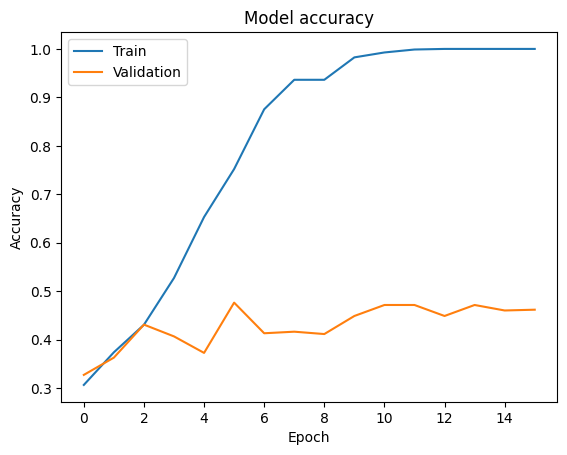

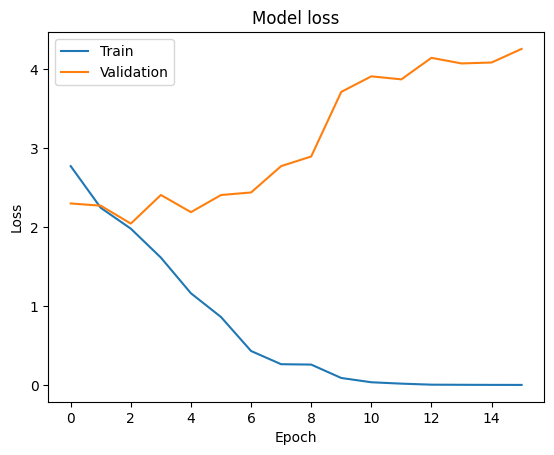

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Check the contents and shapes of audio_features and labels
print(f"Total processed files: {len(audio_features)}")
print(f"Sample data from audio_features: {audio_features[:2]}")
print(f"Sample data from labels: {labels[:2]}")

# Convert lists to numpy arrays
try:
    if len(audio_features) == 0 or len(labels) == 0:
        raise ValueError("No valid audio features or labels available for processing.")

    X = np.array(audio_features)
    y = np.array(labels)
    print("Converted features and labels to numpy arrays")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    # Normalize spectrograms
    if X.size == 0:
        raise ValueError("Empty feature array detected.")

    X = (X - X.min()) / (X.max() - X.min())
    print("Normalized spectrograms")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print("Encoded labels")
    print(f"Unique encoded labels: {np.unique(y_encoded)}")

    # Determine the number of unique classes
    num_classes = len(np.unique(y_encoded))
    print(f"Number of classes: {num_classes}")

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # Reshape for the model (add channel dimension)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Setup callbacks
    checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

    # Load the best saved model
    model.load_weights(checkpoint_path)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {accuracy}")

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the final model if needed
    final_model_path = 'bird_sound_final_model.h5'
    model.save(final_model_path)
except Exception as e:
    print(f"Error during conversion and model training: {e}")


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Check the contents and shapes of audio_features and labels
print(f"Total processed files: {len(audio_features)}")
print(f"Sample data from audio_features: {audio_features[:2]}")
print(f"Sample data from labels: {labels[:2]}")

# Convert lists to numpy arrays
try:
    if len(audio_features) == 0 or len(labels) == 0:
        raise ValueError("No valid audio features or labels available for processing.")

    X = np.array(audio_features)
    y = np.array(labels)
    print("Converted features and labels to numpy arrays")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    # Normalize spectrograms
    if X.size == 0:
        raise ValueError("Empty feature array detected.")

    X = (X - X.min()) / (X.max() - X.min())
    print("Normalized spectrograms")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print("Encoded labels")
    print(f"Unique encoded labels: {np.unique(y_encoded)}")

    # Determine the number of unique classes
    num_classes = len(np.unique(y_encoded))
    print(f"Number of classes: {num_classes}")

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # Reshape for the model (add channel dimension)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Setup callbacks
    checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

    # Load the best saved model
    model.load_weights(checkpoint_path)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {accuracy}")

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the final model if needed
    final_model_path = 'bird_sound_final_model.h5'
    model.save(final_model_path)
except Exception as e:
    print(f"Error during conversion and model training: {e}")


Total processed files: 3082
Sample data from audio_features: [[[-80.       -45.694855 -27.0052   ... -46.98056  -45.94296  -40.475986]
  [-80.       -47.07545  -28.286314 ... -51.922806 -51.196873 -57.290733]
  [-80.       -49.492424 -31.239956 ... -55.968628 -59.16565  -55.46309 ]
  ...
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]

 [[-80.       -80.       -80.       ... -57.61468  -62.18297  -66.677536]
  [-80.       -80.       -80.       ... -50.759136 -49.824497 -56.848816]
  [-80.       -80.       -80.       ... -43.452915 -46.69568  -54.37091 ]
  ...
  [-80.       -80.       -80.       ... -35.575516 -36.58261  -37.81939 ]
  [-80.       -80.       -76.33057  ... -35.823708 -37.14067  -34.39272 ]
  [-80.       -80.       -80.       ... -34.780365 -33.339455 -33.11696 ]]]
Sample data from labels: ['houspa' 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 360s 5s/step - loss: 2.7904 - accuracy: 0.2990 - val_loss: 2.3186 - val_accuracy: 0.3452
Epoch 2/20
 5/78 [>.............................] - ETA: 5:49 - loss: 2.1808 - accuracy: 0.4062

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Initial validation accuracy after loading weights: {accuracy}")


20/20 [==============================] - 25s 1s/step - loss: 2.3186 - accuracy: 0.3452
Initial validation accuracy after loading weights: 0.34521880745887756


In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define batch size and bursts
batch_size = 50  # Number of files to process at a time
burst_size = 3000  # Number of files after which to save and potentially stop

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Checkpoint file to save progress
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(folder_name, file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(f"{folder_name}/{file_name}")

# Function to save processed data
def save_processed_data(audio_features, labels, suffix):
    np.savez_compressed(f'/content/gdrive/MyDrive/datasets/processed_data_{suffix}.npz', features=audio_features, labels=labels)
    print(f"Data saved with suffix {suffix}")

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    if S_dB.shape[1] > fixed_size:
        S_dB = S_dB[:, :fixed_size]
    else:
        S_dB = np.pad(S_dB, ((0, 0), (0, fixed_size - S_dB.shape[1])), mode='constant')
    return S_dB

# Process the dataset in bursts
file_count = 0
start_processing = last_processed_file is None
processed_files_this_session = 0

for folder_name in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    audio_files = sorted(os.listdir(folder_path))
    for audio_file in tqdm(audio_files, desc=f"Processing {folder_name}"):
        if not start_processing:
            if f"{folder_name}/{audio_file}" == last_processed_file:
                start_processing = True
            continue

        audio_file_path = os.path.join(folder_path, audio_file)
        if not audio_file_path.endswith('.mp3'):
            continue

        spectrogram = audio_to_spectrogram(audio_file_path)
        if spectrogram is not None:
            audio_features.append(spectrogram)
            labels.append(folder_name)
            file_count += 1
            processed_files_this_session += 1
            save_checkpoint(folder_name, audio_file)

        if processed_files_this_session >= burst_size:
            save_processed_data(audio_features, labels, f"burst_{file_count//burst_size}")
            audio_features, labels = [], []  # Reset for the next burst
            processed_files_this_session = 0
            print("Burst limit reached, processing paused. Rerun to continue.")
            break
    if processed_files_this_session >= burst_size:
        break

if processed_files_this_session < burst_size:
    save_processed_data(audio_features, labels, "final")
    print("Processing complete.")


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M
Resuming from bnhcow/XC550246.mp3


Processing brncre:  55%|█████▍    | 70/128 [00:26<00:14,  3.91it/s]<ipython-input-3-8bdb36884431>:44: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing comred:  64%|██████▎   | 114/179 [01:29<00:51,  1.27it/s]


Data saved with suffix burst_1
Burst limit reached, processing paused. Rerun to continue.


Processing comter:  10%|▉         | 22/224 [00:18<02:46,  1.21it/s]


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

def load_burst_count():
    burst_count_file = '/content/gdrive/MyDrive/datasets/burst_count.txt'
    if os.path.exists(burst_count_file):
        with open(burst_count_file, 'r') as f:
            return int(f.read().strip())
    return 0

def update_burst_count(burst_count):
    burst_count_file = '/content/gdrive/MyDrive/datasets/burst_count.txt'
    with open(burst_count_file, 'w') as f:
        f.write(str(burst_count))

# Initialize or update burst count
burst_count = load_burst_count()

# Load the bird mapping dictionary
df = pd.read_csv('/content/gdrive/MyDrive/datasets/train_extended.csv')
bird_mapping = dict(zip(df['ebird_code'], df['species']))
print("Loaded bird mapping dictionary")

# Define the path to your dataset
dataset_path = '/content/gdrive/MyDrive/datasets/A-M'
print(f"Dataset path: {dataset_path}")

# Define batch size and bursts
batch_size = 50  # Number of files to process at a time
burst_size = 3000  # Number of files after which to save and potentially stop

# Initialize lists to store audio features and labels
audio_features = []
labels = []

# Checkpoint file to save progress
checkpoint_file = '/content/gdrive/MyDrive/datasets/checkpoint.txt'
last_processed_file = None
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        last_processed_file = f.readline().strip()
        print(f"Resuming from {last_processed_file}")

# Function to save the current checkpoint
def save_checkpoint(folder_name, file_name):
    with open(checkpoint_file, 'w') as f:
        f.write(f"{folder_name}/{file_name}")

# Function to save processed data
def save_processed_data(audio_features, labels, suffix):
    file_path = f'/content/gdrive/MyDrive/datasets/processed_data_{suffix}.npz'
    if os.path.exists(file_path):
        with np.load(file_path) as data:
            existing_features = data['features']
            existing_labels = data['labels']
            updated_features = np.concatenate((existing_features, audio_features), axis=0)
            updated_labels = np.concatenate((existing_labels, labels), axis=0)
        np.savez_compressed(file_path, features=updated_features, labels=updated_labels)
    else:
        np.savez_compressed(file_path, features=audio_features, labels=labels)
    print(f"Data saved with suffix {suffix}")

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_size=500):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    if S_dB.shape[1] > fixed_size:
        S_dB = S_dB[:, :fixed_size]
    else:
        S_dB = np.pad(S_dB, ((0, 0), (0, fixed_size - S_dB.shape[1])), mode='constant')
    return S_dB

# Process the dataset in bursts
file_count = 0
start_processing = last_processed_file is None
processed_files_this_session = 0

for folder_name in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    audio_files = sorted(os.listdir(folder_path))
    for audio_file in tqdm(audio_files, desc=f"Processing {folder_name}"):
        if not start_processing:
            if f"{folder_name}/{audio_file}" == last_processed_file:
                start_processing = True
            continue

        audio_file_path = os.path.join(folder_path, audio_file)
        if not audio_file_path.endswith('.mp3'):
            continue

        spectrogram = audio_to_spectrogram(audio_file_path)
        if spectrogram is not None:
            audio_features.append(spectrogram)
            labels.append(folder_name)
            file_count += 1
            processed_files_this_session += 1
            save_checkpoint(folder_name, audio_file)

        if processed_files_this_session >= burst_size:
            burst_count += 1
            update_burst_count(burst_count)
            save_processed_data(audio_features, labels, f"burst_{burst_count}")
            audio_features, labels = [], []  # Reset for the next burst
            processed_files_this_session = 0
            print("Burst limit reached, processing paused. Rerun to continue.")
            break
    if processed_files_this_session >= burst_size:
        break

if processed_files_this_session < burst_size:
    save_processed_data(audio_features, labels, "final")
    print("Processing complete.")


Loaded bird mapping dictionary
Dataset path: /content/gdrive/MyDrive/datasets/A-M


Processing blujay:  25%|██▌       | 60/239 [01:20<04:01,  1.35s/it]


Data saved with suffix burst_1
Burst limit reached, processing paused. Rerun to continue.


Processing brncre:  55%|█████▍    | 70/128 [00:30<00:11,  4.96it/s]<ipython-input-5-6b010c1e796c>:68: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing comred:  21%|██        | 37/179 [01:08<04:21,  1.84s/it]


Data saved with suffix burst_2
Burst limit reached, processing paused. Rerun to continue.


Processing grcfly:  12%|█▏        | 12/99 [00:04<00:33,  2.57it/s]/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Processing grcfly:  76%|███████▌  | 75/99 [01:40<00:32,  1.34s/it]


Data saved with suffix burst_3
Burst limit reached, processing paused. Rerun to continue.


Processing houwre:  30%|███       | 296/984 [04:41<10:53,  1.05it/s]


Data saved with suffix burst_4
Burst limit reached, processing paused. Rerun to continue.


Processing moudov: 100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Data saved with suffix final
Processing complete.


In [ ]:
from numpy import load

data = load('/content/gdrive/MyDrive/datasets/processed_data_final.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

features
[[[-78.79368  -51.621758 -45.598186 ... -40.937897 -42.5351   -51.23627 ]
  [-73.683556 -49.063377 -43.710674 ... -30.475906 -34.426407 -46.940353]
  [-71.2229   -47.461037 -39.727863 ... -25.145021 -28.97872  -35.809452]
  ...
  [-80.       -65.503296 -51.439976 ... -53.37186  -50.394894 -50.767883]
  [-80.       -66.27576  -54.850582 ... -50.63323  -52.972023 -52.639652]
  [-80.       -62.320915 -49.565754 ... -49.09217  -51.549603 -56.044483]]

 [[-80.       -80.       -80.       ... -66.41764  -70.830765 -73.583626]
  [-80.       -80.       -80.       ... -57.73068  -64.470695 -65.43818 ]
  [-80.       -80.       -80.       ... -52.71023  -57.605793 -59.107536]
  ...
  [-80.       -80.       -80.       ... -38.83747  -39.81525  -37.002434]
  [-80.       -80.       -80.       ... -37.95759  -40.543755 -37.781094]
  [-80.       -80.       -80.       ... -46.046886 -46.95667  -49.34819 ]]

 [[-80.       -80.       -80.       ... -80.       -80.       -80.      ]
  [-80.      

In [ ]:
import numpy as np
import os

def combine_npz_files(directory, output_file):
    # Get all npz files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith('processed_data_burst') or f.startswith('processed_data_final')]

    combined_features = []
    combined_labels = []

    # Load each file and append its content to the lists
    for file in files:
        with np.load(file) as data:
            features = data['features']
            labels = data['labels']
            combined_features.append(features)
            combined_labels.append(labels)

    # Concatenate all features and labels
    combined_features = np.concatenate(combined_features, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    # Save the combined data
    np.savez_compressed(output_file, features=combined_features, labels=combined_labels)
    print(f"Combined data saved to {output_file}")

# Define the directory where your npz files are stored and the name of the output file
directory = '/content/gdrive/MyDrive/datasets/'
output_file = '/content/gdrive/MyDrive/datasets/combined_processed_data.npz'

# Combine the files
combine_npz_files(directory, output_file)


Combined data saved to /content/gdrive/MyDrive/datasets/combined_processed_data.npz


In [ ]:
def load_data(file_path):
    with np.load(file_path) as data:
        features = data['features']
        labels = data['labels']
    return features, labels

# Load combined data
features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')

# Example: print shapes of the loaded data
print(features.shape, labels.shape)


(13656, 128, 500) (13656,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Flatten
from tqdm.notebook import tqdm as tqdm_notebook

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm_notebook(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)

    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    with np.load(file_path) as data:
        features = data['features']
        labels = data['labels']
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Features dtype:", features.dtype)
    print("Labels dtype:", labels.dtype)
    return features, labels

# Load and inspect data
features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')

# Ensure labels are integers if they're not
if labels.dtype.type is np.str_:
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    print("Labels converted to integers.")

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Flatten(input_shape=features.shape[-2:]),  # Ensure this matches the shape of your features
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(labels)), activation='softmax')  # Ensuring the output layer matches the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Checkpoint
checkpoints_path = '/content/gdrive/MyDrive/datasets/model_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Train the model with progress bar
batch_size = 1024
total_epochs = 50
epochs_per_burst = 5

for epoch in range(0, total_epochs, epochs_per_burst):
    print(f"Training burst: {epoch+1}-{epoch+epochs_per_burst}")
    model.fit(X_train, y_train, epochs=epochs_per_burst, validation_data=(X_val, y_val),
              callbacks=[checkpoint, TQDMProgressBar()], batch_size=batch_size, verbose=0)
    model.save(f'/content/gdrive/MyDrive/datasets/model_after_{epoch+epochs_per_burst}_epochs.h5')
    print(f"Saved model after {epoch+epochs_per_burst} epochs.")


Features shape: (13656, 128, 500)
Labels shape: (13656,)
Features dtype: float32
Labels dtype: <U7
Labels converted to integers.
Training burst: 1-5


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.00220, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.00220 to 0.01061, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5

Epoch 3: val_accuracy improved from 0.01061 to 0.04685, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5

Epoch 4: val_accuracy improved from 0.04685 to 0.08565, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5

Epoch 5: val_accuracy improved from 0.08565 to 0.08602, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5
Saved model after 5 epochs.
Training burst: 6-10


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 10 epochs.
Training burst: 11-15


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 15 epochs.
Training burst: 16-20


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 20 epochs.
Training burst: 21-25


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 25 epochs.
Training burst: 26-30


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 30 epochs.
Training burst: 31-35


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 35 epochs.
Training burst: 36-40


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 40 epochs.
Training burst: 41-45


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 45 epochs.
Training burst: 46-50


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_accuracy did not improve from 0.08602

Epoch 2: val_accuracy did not improve from 0.08602

Epoch 3: val_accuracy did not improve from 0.08602

Epoch 4: val_accuracy did not improve from 0.08602

Epoch 5: val_accuracy did not improve from 0.08602
Saved model after 50 epochs.


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tqdm.notebook import tqdm

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')
    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)
    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    with np.load(file_path) as data:
        features = data['features']
        labels = data['labels']
    if labels.dtype.type is np.str_:
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
        labels = encoder.fit_transform(labels)
    return features, labels

# Load data
features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define model
checkpoints_path = '/content/gdrive/MyDrive/datasets/model_checkpoint.h5'
if os.path.exists(checkpoints_path):
    model = load_model(checkpoints_path)
else:
    model = Sequential([
        Flatten(input_shape=(128, 500)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint to save the best model
checkpoint_callback = ModelCheckpoint(checkpoints_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Training
total_epochs = 50
model.fit(X_train, y_train, epochs=total_epochs, validation_data=(X_val, y_val),
          callbacks=[checkpoint_callback, TQDMProgressBar()], batch_size=1024, verbose=1)

# Save final model
final_model_path = '/content/gdrive/MyDrive/datasets/final_model.h5'
model.save(final_model_path)
print("Training complete. Final model saved.")


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 4.9956 - accuracy: 0.0898
Epoch 1: val_accuracy improved from -inf to 0.08602, saving model to /content/gdrive/MyDrive/datasets/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 4s 327ms/step - loss: 4.9956 - accuracy: 0.0898 - val_loss: 4.9924 - val_accuracy: 0.0860
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 4.9872 - accuracy: 0.0898
Epoch 2: val_accuracy did not improve from 0.08602
11/11 [==============================] - 1s 131ms/step - loss: 4.9872 - accuracy: 0.0898 - val_loss: 4.9843 - val_accuracy: 0.0860
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 4.9787 - accuracy: 0.0898
Epoch 3: val_accuracy did not improve from 0.08602
11/11 [==============================] - 1s 131ms/step - loss: 4.9787 - accuracy: 0.0898 - val_loss: 4.9763 - val_accuracy: 0.0860
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 4.9705 - accuracy: 0.0898
Epoch 4: val_accuracy did not improve from 0.08602
11/11 [==============================] - 1s 136ms/step - loss: 4.9705 - accuracy: 0.0898 - val_loss: 4.9683 - val_accuracy: 0.0860
Epoch 5/50
11/11 [=======================

No checkpoint found. Initializing a new model.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.12225, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.12225 to 0.19400, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 3: val_accuracy improved from 0.19400 to 0.22914, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 4: val_accuracy improved from 0.22914 to 0.23975, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 5: val_accuracy improved from 0.23975 to 0.24122, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 6: val_accuracy did not improve from 0.24122

Epoch 7: val_accuracy did not improve from 0.24122

Epoch 8: val_accuracy did not improve from 0.24122

Epoch 9: val_accuracy did not improve from 0.24122

Epoch 10: val_accuracy did not improve from 0.24122

Epoch 11: val_accuracy did not improve from 0.24122

Epoch 12: val_accuracy did not improve from 0.24122

Epoch 13: val_accuracy did not improve from 0.24122

Epoch 14: val_accuracy did not 

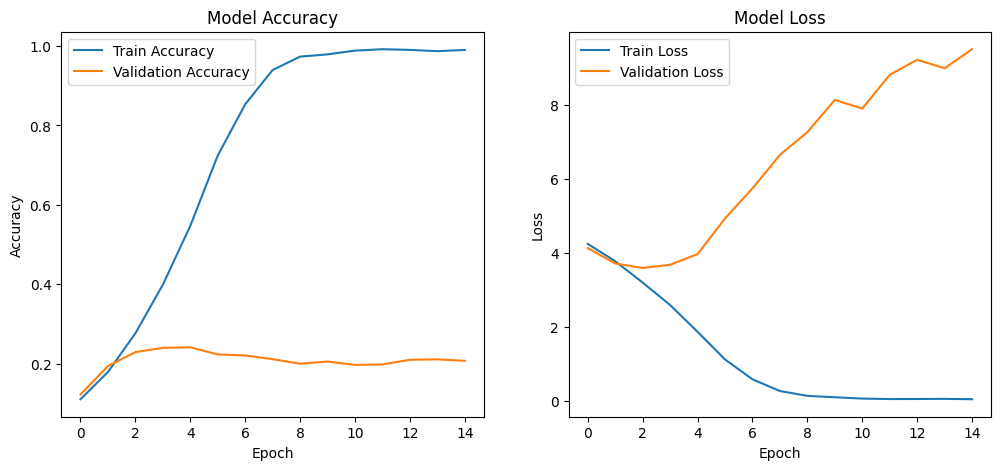

Final model saved.


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Custom tqdm progress bar for Keras
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)

    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    with np.load(file_path) as data:
        features = data['features']
        labels = data['labels']
    return features, labels

# Load and preprocess data
features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
labels = LabelEncoder().fit_transform(labels)  # Encode labels to integers

# Normalize features
features = (features - features.min()) / (features.max() - features.min())

# Split data
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Model checkpoint path
checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5'

# Load or create model
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint.")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found. Initializing a new model.")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Setup callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max'),
    TQDMProgressBar()
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Save the final model
final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model.h5'
model.save(final_model_path)
print("Final model saved.")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the best performing model
model = load_model('/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5')

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)  # Reduce the learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Setup callbacks for continued training
callbacks = [
    ModelCheckpoint('/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max'),
    TQDMProgressBar()
]

# Continue training
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=0)

# Evaluate and visualize results again
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Post-adjustment Validation Accuracy: {accuracy}")

# Save the potentially improved model
model.save('/content/gdrive/MyDrive/datasets/bird_sound_final_model.h5')


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.24085, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 2: val_accuracy improved from 0.24085 to 0.24414, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint.h5

Epoch 3: val_accuracy did not improve from 0.24414

Epoch 4: val_accuracy did not improve from 0.24414

Epoch 5: val_accuracy did not improve from 0.24414

Epoch 6: val_accuracy did not improve from 0.24414

Epoch 7: val_accuracy did not improve from 0.24414

Epoch 8: val_accuracy did not improve from 0.24414

Epoch 9: val_accuracy did not improve from 0.24414

Epoch 10: val_accuracy did not improve from 0.24414

Epoch 11: val_accuracy did not improve from 0.24414

Epoch 12: val_accuracy did not improve from 0.24414
Epoch 12: early stopping
86/86 [==============================] - 9s 99ms/step - loss: 6.6405 - accuracy: 0.2152
Post-adjustment Validation Accuracy: 0.2152269333600998


In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# Custom tqdm progress bar for Keras
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)

    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    return features, labels

def apply_masking_to_spectrogram(spectrogram, num_freq_masks=1, num_time_masks=1, max_mask_pct=0.15):
    modified_spectrogram = np.copy(spectrogram)
    num_freq_bins = modified_spectrogram.shape[0]
    num_time_steps = modified_spectrogram.shape[1]

    # Frequency masking
    for _ in range(num_freq_masks):
        freq_band = int(max_mask_pct * num_freq_bins)
        start_freq = np.random.randint(0, num_freq_bins - freq_band)
        modified_spectrogram[start_freq:start_freq + freq_band, :] = -80  # Assuming -80 dB is silence

    # Time masking
    for _ in range(num_time_masks):
        time_band = int(max_mask_pct * num_time_steps)
        start_time = np.random.randint(0, num_time_steps - time_band)
        modified_spectrogram[:, start_time:start_time + time_band] = -80  # Assuming -80 dB is silence

    return modified_spectrogram

def preprocess_data(spectrograms):
    return np.array([apply_masking_to_spectrogram(s) for s in spectrograms])

# Load and preprocess data
features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
features = preprocess_data(features)
labels = LabelEncoder().fit_transform(labels)
features = (features - features.min()) / (features.max() - features.min())
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Model architecture
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint.")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found. Initializing a new model.")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(np.unique(labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model = Sequential([
 #   Conv2D(32, (3, 3), activation='relu', input_shape=(128, 500, 1)),  # Adjust input shape
 #   MaxPooling2D((2, 2)),
  #  Conv2D(64, (3, 3), activation='relu'),
  #  MaxPooling2D((2, 2)),
 #   Flatten(),
#    Dense(128, activation='relu'),
 #   Dense(np.unique(labels).size, activation='softmax')
#])

# Checkpoint path
checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max'),
    TQDMProgressBar()
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Save the final model
final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model'
model.save(final_model_path)
print("Final model saved.")


Loading model from checkpoint.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.18485, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 2: val_accuracy did not improve from 0.18485

Epoch 3: val_accuracy did not improve from 0.18485

Epoch 4: val_accuracy did not improve from 0.18485

Epoch 5: val_accuracy did not improve from 0.18485

Epoch 6: val_accuracy did not improve from 0.18485

Epoch 7: val_accuracy did not improve from 0.18485

Epoch 8: val_accuracy did not improve from 0.18485


In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Custom tqdm progress bar for Keras
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)

    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    return features, labels

features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
labels = LabelEncoder().fit_transform(labels)
features = (features - features.min()) / (features.max() - features.min())
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Checkpoint path
checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint'

# Define the updated model architecture with Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 500, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),  # Adding dropout after convolutional layer
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Increased dropout rate
    Dense(np.unique(labels).size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max'),
    TQDMProgressBar()
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Save the final model
final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model'
model.save(final_model_path)
print("Final model saved.")


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.10542, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 2: val_accuracy improved from 0.10542 to 0.17606, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 3: val_accuracy improved from 0.17606 to 0.22438, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 4: val_accuracy improved from 0.22438 to 0.26135, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 5: val_accuracy improved from 0.26135 to 0.29941, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 6: val_accuracy improved from 0.29941 to 0.30161, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 7: val_accuracy improved from 0.30161 to 0.31149, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 8: val_accuracy improved from 0.31149 to 0.31698, saving m

It's improving again.

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Custom tqdm progress bar for Keras
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)

    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    return features, labels

features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
labels = LabelEncoder().fit_transform(labels)
features = (features - features.min()) / (features.max() - features.min())
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Checkpoint path
checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint'

# Load or initialize model
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)
    print("Loaded model from checkpoint.")
else:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 500, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(np.unique(labels).size, activation='softmax')
    ])
    print("No checkpoint found. Created a new model.")

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max'),
    TQDMProgressBar()
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Save the final model in the TensorFlow SavedModel format
final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model'
model.save(final_model_path, save_format='tf')
print("Final model saved in TensorFlow format.")


Loaded model from checkpoint.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.32284, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 2: val_accuracy did not improve from 0.32284

Epoch 3: val_accuracy did not improve from 0.32284

Epoch 4: val_accuracy improved from 0.32284 to 0.32540, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 5: val_accuracy did not improve from 0.32540

Epoch 6: val_accuracy did not improve from 0.32540

Epoch 7: val_accuracy did not improve from 0.32540

Epoch 8: val_accuracy did not improve from 0.32540

Epoch 9: val_accuracy did not improve from 0.32540

Epoch 10: val_accuracy did not improve from 0.32540

Epoch 11: val_accuracy did not improve from 0.32540

Epoch 12: val_accuracy did not improve from 0.32540

Epoch 13: val_accuracy improved from 0.32540 to 0.32613, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 14: val_accuracy did not improve from 0.32613

Epoch 15: val_accuracy 

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')
    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)
    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    return features, labels

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95

features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
labels = LabelEncoder().fit_transform(labels)
features = (features - features.min()) / (features.max() - features.min())
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint'
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)
    print("Loaded model from checkpoint.")
else:
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(128, 500, 1), kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        Dropout(0.3),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        Dropout(0.4),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(np.unique(labels).size, activation='softmax')
    ])
    print("No checkpoint found. Created a new model.")

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max'),  # Reduced patience
    TQDMProgressBar(),
    LearningRateScheduler(lr_schedule, verbose=1)
]
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=64, verbose=0)
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model'
model.save(final_model_path, save_format='tf')
print("Final model saved in TensorFlow format.")


Loaded model from checkpoint.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 1: val_accuracy improved from -inf to 0.12262, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.


KeyboardInterrupt: 

Loaded model from checkpoint.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 1: val_accuracy improved from -inf to 0.32321, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 2: val_accuracy improved from 0.32321 to 0.32577, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 3: val_accuracy did not improve from 0.32577

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 4: val_accuracy did not improve from 0.32577

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 5: val_accuracy improved from 0.32577 to 0.32650, saving model to /content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint

Epoch 6: LearningRateScheduler setting learning rate to 0.0009500000451225787.

Epoch 6: val_acc

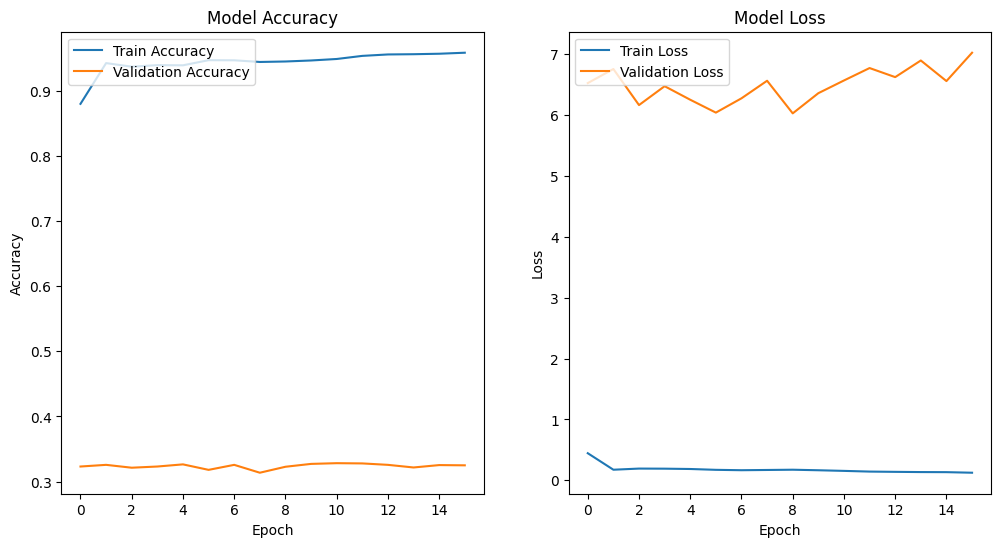

Final model saved in TensorFlow format.


In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.prog_bar = tqdm(total=self.epochs, desc='Training Progress')
    def on_epoch_end(self, epoch, logs=None):
        self.prog_bar.update(1)
    def on_train_end(self, logs=None):
        self.prog_bar.close()

def load_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    return features, labels

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95

features, labels = load_data('/content/gdrive/MyDrive/datasets/combined_processed_data.npz')
labels = LabelEncoder().fit_transform(labels)
features = (features - features.min()) / (features.max() - features.min())
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

checkpoint_path = '/content/gdrive/MyDrive/datasets/bird_sound_model_checkpoint'
if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path)
    print("Loaded model from checkpoint.")
else:
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(128, 500, 1), kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        Dropout(0.3),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        Dropout(0.4),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(np.unique(labels).size, activation='softmax')
    ])
    print("No checkpoint found. Created a new model.")

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max'),  # Reduced patience
    TQDMProgressBar(),
    LearningRateScheduler(lr_schedule, verbose=1)
]
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=64, verbose=0)
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

final_model_path = '/content/gdrive/MyDrive/datasets/bird_sound_final_model'
model.save(final_model_path, save_format='tf')
print("Final model saved in TensorFlow format.")
